# Rossmann_sales 销售预测项目

## 1、导入数据

将所需用到的库和数据分别导入

In [1]:
#导入所需用到的库
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import xgboost as xgb

%matplotlib inline

In [2]:
#导入项目提供的三组数据
train = pd.read_csv("data/train.csv", parse_dates=[2],low_memory=False)
test = pd.read_csv("data/test.csv", parse_dates=[3],low_memory=False)
store = pd.read_csv("data/store.csv")

这里注意，将Date项特征以datetime数据形式导入，以方便后续提取更多有用的时间数据信息。

## 2、数据预处理

对三组数据进行一个简单初步的分析和填充清洗

### 2.1 训练集

#### 2.1.1 数据初窥

In [3]:
#训练集初窥1
print('训练集的大小为',train.shape)
train.head()

训练集的大小为 (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


可以发现训练集共有9项特征，1017209行数据，随时间排序，各项特征分别是：

（1）Store：指代各不同的商店

（2）DayOfWeek：本周的第几天

（3）Date：所处的具体日期

（4）Sales：当日此商店的销售额

（5）Customers：当日此商店的客流量

（6）Open：当日此商店是否开业

（7）Promo：当日此商店是否进行促销1

（8）StateHoliday：当日是否为国家法定假期

（9）SchoolHoliday：当日是否为学校假期（寒暑假之类）

In [4]:
#训练集初窥2
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
#检查数据类型和缺失项
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

可以发现训练集中没有缺失项，因此无需填充数据。

#### 2.1.2 探查各项特征的取值

In [6]:
print('Store的最大值',train.Store.unique().max())
print('Store的最小值',train.Store.unique().min())

Store的最大值 1115
Store的最小值 1


In [7]:
print('DayOfWeek的取值',np.unique(train.DayOfWeek))

DayOfWeek的取值 [1 2 3 4 5 6 7]


In [8]:
print('数据结束日期',train.Date.unique().max())
print('数据开始日期',train.Date.unique().min())

数据结束日期 2015-07-31T00:00:00.000000000
数据开始日期 2013-01-01T00:00:00.000000000


In [9]:
print('Sales的最大值',train.Sales.unique().max())
print('Sales的最小值',train.Sales.unique().min())

Sales的最大值 41551
Sales的最小值 0


In [10]:
print('Customers的最大值',train.Customers.unique().max())
print('Customers的最小值',train.Customers.unique().min())

Customers的最大值 7388
Customers的最小值 0


In [11]:
print('Open的取值',np.unique(train.Open))

Open的取值 [0 1]


In [12]:
print('Promo的取值',np.unique(train.Promo))

Promo的取值 [0 1]


In [13]:
print('StateHoliday的取值',np.unique(train.StateHoliday))

StateHoliday的取值 ['0' 'a' 'b' 'c']


In [14]:
print('SchoolHoliday的取值',np.unique(train.SchoolHoliday))

SchoolHoliday的取值 [0 1]


训练集开始于2013-1-1日，结束于2015-7-31日，其中Open、Promo、StateHoliday、SchoolHoliday为哑变量。

#### 2.1.3 数据的填充

In [15]:
#从datetime数据项中提取各时间数据信息
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

In [16]:
#查看开业情况
non_open = train[train.Open == 0]
print("未开业的数据大小是: ", non_open.shape)

未开业的数据大小是:  (172817, 13)


根据项目的评判标准和要求，这些值对我们的预测模型没有参考价值，应该将其全部剔除掉。

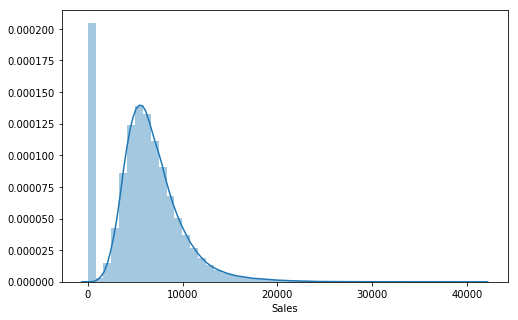

开业且销售额为零的数据大小是:  (54, 13)


In [17]:
#查看销售额的数据分布
fig=plt.figure(figsize=(8,5))
sns.distplot(train['Sales'])
plt.show()
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("开业且销售额为零的数据大小是: ", zero_sales.shape)

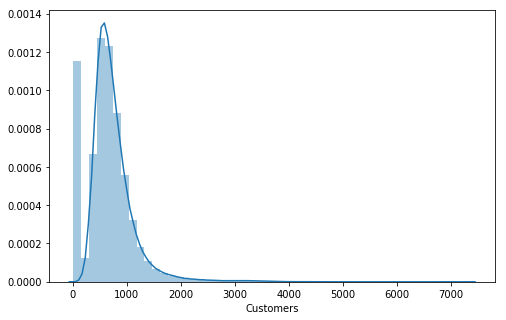

In [18]:
fig=plt.figure(figsize=(8,5))
sns.distplot(train['Customers'])
plt.show()

销售和数据都是较典型的正偏态分布，因此需要对数转换，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。鉴于后续还需对数据进行特征工程和进一步探究，对数转换放在特征工程后进行。

同时，开业且销售额为0的数据只有54行，应该也将其剔除掉，这样就可以将所有销售额为0的数据项剔除，提高预测精度，而客流量为0时，按照常识，销售额也应该为0，经检查没有违背此常识的异常项，无需进一步剔除。

### 2.2 测试集

#### 2.2.1 数据初窥

In [19]:
#测试集初窥1
print('训练集的大小为',test.shape)
test.head()

训练集的大小为 (41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


测试集的特征项与训练集相比，少了销售额（我们的预测结果）和客流量，多了Id这一项，其作用是上传预测结果时进行匹配评分。

In [20]:
#训练集初窥2
test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [21]:
#检查数据类型和缺失项
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

测试集中Open项的数据类型和训练集不匹配，需要将其转换为int64类型，同时，此项中有11个数据缺失，考虑到到缺失数量较小，应该用1（开业）来填充。

#### 2.2.2 探查各项特征的取值

In [22]:
print('Store的最大值',test.Store.unique().max())
print('Store的最小值',test.Store.unique().min())

Store的最大值 1115
Store的最小值 1


In [23]:
print('数据结束日期',test.Date.unique().max())
print('数据开始日期',test.Date.unique().min())

数据结束日期 2015-09-17T00:00:00.000000000
数据开始日期 2015-08-01T00:00:00.000000000


测试集开始于2015-8-1日，结束于2015-9-17日，共计6周，其余几项特征的取值范围和训练集相同。

#### 2.2.3 数据的填充

In [24]:
#转换数据类型，填充缺失项
test.fillna(1,inplace=True)
test['Open'] = test['Open'].astype('int64')

In [25]:
#从datetime数据项中提取各时间数据信息
test['Year'] = test.Date.dt.year
test['Month'] = test.Date.dt.month
test['Day'] = test.Date.dt.day
test['WeekOfYear'] = test.Date.dt.weekofyear

### 2.3 store数据集

#### 2.3.1 数据初窥

In [26]:
#数据集初窥1
print('store数据集的大小为',store.shape)
store.head()

store数据集的大小为 (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Store数据集中共有10项特征，1115行数据，新的特征含义为：

（1）StoreType：商店的类型

（2）Assortment：商品的类型

（3）CompetitionDistance：竞争对手的距离

（4）CompetitionOpenSinceMonth：竞争开始的月份

（5）CompetitionOpenSinceYear：竞争开始的年份

（6）Promo2：是否进行促销2

（7）Promo2SinceWeek：促销2开始的星期

（8）Promo2SinceYear：促销2开始的年份

（9）PromoInterval：参与促销的月份

In [27]:
#数据集初窥2
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [28]:
#检查数据类型和缺失项
store.info()
store.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

可以发现CompetitionDistance、CompetitionOpenSinceMonth 、CompetitionOpenSinceYear、Promo2SinceWeek、Promo2SinceYear、PromoInterval这六项都存在缺失项，在后续进行分析和填充。

#### 2.3.2 探查各项特征的取值

In [29]:
print('StoreType的取值',np.unique(store.StoreType))

StoreType的取值 ['a' 'b' 'c' 'd']


In [30]:
print('Assortment的取值',np.unique(store.Assortment))

Assortment的取值 ['a' 'b' 'c']


In [31]:
print('Promo2的取值',np.unique(store.Promo2))

Promo2的取值 [0 1]


In [32]:
print('PromoInterval的取值',store.PromoInterval.unique())

PromoInterval的取值 [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


#### 2.3.3 数据的填充

In [33]:
#查看CompetitionDistance缺失项
store[store.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


可以发现当CompetitionDistance缺失时，CompetitionOpenSinceMonth和CompetitionOpenSinceYear也是缺失的，用中位数填充CompetitionDistance，而将CompetitionOpen使用插值填充。

In [34]:
#填充与Competition有关的缺失项
distance_median = np.median(store.CompetitionDistance[store['CompetitionDistance'].notnull()])
store.CompetitionDistance.fillna(distance_median,inplace=True)
store.CompetitionOpenSinceMonth.fillna(method='ffill',inplace=True)
store.CompetitionOpenSinceYear.fillna(method='ffill',inplace=True)
store.iloc[[290,621,878]]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,2325.0,5.0,2001.0,0,NaN,NaN,NaN
621,622,a,c,2325.0,7.0,2002.0,0,NaN,NaN,NaN
878,879,d,a,2325.0,12.0,2014.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [35]:
#查看与Promo2有关的缺失项
promo2_nan = store[store.Promo2SinceWeek.isnull() & store.Promo2SinceYear.isnull()]
print('Promo2SinceWeek 和 Promo2SinceYear同时缺失的项数量是',len(promo2_nan))
print('当促销时间缺失时，促销月份缺失的项数为',promo2_nan.PromoInterval.isnull().count())
print('此时Promo2的取值为',promo2_nan.Promo2.unique())

Promo2SinceWeek 和 Promo2SinceYear同时缺失的项数量是 544
当促销时间缺失时，促销月份缺失的项数为 544
此时Promo2的取值为 [0]


由以上分析可以发现，Promo2的时间信息缺失时，年份、星期和促销月份都会缺失，且此时Promo2的取值皆为0，即未进行促销2，因此，为方便以后的分析，将Promo2的时间缺失项填充为2018-1-1，即这些数据的促销2发生在预测数据结束之后，同时将促销月份填充为0。

In [36]:
#填充与Promo2有关的缺失项
store.Promo2SinceWeek.fillna(1,inplace=True)
store.Promo2SinceYear.fillna(2018,inplace=True)
store.PromoInterval.fillna(0,inplace=True)

### 2.5 查看预处理后的数据
至此，我完成了数据的预处理，最后再对处理好的三项数据集进行一个查看。

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int64
Month            1017209 non-null int64
Day              1017209 non-null int64
WeekOfYear       1017209 non-null int64
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 100.9+ MB


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41088 non-null int64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 3.8+ MB


In [39]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [40]:
print('训练集处理后----------')
display(train.head())
print('测试集处理后----------')
display(test.head())
print('store数据集处理后----------')
display(store.head())

训练集处理后----------


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


测试集处理后----------


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1,1,0,0,2015,9,17,38
1,2,3,4,2015-09-17,1,1,0,0,2015,9,17,38
2,3,7,4,2015-09-17,1,1,0,0,2015,9,17,38
3,4,8,4,2015-09-17,1,1,0,0,2015,9,17,38
4,5,9,4,2015-09-17,1,1,0,0,2015,9,17,38


store数据集处理后----------


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,1.0,2018.0,0
4,5,a,a,29910.0,4.0,2015.0,0,1.0,2018.0,0


## 3、特征工程

首先将训练集和测试集与相对应的store、state数据进行合并

In [41]:
#数据集的合并
pre_train = pd.merge(train,store,how='inner',on='Store')

pre_test = pd.merge(test,store,how='inner',on='Store')

In [42]:
print('合并后的训练集为--------')
display(pre_train.head())
print('合并后的测试集为--------')
display(pre_test.head())

合并后的训练集为--------


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0


合并后的测试集为--------


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
1,857,1,3,2015-09-16,1,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
2,1713,1,2,2015-09-15,1,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
3,2569,1,1,2015-09-14,1,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0
4,3425,1,7,2015-09-13,0,0,0,0,2015,9,...,37,c,a,1270.0,9.0,2008.0,0,1.0,2018.0,0


### 3.1 数据可视化

#### 3.1.1 Sales & Customers & 时间数据

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

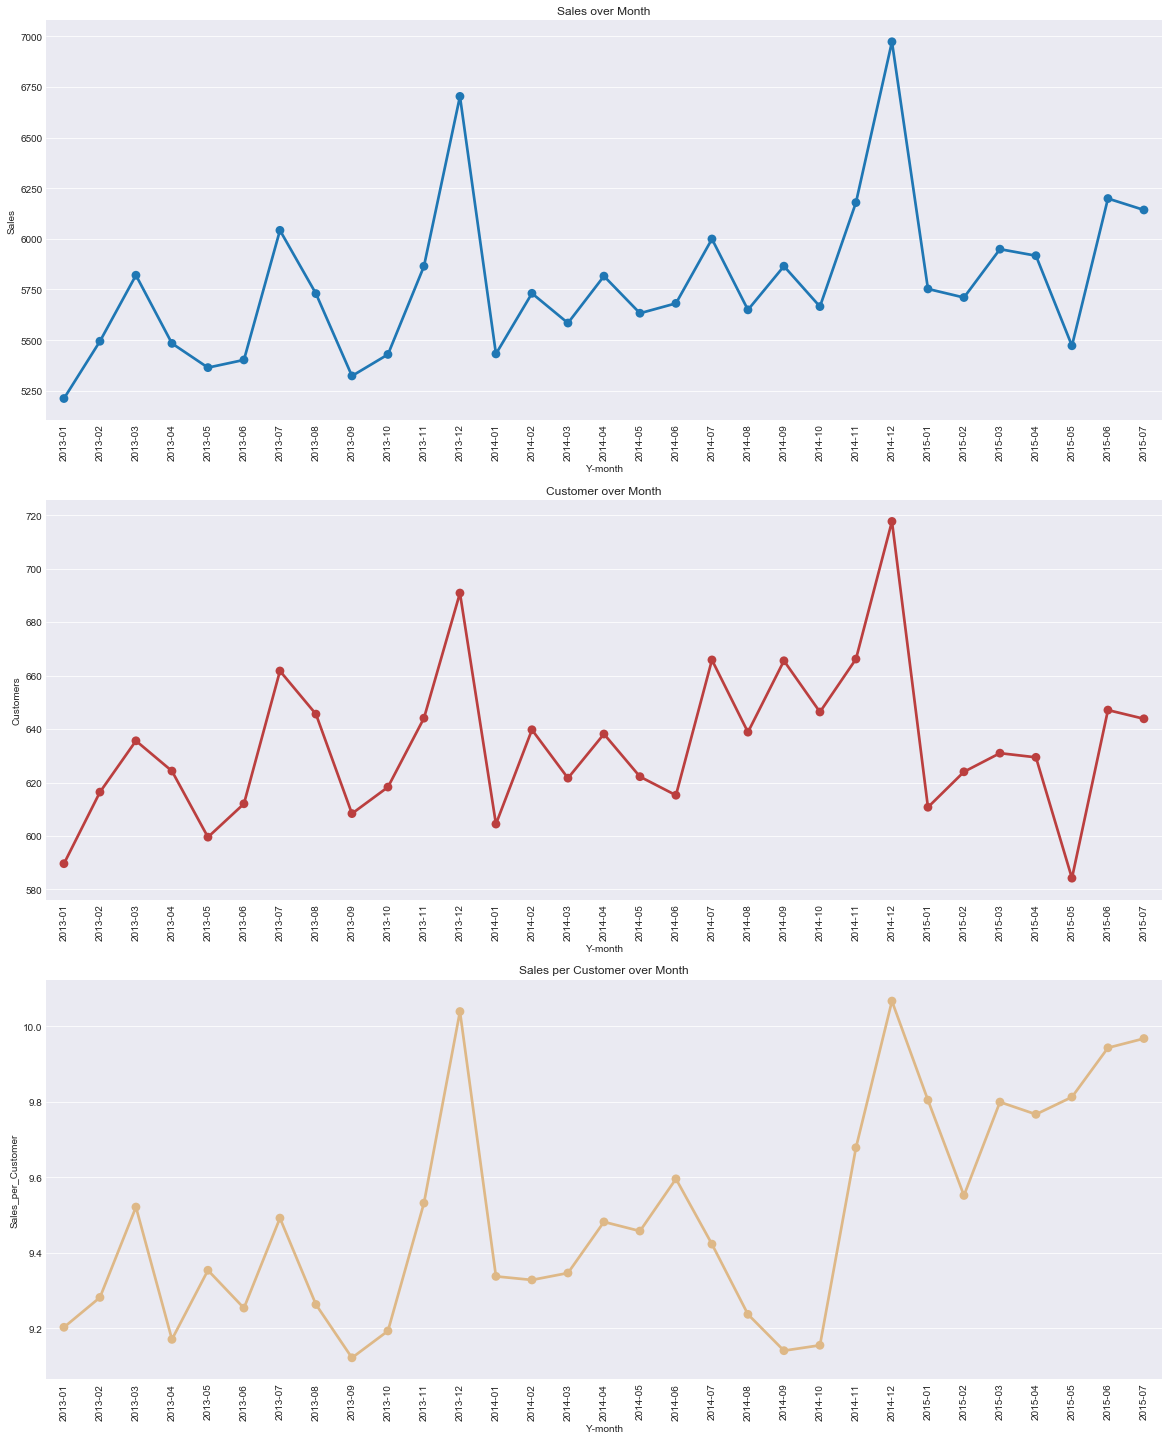

In [43]:
#提取Sales & Customers & Sales_per_Customer以及月份数据，并绘制相关图形
pre_train['Y-month'] = pre_train['Date'].apply(lambda x:(str(x)[:7]))
pre_train['Sales_per_Customer'] = pre_train['Sales']*1.0/pre_train['Customers']
sales_cust_date = pre_train[['Sales','Customers','Sales_per_Customer','Y-month']]
sales_cust_date = sales_cust_date.groupby('Y-month').mean().reset_index()

fig = plt.figure(figsize=(20,25))
sns.set_style("darkgrid")
plt.subplot(3,1,1)
sns.pointplot(x='Y-month',y='Sales',data=sales_cust_date).set_title('Sales over Month')
plt.xticks(rotation=90)

plt.subplot(3,1,2)
sns.pointplot(x='Y-month',y='Customers',data=sales_cust_date,color="#bb3f3f").set_title('Customer over Month')
plt.xticks(rotation=90)

plt.subplot(3,1,3)
sns.pointplot(x='Y-month',y='Sales_per_Customer',data=sales_cust_date,color="#DEB887").set_title('Sales per Customer over Month')
plt.xticks(rotation=90)

这三组数据的趋势走向基本一致，12月份的峰值和9-10月份的谷值一定程度上说明了假期和打折促销对销售额的影响。

#### 3.2.2 Sales & Customers & DayOfWeek 

Text(0.5,1,'Mean of Sales_per_Customer on DayOfWeek')

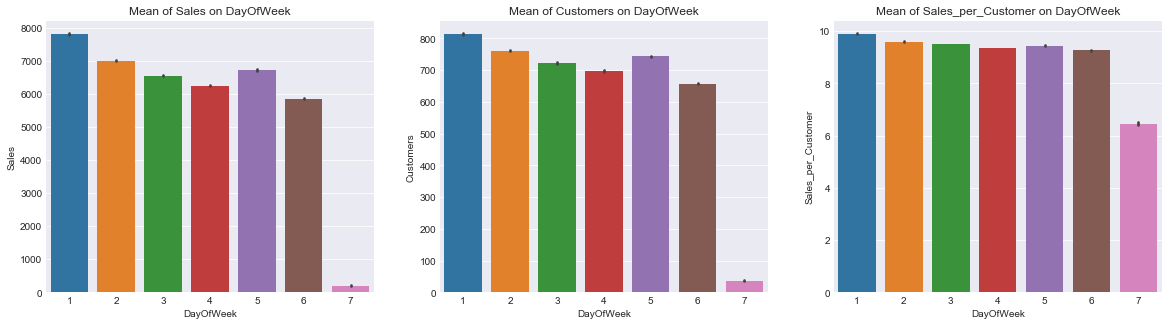

In [44]:
#提取Sales & Customers & Sales_per_Customer以及 DayOfWeek数据，并绘制相关图形
sales_cust_dayofweek = pre_train[['Sales','Customers','Sales_per_Customer','DayOfWeek']]

fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.barplot(x='DayOfWeek',y='Sales',data=sales_cust_dayofweek,order=[1,2,3,4,5,6,7]).set_title('Mean of Sales on DayOfWeek')
plt.subplot(1,3,2)
sns.barplot(x='DayOfWeek',y='Customers',data=sales_cust_dayofweek,order=[1,2,3,4,5,6,7]).set_title('Mean of Customers on DayOfWeek')
plt.subplot(1,3,3)
sns.barplot(x='DayOfWeek',y='Sales_per_Customer',data=sales_cust_dayofweek,order=[1,2,3,4,5,6,7]).set_title('Mean of Sales_per_Customer on DayOfWeek')

可以发现周日的各项数据都是最低，而周一都是最高。

#### 3.2.3 Sales & Customers & Promo	

Text(0.5,1,'Mean of Sales_per_Customer on Promo')

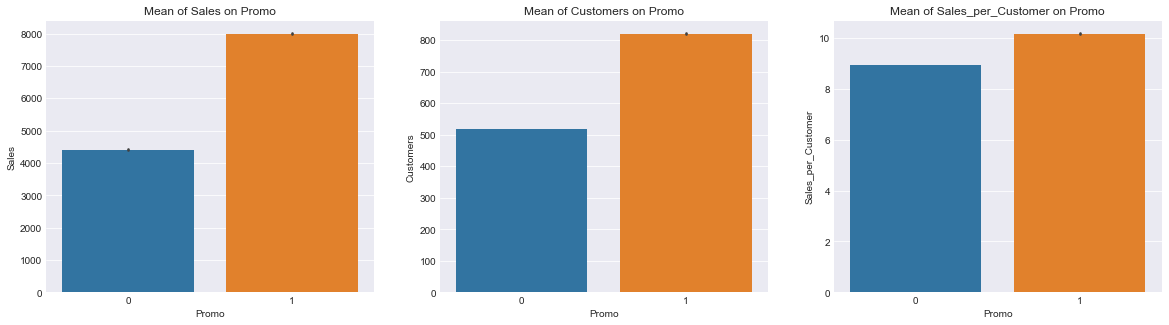

In [45]:
#提取Sales & Customers & Sales_per_Customer以及 Promo数据，并绘制相关图形
sales_cust_promo = pre_train[['Sales','Customers','Sales_per_Customer','Promo']]

fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.barplot(x='Promo',y='Sales',data=sales_cust_promo,order=[0,1]).set_title('Mean of Sales on Promo')
plt.subplot(1,3,2)
sns.barplot(x='Promo',y='Customers',data=sales_cust_promo,order=[0,1]).set_title('Mean of Customers on Promo')
plt.subplot(1,3,3)
sns.barplot(x='Promo',y='Sales_per_Customer',data=sales_cust_promo,order=[0,1]).set_title('Mean of Sales_per_Customer on Promo')

可以发现，促销中的销售额、客流量和人均消费都有了明显提升。

#### 3.2.4 Sales & Customers & StateHoliday	

Text(0.5,1,'Mean of Sales_per_Customer on StateHoliday')

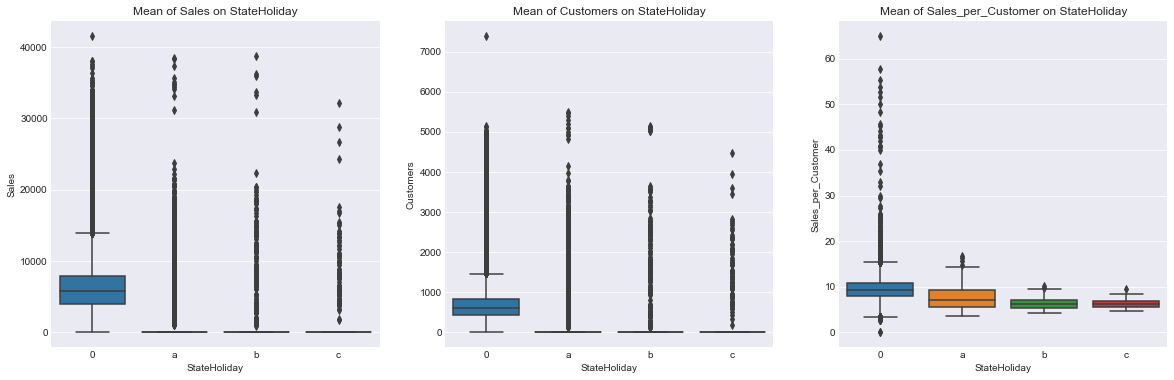

In [46]:
#提取Sales & Customers & Sales_per_Customer以及 StateHoliday数据，并绘制相关图形
sales_cust_state = pre_train[['Sales','Customers','Sales_per_Customer','StateHoliday']]

fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot(x='StateHoliday',y='Sales',data=sales_cust_state,order=['0','a','b','c']).set_title('Mean of Sales on StateHoliday')
plt.subplot(1,3,2)
sns.boxplot(x='StateHoliday',y='Customers',data=sales_cust_state,order=['0','a','b','c']).set_title('Mean of Customers on StateHoliday')
plt.subplot(1,3,3)
sns.boxplot(x='StateHoliday',y='Sales_per_Customer',data=sales_cust_state,order=['0','a','b','c']).set_title('Mean of Sales_per_Customer on StateHoliday')

可以发现a类型的各项数据都最高。

#### 3.2.5 Sales & Customers & SchoolHoliday

Text(0.5,1,'Mean of Sales_per_Customer on SchoolHoliday')

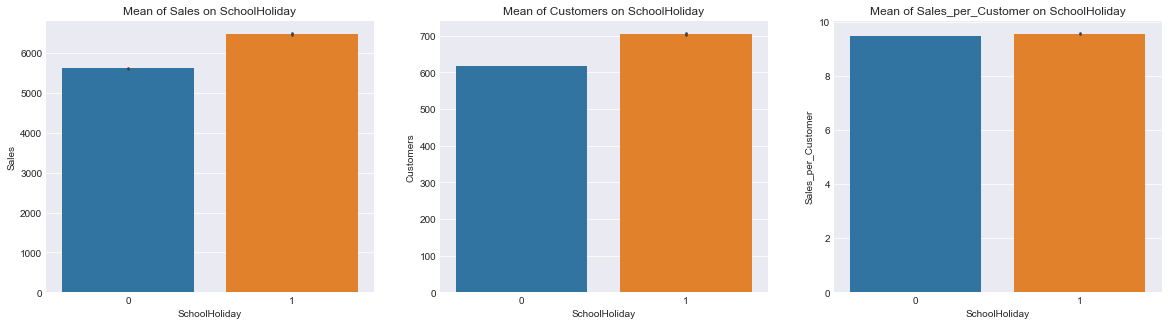

In [47]:
#提取Sales & Customers & Sales_per_Customer以及 SchoolHoliday数据，并绘制相关图形
sales_cust_sch = pre_train[['Sales','Customers','Sales_per_Customer','SchoolHoliday']]

fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.barplot(x='SchoolHoliday',y='Sales',data=sales_cust_sch,order=[0,1]).set_title('Mean of Sales on SchoolHoliday')
plt.subplot(1,3,2)
sns.barplot(x='SchoolHoliday',y='Customers',data=sales_cust_sch,order=[0,1]).set_title('Mean of Customers on SchoolHoliday')
plt.subplot(1,3,3)
sns.barplot(x='SchoolHoliday',y='Sales_per_Customer',data=sales_cust_sch,order=[0,1]).set_title('Mean of Sales_per_Customer on SchoolHoliday')

处于学校假期时，销售额和客流量会比平时有提升，但人均消费却差别不大。

#### 3.2.6 Sales & Customers & 时间变量 & Promo & StoreType

Text(0.5,1,'Store Count on StoreType')

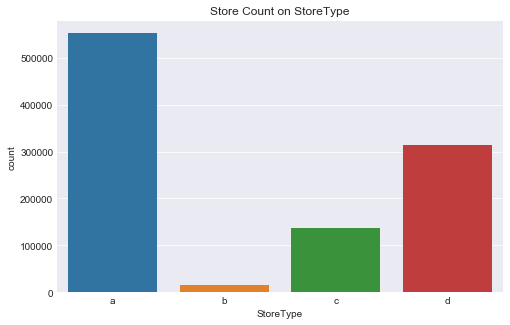

In [48]:
#查看各类型商店的数量
sales_cust_strty = pre_train[['Sales','Customers','Month','Promo','StoreType']]

fig = plt.figure(figsize=(8,5))
sns.countplot(x='StoreType',order=['a','b','c','d'],data=sales_cust_strty).set_title('Store Count on StoreType')

可以发现，数量上a类型>d类型>c类型>b类型，下面研究各类型的销售和客流量均值。

Text(0.5,1,'Mean of Customers on StoreType')

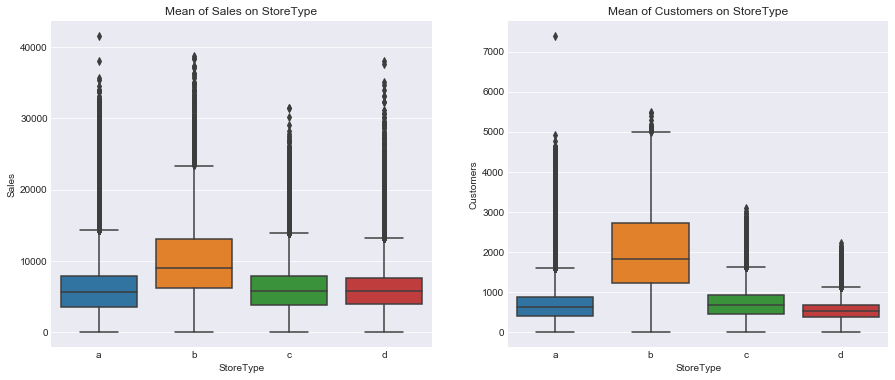

In [49]:
#提取Sales & Customers 以及 StoreType数据，并绘制相关图形

fig = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(x='StoreType',y='Sales',data=sales_cust_strty,order=['a','b','c','d']).set_title('Mean of Sales on StoreType')
plt.subplot(1,2,2)
sns.boxplot(x='StoreType',y='Customers',data=sales_cust_strty,order=['a','b','c','d']).set_title('Mean of Customers on StoreType')

很显然，b类型商店的销售额和客流量都比其他商店高一个档次，再来看看随时间推移，各商店的变化情况。

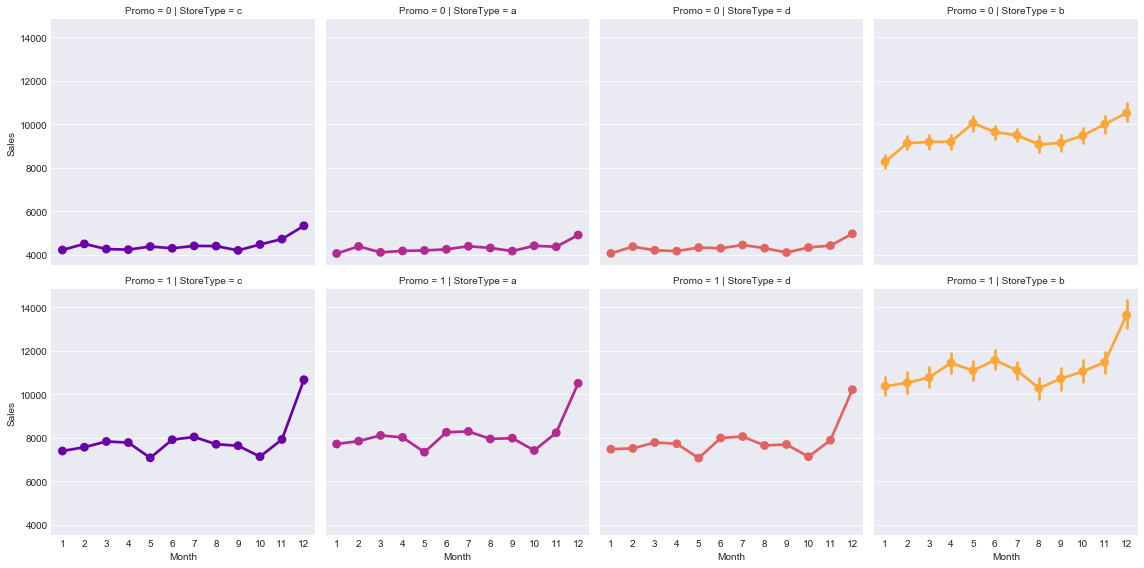

In [50]:
#绘制随时间推移的相关图形

fig = plt.figure(figsize=(20,6))
sns.factorplot(data = sales_cust_strty, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

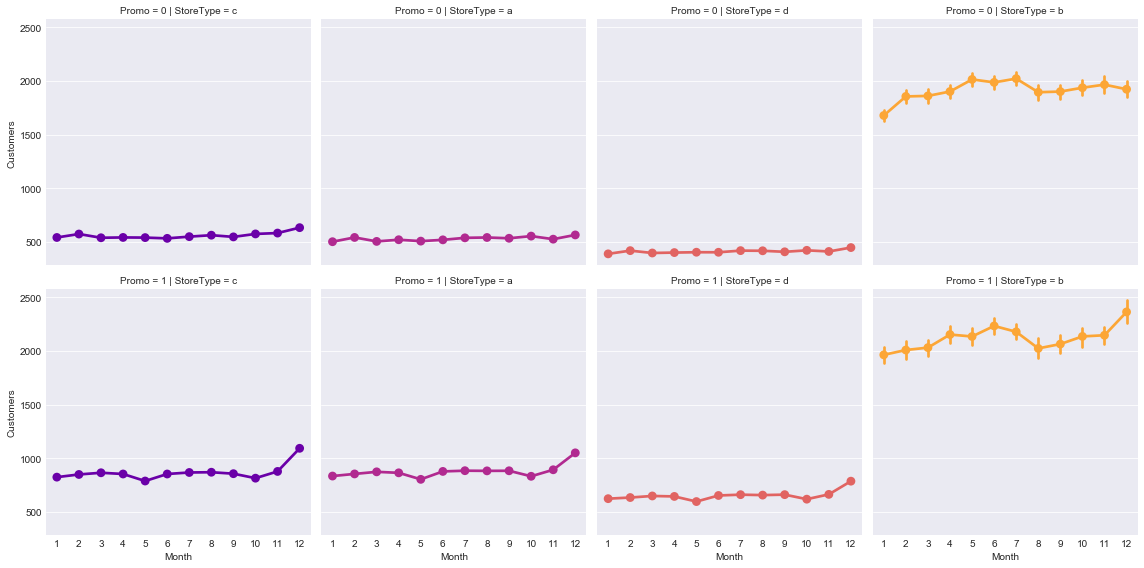

In [51]:
#绘制随时间推移的相关图形

fig = plt.figure(figsize=(20,6))
sns.factorplot(data = sales_cust_strty, x = 'Month', y = "Customers", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

#### 3.2.7 Sales & Customers  & Promo & Assortment

Text(0.5,1,'Store Count on Assortment')

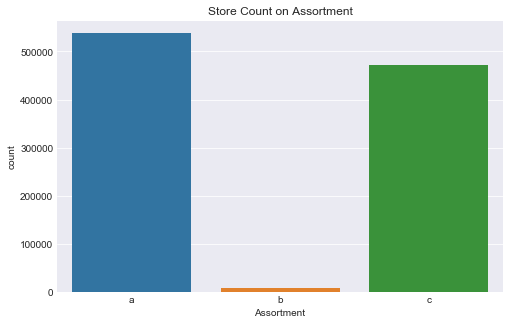

In [52]:
#查看各分类的数量
sales_cust_ass = pre_train[['Sales','Customers','Promo','Assortment']]

fig = plt.figure(figsize=(8,5))
sns.countplot(x='Assortment',order=['a','b','c'],data=sales_cust_ass).set_title('Store Count on Assortment')

从分类数量来看，分类a>分类c>分类b,下面研究各分类的销售和客流量均值。

Text(0.5,1,'Mean of Customers on Assortment')

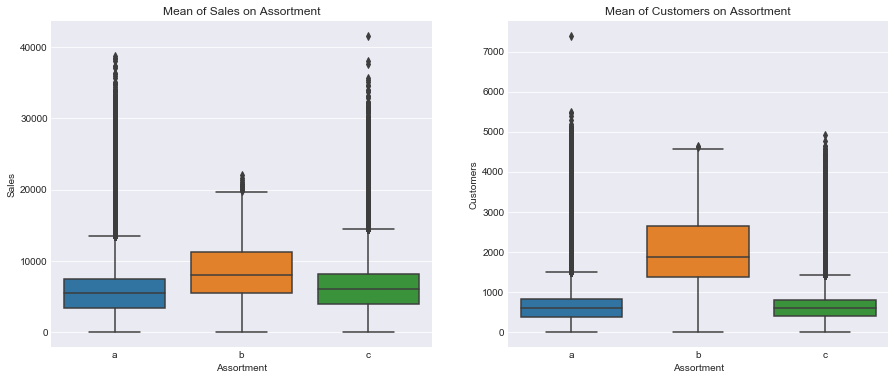

In [53]:
#提取Sales & Customers 以及 Assortment数据，并绘制相关图形

fig = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(x='Assortment',y='Sales',data=sales_cust_ass,order=['a','b','c']).set_title('Mean of Sales on Assortment')
plt.subplot(1,2,2)
sns.boxplot(x='Assortment',y='Customers',data=sales_cust_ass,order=['a','b','c']).set_title('Mean of Customers on Assortment')

可以发现，分类b在销售额和客流量上有明显优势。

#### 3.2.8 Sales  & 时间变量  & Competition

Text(0.5,1,'KDE of CompetitionDistance-Sales')

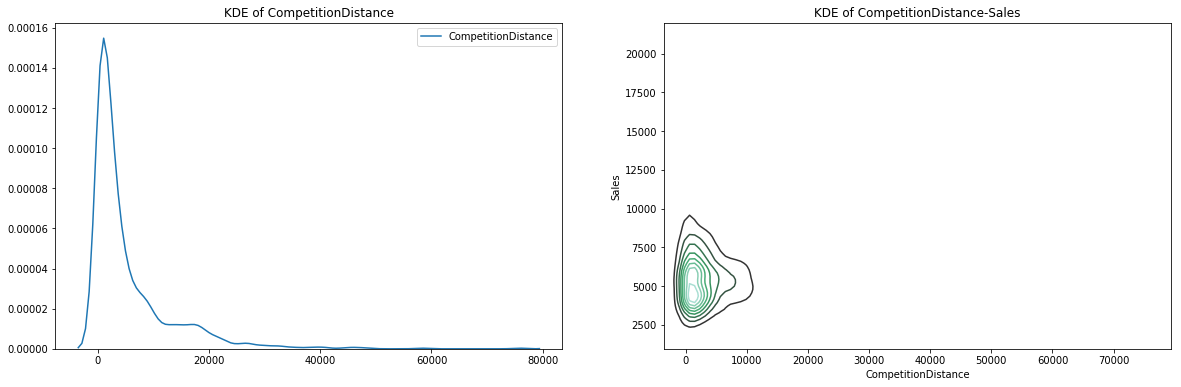

In [43]:
#创建竞争时间的新特征
def build_com(data):
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
build_com(pre_train)

#研究竞争距离和销售额的关系
sales_cust_comdis = pre_train[['Store','Sales','CompetitionDistance']].groupby('Store').mean()

fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.kdeplot(sales_cust_comdis['CompetitionDistance']).set_title('KDE of CompetitionDistance')
plt.subplot(1,2,2)
sns.kdeplot(sales_cust_comdis['CompetitionDistance'],sales_cust_comdis['Sales']).set_title('KDE of CompetitionDistance-Sales')

Text(0.5,1,'Change_After_CompetitorsOpened')

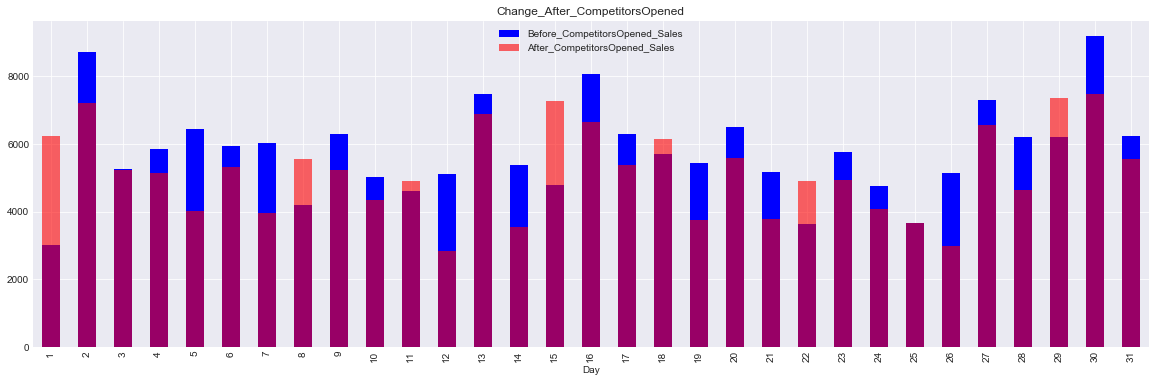

In [55]:
#研究竞争对手开业对销售额的影响
sales_cust_comop = pre_train[['Sales','Year','Day','CompetitionOpenSinceYear','CompetitionOpen']]
sales_cust_pre_comop = sales_cust_comop[(sales_cust_comop['Year'] == 2015) & (sales_cust_comop['CompetitionOpenSinceYear'] == 2015)\
                                        & (sales_cust_comop['CompetitionOpen'] <= 0)].groupby('Day').mean()
sales_cust_post_comop = sales_cust_comop[(sales_cust_comop['Year'] == 2015)& (sales_cust_comop['CompetitionOpenSinceYear'] == 2015)\
                                         & (sales_cust_comop['CompetitionOpen'] > 0)].groupby('Day').mean()
fig = plt.subplots(figsize=(20,6))
sales_cust_pre_comop['Sales'].plot.bar(legend = True ,label = 'Before_CompetitorsOpened_Sales',color = 'blue')
sales_cust_post_comop['Sales'].plot.bar(legend = True ,label = 'After_CompetitorsOpened_Sales',color = 'red',alpha = 0.6)
plt.title('Change_After_CompetitorsOpened')

可以发现，竞争对手开业后，销售额有了明显的下降。

#### 3.2.9 Sales  & 时间变量  & Promo2

In [44]:
def build_promo(data): 
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month
    data['monthStr'] = data.monthStr.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromo2Month'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromo2Month'] = 1

build_promo(pre_train)                

Text(0.5,1,'Mean of Customers on Promo2')

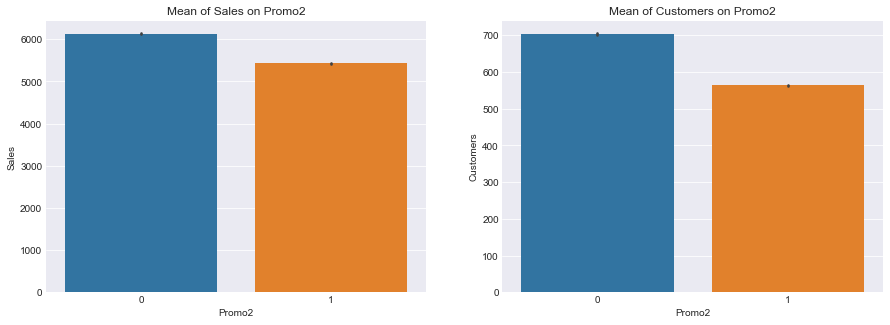

In [57]:
#提取Sales & Customers 以及 Promo2 & IsPromo2Month数据，并绘制相关图形
sales_cust_pro2 = pre_train[['Sales','Customers','Promo2','IsPromo2Month']]

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x='Promo2',y='Sales',data=sales_cust_pro2,order=[0,1]).set_title('Mean of Sales on Promo2')
plt.subplot(1,2,2)
sns.barplot(x='Promo2',y='Customers',data=sales_cust_pro2,order=[0,1]).set_title('Mean of Customers on Promo2')

Text(0.5,1,'Mean of Customers on IsPromo2Month')

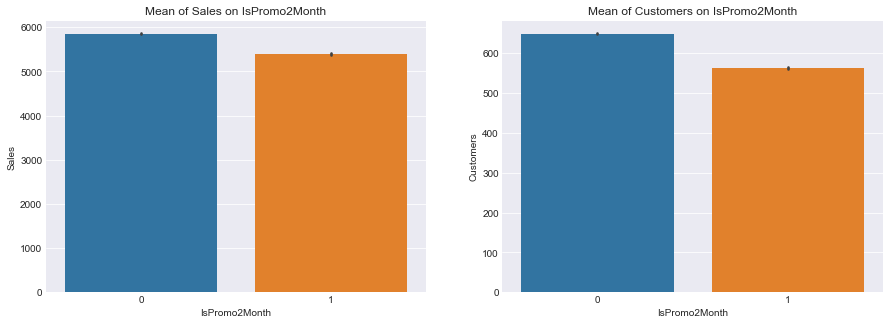

In [58]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x='IsPromo2Month',y='Sales',data=sales_cust_pro2,order=[0,1]).set_title('Mean of Sales on IsPromo2Month')
plt.subplot(1,2,2)
sns.barplot(x='IsPromo2Month',y='Customers',data=sales_cust_pro2,order=[0,1]).set_title('Mean of Customers on IsPromo2Month')

可以发现，当Promo2和IsPromo2Month取0值时，销售额和客流量更大。

### 3.3 为test数据集添加新特征

In [45]:
#添加新的特征
build_com(pre_test)
build_promo(pre_test)

## 4、建模前期准备

### 4.1 评分标准

建立相关的评分标准函数，以便于后续的模型评估。

In [46]:
#考虑到后续要进行对数转换，因此在评分时进行逆转换
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [47]:
def rmspe_xg1(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [48]:
#滤掉无用数据
pre_train = pre_train[pre_train.Open != 0]
pre_train = pre_train[pre_train.Sales > 0]
pre_train.shape

(844338, 26)

### 4.2 对数转换

这里需要对Sales、Customers和CompetitionDistance这三项进行转换

In [49]:
#训练集转换
post_train = pre_train.copy()
post_train['Sales'] = np.log1p(post_train['Sales'])
post_train['Customers'] = np.log1p(post_train['Customers'])
post_train['CompetitionDistance'] = np.log1p(post_train['CompetitionDistance'])
post_train['CompetitionOpen'] = np.log1p(post_train['CompetitionOpen'])
post_train['PromoOpen'] = np.log1p(post_train['PromoOpen'])

In [50]:
#测试集转换
post_test = pre_test.copy()
post_test['CompetitionDistance'] = np.log1p(post_test['CompetitionDistance'])
post_test['CompetitionOpen'] = np.log1p(post_test['CompetitionOpen'])
post_test['PromoOpen'] = np.log1p(post_test['PromoOpen'])

In [51]:
print('转换后训练集销售额的最大值为',post_train.Sales.unique().max())
print('转换后训练集销售额的最小值为',post_train.Sales.unique().min())

转换后训练集销售额的最大值为 10.63470093390253
转换后训练集销售额的最小值为 3.8501476017100584


In [52]:
print('转换后训练集客流量的最大值为',post_train.Customers.unique().max())
print('转换后训练集客流量的最小值为',post_train.Customers.unique().min())

转换后训练集客流量的最大值为 8.907747686788648
转换后训练集客流量的最小值为 2.1972245773362196


In [53]:
print('转换后训练集竞争距离的最大值为',post_train.CompetitionDistance.unique().max())
print('转换后训练集竞争距离的最小值为',post_train.CompetitionDistance.unique().min())

转换后训练集竞争距离的最大值为 11.236657997333701
转换后训练集竞争距离的最小值为 3.044522437723423


### 4.3 处理哑变量

将哑变量转换为数字。

In [54]:
onehot = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}

def onehot_trans(data):
    data.StateHoliday = data.StateHoliday.map(onehot)
    data.StoreType = data.StoreType.map(onehot)
    data.Assortment = data.Assortment.map(onehot)

onehot_trans(post_train)
onehot_trans(post_test)

In [55]:
print('转换后的训练集StateHoliday为',post_train.StateHoliday.unique())

转换后的训练集StateHoliday为 [0 1 2 3]


In [56]:
print('转换后的训练集StoreType为',post_train.StoreType.unique())

转换后的训练集StoreType为 [3 1 4 2]


In [57]:
print('转换后的训练集Assortment为',post_train.Assortment.unique())

转换后的训练集Assortment为 [1 3 2]


### 4.4 查看特征相关性

特征添加完成后，查看训练集中各项数据与Sales的相关性。

Text(0.5,1,'features correlation heatmap')

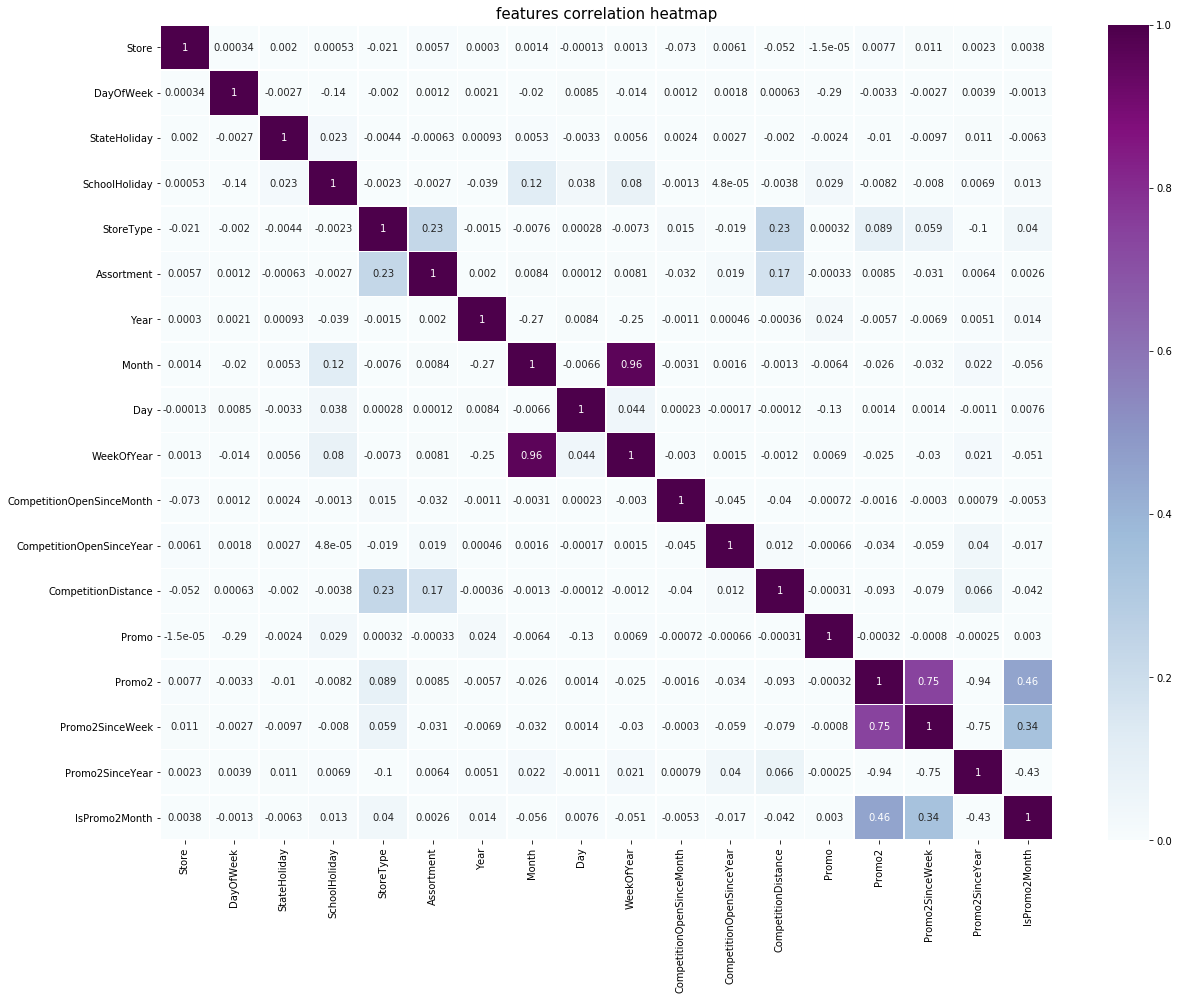

In [58]:
#绘制特征相关性的热力图
features =['Store','DayOfWeek','StateHoliday','SchoolHoliday','StoreType','Assortment','Year','Month','Day','WeekOfYear'\
           ,'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','CompetitionDistance','Promo','Promo2', 'Promo2SinceWeek','Promo2SinceYear','IsPromo2Month']


features_corr = post_train[features].corr()
fig = plt.figure(figsize=(20,15))
ax1 = sns.heatmap(features_corr,vmin=0,vmax=1,linewidths=.5,cmap="BuPu",annot=True)
ax1.set_title('features correlation heatmap',fontdict={'fontsize':15})

### 4.5 数据的排序、切割和特征提取

在建模之前，需要对数据进行排序、验证集切割和选定特征的提取、。

In [59]:
#特征排序和切割
#post_train =post_train.sort_values(by=['Year','Month','Day'])
slic_train = post_train[post_train['Date']<'2015-07-18']
slic_valid = post_train[post_train['Date']>='2015-07-18']

In [60]:
print('验证集中的年份是',slic_valid.Year.unique())
print('验证集中的月份是',slic_valid.Month.unique())

验证集中的年份是 [2015]
验证集中的月份是 [7]


In [61]:
X_train = slic_train[features]
y_train = slic_train['Sales']

X_valid = slic_valid[features]
y_valid = slic_valid['Sales']

X_train_full = post_train[features]
y_train_full = post_train['Sales']

X_test = post_test[features]

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830918 entries, 14 to 1017207
Data columns (total 18 columns):
Store                        830918 non-null int64
DayOfWeek                    830918 non-null int64
StateHoliday                 830918 non-null int64
SchoolHoliday                830918 non-null int64
StoreType                    830918 non-null int64
Assortment                   830918 non-null int64
Year                         830918 non-null int64
Month                        830918 non-null int64
Day                          830918 non-null int64
WeekOfYear                   830918 non-null int64
CompetitionOpenSinceMonth    830918 non-null float64
CompetitionOpenSinceYear     830918 non-null float64
CompetitionDistance          830918 non-null float64
Promo                        830918 non-null int64
Promo2                       830918 non-null int64
Promo2SinceWeek              830918 non-null float64
Promo2SinceYear              830918 non-null float64
IsPromo2Mo

In [63]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13420 entries, 0 to 1016280
Data columns (total 18 columns):
Store                        13420 non-null int64
DayOfWeek                    13420 non-null int64
StateHoliday                 13420 non-null int64
SchoolHoliday                13420 non-null int64
StoreType                    13420 non-null int64
Assortment                   13420 non-null int64
Year                         13420 non-null int64
Month                        13420 non-null int64
Day                          13420 non-null int64
WeekOfYear                   13420 non-null int64
CompetitionOpenSinceMonth    13420 non-null float64
CompetitionOpenSinceYear     13420 non-null float64
CompetitionDistance          13420 non-null float64
Promo                        13420 non-null int64
Promo2                       13420 non-null int64
Promo2SinceWeek              13420 non-null float64
Promo2SinceYear              13420 non-null float64
IsPromo2Month                

In [64]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 18 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
StateHoliday                 844338 non-null int64
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null int64
Assortment                   844338 non-null int64
Year                         844338 non-null int64
Month                        844338 non-null int64
Day                          844338 non-null int64
WeekOfYear                   844338 non-null int64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
CompetitionDistance          844338 non-null float64
Promo                        844338 non-null int64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
IsPromo2Mon

### 4.5 转换为dmatrix数据

In [65]:
dtrain = xgb.DMatrix(X_train,y_train)
dvalid = xgb.DMatrix(X_valid,y_valid)
dtrain_full = xgb.DMatrix(X_train_full,y_train_full)
dtest = xgb.DMatrix(X_test)
d_val = xgb.DMatrix(X_valid)

## 5、Xgboost建模与调参

In [ ]:
d_val = xgb.DMatrix(X_valid)
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 8,
          "min_child_weight":1,
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "silent": 1,
          "gamma":0,
          "seed": 42
         }
num_boost_round = 10000
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm_test = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                     early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
valid_probs = gbm_test.predict(d_val)
print("此时的验证集得分为",rmspe_xg1(valid_probs,y_valid))

### 5.1 调试max_depth 和min_child_weight

根据xgboost的调参流程,用初始参数设置先行调试max_depth 和min_child_weight的值。

In [69]:
d_val = xgb.DMatrix(X_valid)
max_depth_list = [4,6,8,10]
min_child_weight_list = [1,3,5]
for i in max_depth_list:
    for j in min_child_weight_list:
        params = {"objective": "reg:linear",
                  "booster" : "gbtree",
                  "eta": 0.1,
                  "max_depth": i,
                  "min_child_weight":j,
                  "subsample": 0.8,
                  "colsample_bytree": 0.8,
                  "silent": 1,
                  "seed": 42
                 }
        num_boost_round = 10000
        
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        gbm_test = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                             early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=False)
        valid_probs = gbm_test.predict(d_val)
        valid_probs[valid_probs<0] = 0
        print("max_depth为",i,"min_child_weight为",j,"此时的验证集得分为",rmspe_xg1(valid_probs,y_valid))

KeyboardInterrupt: 

### 5.2 调试subsample 和colsample_bytree

In [89]:
subsample_list = [0.6,0.7,0.8,0.9]
colsample_bytree_list = [0.6,0.7,0.8,0.9]
for i in subsample_list:
    for j in colsample_bytree_list:
        params = {"objective": "reg:linear",
                  "booster" : "gbtree",
                  "eta": 0.1,
                  "max_depth": 8,
                  "min_child_weight":5,
                  "subsample": i,
                  "colsample_bytree": j,
                  "silent": 1,
                  "seed": 42
                 }
        num_boost_round = 10000
        
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        gbm_test = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                             early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=False)
        valid_probs = gbm_test.predict(d_val)
        valid_probs[valid_probs<0] = 0
        print("max_depth为",i,"min_child_weight为",j,"此时的验证集得分为",rmspe_xg1(valid_probs,y_valid))

max_depth为 0.6 min_child_weight为 0.6 此时的验证集得分为 ('rmspe', 0.10489651902618154)
max_depth为 0.6 min_child_weight为 0.7 此时的验证集得分为 ('rmspe', 0.10588478082921529)
max_depth为 0.6 min_child_weight为 0.8 此时的验证集得分为 ('rmspe', 0.10385760069957106)
max_depth为 0.6 min_child_weight为 0.9 此时的验证集得分为 ('rmspe', 0.10356370224990344)
max_depth为 0.7 min_child_weight为 0.6 此时的验证集得分为 ('rmspe', 0.10304980668816884)
max_depth为 0.7 min_child_weight为 0.7 此时的验证集得分为 ('rmspe', 0.10372491850073201)
max_depth为 0.7 min_child_weight为 0.8 此时的验证集得分为 ('rmspe', 0.10340539534914839)
max_depth为 0.7 min_child_weight为 0.9 此时的验证集得分为 ('rmspe', 0.10246881227378568)
max_depth为 0.8 min_child_weight为 0.6 此时的验证集得分为 ('rmspe', 0.10385311489237195)
max_depth为 0.8 min_child_weight为 0.7 此时的验证集得分为 ('rmspe', 0.10263977069435777)
max_depth为 0.8 min_child_weight为 0.8 此时的验证集得分为 ('rmspe', 0.10147210352883784)
max_depth为 0.8 min_child_weight为 0.9 此时的验证集得分为 ('rmspe', 0.10419358123760156)
max_depth为 0.9 min_child_weight为 0.6 此时的验证集得分为 ('rmspe', 0.10435

### 5.3 调试gamma

In [90]:
gamma_dict=[0,0.05, 0.1,0.2,0.3,0.4]
for i in gamma_dict:
    params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.1,
              "max_depth": 8,
              "min_child_weight":5,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              'gamma':i,
              "silent": 1,
              "seed": 42
             }
    num_boost_round = 10000
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm_test = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                         early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=False)
    valid_probs = gbm_test.predict(d_val)
    valid_probs[valid_probs<0] = 0
    print("gamma为",i,"此时的验证集得分为",rmspe_xg1(valid_probs,y_valid))

gamma为 0 此时的验证集得分为 ('rmspe', 0.10147210352883784)
gamma为 0.05 此时的验证集得分为 ('rmspe', 0.10298965436620526)
gamma为 0.1 此时的验证集得分为 ('rmspe', 0.10647159544715784)
gamma为 0.2 此时的验证集得分为 ('rmspe', 0.10923290311775691)
gamma为 0.3 此时的验证集得分为 ('rmspe', 0.10931680542209839)
gamma为 0.4 此时的验证集得分为 ('rmspe', 0.1119243892598281)


### 5.4 调试正则化参数

In [91]:
reg_alpha_dict=[0,1e-5, 1e-2, 0.1, 1, 100]
for i in reg_alpha_dict:
    params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.1,
              "max_depth": 8,
              "min_child_weight":5,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              'gamma':0,
              'reg_alpha':i,
              "silent": 1,
              "seed": 42
             }
    num_boost_round = 10000
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm_test = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                         early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=False)
    valid_probs = gbm_test.predict(d_val)
    valid_probs[valid_probs<0] = 0
    print("reg_alpha为",i,"此时的验证集得分为",rmspe_xg1(valid_probs,y_valid))

reg_alpha为 0 此时的验证集得分为 ('rmspe', 0.10147210352883784)
reg_alpha为 1e-05 此时的验证集得分为 ('rmspe', 0.10169608462575039)
reg_alpha为 0.01 此时的验证集得分为 ('rmspe', 0.10305411356231099)
reg_alpha为 0.1 此时的验证集得分为 ('rmspe', 0.1035570357778542)
reg_alpha为 1 此时的验证集得分为 ('rmspe', 0.10199901343739769)
reg_alpha为 100 此时的验证集得分为 ('rmspe', 0.13121987768348786)


### 5.5 降低学习率，增加轮数，得到最终模型

In [67]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 8,
          "min_child_weight":5,
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "silent": 1,
          "seed": 42
          }
num_boost_round = 15000

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm1 = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

test_probs = gbm1.predict(dtest)
test_probs[test_probs<0] = 0
submission = pd.DataFrame({"Id": post_test["Id"], "Sales": np.expm1(test_probs)})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

[0]	train-rmse:8.18607	eval-rmse:8.19103	train-rmspe:0.999864	eval-rmspe:0.999865
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10436	eval-rmse:8.10944	train-rmspe:0.999838	eval-rmspe:0.999839
[2]	train-rmse:8.02347	eval-rmse:8.02868	train-rmspe:0.99981	eval-rmspe:0.999811
[3]	train-rmse:7.9434	eval-rmse:7.94861	train-rmspe:0.99978	eval-rmspe:0.999782
[4]	train-rmse:7.86414	eval-rmse:7.86961	train-rmspe:0.999747	eval-rmspe:0.99975
[5]	train-rmse:7.78566	eval-rmse:7.79122	train-rmspe:0.999713	eval-rmspe:0.999716
[6]	train-rmse:7.70797	eval-rmse:7.7137	train-rmspe:0.999676	eval-rmspe:0.999679
[7]	train-rmse:7.63106	eval-rmse:7.63672	train-rmspe:0.999637	eval-rmspe:0.99964
[8]	train-rmse:7.55491	eval-rmse:7.56069	train-rmspe:0.999595	eval-rmspe:0.999599
[9]	train-rmse:7.47955	eval-rmse:7.48556	train-rmspe:0.999549	eval-rmspe:0.999554
[10]	train-rmse:7.40494	eval-rmse:7.4110

[98]	train-rmse:3.07275	eval-rmse:3.07771	train-rmspe:0.950258	eval-rmspe:0.950682
[99]	train-rmse:3.04236	eval-rmse:3.04735	train-rmspe:0.948725	eval-rmspe:0.949162
[100]	train-rmse:3.01227	eval-rmse:3.01737	train-rmspe:0.947163	eval-rmspe:0.947618
[101]	train-rmse:2.98248	eval-rmse:2.98764	train-rmspe:0.945569	eval-rmspe:0.94604
[102]	train-rmse:2.953	eval-rmse:2.95816	train-rmspe:0.943945	eval-rmspe:0.944429
[103]	train-rmse:2.92381	eval-rmse:2.92896	train-rmspe:0.94229	eval-rmspe:0.942787
[104]	train-rmse:2.89491	eval-rmse:2.89991	train-rmspe:0.940603	eval-rmspe:0.941105
[105]	train-rmse:2.8663	eval-rmse:2.87138	train-rmspe:0.938887	eval-rmspe:0.939406
[106]	train-rmse:2.83799	eval-rmse:2.84297	train-rmspe:0.937136	eval-rmspe:0.937661
[107]	train-rmse:2.80997	eval-rmse:2.81475	train-rmspe:0.935354	eval-rmspe:0.935878
[108]	train-rmse:2.78223	eval-rmse:2.78701	train-rmspe:0.933539	eval-rmspe:0.934074
[109]	train-rmse:2.75476	eval-rmse:2.75955	train-rmspe:0.931697	eval-rmspe:0.932247

[197]	train-rmse:1.17081	eval-rmse:1.17487	train-rmspe:0.671594	eval-rmspe:0.672031
[198]	train-rmse:1.15987	eval-rmse:1.16369	train-rmspe:0.66806	eval-rmspe:0.668372
[199]	train-rmse:1.14901	eval-rmse:1.15284	train-rmspe:0.664529	eval-rmspe:0.664814
[200]	train-rmse:1.13826	eval-rmse:1.14207	train-rmspe:0.661004	eval-rmspe:0.661252
[201]	train-rmse:1.12764	eval-rmse:1.13147	train-rmspe:0.657481	eval-rmspe:0.657698
[202]	train-rmse:1.11717	eval-rmse:1.12115	train-rmspe:0.653951	eval-rmspe:0.654188
[203]	train-rmse:1.1068	eval-rmse:1.11063	train-rmspe:0.65043	eval-rmspe:0.650574
[204]	train-rmse:1.09652	eval-rmse:1.10043	train-rmspe:0.646915	eval-rmspe:0.647042
[205]	train-rmse:1.08635	eval-rmse:1.0902	train-rmspe:0.643407	eval-rmspe:0.643478
[206]	train-rmse:1.0763	eval-rmse:1.08024	train-rmspe:0.639899	eval-rmspe:0.639966
[207]	train-rmse:1.06636	eval-rmse:1.07016	train-rmspe:0.636397	eval-rmspe:0.636369
[208]	train-rmse:1.05648	eval-rmse:1.06023	train-rmspe:0.632902	eval-rmspe:0.6328

[294]	train-rmse:0.513679	eval-rmse:0.517083	train-rmspe:0.391679	eval-rmspe:0.381815
[295]	train-rmse:0.510092	eval-rmse:0.513472	train-rmspe:0.389845	eval-rmspe:0.379796
[296]	train-rmse:0.506382	eval-rmse:0.50971	train-rmspe:0.387973	eval-rmspe:0.377709
[297]	train-rmse:0.502808	eval-rmse:0.506081	train-rmspe:0.386154	eval-rmspe:0.375687
[298]	train-rmse:0.499379	eval-rmse:0.502661	train-rmspe:0.384411	eval-rmspe:0.373774
[299]	train-rmse:0.495983	eval-rmse:0.499293	train-rmspe:0.382685	eval-rmspe:0.371891
[300]	train-rmse:0.492502	eval-rmse:0.495761	train-rmspe:0.380919	eval-rmspe:0.369916
[301]	train-rmse:0.488984	eval-rmse:0.492245	train-rmspe:0.379156	eval-rmspe:0.367976
[302]	train-rmse:0.485575	eval-rmse:0.488835	train-rmspe:0.377415	eval-rmspe:0.366084
[303]	train-rmse:0.482349	eval-rmse:0.485636	train-rmspe:0.375787	eval-rmspe:0.364286
[304]	train-rmse:0.479104	eval-rmse:0.482447	train-rmspe:0.374153	eval-rmspe:0.3625
[305]	train-rmse:0.475897	eval-rmse:0.479218	train-rmspe:

[390]	train-rmse:0.313326	eval-rmse:0.316978	train-rmspe:0.301535	eval-rmspe:0.275526
[391]	train-rmse:0.312258	eval-rmse:0.315883	train-rmspe:0.30121	eval-rmspe:0.27502
[392]	train-rmse:0.311014	eval-rmse:0.314631	train-rmspe:0.300665	eval-rmspe:0.274337
[393]	train-rmse:0.309798	eval-rmse:0.313407	train-rmspe:0.300135	eval-rmspe:0.273679
[394]	train-rmse:0.308796	eval-rmse:0.312383	train-rmspe:0.299836	eval-rmspe:0.273211
[395]	train-rmse:0.307922	eval-rmse:0.31156	train-rmspe:0.299625	eval-rmspe:0.272913
[396]	train-rmse:0.306999	eval-rmse:0.310624	train-rmspe:0.299396	eval-rmspe:0.272534
[397]	train-rmse:0.306204	eval-rmse:0.309767	train-rmspe:0.29926	eval-rmspe:0.272257
[398]	train-rmse:0.305376	eval-rmse:0.308898	train-rmspe:0.299091	eval-rmspe:0.271953
[399]	train-rmse:0.30439	eval-rmse:0.307908	train-rmspe:0.298794	eval-rmspe:0.271519
[400]	train-rmse:0.303596	eval-rmse:0.307096	train-rmspe:0.29863	eval-rmspe:0.271246
[401]	train-rmse:0.302806	eval-rmse:0.306388	train-rmspe:0.2

[486]	train-rmse:0.255451	eval-rmse:0.257807	train-rmspe:0.288042	eval-rmspe:0.252161
[487]	train-rmse:0.255218	eval-rmse:0.25755	train-rmspe:0.288069	eval-rmspe:0.252132
[488]	train-rmse:0.255041	eval-rmse:0.257358	train-rmspe:0.288181	eval-rmspe:0.252173
[489]	train-rmse:0.254852	eval-rmse:0.257172	train-rmspe:0.288247	eval-rmspe:0.252196
[490]	train-rmse:0.254649	eval-rmse:0.25699	train-rmspe:0.288293	eval-rmspe:0.252214
[491]	train-rmse:0.254157	eval-rmse:0.256497	train-rmspe:0.288035	eval-rmspe:0.251907
[492]	train-rmse:0.253928	eval-rmse:0.256237	train-rmspe:0.288048	eval-rmspe:0.251832
[493]	train-rmse:0.253626	eval-rmse:0.255942	train-rmspe:0.288015	eval-rmspe:0.251742
[494]	train-rmse:0.253451	eval-rmse:0.255772	train-rmspe:0.288081	eval-rmspe:0.251735
[495]	train-rmse:0.253025	eval-rmse:0.255335	train-rmspe:0.287904	eval-rmspe:0.251452
[496]	train-rmse:0.252853	eval-rmse:0.255146	train-rmspe:0.288003	eval-rmspe:0.251476
[497]	train-rmse:0.25236	eval-rmse:0.254653	train-rmspe:

[582]	train-rmse:0.235514	eval-rmse:0.237314	train-rmspe:0.283764	eval-rmspe:0.243487
[583]	train-rmse:0.235465	eval-rmse:0.237257	train-rmspe:0.283835	eval-rmspe:0.243518
[584]	train-rmse:0.235315	eval-rmse:0.237107	train-rmspe:0.28377	eval-rmspe:0.243419
[585]	train-rmse:0.235044	eval-rmse:0.236828	train-rmspe:0.283596	eval-rmspe:0.243188
[586]	train-rmse:0.234722	eval-rmse:0.236515	train-rmspe:0.283406	eval-rmspe:0.242894
[587]	train-rmse:0.234421	eval-rmse:0.236215	train-rmspe:0.283197	eval-rmspe:0.242649
[588]	train-rmse:0.234107	eval-rmse:0.235909	train-rmspe:0.282984	eval-rmspe:0.242387
[589]	train-rmse:0.233875	eval-rmse:0.235676	train-rmspe:0.282834	eval-rmspe:0.242207
[590]	train-rmse:0.233636	eval-rmse:0.235443	train-rmspe:0.2827	eval-rmspe:0.242029
[591]	train-rmse:0.233441	eval-rmse:0.235257	train-rmspe:0.282542	eval-rmspe:0.241882
[592]	train-rmse:0.233396	eval-rmse:0.235205	train-rmspe:0.282605	eval-rmspe:0.241906
[593]	train-rmse:0.233317	eval-rmse:0.235053	train-rmspe:

[678]	train-rmse:0.222572	eval-rmse:0.224798	train-rmspe:0.276381	eval-rmspe:0.234032
[679]	train-rmse:0.222549	eval-rmse:0.22477	train-rmspe:0.276413	eval-rmspe:0.234038
[680]	train-rmse:0.222527	eval-rmse:0.224745	train-rmspe:0.276447	eval-rmspe:0.234046
[681]	train-rmse:0.22248	eval-rmse:0.224697	train-rmspe:0.276429	eval-rmspe:0.234028
[682]	train-rmse:0.222259	eval-rmse:0.224485	train-rmspe:0.27626	eval-rmspe:0.233816
[683]	train-rmse:0.221938	eval-rmse:0.224179	train-rmspe:0.276043	eval-rmspe:0.233489
[684]	train-rmse:0.22182	eval-rmse:0.224073	train-rmspe:0.275946	eval-rmspe:0.233401
[685]	train-rmse:0.221727	eval-rmse:0.223986	train-rmspe:0.275887	eval-rmspe:0.233337
[686]	train-rmse:0.22163	eval-rmse:0.223867	train-rmspe:0.275813	eval-rmspe:0.233274
[687]	train-rmse:0.22161	eval-rmse:0.223843	train-rmspe:0.275848	eval-rmspe:0.23328
[688]	train-rmse:0.221402	eval-rmse:0.223643	train-rmspe:0.275687	eval-rmspe:0.23308
[689]	train-rmse:0.221258	eval-rmse:0.223506	train-rmspe:0.275

[774]	train-rmse:0.2121	eval-rmse:0.214855	train-rmspe:0.268092	eval-rmspe:0.224384
[775]	train-rmse:0.212024	eval-rmse:0.21479	train-rmspe:0.268027	eval-rmspe:0.224329
[776]	train-rmse:0.211803	eval-rmse:0.214567	train-rmspe:0.267819	eval-rmspe:0.224076
[777]	train-rmse:0.21162	eval-rmse:0.214421	train-rmspe:0.267632	eval-rmspe:0.223923
[778]	train-rmse:0.211572	eval-rmse:0.214412	train-rmspe:0.267579	eval-rmspe:0.223925
[779]	train-rmse:0.21154	eval-rmse:0.214379	train-rmspe:0.267563	eval-rmspe:0.223941
[780]	train-rmse:0.211331	eval-rmse:0.214171	train-rmspe:0.267371	eval-rmspe:0.223703
[781]	train-rmse:0.211312	eval-rmse:0.21415	train-rmspe:0.267357	eval-rmspe:0.223692
[782]	train-rmse:0.210906	eval-rmse:0.213771	train-rmspe:0.266956	eval-rmspe:0.223269
[783]	train-rmse:0.210848	eval-rmse:0.213721	train-rmspe:0.266865	eval-rmspe:0.223213
[784]	train-rmse:0.210744	eval-rmse:0.213619	train-rmspe:0.26671	eval-rmspe:0.223101
[785]	train-rmse:0.210683	eval-rmse:0.213573	train-rmspe:0.26

[870]	train-rmse:0.201792	eval-rmse:0.205245	train-rmspe:0.258285	eval-rmspe:0.214127
[871]	train-rmse:0.201722	eval-rmse:0.205176	train-rmspe:0.258219	eval-rmspe:0.214046
[872]	train-rmse:0.201697	eval-rmse:0.205147	train-rmspe:0.258212	eval-rmspe:0.21403
[873]	train-rmse:0.201568	eval-rmse:0.205026	train-rmspe:0.258097	eval-rmspe:0.213889
[874]	train-rmse:0.201509	eval-rmse:0.204976	train-rmspe:0.258058	eval-rmspe:0.213838
[875]	train-rmse:0.201437	eval-rmse:0.2049	train-rmspe:0.257995	eval-rmspe:0.213756
[876]	train-rmse:0.201358	eval-rmse:0.204827	train-rmspe:0.25793	eval-rmspe:0.213683
[877]	train-rmse:0.201319	eval-rmse:0.204807	train-rmspe:0.257878	eval-rmspe:0.213625
[878]	train-rmse:0.201238	eval-rmse:0.204736	train-rmspe:0.257777	eval-rmspe:0.213516
[879]	train-rmse:0.201213	eval-rmse:0.204702	train-rmspe:0.25777	eval-rmspe:0.213495
[880]	train-rmse:0.201106	eval-rmse:0.204593	train-rmspe:0.257699	eval-rmspe:0.213389
[881]	train-rmse:0.200917	eval-rmse:0.204408	train-rmspe:0.

[966]	train-rmse:0.193311	eval-rmse:0.197136	train-rmspe:0.25048	eval-rmspe:0.205271
[967]	train-rmse:0.193278	eval-rmse:0.1971	train-rmspe:0.250433	eval-rmspe:0.205224
[968]	train-rmse:0.193227	eval-rmse:0.197053	train-rmspe:0.250386	eval-rmspe:0.205163
[969]	train-rmse:0.193048	eval-rmse:0.196883	train-rmspe:0.250231	eval-rmspe:0.204986
[970]	train-rmse:0.193	eval-rmse:0.196834	train-rmspe:0.250187	eval-rmspe:0.204931
[971]	train-rmse:0.192949	eval-rmse:0.196792	train-rmspe:0.250096	eval-rmspe:0.204881
[972]	train-rmse:0.192827	eval-rmse:0.196679	train-rmspe:0.249978	eval-rmspe:0.204783
[973]	train-rmse:0.19269	eval-rmse:0.196555	train-rmspe:0.249845	eval-rmspe:0.204647
[974]	train-rmse:0.192675	eval-rmse:0.19654	train-rmspe:0.249838	eval-rmspe:0.204633
[975]	train-rmse:0.1926	eval-rmse:0.196469	train-rmspe:0.249759	eval-rmspe:0.204571
[976]	train-rmse:0.192563	eval-rmse:0.196453	train-rmspe:0.249738	eval-rmspe:0.204568
[977]	train-rmse:0.19254	eval-rmse:0.196426	train-rmspe:0.249714

[1062]	train-rmse:0.185908	eval-rmse:0.190346	train-rmspe:0.243263	eval-rmspe:0.19787
[1063]	train-rmse:0.185895	eval-rmse:0.190323	train-rmspe:0.24327	eval-rmspe:0.197853
[1064]	train-rmse:0.185888	eval-rmse:0.190316	train-rmspe:0.243277	eval-rmspe:0.197848
[1065]	train-rmse:0.185802	eval-rmse:0.190251	train-rmspe:0.243202	eval-rmspe:0.197793
[1066]	train-rmse:0.18567	eval-rmse:0.190109	train-rmspe:0.243081	eval-rmspe:0.197652
[1067]	train-rmse:0.185579	eval-rmse:0.19002	train-rmspe:0.242998	eval-rmspe:0.197547
[1068]	train-rmse:0.185554	eval-rmse:0.189991	train-rmspe:0.242906	eval-rmspe:0.197526
[1069]	train-rmse:0.185482	eval-rmse:0.189919	train-rmspe:0.242839	eval-rmspe:0.197443
[1070]	train-rmse:0.185328	eval-rmse:0.189775	train-rmspe:0.242707	eval-rmspe:0.19728
[1071]	train-rmse:0.185203	eval-rmse:0.189675	train-rmspe:0.242592	eval-rmspe:0.197154
[1072]	train-rmse:0.185066	eval-rmse:0.189549	train-rmspe:0.242471	eval-rmspe:0.197022
[1073]	train-rmse:0.185019	eval-rmse:0.189516	tr

[1157]	train-rmse:0.179535	eval-rmse:0.184655	train-rmspe:0.236541	eval-rmspe:0.191518
[1158]	train-rmse:0.179481	eval-rmse:0.184602	train-rmspe:0.236495	eval-rmspe:0.191463
[1159]	train-rmse:0.179471	eval-rmse:0.184582	train-rmspe:0.236487	eval-rmspe:0.191449
[1160]	train-rmse:0.179398	eval-rmse:0.184514	train-rmspe:0.236422	eval-rmspe:0.191373
[1161]	train-rmse:0.179384	eval-rmse:0.184489	train-rmspe:0.236412	eval-rmspe:0.191355
[1162]	train-rmse:0.179376	eval-rmse:0.184479	train-rmspe:0.236394	eval-rmspe:0.191346
[1163]	train-rmse:0.179233	eval-rmse:0.184341	train-rmspe:0.236271	eval-rmspe:0.191188
[1164]	train-rmse:0.179202	eval-rmse:0.184311	train-rmspe:0.236244	eval-rmspe:0.191152
[1165]	train-rmse:0.179136	eval-rmse:0.184258	train-rmspe:0.236164	eval-rmspe:0.191069
[1166]	train-rmse:0.179069	eval-rmse:0.184204	train-rmspe:0.236047	eval-rmspe:0.190997
[1167]	train-rmse:0.179048	eval-rmse:0.184184	train-rmspe:0.236017	eval-rmspe:0.190975
[1168]	train-rmse:0.179039	eval-rmse:0.1841

[1252]	train-rmse:0.173013	eval-rmse:0.178665	train-rmspe:0.230454	eval-rmspe:0.184979
[1253]	train-rmse:0.172974	eval-rmse:0.178628	train-rmspe:0.230396	eval-rmspe:0.184912
[1254]	train-rmse:0.172848	eval-rmse:0.178505	train-rmspe:0.230294	eval-rmspe:0.184774
[1255]	train-rmse:0.172783	eval-rmse:0.17845	train-rmspe:0.230218	eval-rmspe:0.184706
[1256]	train-rmse:0.172767	eval-rmse:0.178448	train-rmspe:0.230205	eval-rmspe:0.184686
[1257]	train-rmse:0.172739	eval-rmse:0.178421	train-rmspe:0.230178	eval-rmspe:0.18466
[1258]	train-rmse:0.172709	eval-rmse:0.178393	train-rmspe:0.230151	eval-rmspe:0.184626
[1259]	train-rmse:0.172655	eval-rmse:0.178331	train-rmspe:0.230103	eval-rmspe:0.184566
[1260]	train-rmse:0.17263	eval-rmse:0.178333	train-rmspe:0.230083	eval-rmspe:0.184555
[1261]	train-rmse:0.172585	eval-rmse:0.178302	train-rmspe:0.230005	eval-rmspe:0.184514
[1262]	train-rmse:0.172445	eval-rmse:0.178181	train-rmspe:0.229861	eval-rmspe:0.184373
[1263]	train-rmse:0.172311	eval-rmse:0.178053	

[1347]	train-rmse:0.167211	eval-rmse:0.173612	train-rmspe:0.225195	eval-rmspe:0.179356
[1348]	train-rmse:0.167136	eval-rmse:0.173546	train-rmspe:0.22512	eval-rmspe:0.179285
[1349]	train-rmse:0.16707	eval-rmse:0.173482	train-rmspe:0.225063	eval-rmspe:0.17921
[1350]	train-rmse:0.167026	eval-rmse:0.173444	train-rmspe:0.225024	eval-rmspe:0.17917
[1351]	train-rmse:0.16697	eval-rmse:0.173382	train-rmspe:0.224973	eval-rmspe:0.179109
[1352]	train-rmse:0.166948	eval-rmse:0.173358	train-rmspe:0.224953	eval-rmspe:0.179001
[1353]	train-rmse:0.166879	eval-rmse:0.173293	train-rmspe:0.224893	eval-rmspe:0.178928
[1354]	train-rmse:0.16687	eval-rmse:0.173278	train-rmspe:0.224888	eval-rmspe:0.178917
[1355]	train-rmse:0.166851	eval-rmse:0.173254	train-rmspe:0.224868	eval-rmspe:0.178896
[1356]	train-rmse:0.166818	eval-rmse:0.173218	train-rmspe:0.224843	eval-rmspe:0.178841
[1357]	train-rmse:0.166762	eval-rmse:0.173155	train-rmspe:0.224796	eval-rmspe:0.178787
[1358]	train-rmse:0.166729	eval-rmse:0.173122	tra

[1442]	train-rmse:0.162069	eval-rmse:0.168767	train-rmspe:0.220228	eval-rmspe:0.173942
[1443]	train-rmse:0.162053	eval-rmse:0.168754	train-rmspe:0.22021	eval-rmspe:0.17389
[1444]	train-rmse:0.162028	eval-rmse:0.16873	train-rmspe:0.220188	eval-rmspe:0.173864
[1445]	train-rmse:0.162012	eval-rmse:0.168721	train-rmspe:0.22017	eval-rmspe:0.173845
[1446]	train-rmse:0.161831	eval-rmse:0.168558	train-rmspe:0.220014	eval-rmspe:0.173675
[1447]	train-rmse:0.161816	eval-rmse:0.168544	train-rmspe:0.220002	eval-rmspe:0.17366
[1448]	train-rmse:0.161759	eval-rmse:0.168496	train-rmspe:0.219956	eval-rmspe:0.173614
[1449]	train-rmse:0.161673	eval-rmse:0.16842	train-rmspe:0.21988	eval-rmspe:0.173523
[1450]	train-rmse:0.161513	eval-rmse:0.168262	train-rmspe:0.219745	eval-rmspe:0.173359
[1451]	train-rmse:0.161447	eval-rmse:0.168197	train-rmspe:0.219694	eval-rmspe:0.173297
[1452]	train-rmse:0.161417	eval-rmse:0.168164	train-rmspe:0.219681	eval-rmspe:0.173269
[1453]	train-rmse:0.16136	eval-rmse:0.168115	train

[1537]	train-rmse:0.157178	eval-rmse:0.164324	train-rmspe:0.215603	eval-rmspe:0.168916
[1538]	train-rmse:0.157109	eval-rmse:0.164276	train-rmspe:0.215542	eval-rmspe:0.168861
[1539]	train-rmse:0.157078	eval-rmse:0.164248	train-rmspe:0.215516	eval-rmspe:0.168829
[1540]	train-rmse:0.157023	eval-rmse:0.164197	train-rmspe:0.21547	eval-rmspe:0.168773
[1541]	train-rmse:0.156981	eval-rmse:0.164122	train-rmspe:0.215425	eval-rmspe:0.16871
[1542]	train-rmse:0.156947	eval-rmse:0.16409	train-rmspe:0.215397	eval-rmspe:0.168672
[1543]	train-rmse:0.156911	eval-rmse:0.164057	train-rmspe:0.215216	eval-rmspe:0.168639
[1544]	train-rmse:0.156894	eval-rmse:0.164044	train-rmspe:0.215207	eval-rmspe:0.168625
[1545]	train-rmse:0.15688	eval-rmse:0.164029	train-rmspe:0.215189	eval-rmspe:0.168611
[1546]	train-rmse:0.156804	eval-rmse:0.163966	train-rmspe:0.215124	eval-rmspe:0.168542
[1547]	train-rmse:0.156745	eval-rmse:0.163925	train-rmspe:0.215077	eval-rmspe:0.168499
[1548]	train-rmse:0.156708	eval-rmse:0.163897	t

[1632]	train-rmse:0.153009	eval-rmse:0.160505	train-rmspe:0.211384	eval-rmspe:0.16468
[1633]	train-rmse:0.152985	eval-rmse:0.160479	train-rmspe:0.211364	eval-rmspe:0.164651
[1634]	train-rmse:0.152941	eval-rmse:0.160434	train-rmspe:0.211323	eval-rmspe:0.164601
[1635]	train-rmse:0.152917	eval-rmse:0.160391	train-rmspe:0.211303	eval-rmspe:0.164535
[1636]	train-rmse:0.152842	eval-rmse:0.160324	train-rmspe:0.211232	eval-rmspe:0.164457
[1637]	train-rmse:0.15283	eval-rmse:0.160307	train-rmspe:0.211227	eval-rmspe:0.164445
[1638]	train-rmse:0.152817	eval-rmse:0.16029	train-rmspe:0.211224	eval-rmspe:0.164432
[1639]	train-rmse:0.152758	eval-rmse:0.16024	train-rmspe:0.21117	eval-rmspe:0.164376
[1640]	train-rmse:0.152743	eval-rmse:0.16024	train-rmspe:0.211159	eval-rmspe:0.164358
[1641]	train-rmse:0.152673	eval-rmse:0.160165	train-rmspe:0.21111	eval-rmspe:0.164278
[1642]	train-rmse:0.152637	eval-rmse:0.160134	train-rmspe:0.211067	eval-rmspe:0.164245
[1643]	train-rmse:0.152599	eval-rmse:0.160084	trai

[1727]	train-rmse:0.149236	eval-rmse:0.156947	train-rmspe:0.207721	eval-rmspe:0.160647
[1728]	train-rmse:0.149223	eval-rmse:0.156933	train-rmspe:0.207719	eval-rmspe:0.160635
[1729]	train-rmse:0.149181	eval-rmse:0.1569	train-rmspe:0.207681	eval-rmspe:0.16059
[1730]	train-rmse:0.149095	eval-rmse:0.15682	train-rmspe:0.207601	eval-rmspe:0.160503
[1731]	train-rmse:0.149085	eval-rmse:0.156809	train-rmspe:0.207592	eval-rmspe:0.160491
[1732]	train-rmse:0.149031	eval-rmse:0.156766	train-rmspe:0.207545	eval-rmspe:0.160446
[1733]	train-rmse:0.149001	eval-rmse:0.156742	train-rmspe:0.207519	eval-rmspe:0.160413
[1734]	train-rmse:0.148949	eval-rmse:0.156699	train-rmspe:0.207473	eval-rmspe:0.160365
[1735]	train-rmse:0.148937	eval-rmse:0.156694	train-rmspe:0.207445	eval-rmspe:0.160361
[1736]	train-rmse:0.148886	eval-rmse:0.156651	train-rmspe:0.207402	eval-rmspe:0.160315
[1737]	train-rmse:0.148876	eval-rmse:0.156643	train-rmspe:0.207389	eval-rmspe:0.160306
[1738]	train-rmse:0.148821	eval-rmse:0.156599	t

[1822]	train-rmse:0.145787	eval-rmse:0.153914	train-rmspe:0.204415	eval-rmspe:0.157201
[1823]	train-rmse:0.145751	eval-rmse:0.153881	train-rmspe:0.204386	eval-rmspe:0.157164
[1824]	train-rmse:0.145734	eval-rmse:0.153866	train-rmspe:0.204359	eval-rmspe:0.157132
[1825]	train-rmse:0.145697	eval-rmse:0.153837	train-rmspe:0.204308	eval-rmspe:0.157098
[1826]	train-rmse:0.145647	eval-rmse:0.153786	train-rmspe:0.204269	eval-rmspe:0.157045
[1827]	train-rmse:0.145637	eval-rmse:0.15378	train-rmspe:0.204186	eval-rmspe:0.157039
[1828]	train-rmse:0.145625	eval-rmse:0.153766	train-rmspe:0.204238	eval-rmspe:0.157027
[1829]	train-rmse:0.145599	eval-rmse:0.153743	train-rmspe:0.204217	eval-rmspe:0.157
[1830]	train-rmse:0.145567	eval-rmse:0.153719	train-rmspe:0.204183	eval-rmspe:0.156975
[1831]	train-rmse:0.14553	eval-rmse:0.153685	train-rmspe:0.204151	eval-rmspe:0.156938
[1832]	train-rmse:0.145471	eval-rmse:0.153639	train-rmspe:0.204092	eval-rmspe:0.156888
[1833]	train-rmse:0.145419	eval-rmse:0.153599	tr

[1917]	train-rmse:0.142339	eval-rmse:0.150862	train-rmspe:0.201396	eval-rmspe:0.15375
[1918]	train-rmse:0.142291	eval-rmse:0.150806	train-rmspe:0.20135	eval-rmspe:0.153682
[1919]	train-rmse:0.142258	eval-rmse:0.150786	train-rmspe:0.201319	eval-rmspe:0.153662
[1920]	train-rmse:0.14222	eval-rmse:0.150751	train-rmspe:0.201287	eval-rmspe:0.153623
[1921]	train-rmse:0.142151	eval-rmse:0.150684	train-rmspe:0.201226	eval-rmspe:0.153542
[1922]	train-rmse:0.142132	eval-rmse:0.150655	train-rmspe:0.201204	eval-rmspe:0.153503
[1923]	train-rmse:0.142089	eval-rmse:0.150625	train-rmspe:0.201174	eval-rmspe:0.153475
[1924]	train-rmse:0.142011	eval-rmse:0.150558	train-rmspe:0.201091	eval-rmspe:0.153403
[1925]	train-rmse:0.141951	eval-rmse:0.150504	train-rmspe:0.201035	eval-rmspe:0.153347
[1926]	train-rmse:0.141915	eval-rmse:0.150471	train-rmspe:0.201007	eval-rmspe:0.153306
[1927]	train-rmse:0.141895	eval-rmse:0.150454	train-rmspe:0.20099	eval-rmspe:0.153288
[1928]	train-rmse:0.141882	eval-rmse:0.150464	t

[2012]	train-rmse:0.139141	eval-rmse:0.147974	train-rmspe:0.198592	eval-rmspe:0.150509
[2013]	train-rmse:0.139087	eval-rmse:0.14793	train-rmspe:0.198535	eval-rmspe:0.150454
[2014]	train-rmse:0.139071	eval-rmse:0.147916	train-rmspe:0.198423	eval-rmspe:0.150438
[2015]	train-rmse:0.139043	eval-rmse:0.147895	train-rmspe:0.1984	eval-rmspe:0.150415
[2016]	train-rmse:0.138987	eval-rmse:0.147848	train-rmspe:0.198351	eval-rmspe:0.150365
[2017]	train-rmse:0.13894	eval-rmse:0.147802	train-rmspe:0.198315	eval-rmspe:0.150321
[2018]	train-rmse:0.138909	eval-rmse:0.147775	train-rmspe:0.198285	eval-rmspe:0.150292
[2019]	train-rmse:0.138886	eval-rmse:0.14775	train-rmspe:0.198262	eval-rmspe:0.150244
[2020]	train-rmse:0.138863	eval-rmse:0.147716	train-rmspe:0.198238	eval-rmspe:0.150202
[2021]	train-rmse:0.13883	eval-rmse:0.147688	train-rmspe:0.198212	eval-rmspe:0.150178
[2022]	train-rmse:0.13877	eval-rmse:0.147631	train-rmspe:0.198161	eval-rmspe:0.150113
[2023]	train-rmse:0.138762	eval-rmse:0.147623	trai

[2107]	train-rmse:0.136253	eval-rmse:0.145446	train-rmspe:0.195521	eval-rmspe:0.147711
[2108]	train-rmse:0.136229	eval-rmse:0.145421	train-rmspe:0.1955	eval-rmspe:0.147685
[2109]	train-rmse:0.136204	eval-rmse:0.145397	train-rmspe:0.195482	eval-rmspe:0.147661
[2110]	train-rmse:0.136166	eval-rmse:0.145365	train-rmspe:0.195452	eval-rmspe:0.147625
[2111]	train-rmse:0.136123	eval-rmse:0.145327	train-rmspe:0.195418	eval-rmspe:0.147588
[2112]	train-rmse:0.136102	eval-rmse:0.145302	train-rmspe:0.195394	eval-rmspe:0.147561
[2113]	train-rmse:0.136079	eval-rmse:0.145278	train-rmspe:0.195377	eval-rmspe:0.14754
[2114]	train-rmse:0.13607	eval-rmse:0.145265	train-rmspe:0.195415	eval-rmspe:0.14753
[2115]	train-rmse:0.136013	eval-rmse:0.145211	train-rmspe:0.195367	eval-rmspe:0.147475
[2116]	train-rmse:0.135996	eval-rmse:0.145183	train-rmspe:0.195353	eval-rmspe:0.147442
[2117]	train-rmse:0.135964	eval-rmse:0.145158	train-rmspe:0.195322	eval-rmspe:0.147411
[2118]	train-rmse:0.135927	eval-rmse:0.145125	tr

[2202]	train-rmse:0.133524	eval-rmse:0.142943	train-rmspe:0.193344	eval-rmspe:0.144973
[2203]	train-rmse:0.133481	eval-rmse:0.142901	train-rmspe:0.193307	eval-rmspe:0.144928
[2204]	train-rmse:0.133473	eval-rmse:0.142896	train-rmspe:0.19318	eval-rmspe:0.144922
[2205]	train-rmse:0.133428	eval-rmse:0.142857	train-rmspe:0.193145	eval-rmspe:0.144881
[2206]	train-rmse:0.133395	eval-rmse:0.142834	train-rmspe:0.193113	eval-rmspe:0.144844
[2207]	train-rmse:0.133388	eval-rmse:0.142828	train-rmspe:0.193108	eval-rmspe:0.144838
[2208]	train-rmse:0.133371	eval-rmse:0.14282	train-rmspe:0.193098	eval-rmspe:0.144823
[2209]	train-rmse:0.133343	eval-rmse:0.142798	train-rmspe:0.193075	eval-rmspe:0.144796
[2210]	train-rmse:0.133329	eval-rmse:0.142785	train-rmspe:0.193062	eval-rmspe:0.144782
[2211]	train-rmse:0.133236	eval-rmse:0.142704	train-rmspe:0.193005	eval-rmspe:0.144702
[2212]	train-rmse:0.133177	eval-rmse:0.142648	train-rmspe:0.192954	eval-rmspe:0.144638
[2213]	train-rmse:0.133168	eval-rmse:0.142639

[2297]	train-rmse:0.13102	eval-rmse:0.140664	train-rmspe:0.191154	eval-rmspe:0.142413
[2298]	train-rmse:0.131015	eval-rmse:0.140661	train-rmspe:0.191149	eval-rmspe:0.142409
[2299]	train-rmse:0.130977	eval-rmse:0.140627	train-rmspe:0.191106	eval-rmspe:0.142375
[2300]	train-rmse:0.130957	eval-rmse:0.140602	train-rmspe:0.191087	eval-rmspe:0.142347
[2301]	train-rmse:0.130929	eval-rmse:0.140576	train-rmspe:0.191068	eval-rmspe:0.142318
[2302]	train-rmse:0.130905	eval-rmse:0.14055	train-rmspe:0.19105	eval-rmspe:0.142293
[2303]	train-rmse:0.130883	eval-rmse:0.140513	train-rmspe:0.191029	eval-rmspe:0.142256
[2304]	train-rmse:0.13086	eval-rmse:0.140496	train-rmspe:0.191012	eval-rmspe:0.142236
[2305]	train-rmse:0.13084	eval-rmse:0.140482	train-rmspe:0.190993	eval-rmspe:0.142221
[2306]	train-rmse:0.130811	eval-rmse:0.140457	train-rmspe:0.190959	eval-rmspe:0.142185
[2307]	train-rmse:0.130805	eval-rmse:0.140453	train-rmspe:0.190945	eval-rmspe:0.142181
[2308]	train-rmse:0.130771	eval-rmse:0.140417	tr

[2392]	train-rmse:0.128789	eval-rmse:0.138641	train-rmspe:0.188925	eval-rmspe:0.140143
[2393]	train-rmse:0.128771	eval-rmse:0.138624	train-rmspe:0.188911	eval-rmspe:0.140124
[2394]	train-rmse:0.128758	eval-rmse:0.138611	train-rmspe:0.188888	eval-rmspe:0.14011
[2395]	train-rmse:0.128752	eval-rmse:0.138598	train-rmspe:0.188882	eval-rmspe:0.140095
[2396]	train-rmse:0.12873	eval-rmse:0.138579	train-rmspe:0.188871	eval-rmspe:0.14008
[2397]	train-rmse:0.128701	eval-rmse:0.138554	train-rmspe:0.18885	eval-rmspe:0.140053
[2398]	train-rmse:0.128691	eval-rmse:0.138543	train-rmspe:0.188841	eval-rmspe:0.140042
[2399]	train-rmse:0.128647	eval-rmse:0.138504	train-rmspe:0.188798	eval-rmspe:0.140001
[2400]	train-rmse:0.128624	eval-rmse:0.138478	train-rmspe:0.188782	eval-rmspe:0.139972
[2401]	train-rmse:0.128593	eval-rmse:0.13845	train-rmspe:0.188757	eval-rmspe:0.139943
[2402]	train-rmse:0.128582	eval-rmse:0.138442	train-rmspe:0.188745	eval-rmspe:0.13993
[2403]	train-rmse:0.12856	eval-rmse:0.13842	train

[2487]	train-rmse:0.126694	eval-rmse:0.136668	train-rmspe:0.186837	eval-rmspe:0.138036
[2488]	train-rmse:0.126666	eval-rmse:0.136642	train-rmspe:0.186796	eval-rmspe:0.138007
[2489]	train-rmse:0.126662	eval-rmse:0.136633	train-rmspe:0.186792	eval-rmspe:0.137993
[2490]	train-rmse:0.126637	eval-rmse:0.136612	train-rmspe:0.186769	eval-rmspe:0.137955
[2491]	train-rmse:0.126613	eval-rmse:0.136584	train-rmspe:0.186749	eval-rmspe:0.137929
[2492]	train-rmse:0.126597	eval-rmse:0.136576	train-rmspe:0.186733	eval-rmspe:0.13792
[2493]	train-rmse:0.126575	eval-rmse:0.136556	train-rmspe:0.186715	eval-rmspe:0.137902
[2494]	train-rmse:0.126553	eval-rmse:0.136541	train-rmspe:0.186712	eval-rmspe:0.137879
[2495]	train-rmse:0.126529	eval-rmse:0.136516	train-rmspe:0.186697	eval-rmspe:0.137857
[2496]	train-rmse:0.126504	eval-rmse:0.136491	train-rmspe:0.186677	eval-rmspe:0.137831
[2497]	train-rmse:0.126477	eval-rmse:0.136468	train-rmspe:0.186657	eval-rmspe:0.137807
[2498]	train-rmse:0.126469	eval-rmse:0.13644

[2582]	train-rmse:0.124872	eval-rmse:0.134887	train-rmspe:0.185086	eval-rmspe:0.136098
[2583]	train-rmse:0.124853	eval-rmse:0.134865	train-rmspe:0.185072	eval-rmspe:0.136078
[2584]	train-rmse:0.124828	eval-rmse:0.134845	train-rmspe:0.185052	eval-rmspe:0.136056
[2585]	train-rmse:0.124824	eval-rmse:0.134838	train-rmspe:0.185042	eval-rmspe:0.136048
[2586]	train-rmse:0.124789	eval-rmse:0.134817	train-rmspe:0.185014	eval-rmspe:0.136009
[2587]	train-rmse:0.124763	eval-rmse:0.134796	train-rmspe:0.184994	eval-rmspe:0.135987
[2588]	train-rmse:0.124756	eval-rmse:0.134788	train-rmspe:0.184987	eval-rmspe:0.135979
[2589]	train-rmse:0.124737	eval-rmse:0.134762	train-rmspe:0.184966	eval-rmspe:0.135955
[2590]	train-rmse:0.124702	eval-rmse:0.13473	train-rmspe:0.18495	eval-rmspe:0.135918
[2591]	train-rmse:0.124695	eval-rmse:0.134718	train-rmspe:0.184941	eval-rmspe:0.135906
[2592]	train-rmse:0.124666	eval-rmse:0.134685	train-rmspe:0.184901	eval-rmspe:0.135869
[2593]	train-rmse:0.124604	eval-rmse:0.134627

[2677]	train-rmse:0.123052	eval-rmse:0.133066	train-rmspe:0.18358	eval-rmspe:0.134109
[2678]	train-rmse:0.123035	eval-rmse:0.133054	train-rmspe:0.183568	eval-rmspe:0.134097
[2679]	train-rmse:0.123017	eval-rmse:0.133035	train-rmspe:0.183552	eval-rmspe:0.13408
[2680]	train-rmse:0.122999	eval-rmse:0.133017	train-rmspe:0.183529	eval-rmspe:0.134062
[2681]	train-rmse:0.122995	eval-rmse:0.133014	train-rmspe:0.183545	eval-rmspe:0.13406
[2682]	train-rmse:0.122985	eval-rmse:0.133005	train-rmspe:0.183537	eval-rmspe:0.13405
[2683]	train-rmse:0.12297	eval-rmse:0.13299	train-rmspe:0.183527	eval-rmspe:0.134034
[2684]	train-rmse:0.122934	eval-rmse:0.132944	train-rmspe:0.183488	eval-rmspe:0.133983
[2685]	train-rmse:0.122917	eval-rmse:0.132932	train-rmspe:0.183474	eval-rmspe:0.13397
[2686]	train-rmse:0.122907	eval-rmse:0.132924	train-rmspe:0.183467	eval-rmspe:0.133963
[2687]	train-rmse:0.122886	eval-rmse:0.132902	train-rmspe:0.183375	eval-rmspe:0.133938
[2688]	train-rmse:0.122883	eval-rmse:0.132898	trai

[2772]	train-rmse:0.12156	eval-rmse:0.131669	train-rmspe:0.182228	eval-rmspe:0.132577
[2773]	train-rmse:0.121511	eval-rmse:0.131623	train-rmspe:0.182191	eval-rmspe:0.132523
[2774]	train-rmse:0.121498	eval-rmse:0.131601	train-rmspe:0.182166	eval-rmspe:0.132509
[2775]	train-rmse:0.121478	eval-rmse:0.131578	train-rmspe:0.182153	eval-rmspe:0.132478
[2776]	train-rmse:0.121456	eval-rmse:0.131563	train-rmspe:0.182141	eval-rmspe:0.132457
[2777]	train-rmse:0.121434	eval-rmse:0.131544	train-rmspe:0.182123	eval-rmspe:0.132436
[2778]	train-rmse:0.121407	eval-rmse:0.131524	train-rmspe:0.182104	eval-rmspe:0.132412
[2779]	train-rmse:0.12139	eval-rmse:0.131506	train-rmspe:0.182092	eval-rmspe:0.132393
[2780]	train-rmse:0.121382	eval-rmse:0.131498	train-rmspe:0.182085	eval-rmspe:0.132385
[2781]	train-rmse:0.121364	eval-rmse:0.131485	train-rmspe:0.182067	eval-rmspe:0.132369
[2782]	train-rmse:0.121347	eval-rmse:0.131473	train-rmspe:0.182055	eval-rmspe:0.13235
[2783]	train-rmse:0.121332	eval-rmse:0.131458	

[2867]	train-rmse:0.120158	eval-rmse:0.130289	train-rmspe:0.181006	eval-rmspe:0.131128
[2868]	train-rmse:0.120144	eval-rmse:0.130282	train-rmspe:0.180986	eval-rmspe:0.131123
[2869]	train-rmse:0.120132	eval-rmse:0.130273	train-rmspe:0.180975	eval-rmspe:0.131112
[2870]	train-rmse:0.120113	eval-rmse:0.130256	train-rmspe:0.180961	eval-rmspe:0.131092
[2871]	train-rmse:0.120102	eval-rmse:0.130244	train-rmspe:0.18095	eval-rmspe:0.131076
[2872]	train-rmse:0.120083	eval-rmse:0.130226	train-rmspe:0.180918	eval-rmspe:0.131057
[2873]	train-rmse:0.12007	eval-rmse:0.130197	train-rmspe:0.180906	eval-rmspe:0.131035
[2874]	train-rmse:0.120066	eval-rmse:0.130193	train-rmspe:0.180903	eval-rmspe:0.13103
[2875]	train-rmse:0.12006	eval-rmse:0.130187	train-rmspe:0.180898	eval-rmspe:0.131026
[2876]	train-rmse:0.120051	eval-rmse:0.130173	train-rmspe:0.180891	eval-rmspe:0.131011
[2877]	train-rmse:0.120043	eval-rmse:0.130161	train-rmspe:0.180884	eval-rmspe:0.131004
[2878]	train-rmse:0.120026	eval-rmse:0.130151	t

[2962]	train-rmse:0.118911	eval-rmse:0.129152	train-rmspe:0.179939	eval-rmspe:0.12994
[2963]	train-rmse:0.118907	eval-rmse:0.129147	train-rmspe:0.179937	eval-rmspe:0.129936
[2964]	train-rmse:0.118886	eval-rmse:0.129126	train-rmspe:0.179884	eval-rmspe:0.129914
[2965]	train-rmse:0.118862	eval-rmse:0.129097	train-rmspe:0.179835	eval-rmspe:0.129879
[2966]	train-rmse:0.118848	eval-rmse:0.129079	train-rmspe:0.179823	eval-rmspe:0.129866
[2967]	train-rmse:0.118833	eval-rmse:0.129066	train-rmspe:0.179794	eval-rmspe:0.129852
[2968]	train-rmse:0.118818	eval-rmse:0.129055	train-rmspe:0.17978	eval-rmspe:0.129842
[2969]	train-rmse:0.11881	eval-rmse:0.12905	train-rmspe:0.179774	eval-rmspe:0.129834
[2970]	train-rmse:0.118804	eval-rmse:0.129039	train-rmspe:0.179768	eval-rmspe:0.129823
[2971]	train-rmse:0.118776	eval-rmse:0.129004	train-rmspe:0.179796	eval-rmspe:0.129785
[2972]	train-rmse:0.118763	eval-rmse:0.128996	train-rmspe:0.179786	eval-rmspe:0.129776
[2973]	train-rmse:0.118757	eval-rmse:0.128994	t

[3057]	train-rmse:0.117592	eval-rmse:0.127978	train-rmspe:0.178778	eval-rmspe:0.128633
[3058]	train-rmse:0.117577	eval-rmse:0.127967	train-rmspe:0.178765	eval-rmspe:0.128621
[3059]	train-rmse:0.117562	eval-rmse:0.127953	train-rmspe:0.178776	eval-rmspe:0.128604
[3060]	train-rmse:0.117552	eval-rmse:0.127944	train-rmspe:0.178735	eval-rmspe:0.128592
[3061]	train-rmse:0.117542	eval-rmse:0.127939	train-rmspe:0.178729	eval-rmspe:0.128586
[3062]	train-rmse:0.117532	eval-rmse:0.127935	train-rmspe:0.178714	eval-rmspe:0.12858
[3063]	train-rmse:0.117518	eval-rmse:0.127923	train-rmspe:0.178704	eval-rmspe:0.128566
[3064]	train-rmse:0.117515	eval-rmse:0.127922	train-rmspe:0.178701	eval-rmspe:0.128564
[3065]	train-rmse:0.1175	eval-rmse:0.127905	train-rmspe:0.178684	eval-rmspe:0.12854
[3066]	train-rmse:0.117496	eval-rmse:0.1279	train-rmspe:0.178697	eval-rmspe:0.128536
[3067]	train-rmse:0.117485	eval-rmse:0.127889	train-rmspe:0.178689	eval-rmspe:0.128526
[3068]	train-rmse:0.11748	eval-rmse:0.127892	trai

[3152]	train-rmse:0.116396	eval-rmse:0.126987	train-rmspe:0.177623	eval-rmspe:0.127505
[3153]	train-rmse:0.116378	eval-rmse:0.126967	train-rmspe:0.177606	eval-rmspe:0.127482
[3154]	train-rmse:0.116357	eval-rmse:0.126953	train-rmspe:0.177585	eval-rmspe:0.127459
[3155]	train-rmse:0.116355	eval-rmse:0.12695	train-rmspe:0.177574	eval-rmspe:0.127457
[3156]	train-rmse:0.116346	eval-rmse:0.126948	train-rmspe:0.177567	eval-rmspe:0.127451
[3157]	train-rmse:0.116338	eval-rmse:0.126942	train-rmspe:0.177557	eval-rmspe:0.127444
[3158]	train-rmse:0.116325	eval-rmse:0.126933	train-rmspe:0.177548	eval-rmspe:0.127435
[3159]	train-rmse:0.116316	eval-rmse:0.126926	train-rmspe:0.17754	eval-rmspe:0.127426
[3160]	train-rmse:0.116301	eval-rmse:0.126913	train-rmspe:0.177529	eval-rmspe:0.127413
[3161]	train-rmse:0.116285	eval-rmse:0.126901	train-rmspe:0.177519	eval-rmspe:0.127401
[3162]	train-rmse:0.116274	eval-rmse:0.126882	train-rmspe:0.177506	eval-rmspe:0.127385
[3163]	train-rmse:0.116266	eval-rmse:0.126873

[3247]	train-rmse:0.115315	eval-rmse:0.126025	train-rmspe:0.176442	eval-rmspe:0.126416
[3248]	train-rmse:0.115308	eval-rmse:0.126021	train-rmspe:0.176436	eval-rmspe:0.126412
[3249]	train-rmse:0.115298	eval-rmse:0.126011	train-rmspe:0.176423	eval-rmspe:0.126402
[3250]	train-rmse:0.115289	eval-rmse:0.126005	train-rmspe:0.176416	eval-rmspe:0.126395
[3251]	train-rmse:0.115277	eval-rmse:0.125993	train-rmspe:0.176405	eval-rmspe:0.126381
[3252]	train-rmse:0.115264	eval-rmse:0.125979	train-rmspe:0.176396	eval-rmspe:0.126364
[3253]	train-rmse:0.115252	eval-rmse:0.125966	train-rmspe:0.176389	eval-rmspe:0.12635
[3254]	train-rmse:0.11524	eval-rmse:0.125957	train-rmspe:0.176378	eval-rmspe:0.126342
[3255]	train-rmse:0.115222	eval-rmse:0.125936	train-rmspe:0.176366	eval-rmspe:0.12632
[3256]	train-rmse:0.115211	eval-rmse:0.125929	train-rmspe:0.176357	eval-rmspe:0.126311
[3257]	train-rmse:0.115203	eval-rmse:0.125922	train-rmspe:0.176351	eval-rmspe:0.126304
[3258]	train-rmse:0.115196	eval-rmse:0.125917	

[3342]	train-rmse:0.114246	eval-rmse:0.125054	train-rmspe:0.175397	eval-rmspe:0.125339
[3343]	train-rmse:0.114239	eval-rmse:0.125036	train-rmspe:0.175391	eval-rmspe:0.125318
[3344]	train-rmse:0.114223	eval-rmse:0.125026	train-rmspe:0.175378	eval-rmspe:0.125306
[3345]	train-rmse:0.114205	eval-rmse:0.12501	train-rmspe:0.175365	eval-rmspe:0.125289
[3346]	train-rmse:0.114193	eval-rmse:0.125003	train-rmspe:0.175357	eval-rmspe:0.125278
[3347]	train-rmse:0.114174	eval-rmse:0.12499	train-rmspe:0.175342	eval-rmspe:0.125264
[3348]	train-rmse:0.114159	eval-rmse:0.124978	train-rmspe:0.175329	eval-rmspe:0.125249
[3349]	train-rmse:0.114149	eval-rmse:0.124969	train-rmspe:0.175323	eval-rmspe:0.125241
[3350]	train-rmse:0.114134	eval-rmse:0.124958	train-rmspe:0.17531	eval-rmspe:0.125229
[3351]	train-rmse:0.114124	eval-rmse:0.12496	train-rmspe:0.175293	eval-rmspe:0.125238
[3352]	train-rmse:0.114113	eval-rmse:0.124949	train-rmspe:0.17527	eval-rmspe:0.125226
[3353]	train-rmse:0.114103	eval-rmse:0.124935	tr

[3437]	train-rmse:0.113151	eval-rmse:0.124049	train-rmspe:0.174278	eval-rmspe:0.124218
[3438]	train-rmse:0.113136	eval-rmse:0.124039	train-rmspe:0.174268	eval-rmspe:0.124208
[3439]	train-rmse:0.113126	eval-rmse:0.124031	train-rmspe:0.174259	eval-rmspe:0.1242
[3440]	train-rmse:0.113116	eval-rmse:0.124019	train-rmspe:0.174226	eval-rmspe:0.124193
[3441]	train-rmse:0.113109	eval-rmse:0.124014	train-rmspe:0.17422	eval-rmspe:0.124187
[3442]	train-rmse:0.113101	eval-rmse:0.124011	train-rmspe:0.174212	eval-rmspe:0.124184
[3443]	train-rmse:0.11309	eval-rmse:0.123997	train-rmspe:0.174204	eval-rmspe:0.124168
[3444]	train-rmse:0.113083	eval-rmse:0.123992	train-rmspe:0.174198	eval-rmspe:0.124163
[3445]	train-rmse:0.113071	eval-rmse:0.123981	train-rmspe:0.174188	eval-rmspe:0.124152
[3446]	train-rmse:0.113062	eval-rmse:0.123975	train-rmspe:0.174181	eval-rmspe:0.124146
[3447]	train-rmse:0.113046	eval-rmse:0.123961	train-rmspe:0.174156	eval-rmspe:0.124131
[3448]	train-rmse:0.113023	eval-rmse:0.123938	t

[3532]	train-rmse:0.112143	eval-rmse:0.123199	train-rmspe:0.173074	eval-rmspe:0.123279
[3533]	train-rmse:0.112134	eval-rmse:0.123191	train-rmspe:0.173068	eval-rmspe:0.123267
[3534]	train-rmse:0.112126	eval-rmse:0.123174	train-rmspe:0.173061	eval-rmspe:0.123254
[3535]	train-rmse:0.112119	eval-rmse:0.123169	train-rmspe:0.173056	eval-rmspe:0.123248
[3536]	train-rmse:0.112101	eval-rmse:0.123155	train-rmspe:0.173041	eval-rmspe:0.123233
[3537]	train-rmse:0.112086	eval-rmse:0.123145	train-rmspe:0.173029	eval-rmspe:0.123221
[3538]	train-rmse:0.112077	eval-rmse:0.123137	train-rmspe:0.173022	eval-rmspe:0.123213
[3539]	train-rmse:0.11207	eval-rmse:0.123131	train-rmspe:0.17302	eval-rmspe:0.123206
[3540]	train-rmse:0.112063	eval-rmse:0.123127	train-rmspe:0.173015	eval-rmspe:0.123201
[3541]	train-rmse:0.112056	eval-rmse:0.123118	train-rmspe:0.173007	eval-rmspe:0.123192
[3542]	train-rmse:0.11205	eval-rmse:0.12311	train-rmspe:0.173001	eval-rmspe:0.123179
[3543]	train-rmse:0.112037	eval-rmse:0.123099	t

[3627]	train-rmse:0.111175	eval-rmse:0.122341	train-rmspe:0.172059	eval-rmspe:0.122346
[3628]	train-rmse:0.111166	eval-rmse:0.122328	train-rmspe:0.172057	eval-rmspe:0.122329
[3629]	train-rmse:0.111158	eval-rmse:0.122321	train-rmspe:0.172051	eval-rmspe:0.122321
[3630]	train-rmse:0.111137	eval-rmse:0.122304	train-rmspe:0.172034	eval-rmspe:0.122301
[3631]	train-rmse:0.111121	eval-rmse:0.122292	train-rmspe:0.17202	eval-rmspe:0.122288
[3632]	train-rmse:0.111112	eval-rmse:0.122282	train-rmspe:0.172014	eval-rmspe:0.122277
[3633]	train-rmse:0.111099	eval-rmse:0.122282	train-rmspe:0.171998	eval-rmspe:0.122269
[3634]	train-rmse:0.111089	eval-rmse:0.12228	train-rmspe:0.171981	eval-rmspe:0.122266
[3635]	train-rmse:0.111078	eval-rmse:0.122273	train-rmspe:0.171972	eval-rmspe:0.122258
[3636]	train-rmse:0.111067	eval-rmse:0.122251	train-rmspe:0.171969	eval-rmspe:0.122233
[3637]	train-rmse:0.111055	eval-rmse:0.122242	train-rmspe:0.171941	eval-rmspe:0.122221
[3638]	train-rmse:0.111032	eval-rmse:0.122229

[3722]	train-rmse:0.110318	eval-rmse:0.121662	train-rmspe:0.171059	eval-rmspe:0.121554
[3723]	train-rmse:0.110316	eval-rmse:0.121661	train-rmspe:0.171055	eval-rmspe:0.121553
[3724]	train-rmse:0.110313	eval-rmse:0.121661	train-rmspe:0.171052	eval-rmspe:0.12155
[3725]	train-rmse:0.110293	eval-rmse:0.121645	train-rmspe:0.171036	eval-rmspe:0.121531
[3726]	train-rmse:0.110287	eval-rmse:0.121639	train-rmspe:0.171021	eval-rmspe:0.121525
[3727]	train-rmse:0.110283	eval-rmse:0.121632	train-rmspe:0.171018	eval-rmspe:0.121519
[3728]	train-rmse:0.110278	eval-rmse:0.121627	train-rmspe:0.171003	eval-rmspe:0.121515
[3729]	train-rmse:0.11027	eval-rmse:0.121621	train-rmspe:0.170997	eval-rmspe:0.121509
[3730]	train-rmse:0.110254	eval-rmse:0.121632	train-rmspe:0.170979	eval-rmspe:0.121509
[3731]	train-rmse:0.110242	eval-rmse:0.121624	train-rmspe:0.17097	eval-rmspe:0.1215
[3732]	train-rmse:0.110235	eval-rmse:0.121617	train-rmspe:0.170964	eval-rmspe:0.121493
[3733]	train-rmse:0.11022	eval-rmse:0.121616	tra

[3817]	train-rmse:0.109455	eval-rmse:0.121004	train-rmspe:0.170091	eval-rmspe:0.120823
[3818]	train-rmse:0.109449	eval-rmse:0.120978	train-rmspe:0.170087	eval-rmspe:0.120799
[3819]	train-rmse:0.109442	eval-rmse:0.120973	train-rmspe:0.170082	eval-rmspe:0.120794
[3820]	train-rmse:0.109434	eval-rmse:0.12097	train-rmspe:0.170075	eval-rmspe:0.120792
[3821]	train-rmse:0.109431	eval-rmse:0.12097	train-rmspe:0.170073	eval-rmspe:0.12079
[3822]	train-rmse:0.109426	eval-rmse:0.120965	train-rmspe:0.170068	eval-rmspe:0.120785
[3823]	train-rmse:0.109418	eval-rmse:0.120961	train-rmspe:0.170062	eval-rmspe:0.12078
[3824]	train-rmse:0.109413	eval-rmse:0.120952	train-rmspe:0.17006	eval-rmspe:0.120764
[3825]	train-rmse:0.109403	eval-rmse:0.120942	train-rmspe:0.170049	eval-rmspe:0.120758
[3826]	train-rmse:0.109397	eval-rmse:0.120936	train-rmspe:0.170027	eval-rmspe:0.120751
[3827]	train-rmse:0.109388	eval-rmse:0.120929	train-rmspe:0.17002	eval-rmspe:0.120743
[3828]	train-rmse:0.109362	eval-rmse:0.120901	tra

[3912]	train-rmse:0.108659	eval-rmse:0.12026	train-rmspe:0.169207	eval-rmspe:0.120044
[3913]	train-rmse:0.10865	eval-rmse:0.120251	train-rmspe:0.1692	eval-rmspe:0.120034
[3914]	train-rmse:0.108648	eval-rmse:0.120246	train-rmspe:0.169199	eval-rmspe:0.12003
[3915]	train-rmse:0.108644	eval-rmse:0.120242	train-rmspe:0.169192	eval-rmspe:0.120026
[3916]	train-rmse:0.10864	eval-rmse:0.120238	train-rmspe:0.16919	eval-rmspe:0.120021
[3917]	train-rmse:0.108633	eval-rmse:0.12023	train-rmspe:0.169185	eval-rmspe:0.120013
[3918]	train-rmse:0.108629	eval-rmse:0.120226	train-rmspe:0.169184	eval-rmspe:0.120008
[3919]	train-rmse:0.108623	eval-rmse:0.120221	train-rmspe:0.169177	eval-rmspe:0.120005
[3920]	train-rmse:0.108615	eval-rmse:0.12022	train-rmspe:0.169157	eval-rmspe:0.120005
[3921]	train-rmse:0.108607	eval-rmse:0.120218	train-rmspe:0.16915	eval-rmspe:0.120002
[3922]	train-rmse:0.108603	eval-rmse:0.120213	train-rmspe:0.169152	eval-rmspe:0.119997
[3923]	train-rmse:0.108595	eval-rmse:0.120205	train-r

[4007]	train-rmse:0.107927	eval-rmse:0.119713	train-rmspe:0.168423	eval-rmspe:0.119391
[4008]	train-rmse:0.107924	eval-rmse:0.119708	train-rmspe:0.168417	eval-rmspe:0.119388
[4009]	train-rmse:0.107919	eval-rmse:0.119704	train-rmspe:0.168413	eval-rmspe:0.119384
[4010]	train-rmse:0.107912	eval-rmse:0.119698	train-rmspe:0.168409	eval-rmspe:0.119378
[4011]	train-rmse:0.107907	eval-rmse:0.119697	train-rmspe:0.168401	eval-rmspe:0.119373
[4012]	train-rmse:0.107903	eval-rmse:0.119693	train-rmspe:0.168406	eval-rmspe:0.119368
[4013]	train-rmse:0.107894	eval-rmse:0.119695	train-rmspe:0.168397	eval-rmspe:0.119365
[4014]	train-rmse:0.107887	eval-rmse:0.119686	train-rmspe:0.168387	eval-rmspe:0.119354
[4015]	train-rmse:0.107882	eval-rmse:0.11969	train-rmspe:0.168383	eval-rmspe:0.119354
[4016]	train-rmse:0.107874	eval-rmse:0.119681	train-rmspe:0.168376	eval-rmspe:0.119344
[4017]	train-rmse:0.107868	eval-rmse:0.119676	train-rmspe:0.168367	eval-rmspe:0.119338
[4018]	train-rmse:0.107852	eval-rmse:0.11966

[4102]	train-rmse:0.107173	eval-rmse:0.119185	train-rmspe:0.167825	eval-rmspe:0.118773
[4103]	train-rmse:0.107157	eval-rmse:0.119172	train-rmspe:0.167812	eval-rmspe:0.11876
[4104]	train-rmse:0.107146	eval-rmse:0.119161	train-rmspe:0.167803	eval-rmspe:0.118751
[4105]	train-rmse:0.107137	eval-rmse:0.119137	train-rmspe:0.1678	eval-rmspe:0.118724
[4106]	train-rmse:0.107132	eval-rmse:0.119133	train-rmspe:0.167797	eval-rmspe:0.11872
[4107]	train-rmse:0.107129	eval-rmse:0.119128	train-rmspe:0.16779	eval-rmspe:0.118716
[4108]	train-rmse:0.107125	eval-rmse:0.119125	train-rmspe:0.16779	eval-rmspe:0.118714
[4109]	train-rmse:0.107119	eval-rmse:0.119123	train-rmspe:0.167783	eval-rmspe:0.118712
[4110]	train-rmse:0.107113	eval-rmse:0.119129	train-rmspe:0.167773	eval-rmspe:0.118713
[4111]	train-rmse:0.107104	eval-rmse:0.11912	train-rmspe:0.167767	eval-rmspe:0.118703
[4112]	train-rmse:0.107097	eval-rmse:0.119116	train-rmspe:0.16776	eval-rmspe:0.118698
[4113]	train-rmse:0.107088	eval-rmse:0.119105	train

[4197]	train-rmse:0.106409	eval-rmse:0.11857	train-rmspe:0.166638	eval-rmspe:0.118086
[4198]	train-rmse:0.106407	eval-rmse:0.118567	train-rmspe:0.166628	eval-rmspe:0.118083
[4199]	train-rmse:0.106403	eval-rmse:0.118565	train-rmspe:0.166625	eval-rmspe:0.118081
[4200]	train-rmse:0.106399	eval-rmse:0.118557	train-rmspe:0.166622	eval-rmspe:0.118074
[4201]	train-rmse:0.106395	eval-rmse:0.118554	train-rmspe:0.166619	eval-rmspe:0.118071
[4202]	train-rmse:0.106391	eval-rmse:0.118547	train-rmspe:0.166616	eval-rmspe:0.118065
[4203]	train-rmse:0.106381	eval-rmse:0.11854	train-rmspe:0.166609	eval-rmspe:0.118057
[4204]	train-rmse:0.106376	eval-rmse:0.118537	train-rmspe:0.166605	eval-rmspe:0.118052
[4205]	train-rmse:0.106368	eval-rmse:0.118532	train-rmspe:0.166599	eval-rmspe:0.118048
[4206]	train-rmse:0.106362	eval-rmse:0.118521	train-rmspe:0.166595	eval-rmspe:0.118037
[4207]	train-rmse:0.106357	eval-rmse:0.118517	train-rmspe:0.166592	eval-rmspe:0.11803
[4208]	train-rmse:0.106354	eval-rmse:0.118513	

[4292]	train-rmse:0.10571	eval-rmse:0.117939	train-rmspe:0.165843	eval-rmspe:0.117449
[4293]	train-rmse:0.105702	eval-rmse:0.117934	train-rmspe:0.165834	eval-rmspe:0.117442
[4294]	train-rmse:0.105696	eval-rmse:0.117932	train-rmspe:0.165831	eval-rmspe:0.11744
[4295]	train-rmse:0.105692	eval-rmse:0.117934	train-rmspe:0.165823	eval-rmspe:0.117438
[4296]	train-rmse:0.105688	eval-rmse:0.117934	train-rmspe:0.165812	eval-rmspe:0.117436
[4297]	train-rmse:0.105685	eval-rmse:0.117932	train-rmspe:0.16581	eval-rmspe:0.117434
[4298]	train-rmse:0.105681	eval-rmse:0.117928	train-rmspe:0.165808	eval-rmspe:0.117429
[4299]	train-rmse:0.105674	eval-rmse:0.117921	train-rmspe:0.165789	eval-rmspe:0.117423
[4300]	train-rmse:0.105667	eval-rmse:0.117914	train-rmspe:0.165784	eval-rmspe:0.117416
[4301]	train-rmse:0.105662	eval-rmse:0.117911	train-rmspe:0.165782	eval-rmspe:0.117411
[4302]	train-rmse:0.105653	eval-rmse:0.117904	train-rmspe:0.165776	eval-rmspe:0.117403
[4303]	train-rmse:0.105647	eval-rmse:0.117901	

[4387]	train-rmse:0.105034	eval-rmse:0.117335	train-rmspe:0.164619	eval-rmspe:0.116816
[4388]	train-rmse:0.10503	eval-rmse:0.117334	train-rmspe:0.164615	eval-rmspe:0.116815
[4389]	train-rmse:0.105029	eval-rmse:0.117334	train-rmspe:0.164614	eval-rmspe:0.116814
[4390]	train-rmse:0.10502	eval-rmse:0.117329	train-rmspe:0.164598	eval-rmspe:0.116806
[4391]	train-rmse:0.105014	eval-rmse:0.117326	train-rmspe:0.164591	eval-rmspe:0.116804
[4392]	train-rmse:0.105008	eval-rmse:0.117316	train-rmspe:0.164567	eval-rmspe:0.116796
[4393]	train-rmse:0.105004	eval-rmse:0.117312	train-rmspe:0.164564	eval-rmspe:0.116791
[4394]	train-rmse:0.105	eval-rmse:0.117309	train-rmspe:0.164558	eval-rmspe:0.116788
[4395]	train-rmse:0.104994	eval-rmse:0.117305	train-rmspe:0.164553	eval-rmspe:0.116782
[4396]	train-rmse:0.104993	eval-rmse:0.117301	train-rmspe:0.164552	eval-rmspe:0.116779
[4397]	train-rmse:0.104985	eval-rmse:0.117301	train-rmspe:0.164541	eval-rmspe:0.116778
[4398]	train-rmse:0.10498	eval-rmse:0.117297	tra

[4482]	train-rmse:0.104439	eval-rmse:0.116869	train-rmspe:0.163642	eval-rmspe:0.116296
[4483]	train-rmse:0.104435	eval-rmse:0.116865	train-rmspe:0.163636	eval-rmspe:0.116293
[4484]	train-rmse:0.104432	eval-rmse:0.116861	train-rmspe:0.163634	eval-rmspe:0.11629
[4485]	train-rmse:0.104428	eval-rmse:0.116858	train-rmspe:0.163631	eval-rmspe:0.116287
[4486]	train-rmse:0.104423	eval-rmse:0.116854	train-rmspe:0.163627	eval-rmspe:0.116283
[4487]	train-rmse:0.104419	eval-rmse:0.11685	train-rmspe:0.163624	eval-rmspe:0.11628
[4488]	train-rmse:0.10441	eval-rmse:0.116843	train-rmspe:0.163618	eval-rmspe:0.116272
[4489]	train-rmse:0.104405	eval-rmse:0.116841	train-rmspe:0.16361	eval-rmspe:0.11627
[4490]	train-rmse:0.104398	eval-rmse:0.116836	train-rmspe:0.163607	eval-rmspe:0.116264
[4491]	train-rmse:0.104394	eval-rmse:0.116835	train-rmspe:0.163602	eval-rmspe:0.116262
[4492]	train-rmse:0.104382	eval-rmse:0.116832	train-rmspe:0.163588	eval-rmspe:0.11626
[4493]	train-rmse:0.104375	eval-rmse:0.116819	trai

[4577]	train-rmse:0.103839	eval-rmse:0.116417	train-rmspe:0.16302	eval-rmspe:0.115815
[4578]	train-rmse:0.103831	eval-rmse:0.116409	train-rmspe:0.163013	eval-rmspe:0.115806
[4579]	train-rmse:0.103828	eval-rmse:0.116407	train-rmspe:0.163009	eval-rmspe:0.115803
[4580]	train-rmse:0.103826	eval-rmse:0.116404	train-rmspe:0.163007	eval-rmspe:0.115799
[4581]	train-rmse:0.10382	eval-rmse:0.116396	train-rmspe:0.163002	eval-rmspe:0.115791
[4582]	train-rmse:0.103815	eval-rmse:0.116391	train-rmspe:0.162998	eval-rmspe:0.115788
[4583]	train-rmse:0.103807	eval-rmse:0.116385	train-rmspe:0.162994	eval-rmspe:0.115781
[4584]	train-rmse:0.103802	eval-rmse:0.11638	train-rmspe:0.162978	eval-rmspe:0.115777
[4585]	train-rmse:0.103797	eval-rmse:0.116377	train-rmspe:0.162976	eval-rmspe:0.115774
[4586]	train-rmse:0.103788	eval-rmse:0.116371	train-rmspe:0.162958	eval-rmspe:0.115768
[4587]	train-rmse:0.103782	eval-rmse:0.116366	train-rmspe:0.162953	eval-rmspe:0.115764
[4588]	train-rmse:0.103778	eval-rmse:0.116359	

[4672]	train-rmse:0.103219	eval-rmse:0.115954	train-rmspe:0.162495	eval-rmspe:0.115322
[4673]	train-rmse:0.103215	eval-rmse:0.115952	train-rmspe:0.162491	eval-rmspe:0.11532
[4674]	train-rmse:0.103204	eval-rmse:0.115942	train-rmspe:0.162479	eval-rmspe:0.115309
[4675]	train-rmse:0.103199	eval-rmse:0.115939	train-rmspe:0.162408	eval-rmspe:0.115306
[4676]	train-rmse:0.103193	eval-rmse:0.115935	train-rmspe:0.162402	eval-rmspe:0.115303
[4677]	train-rmse:0.103184	eval-rmse:0.115929	train-rmspe:0.162395	eval-rmspe:0.115298
[4678]	train-rmse:0.103179	eval-rmse:0.11592	train-rmspe:0.16239	eval-rmspe:0.115291
[4679]	train-rmse:0.103173	eval-rmse:0.115915	train-rmspe:0.162385	eval-rmspe:0.115285
[4680]	train-rmse:0.103165	eval-rmse:0.11591	train-rmspe:0.162383	eval-rmspe:0.115279
[4681]	train-rmse:0.103162	eval-rmse:0.115907	train-rmspe:0.16238	eval-rmspe:0.115276
[4682]	train-rmse:0.103158	eval-rmse:0.115906	train-rmspe:0.162379	eval-rmspe:0.115275
[4683]	train-rmse:0.103154	eval-rmse:0.1159	trai

[4767]	train-rmse:0.102671	eval-rmse:0.115532	train-rmspe:0.161789	eval-rmspe:0.114854
[4768]	train-rmse:0.102667	eval-rmse:0.11553	train-rmspe:0.161785	eval-rmspe:0.114851
[4769]	train-rmse:0.102662	eval-rmse:0.115526	train-rmspe:0.161782	eval-rmspe:0.114847
[4770]	train-rmse:0.102661	eval-rmse:0.115525	train-rmspe:0.161782	eval-rmspe:0.114846
[4771]	train-rmse:0.102654	eval-rmse:0.115498	train-rmspe:0.161776	eval-rmspe:0.114832
[4772]	train-rmse:0.102651	eval-rmse:0.115498	train-rmspe:0.161774	eval-rmspe:0.114831
[4773]	train-rmse:0.102647	eval-rmse:0.115494	train-rmspe:0.161767	eval-rmspe:0.114826
[4774]	train-rmse:0.102641	eval-rmse:0.115489	train-rmspe:0.161687	eval-rmspe:0.11482
[4775]	train-rmse:0.102637	eval-rmse:0.115485	train-rmspe:0.16168	eval-rmspe:0.114817
[4776]	train-rmse:0.102633	eval-rmse:0.115487	train-rmspe:0.161678	eval-rmspe:0.114816
[4777]	train-rmse:0.102628	eval-rmse:0.115488	train-rmspe:0.16167	eval-rmspe:0.114816
[4778]	train-rmse:0.102625	eval-rmse:0.115484	t

[4862]	train-rmse:0.102138	eval-rmse:0.115079	train-rmspe:0.161225	eval-rmspe:0.114369
[4863]	train-rmse:0.102136	eval-rmse:0.115076	train-rmspe:0.161225	eval-rmspe:0.114366
[4864]	train-rmse:0.102134	eval-rmse:0.115075	train-rmspe:0.161224	eval-rmspe:0.114364
[4865]	train-rmse:0.10213	eval-rmse:0.115071	train-rmspe:0.161222	eval-rmspe:0.114363
[4866]	train-rmse:0.102123	eval-rmse:0.11506	train-rmspe:0.161215	eval-rmspe:0.114355
[4867]	train-rmse:0.102121	eval-rmse:0.115057	train-rmspe:0.161214	eval-rmspe:0.114353
[4868]	train-rmse:0.102117	eval-rmse:0.115055	train-rmspe:0.161209	eval-rmspe:0.114351
[4869]	train-rmse:0.102112	eval-rmse:0.115049	train-rmspe:0.161206	eval-rmspe:0.114344
[4870]	train-rmse:0.102103	eval-rmse:0.11504	train-rmspe:0.161196	eval-rmspe:0.114337
[4871]	train-rmse:0.102099	eval-rmse:0.115038	train-rmspe:0.161192	eval-rmspe:0.114335
[4872]	train-rmse:0.102093	eval-rmse:0.11503	train-rmspe:0.161188	eval-rmspe:0.114325
[4873]	train-rmse:0.102089	eval-rmse:0.11502	tr

[4957]	train-rmse:0.101609	eval-rmse:0.114656	train-rmspe:0.160377	eval-rmspe:0.113912
[4958]	train-rmse:0.101604	eval-rmse:0.114653	train-rmspe:0.160374	eval-rmspe:0.113908
[4959]	train-rmse:0.101599	eval-rmse:0.114648	train-rmspe:0.160371	eval-rmspe:0.113903
[4960]	train-rmse:0.101595	eval-rmse:0.114649	train-rmspe:0.160363	eval-rmspe:0.113905
[4961]	train-rmse:0.101591	eval-rmse:0.114643	train-rmspe:0.160359	eval-rmspe:0.113899
[4962]	train-rmse:0.101582	eval-rmse:0.114635	train-rmspe:0.160352	eval-rmspe:0.113891
[4963]	train-rmse:0.10158	eval-rmse:0.114632	train-rmspe:0.16035	eval-rmspe:0.113888
[4964]	train-rmse:0.101579	eval-rmse:0.114631	train-rmspe:0.160349	eval-rmspe:0.113887
[4965]	train-rmse:0.101573	eval-rmse:0.114635	train-rmspe:0.160343	eval-rmspe:0.113893
[4966]	train-rmse:0.101567	eval-rmse:0.114629	train-rmspe:0.160339	eval-rmspe:0.113887
[4967]	train-rmse:0.101564	eval-rmse:0.114624	train-rmspe:0.160337	eval-rmspe:0.113886
[4968]	train-rmse:0.101559	eval-rmse:0.114622

[5052]	train-rmse:0.101151	eval-rmse:0.114295	train-rmspe:0.159879	eval-rmspe:0.113553
[5053]	train-rmse:0.101147	eval-rmse:0.114289	train-rmspe:0.159875	eval-rmspe:0.113547
[5054]	train-rmse:0.101142	eval-rmse:0.114291	train-rmspe:0.15987	eval-rmspe:0.113546
[5055]	train-rmse:0.101131	eval-rmse:0.114285	train-rmspe:0.159863	eval-rmspe:0.11354
[5056]	train-rmse:0.101129	eval-rmse:0.114281	train-rmspe:0.159861	eval-rmspe:0.113536
[5057]	train-rmse:0.101126	eval-rmse:0.114279	train-rmspe:0.15986	eval-rmspe:0.113534
[5058]	train-rmse:0.101119	eval-rmse:0.114272	train-rmspe:0.159856	eval-rmspe:0.113526
[5059]	train-rmse:0.101117	eval-rmse:0.11427	train-rmspe:0.159854	eval-rmspe:0.113524
[5060]	train-rmse:0.101114	eval-rmse:0.114277	train-rmspe:0.159853	eval-rmspe:0.113527
[5061]	train-rmse:0.101107	eval-rmse:0.114272	train-rmspe:0.159846	eval-rmspe:0.113523
[5062]	train-rmse:0.101104	eval-rmse:0.11427	train-rmspe:0.159844	eval-rmspe:0.11352
[5063]	train-rmse:0.101093	eval-rmse:0.114258	tra

[5147]	train-rmse:0.100636	eval-rmse:0.113888	train-rmspe:0.158928	eval-rmspe:0.113124
[5148]	train-rmse:0.100632	eval-rmse:0.113884	train-rmspe:0.158926	eval-rmspe:0.113119
[5149]	train-rmse:0.100625	eval-rmse:0.113879	train-rmspe:0.158919	eval-rmspe:0.113112
[5150]	train-rmse:0.100621	eval-rmse:0.113878	train-rmspe:0.158916	eval-rmspe:0.113111
[5151]	train-rmse:0.100617	eval-rmse:0.113875	train-rmspe:0.158913	eval-rmspe:0.113107
[5152]	train-rmse:0.100612	eval-rmse:0.113871	train-rmspe:0.158905	eval-rmspe:0.113104
[5153]	train-rmse:0.10061	eval-rmse:0.11387	train-rmspe:0.1589	eval-rmspe:0.113102
[5154]	train-rmse:0.100598	eval-rmse:0.113863	train-rmspe:0.158893	eval-rmspe:0.113094
[5155]	train-rmse:0.100594	eval-rmse:0.11386	train-rmspe:0.158891	eval-rmspe:0.113091
[5156]	train-rmse:0.10059	eval-rmse:0.113856	train-rmspe:0.158887	eval-rmspe:0.113087
[5157]	train-rmse:0.100583	eval-rmse:0.11385	train-rmspe:0.158883	eval-rmspe:0.113081
[5158]	train-rmse:0.100573	eval-rmse:0.113859	trai

[5242]	train-rmse:0.100145	eval-rmse:0.113535	train-rmspe:0.158264	eval-rmspe:0.112745
[5243]	train-rmse:0.100141	eval-rmse:0.113532	train-rmspe:0.15826	eval-rmspe:0.112741
[5244]	train-rmse:0.100138	eval-rmse:0.11353	train-rmspe:0.158257	eval-rmspe:0.11274
[5245]	train-rmse:0.100133	eval-rmse:0.113526	train-rmspe:0.158255	eval-rmspe:0.112735
[5246]	train-rmse:0.100122	eval-rmse:0.113546	train-rmspe:0.158245	eval-rmspe:0.112749
[5247]	train-rmse:0.100115	eval-rmse:0.113542	train-rmspe:0.15824	eval-rmspe:0.112744
[5248]	train-rmse:0.100111	eval-rmse:0.11354	train-rmspe:0.158235	eval-rmspe:0.112742
[5249]	train-rmse:0.100105	eval-rmse:0.113535	train-rmspe:0.158223	eval-rmspe:0.112737
[5250]	train-rmse:0.100101	eval-rmse:0.113534	train-rmspe:0.15822	eval-rmspe:0.112735
[5251]	train-rmse:0.100097	eval-rmse:0.11353	train-rmspe:0.158218	eval-rmspe:0.112731
[5252]	train-rmse:0.100092	eval-rmse:0.113528	train-rmspe:0.158212	eval-rmspe:0.11273
[5253]	train-rmse:0.100086	eval-rmse:0.113523	train

[5337]	train-rmse:0.099662	eval-rmse:0.113215	train-rmspe:0.157748	eval-rmspe:0.112398
[5338]	train-rmse:0.09966	eval-rmse:0.113215	train-rmspe:0.157745	eval-rmspe:0.112397
[5339]	train-rmse:0.099657	eval-rmse:0.113214	train-rmspe:0.157743	eval-rmspe:0.112396
[5340]	train-rmse:0.099653	eval-rmse:0.113208	train-rmspe:0.157737	eval-rmspe:0.112389
[5341]	train-rmse:0.099647	eval-rmse:0.113202	train-rmspe:0.157734	eval-rmspe:0.112381
[5342]	train-rmse:0.099644	eval-rmse:0.1132	train-rmspe:0.157732	eval-rmspe:0.11238
[5343]	train-rmse:0.099639	eval-rmse:0.113194	train-rmspe:0.157727	eval-rmspe:0.112374
[5344]	train-rmse:0.099631	eval-rmse:0.113185	train-rmspe:0.157723	eval-rmspe:0.112365
[5345]	train-rmse:0.099627	eval-rmse:0.113182	train-rmspe:0.157721	eval-rmspe:0.112363
[5346]	train-rmse:0.099623	eval-rmse:0.11318	train-rmspe:0.157718	eval-rmspe:0.112361
[5347]	train-rmse:0.099618	eval-rmse:0.113177	train-rmspe:0.157715	eval-rmspe:0.112355
[5348]	train-rmse:0.099615	eval-rmse:0.113173	tr

[5432]	train-rmse:0.099212	eval-rmse:0.112857	train-rmspe:0.157073	eval-rmspe:0.112033
[5433]	train-rmse:0.099209	eval-rmse:0.112854	train-rmspe:0.157069	eval-rmspe:0.112029
[5434]	train-rmse:0.099207	eval-rmse:0.112852	train-rmspe:0.157065	eval-rmspe:0.112028
[5435]	train-rmse:0.099202	eval-rmse:0.112847	train-rmspe:0.157056	eval-rmspe:0.112023
[5436]	train-rmse:0.099198	eval-rmse:0.112844	train-rmspe:0.157053	eval-rmspe:0.112019
[5437]	train-rmse:0.099193	eval-rmse:0.112842	train-rmspe:0.157049	eval-rmspe:0.112015
[5438]	train-rmse:0.099184	eval-rmse:0.112835	train-rmspe:0.157047	eval-rmspe:0.112007
[5439]	train-rmse:0.09918	eval-rmse:0.112831	train-rmspe:0.157044	eval-rmspe:0.112002
[5440]	train-rmse:0.099176	eval-rmse:0.112828	train-rmspe:0.157041	eval-rmspe:0.111998
[5441]	train-rmse:0.099169	eval-rmse:0.112819	train-rmspe:0.157033	eval-rmspe:0.111989
[5442]	train-rmse:0.099163	eval-rmse:0.112818	train-rmspe:0.15703	eval-rmspe:0.111986
[5443]	train-rmse:0.099156	eval-rmse:0.112813

[5527]	train-rmse:0.098781	eval-rmse:0.112504	train-rmspe:0.156678	eval-rmspe:0.111687
[5528]	train-rmse:0.098775	eval-rmse:0.1125	train-rmspe:0.156673	eval-rmspe:0.11168
[5529]	train-rmse:0.098771	eval-rmse:0.112497	train-rmspe:0.156671	eval-rmspe:0.111677
[5530]	train-rmse:0.098767	eval-rmse:0.112495	train-rmspe:0.156665	eval-rmspe:0.111674
[5531]	train-rmse:0.098761	eval-rmse:0.11249	train-rmspe:0.156661	eval-rmspe:0.111669
[5532]	train-rmse:0.098758	eval-rmse:0.112491	train-rmspe:0.156659	eval-rmspe:0.111663
[5533]	train-rmse:0.098756	eval-rmse:0.11249	train-rmspe:0.156659	eval-rmspe:0.111662
[5534]	train-rmse:0.09875	eval-rmse:0.112495	train-rmspe:0.156652	eval-rmspe:0.111669
[5535]	train-rmse:0.098742	eval-rmse:0.112482	train-rmspe:0.156644	eval-rmspe:0.111657
[5536]	train-rmse:0.098738	eval-rmse:0.112478	train-rmspe:0.156643	eval-rmspe:0.111654
[5537]	train-rmse:0.098732	eval-rmse:0.112479	train-rmspe:0.156635	eval-rmspe:0.111652
[5538]	train-rmse:0.098727	eval-rmse:0.11248	trai

[5622]	train-rmse:0.098325	eval-rmse:0.112165	train-rmspe:0.155978	eval-rmspe:0.111345
[5623]	train-rmse:0.098321	eval-rmse:0.112162	train-rmspe:0.155972	eval-rmspe:0.111344
[5624]	train-rmse:0.098319	eval-rmse:0.11216	train-rmspe:0.155985	eval-rmspe:0.111342
[5625]	train-rmse:0.098314	eval-rmse:0.112171	train-rmspe:0.155981	eval-rmspe:0.111353
[5626]	train-rmse:0.098307	eval-rmse:0.112164	train-rmspe:0.155974	eval-rmspe:0.111346
[5627]	train-rmse:0.098303	eval-rmse:0.112171	train-rmspe:0.155973	eval-rmspe:0.111348
[5628]	train-rmse:0.098297	eval-rmse:0.112167	train-rmspe:0.155968	eval-rmspe:0.111344
[5629]	train-rmse:0.098294	eval-rmse:0.112164	train-rmspe:0.155965	eval-rmspe:0.111342
[5630]	train-rmse:0.098291	eval-rmse:0.112164	train-rmspe:0.155963	eval-rmspe:0.111341
[5631]	train-rmse:0.098287	eval-rmse:0.112162	train-rmspe:0.155958	eval-rmspe:0.111343
[5632]	train-rmse:0.098279	eval-rmse:0.112158	train-rmspe:0.155963	eval-rmspe:0.111338
[5633]	train-rmse:0.098272	eval-rmse:0.11215

[5717]	train-rmse:0.09793	eval-rmse:0.111895	train-rmspe:0.155508	eval-rmspe:0.111077
[5718]	train-rmse:0.097926	eval-rmse:0.111891	train-rmspe:0.155506	eval-rmspe:0.111074
[5719]	train-rmse:0.097922	eval-rmse:0.111886	train-rmspe:0.155503	eval-rmspe:0.11107
[5720]	train-rmse:0.097917	eval-rmse:0.111881	train-rmspe:0.155499	eval-rmspe:0.111069
[5721]	train-rmse:0.097915	eval-rmse:0.11188	train-rmspe:0.155498	eval-rmspe:0.111068
[5722]	train-rmse:0.097911	eval-rmse:0.111875	train-rmspe:0.155453	eval-rmspe:0.111062
[5723]	train-rmse:0.097905	eval-rmse:0.111871	train-rmspe:0.155447	eval-rmspe:0.111057
[5724]	train-rmse:0.097902	eval-rmse:0.111869	train-rmspe:0.155444	eval-rmspe:0.111055
[5725]	train-rmse:0.097898	eval-rmse:0.111875	train-rmspe:0.155441	eval-rmspe:0.11106
[5726]	train-rmse:0.097891	eval-rmse:0.111868	train-rmspe:0.155424	eval-rmspe:0.111056
[5727]	train-rmse:0.097886	eval-rmse:0.111879	train-rmspe:0.155424	eval-rmspe:0.111064
[5728]	train-rmse:0.097884	eval-rmse:0.111877	t

[5812]	train-rmse:0.097501	eval-rmse:0.111589	train-rmspe:0.154981	eval-rmspe:0.110779
[5813]	train-rmse:0.097496	eval-rmse:0.111582	train-rmspe:0.15498	eval-rmspe:0.110774
[5814]	train-rmse:0.097494	eval-rmse:0.111583	train-rmspe:0.154977	eval-rmspe:0.110773
[5815]	train-rmse:0.097491	eval-rmse:0.111582	train-rmspe:0.154975	eval-rmspe:0.110772
[5816]	train-rmse:0.097488	eval-rmse:0.111589	train-rmspe:0.154972	eval-rmspe:0.110773
[5817]	train-rmse:0.097485	eval-rmse:0.111588	train-rmspe:0.15497	eval-rmspe:0.110772
[5818]	train-rmse:0.097479	eval-rmse:0.11158	train-rmspe:0.154964	eval-rmspe:0.110761
[5819]	train-rmse:0.097475	eval-rmse:0.111576	train-rmspe:0.154959	eval-rmspe:0.110755
[5820]	train-rmse:0.097472	eval-rmse:0.111573	train-rmspe:0.154956	eval-rmspe:0.110753
[5821]	train-rmse:0.097471	eval-rmse:0.111574	train-rmspe:0.154955	eval-rmspe:0.110753
[5822]	train-rmse:0.097464	eval-rmse:0.111567	train-rmspe:0.15495	eval-rmspe:0.110747
[5823]	train-rmse:0.097462	eval-rmse:0.111566	t

[5907]	train-rmse:0.097121	eval-rmse:0.111307	train-rmspe:0.15414	eval-rmspe:0.110488
[5908]	train-rmse:0.097118	eval-rmse:0.111302	train-rmspe:0.154123	eval-rmspe:0.110484
[5909]	train-rmse:0.097114	eval-rmse:0.111299	train-rmspe:0.154113	eval-rmspe:0.110482
[5910]	train-rmse:0.097107	eval-rmse:0.111295	train-rmspe:0.154108	eval-rmspe:0.110478
[5911]	train-rmse:0.097102	eval-rmse:0.11129	train-rmspe:0.154105	eval-rmspe:0.110472
[5912]	train-rmse:0.097099	eval-rmse:0.111288	train-rmspe:0.154085	eval-rmspe:0.11047
[5913]	train-rmse:0.097096	eval-rmse:0.111288	train-rmspe:0.153988	eval-rmspe:0.11047
[5914]	train-rmse:0.097092	eval-rmse:0.111282	train-rmspe:0.153983	eval-rmspe:0.110464
[5915]	train-rmse:0.097087	eval-rmse:0.111276	train-rmspe:0.153979	eval-rmspe:0.110457
[5916]	train-rmse:0.097085	eval-rmse:0.11128	train-rmspe:0.153976	eval-rmspe:0.110459
[5917]	train-rmse:0.097079	eval-rmse:0.111274	train-rmspe:0.153955	eval-rmspe:0.110453
[5918]	train-rmse:0.097075	eval-rmse:0.11127	tra

[6002]	train-rmse:0.096722	eval-rmse:0.110994	train-rmspe:0.152996	eval-rmspe:0.110163
[6003]	train-rmse:0.096717	eval-rmse:0.110987	train-rmspe:0.152996	eval-rmspe:0.110155
[6004]	train-rmse:0.096713	eval-rmse:0.110982	train-rmspe:0.152995	eval-rmspe:0.110151
[6005]	train-rmse:0.096708	eval-rmse:0.110978	train-rmspe:0.152988	eval-rmspe:0.110147
[6006]	train-rmse:0.096706	eval-rmse:0.110978	train-rmspe:0.152986	eval-rmspe:0.110147
[6007]	train-rmse:0.096702	eval-rmse:0.110977	train-rmspe:0.15298	eval-rmspe:0.110145
[6008]	train-rmse:0.096698	eval-rmse:0.110971	train-rmspe:0.152972	eval-rmspe:0.110141
[6009]	train-rmse:0.096697	eval-rmse:0.110971	train-rmspe:0.152972	eval-rmspe:0.11014
[6010]	train-rmse:0.096695	eval-rmse:0.110967	train-rmspe:0.152967	eval-rmspe:0.110136
[6011]	train-rmse:0.096692	eval-rmse:0.110964	train-rmspe:0.152962	eval-rmspe:0.110133
[6012]	train-rmse:0.09669	eval-rmse:0.110964	train-rmspe:0.152923	eval-rmspe:0.110133
[6013]	train-rmse:0.096686	eval-rmse:0.110961	

[6097]	train-rmse:0.096358	eval-rmse:0.110733	train-rmspe:0.152433	eval-rmspe:0.109905
[6098]	train-rmse:0.096353	eval-rmse:0.110734	train-rmspe:0.152429	eval-rmspe:0.109905
[6099]	train-rmse:0.096349	eval-rmse:0.110735	train-rmspe:0.152419	eval-rmspe:0.109904
[6100]	train-rmse:0.096348	eval-rmse:0.110732	train-rmspe:0.152419	eval-rmspe:0.109901
[6101]	train-rmse:0.096344	eval-rmse:0.11073	train-rmspe:0.152416	eval-rmspe:0.109898
[6102]	train-rmse:0.096342	eval-rmse:0.110726	train-rmspe:0.152414	eval-rmspe:0.109894
[6103]	train-rmse:0.096339	eval-rmse:0.110724	train-rmspe:0.15241	eval-rmspe:0.109892
[6104]	train-rmse:0.096334	eval-rmse:0.110718	train-rmspe:0.152407	eval-rmspe:0.109885
[6105]	train-rmse:0.096331	eval-rmse:0.110715	train-rmspe:0.152405	eval-rmspe:0.109881
[6106]	train-rmse:0.096328	eval-rmse:0.110712	train-rmspe:0.152402	eval-rmspe:0.109876
[6107]	train-rmse:0.096325	eval-rmse:0.110709	train-rmspe:0.152399	eval-rmspe:0.109872
[6108]	train-rmse:0.096323	eval-rmse:0.110707

[6192]	train-rmse:0.096008	eval-rmse:0.110477	train-rmspe:0.151844	eval-rmspe:0.109644
[6193]	train-rmse:0.096006	eval-rmse:0.110475	train-rmspe:0.15184	eval-rmspe:0.109644
[6194]	train-rmse:0.096	eval-rmse:0.110474	train-rmspe:0.151836	eval-rmspe:0.109644
[6195]	train-rmse:0.095994	eval-rmse:0.110469	train-rmspe:0.151832	eval-rmspe:0.109639
[6196]	train-rmse:0.095992	eval-rmse:0.110469	train-rmspe:0.151832	eval-rmspe:0.109639
[6197]	train-rmse:0.095989	eval-rmse:0.110467	train-rmspe:0.15183	eval-rmspe:0.109637
[6198]	train-rmse:0.095986	eval-rmse:0.110469	train-rmspe:0.151827	eval-rmspe:0.10964
[6199]	train-rmse:0.095982	eval-rmse:0.110467	train-rmspe:0.151824	eval-rmspe:0.109637
[6200]	train-rmse:0.095977	eval-rmse:0.110462	train-rmspe:0.151822	eval-rmspe:0.109633
[6201]	train-rmse:0.095973	eval-rmse:0.110454	train-rmspe:0.151818	eval-rmspe:0.109627
[6202]	train-rmse:0.095971	eval-rmse:0.110451	train-rmspe:0.151814	eval-rmspe:0.109623
[6203]	train-rmse:0.095965	eval-rmse:0.110445	tra

[6287]	train-rmse:0.095671	eval-rmse:0.110291	train-rmspe:0.150781	eval-rmspe:0.109478
[6288]	train-rmse:0.095669	eval-rmse:0.110289	train-rmspe:0.150771	eval-rmspe:0.109475
[6289]	train-rmse:0.095666	eval-rmse:0.110286	train-rmspe:0.150769	eval-rmspe:0.109474
[6290]	train-rmse:0.095664	eval-rmse:0.110283	train-rmspe:0.150767	eval-rmspe:0.109472
[6291]	train-rmse:0.095659	eval-rmse:0.11028	train-rmspe:0.150763	eval-rmspe:0.109468
[6292]	train-rmse:0.095653	eval-rmse:0.110276	train-rmspe:0.15076	eval-rmspe:0.109464
[6293]	train-rmse:0.09565	eval-rmse:0.110272	train-rmspe:0.150758	eval-rmspe:0.10946
[6294]	train-rmse:0.095647	eval-rmse:0.110271	train-rmspe:0.150755	eval-rmspe:0.109459
[6295]	train-rmse:0.095642	eval-rmse:0.110269	train-rmspe:0.150752	eval-rmspe:0.109457
[6296]	train-rmse:0.09564	eval-rmse:0.110267	train-rmspe:0.150751	eval-rmspe:0.109455
[6297]	train-rmse:0.095633	eval-rmse:0.110261	train-rmspe:0.150755	eval-rmspe:0.109449
[6298]	train-rmse:0.095625	eval-rmse:0.110252	tr

[6382]	train-rmse:0.095313	eval-rmse:0.110063	train-rmspe:0.150226	eval-rmspe:0.109231
[6383]	train-rmse:0.095308	eval-rmse:0.110057	train-rmspe:0.150053	eval-rmspe:0.109225
[6384]	train-rmse:0.095305	eval-rmse:0.110065	train-rmspe:0.150051	eval-rmspe:0.109227
[6385]	train-rmse:0.0953	eval-rmse:0.110062	train-rmspe:0.150045	eval-rmspe:0.109223
[6386]	train-rmse:0.095296	eval-rmse:0.110059	train-rmspe:0.150043	eval-rmspe:0.10922
[6387]	train-rmse:0.095293	eval-rmse:0.11006	train-rmspe:0.15004	eval-rmspe:0.109219
[6388]	train-rmse:0.09529	eval-rmse:0.110058	train-rmspe:0.150038	eval-rmspe:0.109218
[6389]	train-rmse:0.095287	eval-rmse:0.110055	train-rmspe:0.150036	eval-rmspe:0.109215
[6390]	train-rmse:0.095283	eval-rmse:0.110053	train-rmspe:0.150029	eval-rmspe:0.109213
[6391]	train-rmse:0.095281	eval-rmse:0.110052	train-rmspe:0.150024	eval-rmspe:0.109213
[6392]	train-rmse:0.095277	eval-rmse:0.110048	train-rmspe:0.150021	eval-rmspe:0.109209
[6393]	train-rmse:0.095274	eval-rmse:0.110049	tra

[6477]	train-rmse:0.094977	eval-rmse:0.109877	train-rmspe:0.149198	eval-rmspe:0.109023
[6478]	train-rmse:0.094973	eval-rmse:0.109872	train-rmspe:0.149196	eval-rmspe:0.109017
[6479]	train-rmse:0.094969	eval-rmse:0.109869	train-rmspe:0.149192	eval-rmspe:0.109013
[6480]	train-rmse:0.094965	eval-rmse:0.109868	train-rmspe:0.149188	eval-rmspe:0.109012
[6481]	train-rmse:0.094962	eval-rmse:0.109866	train-rmspe:0.149186	eval-rmspe:0.10901
[6482]	train-rmse:0.094961	eval-rmse:0.109866	train-rmspe:0.149185	eval-rmspe:0.10901
[6483]	train-rmse:0.094957	eval-rmse:0.109863	train-rmspe:0.149182	eval-rmspe:0.109005
[6484]	train-rmse:0.094953	eval-rmse:0.109862	train-rmspe:0.149178	eval-rmspe:0.109004
[6485]	train-rmse:0.094949	eval-rmse:0.109858	train-rmspe:0.149176	eval-rmspe:0.108999
[6486]	train-rmse:0.094948	eval-rmse:0.109857	train-rmspe:0.149174	eval-rmspe:0.108998
[6487]	train-rmse:0.094945	eval-rmse:0.109853	train-rmspe:0.149171	eval-rmspe:0.108995
[6488]	train-rmse:0.094938	eval-rmse:0.109848

[6572]	train-rmse:0.094662	eval-rmse:0.109642	train-rmspe:0.148022	eval-rmspe:0.108795
[6573]	train-rmse:0.09466	eval-rmse:0.10964	train-rmspe:0.14802	eval-rmspe:0.108793
[6574]	train-rmse:0.094654	eval-rmse:0.109633	train-rmspe:0.148012	eval-rmspe:0.108786
[6575]	train-rmse:0.094648	eval-rmse:0.109623	train-rmspe:0.147994	eval-rmspe:0.108776
[6576]	train-rmse:0.094645	eval-rmse:0.10962	train-rmspe:0.147989	eval-rmspe:0.108774
[6577]	train-rmse:0.094643	eval-rmse:0.109618	train-rmspe:0.147988	eval-rmspe:0.108772
[6578]	train-rmse:0.094638	eval-rmse:0.109614	train-rmspe:0.147985	eval-rmspe:0.108767
[6579]	train-rmse:0.094632	eval-rmse:0.109609	train-rmspe:0.147979	eval-rmspe:0.108763
[6580]	train-rmse:0.094628	eval-rmse:0.109607	train-rmspe:0.147976	eval-rmspe:0.10876
[6581]	train-rmse:0.094624	eval-rmse:0.109594	train-rmspe:0.147962	eval-rmspe:0.108749
[6582]	train-rmse:0.094622	eval-rmse:0.109592	train-rmspe:0.14796	eval-rmspe:0.108747
[6583]	train-rmse:0.09462	eval-rmse:0.109591	trai

[6667]	train-rmse:0.094356	eval-rmse:0.109405	train-rmspe:0.147671	eval-rmspe:0.108552
[6668]	train-rmse:0.094354	eval-rmse:0.109405	train-rmspe:0.14767	eval-rmspe:0.108551
[6669]	train-rmse:0.094352	eval-rmse:0.109404	train-rmspe:0.147658	eval-rmspe:0.108549
[6670]	train-rmse:0.094349	eval-rmse:0.1094	train-rmspe:0.147615	eval-rmspe:0.108547
[6671]	train-rmse:0.094345	eval-rmse:0.109391	train-rmspe:0.147606	eval-rmspe:0.10854
[6672]	train-rmse:0.094342	eval-rmse:0.109389	train-rmspe:0.147603	eval-rmspe:0.108537
[6673]	train-rmse:0.094341	eval-rmse:0.109389	train-rmspe:0.147618	eval-rmspe:0.108536
[6674]	train-rmse:0.094338	eval-rmse:0.109386	train-rmspe:0.147617	eval-rmspe:0.108534
[6675]	train-rmse:0.094336	eval-rmse:0.109385	train-rmspe:0.147612	eval-rmspe:0.10853
[6676]	train-rmse:0.094334	eval-rmse:0.109379	train-rmspe:0.147609	eval-rmspe:0.108526
[6677]	train-rmse:0.094332	eval-rmse:0.109378	train-rmspe:0.147607	eval-rmspe:0.108525
[6678]	train-rmse:0.094327	eval-rmse:0.109377	tr

[6762]	train-rmse:0.094052	eval-rmse:0.109179	train-rmspe:0.147079	eval-rmspe:0.108335
[6763]	train-rmse:0.094048	eval-rmse:0.109178	train-rmspe:0.147075	eval-rmspe:0.108334
[6764]	train-rmse:0.094044	eval-rmse:0.109172	train-rmspe:0.14707	eval-rmspe:0.108329
[6765]	train-rmse:0.094042	eval-rmse:0.109172	train-rmspe:0.147069	eval-rmspe:0.108328
[6766]	train-rmse:0.09404	eval-rmse:0.10917	train-rmspe:0.147066	eval-rmspe:0.108326
[6767]	train-rmse:0.094037	eval-rmse:0.109165	train-rmspe:0.147063	eval-rmspe:0.108322
[6768]	train-rmse:0.094035	eval-rmse:0.109162	train-rmspe:0.147064	eval-rmspe:0.108319
[6769]	train-rmse:0.094029	eval-rmse:0.109157	train-rmspe:0.147057	eval-rmspe:0.108314
[6770]	train-rmse:0.094028	eval-rmse:0.109156	train-rmspe:0.147058	eval-rmspe:0.108313
[6771]	train-rmse:0.094027	eval-rmse:0.109156	train-rmspe:0.147056	eval-rmspe:0.108312
[6772]	train-rmse:0.094022	eval-rmse:0.109155	train-rmspe:0.147047	eval-rmspe:0.108311
[6773]	train-rmse:0.094019	eval-rmse:0.109151	

[6857]	train-rmse:0.093764	eval-rmse:0.108976	train-rmspe:0.146443	eval-rmspe:0.10813
[6858]	train-rmse:0.09376	eval-rmse:0.108975	train-rmspe:0.146439	eval-rmspe:0.108128
[6859]	train-rmse:0.093757	eval-rmse:0.108973	train-rmspe:0.146437	eval-rmspe:0.108127
[6860]	train-rmse:0.093754	eval-rmse:0.108971	train-rmspe:0.146435	eval-rmspe:0.108126
[6861]	train-rmse:0.093751	eval-rmse:0.10897	train-rmspe:0.14643	eval-rmspe:0.108124
[6862]	train-rmse:0.093746	eval-rmse:0.108966	train-rmspe:0.146427	eval-rmspe:0.108119
[6863]	train-rmse:0.093744	eval-rmse:0.108964	train-rmspe:0.146425	eval-rmspe:0.108117
[6864]	train-rmse:0.093741	eval-rmse:0.108962	train-rmspe:0.146421	eval-rmspe:0.108115
[6865]	train-rmse:0.093738	eval-rmse:0.10896	train-rmspe:0.146421	eval-rmspe:0.108118
[6866]	train-rmse:0.093734	eval-rmse:0.108957	train-rmspe:0.146418	eval-rmspe:0.108115
[6867]	train-rmse:0.09373	eval-rmse:0.108954	train-rmspe:0.146415	eval-rmspe:0.108112
[6868]	train-rmse:0.093726	eval-rmse:0.10895	trai

[6952]	train-rmse:0.093453	eval-rmse:0.108789	train-rmspe:0.146149	eval-rmspe:0.107948
[6953]	train-rmse:0.093449	eval-rmse:0.108787	train-rmspe:0.146153	eval-rmspe:0.107946
[6954]	train-rmse:0.093446	eval-rmse:0.108786	train-rmspe:0.14615	eval-rmspe:0.107944
[6955]	train-rmse:0.093443	eval-rmse:0.108784	train-rmspe:0.146148	eval-rmspe:0.107942
[6956]	train-rmse:0.093439	eval-rmse:0.10878	train-rmspe:0.14614	eval-rmspe:0.107938
[6957]	train-rmse:0.093434	eval-rmse:0.108776	train-rmspe:0.146137	eval-rmspe:0.107934
[6958]	train-rmse:0.093431	eval-rmse:0.108774	train-rmspe:0.146128	eval-rmspe:0.107932
[6959]	train-rmse:0.093428	eval-rmse:0.108773	train-rmspe:0.146124	eval-rmspe:0.107931
[6960]	train-rmse:0.093426	eval-rmse:0.108772	train-rmspe:0.146123	eval-rmspe:0.10793
[6961]	train-rmse:0.093419	eval-rmse:0.108765	train-rmspe:0.146119	eval-rmspe:0.107921
[6962]	train-rmse:0.093416	eval-rmse:0.108763	train-rmspe:0.146116	eval-rmspe:0.107919
[6963]	train-rmse:0.093414	eval-rmse:0.108765	t

[7047]	train-rmse:0.093155	eval-rmse:0.108635	train-rmspe:0.145029	eval-rmspe:0.107787
[7048]	train-rmse:0.093153	eval-rmse:0.108634	train-rmspe:0.145025	eval-rmspe:0.107785
[7049]	train-rmse:0.09315	eval-rmse:0.108633	train-rmspe:0.145023	eval-rmspe:0.107783
[7050]	train-rmse:0.093148	eval-rmse:0.108633	train-rmspe:0.145021	eval-rmspe:0.107783
[7051]	train-rmse:0.093145	eval-rmse:0.108632	train-rmspe:0.145019	eval-rmspe:0.107782
[7052]	train-rmse:0.093145	eval-rmse:0.108631	train-rmspe:0.145019	eval-rmspe:0.107781
[7053]	train-rmse:0.093142	eval-rmse:0.108633	train-rmspe:0.145018	eval-rmspe:0.107782
[7054]	train-rmse:0.093138	eval-rmse:0.108628	train-rmspe:0.145016	eval-rmspe:0.107781
[7055]	train-rmse:0.093135	eval-rmse:0.108629	train-rmspe:0.145013	eval-rmspe:0.10778
[7056]	train-rmse:0.093133	eval-rmse:0.108629	train-rmspe:0.145008	eval-rmspe:0.107779
[7057]	train-rmse:0.093127	eval-rmse:0.108622	train-rmspe:0.145004	eval-rmspe:0.107773
[7058]	train-rmse:0.093124	eval-rmse:0.108622

[7142]	train-rmse:0.092872	eval-rmse:0.108473	train-rmspe:0.144404	eval-rmspe:0.107624
[7143]	train-rmse:0.092869	eval-rmse:0.108473	train-rmspe:0.144357	eval-rmspe:0.107624
[7144]	train-rmse:0.092865	eval-rmse:0.108472	train-rmspe:0.144353	eval-rmspe:0.107624
[7145]	train-rmse:0.092863	eval-rmse:0.108473	train-rmspe:0.144352	eval-rmspe:0.107625
[7146]	train-rmse:0.09286	eval-rmse:0.10847	train-rmspe:0.144347	eval-rmspe:0.107622
[7147]	train-rmse:0.092859	eval-rmse:0.108468	train-rmspe:0.144346	eval-rmspe:0.107621
[7148]	train-rmse:0.092856	eval-rmse:0.108466	train-rmspe:0.144329	eval-rmspe:0.107621
[7149]	train-rmse:0.092852	eval-rmse:0.108464	train-rmspe:0.144326	eval-rmspe:0.107618
[7150]	train-rmse:0.092851	eval-rmse:0.108464	train-rmspe:0.144325	eval-rmspe:0.107618
[7151]	train-rmse:0.092848	eval-rmse:0.108464	train-rmspe:0.144322	eval-rmspe:0.107617
[7152]	train-rmse:0.092845	eval-rmse:0.108453	train-rmspe:0.144319	eval-rmspe:0.107609
[7153]	train-rmse:0.092842	eval-rmse:0.10845	

[7237]	train-rmse:0.092622	eval-rmse:0.108274	train-rmspe:0.144097	eval-rmspe:0.107452
[7238]	train-rmse:0.092619	eval-rmse:0.108273	train-rmspe:0.144099	eval-rmspe:0.107451
[7239]	train-rmse:0.092617	eval-rmse:0.108271	train-rmspe:0.144097	eval-rmspe:0.107449
[7240]	train-rmse:0.092614	eval-rmse:0.108267	train-rmspe:0.144093	eval-rmspe:0.107446
[7241]	train-rmse:0.092613	eval-rmse:0.108264	train-rmspe:0.144092	eval-rmspe:0.107444
[7242]	train-rmse:0.092611	eval-rmse:0.108261	train-rmspe:0.144045	eval-rmspe:0.107441
[7243]	train-rmse:0.092608	eval-rmse:0.10826	train-rmspe:0.144043	eval-rmspe:0.10744
[7244]	train-rmse:0.092605	eval-rmse:0.108257	train-rmspe:0.14404	eval-rmspe:0.107438
[7245]	train-rmse:0.092602	eval-rmse:0.108253	train-rmspe:0.144038	eval-rmspe:0.107434
[7246]	train-rmse:0.0926	eval-rmse:0.10825	train-rmspe:0.144037	eval-rmspe:0.107433
[7247]	train-rmse:0.092598	eval-rmse:0.108249	train-rmspe:0.144035	eval-rmspe:0.107432
[7248]	train-rmse:0.092595	eval-rmse:0.108247	tra

[7332]	train-rmse:0.092363	eval-rmse:0.108102	train-rmspe:0.14278	eval-rmspe:0.107295
[7333]	train-rmse:0.092361	eval-rmse:0.108101	train-rmspe:0.142779	eval-rmspe:0.107294
[7334]	train-rmse:0.092358	eval-rmse:0.108099	train-rmspe:0.142665	eval-rmspe:0.107292
[7335]	train-rmse:0.092355	eval-rmse:0.108097	train-rmspe:0.142662	eval-rmspe:0.107289
[7336]	train-rmse:0.092351	eval-rmse:0.108094	train-rmspe:0.142659	eval-rmspe:0.107286
[7337]	train-rmse:0.092349	eval-rmse:0.108092	train-rmspe:0.142657	eval-rmspe:0.107285
[7338]	train-rmse:0.092346	eval-rmse:0.10809	train-rmspe:0.142652	eval-rmspe:0.107282
[7339]	train-rmse:0.092343	eval-rmse:0.108088	train-rmspe:0.14265	eval-rmspe:0.107281
[7340]	train-rmse:0.092341	eval-rmse:0.108085	train-rmspe:0.142649	eval-rmspe:0.107279
[7341]	train-rmse:0.092338	eval-rmse:0.108083	train-rmspe:0.142647	eval-rmspe:0.107278
[7342]	train-rmse:0.092337	eval-rmse:0.108081	train-rmspe:0.142646	eval-rmspe:0.107276
[7343]	train-rmse:0.092335	eval-rmse:0.108075	

[7427]	train-rmse:0.092096	eval-rmse:0.107891	train-rmspe:0.142122	eval-rmspe:0.107103
[7428]	train-rmse:0.092094	eval-rmse:0.107892	train-rmspe:0.14212	eval-rmspe:0.107104
[7429]	train-rmse:0.092092	eval-rmse:0.10789	train-rmspe:0.142118	eval-rmspe:0.107102
[7430]	train-rmse:0.092091	eval-rmse:0.10789	train-rmspe:0.142118	eval-rmspe:0.107102
[7431]	train-rmse:0.092089	eval-rmse:0.107889	train-rmspe:0.142119	eval-rmspe:0.107102
[7432]	train-rmse:0.092084	eval-rmse:0.107886	train-rmspe:0.142112	eval-rmspe:0.107098
[7433]	train-rmse:0.092082	eval-rmse:0.107886	train-rmspe:0.14211	eval-rmspe:0.107098
[7434]	train-rmse:0.092081	eval-rmse:0.107885	train-rmspe:0.142105	eval-rmspe:0.107096
[7435]	train-rmse:0.092077	eval-rmse:0.107884	train-rmspe:0.1421	eval-rmspe:0.107096
[7436]	train-rmse:0.092075	eval-rmse:0.107884	train-rmspe:0.142097	eval-rmspe:0.107095
[7437]	train-rmse:0.092074	eval-rmse:0.107883	train-rmspe:0.142096	eval-rmspe:0.107094
[7438]	train-rmse:0.092071	eval-rmse:0.107881	tra

[7522]	train-rmse:0.09185	eval-rmse:0.107733	train-rmspe:0.141359	eval-rmspe:0.106941
[7523]	train-rmse:0.091848	eval-rmse:0.107734	train-rmspe:0.141356	eval-rmspe:0.106941
[7524]	train-rmse:0.091846	eval-rmse:0.107731	train-rmspe:0.141353	eval-rmspe:0.106938
[7525]	train-rmse:0.091844	eval-rmse:0.10773	train-rmspe:0.141352	eval-rmspe:0.106937
[7526]	train-rmse:0.091841	eval-rmse:0.10773	train-rmspe:0.141348	eval-rmspe:0.106937
[7527]	train-rmse:0.091837	eval-rmse:0.107727	train-rmspe:0.141341	eval-rmspe:0.106934
[7528]	train-rmse:0.091834	eval-rmse:0.107724	train-rmspe:0.141279	eval-rmspe:0.106931
[7529]	train-rmse:0.091833	eval-rmse:0.107723	train-rmspe:0.141269	eval-rmspe:0.106931
[7530]	train-rmse:0.091831	eval-rmse:0.10772	train-rmspe:0.141267	eval-rmspe:0.106928
[7531]	train-rmse:0.091828	eval-rmse:0.107716	train-rmspe:0.141265	eval-rmspe:0.106924
[7532]	train-rmse:0.091823	eval-rmse:0.107713	train-rmspe:0.141252	eval-rmspe:0.106921
[7533]	train-rmse:0.091819	eval-rmse:0.10771	tr

[7617]	train-rmse:0.091593	eval-rmse:0.107576	train-rmspe:0.140992	eval-rmspe:0.10679
[7618]	train-rmse:0.091591	eval-rmse:0.107573	train-rmspe:0.140991	eval-rmspe:0.106787
[7619]	train-rmse:0.091588	eval-rmse:0.107572	train-rmspe:0.140989	eval-rmspe:0.106785
[7620]	train-rmse:0.091585	eval-rmse:0.107573	train-rmspe:0.140984	eval-rmspe:0.106786
[7621]	train-rmse:0.091583	eval-rmse:0.107571	train-rmspe:0.140983	eval-rmspe:0.106784
[7622]	train-rmse:0.09158	eval-rmse:0.107568	train-rmspe:0.14098	eval-rmspe:0.106782
[7623]	train-rmse:0.091577	eval-rmse:0.107563	train-rmspe:0.140978	eval-rmspe:0.106776
[7624]	train-rmse:0.091575	eval-rmse:0.10756	train-rmspe:0.140977	eval-rmspe:0.106773
[7625]	train-rmse:0.091574	eval-rmse:0.10756	train-rmspe:0.140976	eval-rmspe:0.106772
[7626]	train-rmse:0.09157	eval-rmse:0.107558	train-rmspe:0.140974	eval-rmspe:0.106771
[7627]	train-rmse:0.091566	eval-rmse:0.107557	train-rmspe:0.14097	eval-rmspe:0.10677
[7628]	train-rmse:0.091563	eval-rmse:0.107557	train

[7712]	train-rmse:0.091354	eval-rmse:0.107436	train-rmspe:0.140281	eval-rmspe:0.106639
[7713]	train-rmse:0.091351	eval-rmse:0.107433	train-rmspe:0.140283	eval-rmspe:0.106637
[7714]	train-rmse:0.091347	eval-rmse:0.107423	train-rmspe:0.140279	eval-rmspe:0.10663
[7715]	train-rmse:0.091344	eval-rmse:0.107421	train-rmspe:0.140276	eval-rmspe:0.106628
[7716]	train-rmse:0.091343	eval-rmse:0.10742	train-rmspe:0.140274	eval-rmspe:0.106627
[7717]	train-rmse:0.09134	eval-rmse:0.10741	train-rmspe:0.140271	eval-rmspe:0.106621
[7718]	train-rmse:0.091336	eval-rmse:0.107411	train-rmspe:0.140269	eval-rmspe:0.10662
[7719]	train-rmse:0.091333	eval-rmse:0.107409	train-rmspe:0.14026	eval-rmspe:0.106618
[7720]	train-rmse:0.091331	eval-rmse:0.107409	train-rmspe:0.14026	eval-rmspe:0.106617
[7721]	train-rmse:0.091329	eval-rmse:0.107406	train-rmspe:0.140257	eval-rmspe:0.106615
[7722]	train-rmse:0.091327	eval-rmse:0.107405	train-rmspe:0.140253	eval-rmspe:0.106614
[7723]	train-rmse:0.091325	eval-rmse:0.107404	trai

[7807]	train-rmse:0.091132	eval-rmse:0.107289	train-rmspe:0.140006	eval-rmspe:0.106505
[7808]	train-rmse:0.09113	eval-rmse:0.107288	train-rmspe:0.139987	eval-rmspe:0.106504
[7809]	train-rmse:0.091127	eval-rmse:0.107284	train-rmspe:0.139985	eval-rmspe:0.1065
[7810]	train-rmse:0.091125	eval-rmse:0.107283	train-rmspe:0.139983	eval-rmspe:0.1065
[7811]	train-rmse:0.091124	eval-rmse:0.107282	train-rmspe:0.139982	eval-rmspe:0.106498
[7812]	train-rmse:0.091123	eval-rmse:0.107281	train-rmspe:0.139981	eval-rmspe:0.106497
[7813]	train-rmse:0.091122	eval-rmse:0.107279	train-rmspe:0.13998	eval-rmspe:0.106498
[7814]	train-rmse:0.091119	eval-rmse:0.107278	train-rmspe:0.139979	eval-rmspe:0.106497
[7815]	train-rmse:0.091118	eval-rmse:0.107278	train-rmspe:0.139624	eval-rmspe:0.106496
[7816]	train-rmse:0.091116	eval-rmse:0.107275	train-rmspe:0.139623	eval-rmspe:0.106494
[7817]	train-rmse:0.091114	eval-rmse:0.107272	train-rmspe:0.139621	eval-rmspe:0.106491
[7818]	train-rmse:0.09111	eval-rmse:0.107275	trai

[7902]	train-rmse:0.090896	eval-rmse:0.107133	train-rmspe:0.139242	eval-rmspe:0.106349
[7903]	train-rmse:0.090893	eval-rmse:0.107131	train-rmspe:0.13925	eval-rmspe:0.106348
[7904]	train-rmse:0.090891	eval-rmse:0.10713	train-rmspe:0.139249	eval-rmspe:0.106347
[7905]	train-rmse:0.090889	eval-rmse:0.107128	train-rmspe:0.1392	eval-rmspe:0.106346
[7906]	train-rmse:0.090884	eval-rmse:0.107124	train-rmspe:0.139196	eval-rmspe:0.106343
[7907]	train-rmse:0.090882	eval-rmse:0.107123	train-rmspe:0.139194	eval-rmspe:0.106342
[7908]	train-rmse:0.090877	eval-rmse:0.107119	train-rmspe:0.13919	eval-rmspe:0.106337
[7909]	train-rmse:0.090875	eval-rmse:0.107116	train-rmspe:0.139191	eval-rmspe:0.106335
[7910]	train-rmse:0.090873	eval-rmse:0.107116	train-rmspe:0.139184	eval-rmspe:0.106334
[7911]	train-rmse:0.090871	eval-rmse:0.107113	train-rmspe:0.139183	eval-rmspe:0.106331
[7912]	train-rmse:0.09087	eval-rmse:0.107113	train-rmspe:0.139182	eval-rmspe:0.106331
[7913]	train-rmse:0.090867	eval-rmse:0.107111	tra

[7997]	train-rmse:0.090654	eval-rmse:0.10696	train-rmspe:0.13843	eval-rmspe:0.10619
[7998]	train-rmse:0.090651	eval-rmse:0.106954	train-rmspe:0.138428	eval-rmspe:0.106185
[7999]	train-rmse:0.09065	eval-rmse:0.106953	train-rmspe:0.138426	eval-rmspe:0.106184
[8000]	train-rmse:0.090648	eval-rmse:0.106954	train-rmspe:0.138425	eval-rmspe:0.106185
[8001]	train-rmse:0.090646	eval-rmse:0.106954	train-rmspe:0.138423	eval-rmspe:0.106185
[8002]	train-rmse:0.090644	eval-rmse:0.10695	train-rmspe:0.138422	eval-rmspe:0.106183
[8003]	train-rmse:0.090642	eval-rmse:0.106949	train-rmspe:0.138427	eval-rmspe:0.106182
[8004]	train-rmse:0.090639	eval-rmse:0.106947	train-rmspe:0.138425	eval-rmspe:0.106181
[8005]	train-rmse:0.090636	eval-rmse:0.106949	train-rmspe:0.138423	eval-rmspe:0.106184
[8006]	train-rmse:0.090633	eval-rmse:0.106946	train-rmspe:0.138415	eval-rmspe:0.106182
[8007]	train-rmse:0.09063	eval-rmse:0.106942	train-rmspe:0.138411	eval-rmspe:0.106177
[8008]	train-rmse:0.090627	eval-rmse:0.106942	tra

[8092]	train-rmse:0.090411	eval-rmse:0.106817	train-rmspe:0.137288	eval-rmspe:0.106057
[8093]	train-rmse:0.090411	eval-rmse:0.106816	train-rmspe:0.137288	eval-rmspe:0.106056
[8094]	train-rmse:0.09041	eval-rmse:0.106816	train-rmspe:0.137287	eval-rmspe:0.106056
[8095]	train-rmse:0.090408	eval-rmse:0.106814	train-rmspe:0.137286	eval-rmspe:0.106055
[8096]	train-rmse:0.090406	eval-rmse:0.106812	train-rmspe:0.13729	eval-rmspe:0.106054
[8097]	train-rmse:0.090405	eval-rmse:0.106811	train-rmspe:0.13729	eval-rmspe:0.106053
[8098]	train-rmse:0.090402	eval-rmse:0.106807	train-rmspe:0.137288	eval-rmspe:0.106048
[8099]	train-rmse:0.090398	eval-rmse:0.106805	train-rmspe:0.137286	eval-rmspe:0.106047
[8100]	train-rmse:0.090396	eval-rmse:0.106803	train-rmspe:0.137285	eval-rmspe:0.106045
[8101]	train-rmse:0.090394	eval-rmse:0.106802	train-rmspe:0.137283	eval-rmspe:0.106043
[8102]	train-rmse:0.090392	eval-rmse:0.106801	train-rmspe:0.137189	eval-rmspe:0.106042
[8103]	train-rmse:0.09039	eval-rmse:0.106797	t

[8187]	train-rmse:0.090184	eval-rmse:0.106657	train-rmspe:0.136543	eval-rmspe:0.105914
[8188]	train-rmse:0.090183	eval-rmse:0.106655	train-rmspe:0.136542	eval-rmspe:0.105912
[8189]	train-rmse:0.090179	eval-rmse:0.106654	train-rmspe:0.136538	eval-rmspe:0.105912
[8190]	train-rmse:0.090178	eval-rmse:0.106654	train-rmspe:0.136537	eval-rmspe:0.105911
[8191]	train-rmse:0.090176	eval-rmse:0.106652	train-rmspe:0.136533	eval-rmspe:0.105909
[8192]	train-rmse:0.090174	eval-rmse:0.106652	train-rmspe:0.13653	eval-rmspe:0.105909
[8193]	train-rmse:0.090173	eval-rmse:0.106651	train-rmspe:0.136532	eval-rmspe:0.105907
[8194]	train-rmse:0.090172	eval-rmse:0.106649	train-rmspe:0.136532	eval-rmspe:0.105907
[8195]	train-rmse:0.090168	eval-rmse:0.10665	train-rmspe:0.136529	eval-rmspe:0.105907
[8196]	train-rmse:0.090167	eval-rmse:0.106649	train-rmspe:0.136525	eval-rmspe:0.105907
[8197]	train-rmse:0.090165	eval-rmse:0.106649	train-rmspe:0.136524	eval-rmspe:0.105906
[8198]	train-rmse:0.090161	eval-rmse:0.106643

[8282]	train-rmse:0.089961	eval-rmse:0.106531	train-rmspe:0.136224	eval-rmspe:0.105791
[8283]	train-rmse:0.089959	eval-rmse:0.106531	train-rmspe:0.136222	eval-rmspe:0.10579
[8284]	train-rmse:0.089956	eval-rmse:0.106526	train-rmspe:0.13622	eval-rmspe:0.105786
[8285]	train-rmse:0.089955	eval-rmse:0.106525	train-rmspe:0.136219	eval-rmspe:0.105786
[8286]	train-rmse:0.089953	eval-rmse:0.106524	train-rmspe:0.136217	eval-rmspe:0.105785
[8287]	train-rmse:0.089951	eval-rmse:0.106523	train-rmspe:0.136215	eval-rmspe:0.105785
[8288]	train-rmse:0.089949	eval-rmse:0.106523	train-rmspe:0.136213	eval-rmspe:0.105784
[8289]	train-rmse:0.089948	eval-rmse:0.106523	train-rmspe:0.136211	eval-rmspe:0.105783
[8290]	train-rmse:0.089946	eval-rmse:0.106524	train-rmspe:0.136203	eval-rmspe:0.105784
[8291]	train-rmse:0.089944	eval-rmse:0.106523	train-rmspe:0.136203	eval-rmspe:0.105783
[8292]	train-rmse:0.089941	eval-rmse:0.10652	train-rmspe:0.136196	eval-rmspe:0.105779
[8293]	train-rmse:0.089938	eval-rmse:0.106517	

[8377]	train-rmse:0.089744	eval-rmse:0.106381	train-rmspe:0.135786	eval-rmspe:0.105656
[8378]	train-rmse:0.089742	eval-rmse:0.106378	train-rmspe:0.135785	eval-rmspe:0.105653
[8379]	train-rmse:0.089741	eval-rmse:0.106377	train-rmspe:0.135782	eval-rmspe:0.105653
[8380]	train-rmse:0.089739	eval-rmse:0.106375	train-rmspe:0.135833	eval-rmspe:0.105651
[8381]	train-rmse:0.089737	eval-rmse:0.106371	train-rmspe:0.135807	eval-rmspe:0.105647
[8382]	train-rmse:0.089736	eval-rmse:0.10637	train-rmspe:0.135806	eval-rmspe:0.105647
[8383]	train-rmse:0.089734	eval-rmse:0.106369	train-rmspe:0.135805	eval-rmspe:0.105646
[8384]	train-rmse:0.089732	eval-rmse:0.106368	train-rmspe:0.135803	eval-rmspe:0.105644
[8385]	train-rmse:0.08973	eval-rmse:0.106367	train-rmspe:0.135802	eval-rmspe:0.105643
[8386]	train-rmse:0.089729	eval-rmse:0.106368	train-rmspe:0.135801	eval-rmspe:0.105644
[8387]	train-rmse:0.089726	eval-rmse:0.106365	train-rmspe:0.13579	eval-rmspe:0.105641
[8388]	train-rmse:0.089724	eval-rmse:0.106362	

[8472]	train-rmse:0.089517	eval-rmse:0.106221	train-rmspe:0.135187	eval-rmspe:0.105484
[8473]	train-rmse:0.089515	eval-rmse:0.106221	train-rmspe:0.135187	eval-rmspe:0.105484
[8474]	train-rmse:0.089514	eval-rmse:0.106219	train-rmspe:0.135185	eval-rmspe:0.105483
[8475]	train-rmse:0.089511	eval-rmse:0.106219	train-rmspe:0.135173	eval-rmspe:0.105482
[8476]	train-rmse:0.089508	eval-rmse:0.106222	train-rmspe:0.135131	eval-rmspe:0.105484
[8477]	train-rmse:0.089507	eval-rmse:0.106222	train-rmspe:0.135129	eval-rmspe:0.105484
[8478]	train-rmse:0.089505	eval-rmse:0.106222	train-rmspe:0.135131	eval-rmspe:0.105483
[8479]	train-rmse:0.089504	eval-rmse:0.106221	train-rmspe:0.135129	eval-rmspe:0.105483
[8480]	train-rmse:0.089502	eval-rmse:0.106222	train-rmspe:0.135127	eval-rmspe:0.105483
[8481]	train-rmse:0.089501	eval-rmse:0.106221	train-rmspe:0.135125	eval-rmspe:0.105482
[8482]	train-rmse:0.089499	eval-rmse:0.106219	train-rmspe:0.135124	eval-rmspe:0.105482
[8483]	train-rmse:0.089496	eval-rmse:0.1062

[8567]	train-rmse:0.089303	eval-rmse:0.106091	train-rmspe:0.134515	eval-rmspe:0.105369
[8568]	train-rmse:0.089299	eval-rmse:0.106088	train-rmspe:0.134512	eval-rmspe:0.105366
[8569]	train-rmse:0.089297	eval-rmse:0.106088	train-rmspe:0.134509	eval-rmspe:0.105366
[8570]	train-rmse:0.089296	eval-rmse:0.106089	train-rmspe:0.134509	eval-rmspe:0.105367
[8571]	train-rmse:0.089294	eval-rmse:0.106088	train-rmspe:0.134507	eval-rmspe:0.105366
[8572]	train-rmse:0.089291	eval-rmse:0.106086	train-rmspe:0.134505	eval-rmspe:0.105362
[8573]	train-rmse:0.089289	eval-rmse:0.106086	train-rmspe:0.134503	eval-rmspe:0.105362
[8574]	train-rmse:0.089286	eval-rmse:0.106082	train-rmspe:0.134497	eval-rmspe:0.105357
[8575]	train-rmse:0.089283	eval-rmse:0.106079	train-rmspe:0.134495	eval-rmspe:0.105354
[8576]	train-rmse:0.08928	eval-rmse:0.106079	train-rmspe:0.134491	eval-rmspe:0.105352
[8577]	train-rmse:0.089278	eval-rmse:0.106076	train-rmspe:0.134489	eval-rmspe:0.10535
[8578]	train-rmse:0.089277	eval-rmse:0.106075

[8662]	train-rmse:0.089104	eval-rmse:0.105967	train-rmspe:0.133945	eval-rmspe:0.105246
[8663]	train-rmse:0.089101	eval-rmse:0.105965	train-rmspe:0.133934	eval-rmspe:0.105244
[8664]	train-rmse:0.089099	eval-rmse:0.105963	train-rmspe:0.133933	eval-rmspe:0.105241
[8665]	train-rmse:0.089096	eval-rmse:0.105959	train-rmspe:0.133929	eval-rmspe:0.105241
[8666]	train-rmse:0.089093	eval-rmse:0.105959	train-rmspe:0.133927	eval-rmspe:0.10524
[8667]	train-rmse:0.089091	eval-rmse:0.105958	train-rmspe:0.133921	eval-rmspe:0.105238
[8668]	train-rmse:0.089089	eval-rmse:0.105962	train-rmspe:0.133938	eval-rmspe:0.105241
[8669]	train-rmse:0.089088	eval-rmse:0.105963	train-rmspe:0.133937	eval-rmspe:0.105243
[8670]	train-rmse:0.089085	eval-rmse:0.10596	train-rmspe:0.133934	eval-rmspe:0.10524
[8671]	train-rmse:0.089083	eval-rmse:0.105959	train-rmspe:0.133931	eval-rmspe:0.10524
[8672]	train-rmse:0.089081	eval-rmse:0.105957	train-rmspe:0.133929	eval-rmspe:0.105238
[8673]	train-rmse:0.089079	eval-rmse:0.105955	t

[8757]	train-rmse:0.088908	eval-rmse:0.105848	train-rmspe:0.133625	eval-rmspe:0.105136
[8758]	train-rmse:0.088907	eval-rmse:0.105848	train-rmspe:0.133624	eval-rmspe:0.105136
[8759]	train-rmse:0.088905	eval-rmse:0.105847	train-rmspe:0.133623	eval-rmspe:0.105135
[8760]	train-rmse:0.088904	eval-rmse:0.105847	train-rmspe:0.133622	eval-rmspe:0.105134
[8761]	train-rmse:0.088901	eval-rmse:0.105846	train-rmspe:0.133619	eval-rmspe:0.105134
[8762]	train-rmse:0.088898	eval-rmse:0.105844	train-rmspe:0.133618	eval-rmspe:0.10513
[8763]	train-rmse:0.088894	eval-rmse:0.10584	train-rmspe:0.133615	eval-rmspe:0.105126
[8764]	train-rmse:0.088893	eval-rmse:0.105841	train-rmspe:0.133615	eval-rmspe:0.105126
[8765]	train-rmse:0.088891	eval-rmse:0.105839	train-rmspe:0.133613	eval-rmspe:0.105125
[8766]	train-rmse:0.088889	eval-rmse:0.105839	train-rmspe:0.133585	eval-rmspe:0.105124
[8767]	train-rmse:0.088886	eval-rmse:0.105837	train-rmspe:0.133583	eval-rmspe:0.105123
[8768]	train-rmse:0.088884	eval-rmse:0.105836

[8852]	train-rmse:0.088714	eval-rmse:0.105774	train-rmspe:0.132942	eval-rmspe:0.105047
[8853]	train-rmse:0.08871	eval-rmse:0.105761	train-rmspe:0.132938	eval-rmspe:0.105044
[8854]	train-rmse:0.088707	eval-rmse:0.105759	train-rmspe:0.132936	eval-rmspe:0.105042
[8855]	train-rmse:0.088705	eval-rmse:0.105759	train-rmspe:0.132936	eval-rmspe:0.105042
[8856]	train-rmse:0.088703	eval-rmse:0.105756	train-rmspe:0.132936	eval-rmspe:0.105039
[8857]	train-rmse:0.088701	eval-rmse:0.105756	train-rmspe:0.132934	eval-rmspe:0.105039
[8858]	train-rmse:0.0887	eval-rmse:0.105755	train-rmspe:0.132933	eval-rmspe:0.105038
[8859]	train-rmse:0.088698	eval-rmse:0.105755	train-rmspe:0.132931	eval-rmspe:0.105038
[8860]	train-rmse:0.088697	eval-rmse:0.105754	train-rmspe:0.132928	eval-rmspe:0.105036
[8861]	train-rmse:0.088695	eval-rmse:0.105753	train-rmspe:0.132927	eval-rmspe:0.105035
[8862]	train-rmse:0.088694	eval-rmse:0.105751	train-rmspe:0.132926	eval-rmspe:0.105033
[8863]	train-rmse:0.08869	eval-rmse:0.105744	t

[8947]	train-rmse:0.088528	eval-rmse:0.105637	train-rmspe:0.132221	eval-rmspe:0.104928
[8948]	train-rmse:0.088526	eval-rmse:0.105638	train-rmspe:0.132219	eval-rmspe:0.104928
[8949]	train-rmse:0.088523	eval-rmse:0.105637	train-rmspe:0.132211	eval-rmspe:0.104929
[8950]	train-rmse:0.088521	eval-rmse:0.105637	train-rmspe:0.132208	eval-rmspe:0.104929
[8951]	train-rmse:0.088519	eval-rmse:0.105636	train-rmspe:0.132155	eval-rmspe:0.104928
[8952]	train-rmse:0.088517	eval-rmse:0.105635	train-rmspe:0.132152	eval-rmspe:0.104927
[8953]	train-rmse:0.088515	eval-rmse:0.105635	train-rmspe:0.132151	eval-rmspe:0.104927
[8954]	train-rmse:0.088513	eval-rmse:0.105634	train-rmspe:0.132149	eval-rmspe:0.104925
[8955]	train-rmse:0.08851	eval-rmse:0.10563	train-rmspe:0.132147	eval-rmspe:0.104921
[8956]	train-rmse:0.088507	eval-rmse:0.105629	train-rmspe:0.132142	eval-rmspe:0.10492
[8957]	train-rmse:0.088505	eval-rmse:0.105626	train-rmspe:0.13214	eval-rmspe:0.104917
[8958]	train-rmse:0.088503	eval-rmse:0.105625	t

[9042]	train-rmse:0.088333	eval-rmse:0.105525	train-rmspe:0.131698	eval-rmspe:0.104825
[9043]	train-rmse:0.088328	eval-rmse:0.105522	train-rmspe:0.131675	eval-rmspe:0.104823
[9044]	train-rmse:0.088327	eval-rmse:0.105517	train-rmspe:0.131671	eval-rmspe:0.104817
[9045]	train-rmse:0.088325	eval-rmse:0.10552	train-rmspe:0.131643	eval-rmspe:0.104821
[9046]	train-rmse:0.088322	eval-rmse:0.105519	train-rmspe:0.131641	eval-rmspe:0.104821
[9047]	train-rmse:0.088321	eval-rmse:0.105517	train-rmspe:0.13164	eval-rmspe:0.104818
[9048]	train-rmse:0.088318	eval-rmse:0.10552	train-rmspe:0.131637	eval-rmspe:0.104819
[9049]	train-rmse:0.088317	eval-rmse:0.10552	train-rmspe:0.131637	eval-rmspe:0.104819
[9050]	train-rmse:0.088315	eval-rmse:0.105519	train-rmspe:0.131636	eval-rmspe:0.104818
[9051]	train-rmse:0.088314	eval-rmse:0.105519	train-rmspe:0.131636	eval-rmspe:0.104817
[9052]	train-rmse:0.088312	eval-rmse:0.105519	train-rmspe:0.131633	eval-rmspe:0.104817
[9053]	train-rmse:0.088308	eval-rmse:0.105517	t

[9137]	train-rmse:0.088129	eval-rmse:0.105403	train-rmspe:0.131145	eval-rmspe:0.104715
[9138]	train-rmse:0.088127	eval-rmse:0.105413	train-rmspe:0.131144	eval-rmspe:0.104721
[9139]	train-rmse:0.088124	eval-rmse:0.10541	train-rmspe:0.13114	eval-rmspe:0.104719
[9140]	train-rmse:0.088124	eval-rmse:0.105408	train-rmspe:0.13114	eval-rmspe:0.104718
[9141]	train-rmse:0.088121	eval-rmse:0.105416	train-rmspe:0.13114	eval-rmspe:0.104723
[9142]	train-rmse:0.088119	eval-rmse:0.105412	train-rmspe:0.131138	eval-rmspe:0.10472
[9143]	train-rmse:0.088116	eval-rmse:0.10541	train-rmspe:0.131136	eval-rmspe:0.104719
[9144]	train-rmse:0.088114	eval-rmse:0.105408	train-rmspe:0.131135	eval-rmspe:0.104716
[9145]	train-rmse:0.088113	eval-rmse:0.105408	train-rmspe:0.131132	eval-rmspe:0.104716
[9146]	train-rmse:0.08811	eval-rmse:0.105408	train-rmspe:0.131129	eval-rmspe:0.104716
[9147]	train-rmse:0.088109	eval-rmse:0.105408	train-rmspe:0.131127	eval-rmspe:0.104716
[9148]	train-rmse:0.088108	eval-rmse:0.105409	trai

[9232]	train-rmse:0.087943	eval-rmse:0.105325	train-rmspe:0.130545	eval-rmspe:0.104636
[9233]	train-rmse:0.087942	eval-rmse:0.105327	train-rmspe:0.130545	eval-rmspe:0.104638
[9234]	train-rmse:0.087939	eval-rmse:0.105327	train-rmspe:0.130537	eval-rmspe:0.104639
[9235]	train-rmse:0.087937	eval-rmse:0.105327	train-rmspe:0.130532	eval-rmspe:0.104638
[9236]	train-rmse:0.087935	eval-rmse:0.105325	train-rmspe:0.13053	eval-rmspe:0.104637
[9237]	train-rmse:0.087933	eval-rmse:0.105322	train-rmspe:0.130527	eval-rmspe:0.104635
[9238]	train-rmse:0.087932	eval-rmse:0.105321	train-rmspe:0.130527	eval-rmspe:0.104635
[9239]	train-rmse:0.08793	eval-rmse:0.105322	train-rmspe:0.130525	eval-rmspe:0.104635
[9240]	train-rmse:0.087928	eval-rmse:0.105318	train-rmspe:0.130521	eval-rmspe:0.104633
[9241]	train-rmse:0.087926	eval-rmse:0.10532	train-rmspe:0.13052	eval-rmspe:0.104636
[9242]	train-rmse:0.087923	eval-rmse:0.105317	train-rmspe:0.130518	eval-rmspe:0.104633
[9243]	train-rmse:0.08792	eval-rmse:0.105315	tr

[9327]	train-rmse:0.087756	eval-rmse:0.105238	train-rmspe:0.129916	eval-rmspe:0.104555
[9328]	train-rmse:0.087754	eval-rmse:0.105237	train-rmspe:0.129915	eval-rmspe:0.104554
[9329]	train-rmse:0.087753	eval-rmse:0.105238	train-rmspe:0.129913	eval-rmspe:0.104554
[9330]	train-rmse:0.087751	eval-rmse:0.105238	train-rmspe:0.129912	eval-rmspe:0.104554
[9331]	train-rmse:0.08775	eval-rmse:0.105238	train-rmspe:0.129908	eval-rmspe:0.104553
[9332]	train-rmse:0.087747	eval-rmse:0.105236	train-rmspe:0.129901	eval-rmspe:0.104552
[9333]	train-rmse:0.087745	eval-rmse:0.105234	train-rmspe:0.129899	eval-rmspe:0.104551
[9334]	train-rmse:0.087743	eval-rmse:0.105237	train-rmspe:0.129883	eval-rmspe:0.104555
[9335]	train-rmse:0.087741	eval-rmse:0.10524	train-rmspe:0.129881	eval-rmspe:0.104558
[9336]	train-rmse:0.08774	eval-rmse:0.105239	train-rmspe:0.129877	eval-rmspe:0.104557
[9337]	train-rmse:0.087738	eval-rmse:0.105239	train-rmspe:0.129876	eval-rmspe:0.104556
[9338]	train-rmse:0.087736	eval-rmse:0.105238	

[9422]	train-rmse:0.087582	eval-rmse:0.105156	train-rmspe:0.128834	eval-rmspe:0.104479
[9423]	train-rmse:0.087581	eval-rmse:0.105153	train-rmspe:0.128841	eval-rmspe:0.104477
[9424]	train-rmse:0.087579	eval-rmse:0.105154	train-rmspe:0.128839	eval-rmspe:0.104477
[9425]	train-rmse:0.087578	eval-rmse:0.105153	train-rmspe:0.128835	eval-rmspe:0.104476
[9426]	train-rmse:0.087576	eval-rmse:0.105151	train-rmspe:0.128834	eval-rmspe:0.104475
[9427]	train-rmse:0.087575	eval-rmse:0.105152	train-rmspe:0.128833	eval-rmspe:0.104475
[9428]	train-rmse:0.087574	eval-rmse:0.105151	train-rmspe:0.128832	eval-rmspe:0.104475
[9429]	train-rmse:0.087572	eval-rmse:0.105151	train-rmspe:0.128831	eval-rmspe:0.104475
[9430]	train-rmse:0.087571	eval-rmse:0.105152	train-rmspe:0.128833	eval-rmspe:0.104475
[9431]	train-rmse:0.087568	eval-rmse:0.10515	train-rmspe:0.12883	eval-rmspe:0.104475
[9432]	train-rmse:0.087564	eval-rmse:0.105148	train-rmspe:0.128828	eval-rmspe:0.104473
[9433]	train-rmse:0.087562	eval-rmse:0.105146

[9517]	train-rmse:0.087412	eval-rmse:0.105046	train-rmspe:0.128252	eval-rmspe:0.104382
[9518]	train-rmse:0.08741	eval-rmse:0.105045	train-rmspe:0.128252	eval-rmspe:0.10438
[9519]	train-rmse:0.087406	eval-rmse:0.105042	train-rmspe:0.128248	eval-rmspe:0.104377
[9520]	train-rmse:0.087404	eval-rmse:0.105041	train-rmspe:0.128247	eval-rmspe:0.104376
[9521]	train-rmse:0.087402	eval-rmse:0.10504	train-rmspe:0.128245	eval-rmspe:0.104375
[9522]	train-rmse:0.0874	eval-rmse:0.10504	train-rmspe:0.128244	eval-rmspe:0.104376
[9523]	train-rmse:0.087398	eval-rmse:0.105038	train-rmspe:0.128241	eval-rmspe:0.104374
[9524]	train-rmse:0.087396	eval-rmse:0.105038	train-rmspe:0.12824	eval-rmspe:0.104374
[9525]	train-rmse:0.087393	eval-rmse:0.105036	train-rmspe:0.128238	eval-rmspe:0.104374
[9526]	train-rmse:0.087392	eval-rmse:0.105034	train-rmspe:0.128236	eval-rmspe:0.104373
[9527]	train-rmse:0.087391	eval-rmse:0.105038	train-rmspe:0.128234	eval-rmspe:0.104375
[9528]	train-rmse:0.087389	eval-rmse:0.105038	trai

[9612]	train-rmse:0.087228	eval-rmse:0.10498	train-rmspe:0.127717	eval-rmspe:0.104311
[9613]	train-rmse:0.087226	eval-rmse:0.104978	train-rmspe:0.127716	eval-rmspe:0.104309
[9614]	train-rmse:0.087225	eval-rmse:0.104977	train-rmspe:0.127714	eval-rmspe:0.104308
[9615]	train-rmse:0.087224	eval-rmse:0.104976	train-rmspe:0.127712	eval-rmspe:0.104308
[9616]	train-rmse:0.087223	eval-rmse:0.104976	train-rmspe:0.127711	eval-rmspe:0.104307
[9617]	train-rmse:0.08722	eval-rmse:0.104975	train-rmspe:0.127706	eval-rmspe:0.104306
[9618]	train-rmse:0.087218	eval-rmse:0.104973	train-rmspe:0.127704	eval-rmspe:0.104304
[9619]	train-rmse:0.087217	eval-rmse:0.104972	train-rmspe:0.127704	eval-rmspe:0.104303
[9620]	train-rmse:0.087216	eval-rmse:0.104972	train-rmspe:0.127703	eval-rmspe:0.104302
[9621]	train-rmse:0.087213	eval-rmse:0.104969	train-rmspe:0.127701	eval-rmspe:0.1043
[9622]	train-rmse:0.08721	eval-rmse:0.104969	train-rmspe:0.127692	eval-rmspe:0.104299
[9623]	train-rmse:0.087209	eval-rmse:0.104966	tr

[9707]	train-rmse:0.08706	eval-rmse:0.104906	train-rmspe:0.127511	eval-rmspe:0.104228
[9708]	train-rmse:0.087058	eval-rmse:0.104904	train-rmspe:0.127508	eval-rmspe:0.104225
[9709]	train-rmse:0.087056	eval-rmse:0.104903	train-rmspe:0.127507	eval-rmspe:0.104225
[9710]	train-rmse:0.087055	eval-rmse:0.104901	train-rmspe:0.127506	eval-rmspe:0.104224
[9711]	train-rmse:0.087053	eval-rmse:0.1049	train-rmspe:0.127497	eval-rmspe:0.104223
[9712]	train-rmse:0.08705	eval-rmse:0.104895	train-rmspe:0.127494	eval-rmspe:0.104218
[9713]	train-rmse:0.087048	eval-rmse:0.104896	train-rmspe:0.127492	eval-rmspe:0.104218
[9714]	train-rmse:0.087046	eval-rmse:0.104894	train-rmspe:0.127494	eval-rmspe:0.104217
[9715]	train-rmse:0.087044	eval-rmse:0.104891	train-rmspe:0.12749	eval-rmspe:0.104214
[9716]	train-rmse:0.087042	eval-rmse:0.104891	train-rmspe:0.127483	eval-rmspe:0.104213
[9717]	train-rmse:0.087041	eval-rmse:0.104891	train-rmspe:0.127482	eval-rmspe:0.104213
[9718]	train-rmse:0.087038	eval-rmse:0.104889	tr

[9802]	train-rmse:0.086895	eval-rmse:0.104808	train-rmspe:0.127088	eval-rmspe:0.104142
[9803]	train-rmse:0.086892	eval-rmse:0.104811	train-rmspe:0.127085	eval-rmspe:0.104141
[9804]	train-rmse:0.08689	eval-rmse:0.104808	train-rmspe:0.127051	eval-rmspe:0.104139
[9805]	train-rmse:0.086888	eval-rmse:0.104807	train-rmspe:0.127049	eval-rmspe:0.104137
[9806]	train-rmse:0.086886	eval-rmse:0.104808	train-rmspe:0.127048	eval-rmspe:0.104138
[9807]	train-rmse:0.086885	eval-rmse:0.104807	train-rmspe:0.127045	eval-rmspe:0.104138
[9808]	train-rmse:0.086884	eval-rmse:0.104807	train-rmspe:0.127044	eval-rmspe:0.104136
[9809]	train-rmse:0.086882	eval-rmse:0.104807	train-rmspe:0.127043	eval-rmspe:0.104136
[9810]	train-rmse:0.08688	eval-rmse:0.104807	train-rmspe:0.127039	eval-rmspe:0.104136
[9811]	train-rmse:0.086879	eval-rmse:0.104806	train-rmspe:0.127037	eval-rmspe:0.104136
[9812]	train-rmse:0.086877	eval-rmse:0.104805	train-rmspe:0.127036	eval-rmspe:0.104135
[9813]	train-rmse:0.086875	eval-rmse:0.104791

[9897]	train-rmse:0.08673	eval-rmse:0.104716	train-rmspe:0.12635	eval-rmspe:0.104047
[9898]	train-rmse:0.086728	eval-rmse:0.104714	train-rmspe:0.126346	eval-rmspe:0.104046
[9899]	train-rmse:0.086725	eval-rmse:0.104713	train-rmspe:0.126345	eval-rmspe:0.104044
[9900]	train-rmse:0.086722	eval-rmse:0.104712	train-rmspe:0.126341	eval-rmspe:0.104043
[9901]	train-rmse:0.086721	eval-rmse:0.104711	train-rmspe:0.126336	eval-rmspe:0.104041
[9902]	train-rmse:0.086719	eval-rmse:0.104709	train-rmspe:0.126335	eval-rmspe:0.10404
[9903]	train-rmse:0.086717	eval-rmse:0.104707	train-rmspe:0.126332	eval-rmspe:0.104038
[9904]	train-rmse:0.086715	eval-rmse:0.104706	train-rmspe:0.12633	eval-rmspe:0.104038
[9905]	train-rmse:0.086713	eval-rmse:0.104707	train-rmspe:0.126325	eval-rmspe:0.104039
[9906]	train-rmse:0.086709	eval-rmse:0.104705	train-rmspe:0.126322	eval-rmspe:0.104037
[9907]	train-rmse:0.086708	eval-rmse:0.104711	train-rmspe:0.126321	eval-rmspe:0.104039
[9908]	train-rmse:0.086707	eval-rmse:0.104709	t

[9992]	train-rmse:0.08656	eval-rmse:0.104641	train-rmspe:0.126117	eval-rmspe:0.103977
[9993]	train-rmse:0.086559	eval-rmse:0.104641	train-rmspe:0.126097	eval-rmspe:0.103977
[9994]	train-rmse:0.086558	eval-rmse:0.10464	train-rmspe:0.126095	eval-rmspe:0.103976
[9995]	train-rmse:0.086556	eval-rmse:0.104641	train-rmspe:0.126093	eval-rmspe:0.103976
[9996]	train-rmse:0.086554	eval-rmse:0.10464	train-rmspe:0.126092	eval-rmspe:0.103976
[9997]	train-rmse:0.086553	eval-rmse:0.104641	train-rmspe:0.126088	eval-rmspe:0.103977
[9998]	train-rmse:0.086551	eval-rmse:0.104638	train-rmspe:0.126076	eval-rmspe:0.103975
[9999]	train-rmse:0.086549	eval-rmse:0.104637	train-rmspe:0.126073	eval-rmspe:0.103974
[10000]	train-rmse:0.086547	eval-rmse:0.104636	train-rmspe:0.12604	eval-rmspe:0.103973
[10001]	train-rmse:0.086545	eval-rmse:0.104636	train-rmspe:0.126038	eval-rmspe:0.103972
[10002]	train-rmse:0.086544	eval-rmse:0.104635	train-rmspe:0.126037	eval-rmspe:0.103972
[10003]	train-rmse:0.086542	eval-rmse:0.1046

[10086]	train-rmse:0.086403	eval-rmse:0.104564	train-rmspe:0.125104	eval-rmspe:0.103914
[10087]	train-rmse:0.086401	eval-rmse:0.104562	train-rmspe:0.125103	eval-rmspe:0.103913
[10088]	train-rmse:0.0864	eval-rmse:0.104561	train-rmspe:0.125101	eval-rmspe:0.103911
[10089]	train-rmse:0.086399	eval-rmse:0.104561	train-rmspe:0.125099	eval-rmspe:0.103912
[10090]	train-rmse:0.086398	eval-rmse:0.104558	train-rmspe:0.125098	eval-rmspe:0.10391
[10091]	train-rmse:0.086396	eval-rmse:0.104555	train-rmspe:0.125097	eval-rmspe:0.103907
[10092]	train-rmse:0.086395	eval-rmse:0.104554	train-rmspe:0.125097	eval-rmspe:0.103907
[10093]	train-rmse:0.086393	eval-rmse:0.104554	train-rmspe:0.125091	eval-rmspe:0.103906
[10094]	train-rmse:0.086392	eval-rmse:0.104554	train-rmspe:0.125089	eval-rmspe:0.103907
[10095]	train-rmse:0.08639	eval-rmse:0.104554	train-rmspe:0.125087	eval-rmspe:0.103907
[10096]	train-rmse:0.086387	eval-rmse:0.104557	train-rmspe:0.125084	eval-rmspe:0.103908
[10097]	train-rmse:0.086386	eval-rms

[10180]	train-rmse:0.086242	eval-rmse:0.1045	train-rmspe:0.124527	eval-rmspe:0.103848
[10181]	train-rmse:0.086241	eval-rmse:0.1045	train-rmspe:0.124538	eval-rmspe:0.103848
[10182]	train-rmse:0.08624	eval-rmse:0.104499	train-rmspe:0.124525	eval-rmspe:0.103848
[10183]	train-rmse:0.086238	eval-rmse:0.104498	train-rmspe:0.124525	eval-rmspe:0.103847
[10184]	train-rmse:0.086236	eval-rmse:0.104497	train-rmspe:0.124522	eval-rmspe:0.103845
[10185]	train-rmse:0.086233	eval-rmse:0.104486	train-rmspe:0.124519	eval-rmspe:0.103834
[10186]	train-rmse:0.086231	eval-rmse:0.104484	train-rmspe:0.124517	eval-rmspe:0.103833
[10187]	train-rmse:0.086229	eval-rmse:0.104481	train-rmspe:0.124511	eval-rmspe:0.10383
[10188]	train-rmse:0.086227	eval-rmse:0.104484	train-rmspe:0.124509	eval-rmspe:0.103833
[10189]	train-rmse:0.086226	eval-rmse:0.104482	train-rmspe:0.124508	eval-rmspe:0.103832
[10190]	train-rmse:0.086224	eval-rmse:0.104482	train-rmspe:0.124506	eval-rmspe:0.103832
[10191]	train-rmse:0.086223	eval-rmse:

[10274]	train-rmse:0.086074	eval-rmse:0.104422	train-rmspe:0.124379	eval-rmspe:0.103767
[10275]	train-rmse:0.086072	eval-rmse:0.104422	train-rmspe:0.124378	eval-rmspe:0.103767
[10276]	train-rmse:0.086071	eval-rmse:0.104419	train-rmspe:0.124376	eval-rmspe:0.103765
[10277]	train-rmse:0.086069	eval-rmse:0.104418	train-rmspe:0.124374	eval-rmspe:0.103764
[10278]	train-rmse:0.086067	eval-rmse:0.10442	train-rmspe:0.124373	eval-rmspe:0.103764
[10279]	train-rmse:0.086065	eval-rmse:0.10442	train-rmspe:0.124369	eval-rmspe:0.103766
[10280]	train-rmse:0.086064	eval-rmse:0.104421	train-rmspe:0.124368	eval-rmspe:0.103766
[10281]	train-rmse:0.086061	eval-rmse:0.104418	train-rmspe:0.124364	eval-rmspe:0.103764
[10282]	train-rmse:0.086059	eval-rmse:0.104417	train-rmspe:0.124362	eval-rmspe:0.103762
[10283]	train-rmse:0.086057	eval-rmse:0.104416	train-rmspe:0.124108	eval-rmspe:0.103761
[10284]	train-rmse:0.086055	eval-rmse:0.104416	train-rmspe:0.124102	eval-rmspe:0.103761
[10285]	train-rmse:0.086054	eval-r

[10368]	train-rmse:0.085918	eval-rmse:0.104333	train-rmspe:0.123785	eval-rmspe:0.103685
[10369]	train-rmse:0.085917	eval-rmse:0.104333	train-rmspe:0.123784	eval-rmspe:0.103685
[10370]	train-rmse:0.085916	eval-rmse:0.104333	train-rmspe:0.123786	eval-rmspe:0.103686
[10371]	train-rmse:0.085915	eval-rmse:0.104333	train-rmspe:0.123785	eval-rmspe:0.103685
[10372]	train-rmse:0.085913	eval-rmse:0.104333	train-rmspe:0.123783	eval-rmspe:0.103685
[10373]	train-rmse:0.085911	eval-rmse:0.104332	train-rmspe:0.123783	eval-rmspe:0.103684
[10374]	train-rmse:0.08591	eval-rmse:0.104332	train-rmspe:0.123769	eval-rmspe:0.103684
[10375]	train-rmse:0.085909	eval-rmse:0.104332	train-rmspe:0.123768	eval-rmspe:0.103684
[10376]	train-rmse:0.085907	eval-rmse:0.104329	train-rmspe:0.123767	eval-rmspe:0.103682
[10377]	train-rmse:0.085906	eval-rmse:0.104328	train-rmspe:0.123764	eval-rmspe:0.103681
[10378]	train-rmse:0.085905	eval-rmse:0.104328	train-rmspe:0.123763	eval-rmspe:0.103681
[10379]	train-rmse:0.085904	eval-

[10462]	train-rmse:0.085771	eval-rmse:0.104282	train-rmspe:0.123341	eval-rmspe:0.103636
[10463]	train-rmse:0.085769	eval-rmse:0.104281	train-rmspe:0.123338	eval-rmspe:0.103635
[10464]	train-rmse:0.085767	eval-rmse:0.104283	train-rmspe:0.123337	eval-rmspe:0.103638
[10465]	train-rmse:0.085766	eval-rmse:0.104282	train-rmspe:0.123336	eval-rmspe:0.103638
[10466]	train-rmse:0.085765	eval-rmse:0.104283	train-rmspe:0.123335	eval-rmspe:0.103638
[10467]	train-rmse:0.085764	eval-rmse:0.104283	train-rmspe:0.123335	eval-rmspe:0.103639
[10468]	train-rmse:0.085763	eval-rmse:0.104284	train-rmspe:0.12333	eval-rmspe:0.103639
[10469]	train-rmse:0.085762	eval-rmse:0.104283	train-rmspe:0.12333	eval-rmspe:0.103638
[10470]	train-rmse:0.08576	eval-rmse:0.104283	train-rmspe:0.123328	eval-rmspe:0.103638
[10471]	train-rmse:0.085757	eval-rmse:0.104284	train-rmspe:0.123326	eval-rmspe:0.103638
[10472]	train-rmse:0.085756	eval-rmse:0.104284	train-rmspe:0.123325	eval-rmspe:0.103637
[10473]	train-rmse:0.085755	eval-rm

[10556]	train-rmse:0.085625	eval-rmse:0.104224	train-rmspe:0.122491	eval-rmspe:0.103582
[10557]	train-rmse:0.085624	eval-rmse:0.104225	train-rmspe:0.122488	eval-rmspe:0.103582
[10558]	train-rmse:0.085621	eval-rmse:0.104222	train-rmspe:0.122486	eval-rmspe:0.103579
[10559]	train-rmse:0.085621	eval-rmse:0.104221	train-rmspe:0.122486	eval-rmspe:0.103578
[10560]	train-rmse:0.085619	eval-rmse:0.104219	train-rmspe:0.122485	eval-rmspe:0.103576
[10561]	train-rmse:0.085618	eval-rmse:0.104218	train-rmspe:0.122481	eval-rmspe:0.103576
[10562]	train-rmse:0.085617	eval-rmse:0.104217	train-rmspe:0.12248	eval-rmspe:0.103574
[10563]	train-rmse:0.085616	eval-rmse:0.104217	train-rmspe:0.122478	eval-rmspe:0.103574
[10564]	train-rmse:0.085615	eval-rmse:0.104217	train-rmspe:0.122477	eval-rmspe:0.103574
[10565]	train-rmse:0.085613	eval-rmse:0.104218	train-rmspe:0.122475	eval-rmspe:0.103574
[10566]	train-rmse:0.085612	eval-rmse:0.104216	train-rmspe:0.122477	eval-rmspe:0.103573
[10567]	train-rmse:0.08561	eval-r

[10650]	train-rmse:0.085481	eval-rmse:0.104173	train-rmspe:0.122198	eval-rmspe:0.103538
[10651]	train-rmse:0.085479	eval-rmse:0.104171	train-rmspe:0.122197	eval-rmspe:0.103537
[10652]	train-rmse:0.085478	eval-rmse:0.10417	train-rmspe:0.122236	eval-rmspe:0.103536
[10653]	train-rmse:0.085476	eval-rmse:0.104167	train-rmspe:0.122235	eval-rmspe:0.103534
[10654]	train-rmse:0.085473	eval-rmse:0.104165	train-rmspe:0.122233	eval-rmspe:0.103532
[10655]	train-rmse:0.085472	eval-rmse:0.104165	train-rmspe:0.122232	eval-rmspe:0.103531
[10656]	train-rmse:0.085471	eval-rmse:0.104163	train-rmspe:0.122231	eval-rmspe:0.103529
[10657]	train-rmse:0.085469	eval-rmse:0.104162	train-rmspe:0.122229	eval-rmspe:0.103528
[10658]	train-rmse:0.085468	eval-rmse:0.104161	train-rmspe:0.122228	eval-rmspe:0.103528
[10659]	train-rmse:0.085466	eval-rmse:0.10416	train-rmspe:0.122227	eval-rmspe:0.103527
[10660]	train-rmse:0.085465	eval-rmse:0.104158	train-rmspe:0.122226	eval-rmspe:0.103525
[10661]	train-rmse:0.085464	eval-r

[10744]	train-rmse:0.085335	eval-rmse:0.10409	train-rmspe:0.121923	eval-rmspe:0.103453
[10745]	train-rmse:0.085334	eval-rmse:0.104089	train-rmspe:0.121922	eval-rmspe:0.103453
[10746]	train-rmse:0.085333	eval-rmse:0.104088	train-rmspe:0.121919	eval-rmspe:0.103453
[10747]	train-rmse:0.085331	eval-rmse:0.104082	train-rmspe:0.121918	eval-rmspe:0.103446
[10748]	train-rmse:0.08533	eval-rmse:0.104082	train-rmspe:0.121916	eval-rmspe:0.103447
[10749]	train-rmse:0.085329	eval-rmse:0.104082	train-rmspe:0.121916	eval-rmspe:0.103446
[10750]	train-rmse:0.085327	eval-rmse:0.104084	train-rmspe:0.121913	eval-rmspe:0.103447
[10751]	train-rmse:0.085326	eval-rmse:0.104084	train-rmspe:0.121912	eval-rmspe:0.103446
[10752]	train-rmse:0.085323	eval-rmse:0.104081	train-rmspe:0.12191	eval-rmspe:0.103444
[10753]	train-rmse:0.085321	eval-rmse:0.10408	train-rmspe:0.1219	eval-rmspe:0.103443
[10754]	train-rmse:0.085319	eval-rmse:0.104079	train-rmspe:0.121897	eval-rmspe:0.103441
[10755]	train-rmse:0.085318	eval-rmse:

[10838]	train-rmse:0.085192	eval-rmse:0.104013	train-rmspe:0.12122	eval-rmspe:0.103374
[10839]	train-rmse:0.08519	eval-rmse:0.104012	train-rmspe:0.121217	eval-rmspe:0.103372
[10840]	train-rmse:0.085188	eval-rmse:0.10401	train-rmspe:0.121214	eval-rmspe:0.10337
[10841]	train-rmse:0.085187	eval-rmse:0.104009	train-rmspe:0.12122	eval-rmspe:0.10337
[10842]	train-rmse:0.085184	eval-rmse:0.104007	train-rmspe:0.121208	eval-rmspe:0.103367
[10843]	train-rmse:0.085182	eval-rmse:0.104005	train-rmspe:0.121204	eval-rmspe:0.103366
[10844]	train-rmse:0.085181	eval-rmse:0.104005	train-rmspe:0.121203	eval-rmspe:0.103365
[10845]	train-rmse:0.08518	eval-rmse:0.104006	train-rmspe:0.121203	eval-rmspe:0.103366
[10846]	train-rmse:0.085179	eval-rmse:0.104006	train-rmspe:0.121202	eval-rmspe:0.103365
[10847]	train-rmse:0.085178	eval-rmse:0.104006	train-rmspe:0.121201	eval-rmspe:0.103365
[10848]	train-rmse:0.085176	eval-rmse:0.104001	train-rmspe:0.121193	eval-rmspe:0.103362
[10849]	train-rmse:0.085173	eval-rmse:0

[10932]	train-rmse:0.085053	eval-rmse:0.103924	train-rmspe:0.120443	eval-rmspe:0.103293
[10933]	train-rmse:0.085051	eval-rmse:0.103922	train-rmspe:0.120441	eval-rmspe:0.103293
[10934]	train-rmse:0.08505	eval-rmse:0.103921	train-rmspe:0.12044	eval-rmspe:0.103292
[10935]	train-rmse:0.085049	eval-rmse:0.103921	train-rmspe:0.120439	eval-rmspe:0.103292
[10936]	train-rmse:0.085047	eval-rmse:0.103921	train-rmspe:0.120436	eval-rmspe:0.103291
[10937]	train-rmse:0.085046	eval-rmse:0.103921	train-rmspe:0.120436	eval-rmspe:0.103291
[10938]	train-rmse:0.085045	eval-rmse:0.10392	train-rmspe:0.120438	eval-rmspe:0.103291
[10939]	train-rmse:0.085044	eval-rmse:0.10392	train-rmspe:0.120436	eval-rmspe:0.10329
[10940]	train-rmse:0.085042	eval-rmse:0.103918	train-rmspe:0.120435	eval-rmspe:0.103289
[10941]	train-rmse:0.085041	eval-rmse:0.103918	train-rmspe:0.120434	eval-rmspe:0.103289
[10942]	train-rmse:0.085037	eval-rmse:0.103916	train-rmspe:0.120429	eval-rmspe:0.103287
[10943]	train-rmse:0.085036	eval-rmse

[11026]	train-rmse:0.084913	eval-rmse:0.10385	train-rmspe:0.120209	eval-rmspe:0.103225
[11027]	train-rmse:0.084912	eval-rmse:0.103851	train-rmspe:0.120208	eval-rmspe:0.103226
[11028]	train-rmse:0.08491	eval-rmse:0.103849	train-rmspe:0.120207	eval-rmspe:0.103224
[11029]	train-rmse:0.084908	eval-rmse:0.103849	train-rmspe:0.120205	eval-rmspe:0.103224
[11030]	train-rmse:0.084907	eval-rmse:0.103846	train-rmspe:0.120173	eval-rmspe:0.103225
[11031]	train-rmse:0.084905	eval-rmse:0.103844	train-rmspe:0.120172	eval-rmspe:0.103223
[11032]	train-rmse:0.084903	eval-rmse:0.103843	train-rmspe:0.12017	eval-rmspe:0.103221
[11033]	train-rmse:0.084902	eval-rmse:0.103841	train-rmspe:0.120169	eval-rmspe:0.10322
[11034]	train-rmse:0.084902	eval-rmse:0.103841	train-rmspe:0.120168	eval-rmspe:0.10322
[11035]	train-rmse:0.0849	eval-rmse:0.103842	train-rmspe:0.120165	eval-rmspe:0.103221
[11036]	train-rmse:0.084898	eval-rmse:0.10384	train-rmspe:0.120206	eval-rmspe:0.103219
[11037]	train-rmse:0.084896	eval-rmse:0.

[11120]	train-rmse:0.08478	eval-rmse:0.103793	train-rmspe:0.119982	eval-rmspe:0.103173
[11121]	train-rmse:0.084779	eval-rmse:0.103793	train-rmspe:0.119977	eval-rmspe:0.103172
[11122]	train-rmse:0.084776	eval-rmse:0.103793	train-rmspe:0.119975	eval-rmspe:0.103172
[11123]	train-rmse:0.084775	eval-rmse:0.103792	train-rmspe:0.119974	eval-rmspe:0.103172
[11124]	train-rmse:0.084774	eval-rmse:0.103792	train-rmspe:0.119973	eval-rmspe:0.103172
[11125]	train-rmse:0.084773	eval-rmse:0.10379	train-rmspe:0.119971	eval-rmspe:0.103169
[11126]	train-rmse:0.084771	eval-rmse:0.103789	train-rmspe:0.11997	eval-rmspe:0.103168
[11127]	train-rmse:0.08477	eval-rmse:0.103787	train-rmspe:0.119969	eval-rmspe:0.103166
[11128]	train-rmse:0.084769	eval-rmse:0.103786	train-rmspe:0.119969	eval-rmspe:0.103167
[11129]	train-rmse:0.084768	eval-rmse:0.103785	train-rmspe:0.119977	eval-rmspe:0.103165
[11130]	train-rmse:0.084765	eval-rmse:0.103784	train-rmspe:0.119971	eval-rmspe:0.103163
[11131]	train-rmse:0.084764	eval-rms

[11214]	train-rmse:0.084646	eval-rmse:0.103724	train-rmspe:0.11954	eval-rmspe:0.1031
[11215]	train-rmse:0.084644	eval-rmse:0.103723	train-rmspe:0.119538	eval-rmspe:0.103099
[11216]	train-rmse:0.084643	eval-rmse:0.103722	train-rmspe:0.119529	eval-rmspe:0.103098
[11217]	train-rmse:0.084642	eval-rmse:0.103722	train-rmspe:0.119528	eval-rmspe:0.103099
[11218]	train-rmse:0.08464	eval-rmse:0.103722	train-rmspe:0.119521	eval-rmspe:0.103098
[11219]	train-rmse:0.084638	eval-rmse:0.103721	train-rmspe:0.119518	eval-rmspe:0.103098
[11220]	train-rmse:0.084636	eval-rmse:0.103721	train-rmspe:0.119516	eval-rmspe:0.103098
[11221]	train-rmse:0.084635	eval-rmse:0.103721	train-rmspe:0.119516	eval-rmspe:0.103097
[11222]	train-rmse:0.084634	eval-rmse:0.103719	train-rmspe:0.119507	eval-rmspe:0.103096
[11223]	train-rmse:0.084633	eval-rmse:0.103718	train-rmspe:0.119505	eval-rmspe:0.103095
[11224]	train-rmse:0.084631	eval-rmse:0.103717	train-rmspe:0.119504	eval-rmspe:0.103094
[11225]	train-rmse:0.08463	eval-rmse

[11308]	train-rmse:0.084513	eval-rmse:0.103675	train-rmspe:0.118949	eval-rmspe:0.10306
[11309]	train-rmse:0.084512	eval-rmse:0.103674	train-rmspe:0.118947	eval-rmspe:0.103059
[11310]	train-rmse:0.08451	eval-rmse:0.103673	train-rmspe:0.118944	eval-rmspe:0.103058
[11311]	train-rmse:0.084509	eval-rmse:0.103671	train-rmspe:0.118942	eval-rmspe:0.103057
[11312]	train-rmse:0.084508	eval-rmse:0.103671	train-rmspe:0.118942	eval-rmspe:0.103056
[11313]	train-rmse:0.084507	eval-rmse:0.103667	train-rmspe:0.11894	eval-rmspe:0.103053
[11314]	train-rmse:0.084505	eval-rmse:0.103667	train-rmspe:0.118938	eval-rmspe:0.103053
[11315]	train-rmse:0.084504	eval-rmse:0.103666	train-rmspe:0.118936	eval-rmspe:0.103053
[11316]	train-rmse:0.084501	eval-rmse:0.103665	train-rmspe:0.118912	eval-rmspe:0.103051
[11317]	train-rmse:0.084501	eval-rmse:0.103664	train-rmspe:0.118912	eval-rmspe:0.10305
[11318]	train-rmse:0.084499	eval-rmse:0.103662	train-rmspe:0.11891	eval-rmspe:0.103048
[11319]	train-rmse:0.084497	eval-rmse

[11402]	train-rmse:0.084383	eval-rmse:0.103629	train-rmspe:0.11865	eval-rmspe:0.103023
[11403]	train-rmse:0.084381	eval-rmse:0.103626	train-rmspe:0.118649	eval-rmspe:0.103021
[11404]	train-rmse:0.08438	eval-rmse:0.103625	train-rmspe:0.118646	eval-rmspe:0.103021
[11405]	train-rmse:0.084379	eval-rmse:0.103624	train-rmspe:0.118607	eval-rmspe:0.10302
[11406]	train-rmse:0.084377	eval-rmse:0.103622	train-rmspe:0.118601	eval-rmspe:0.103019
[11407]	train-rmse:0.084374	eval-rmse:0.103621	train-rmspe:0.118447	eval-rmspe:0.103017
[11408]	train-rmse:0.084373	eval-rmse:0.103621	train-rmspe:0.118436	eval-rmspe:0.103017
[11409]	train-rmse:0.084371	eval-rmse:0.103621	train-rmspe:0.11843	eval-rmspe:0.103017
[11410]	train-rmse:0.084369	eval-rmse:0.103621	train-rmspe:0.118429	eval-rmspe:0.103017
[11411]	train-rmse:0.084368	eval-rmse:0.10362	train-rmspe:0.118428	eval-rmspe:0.103016
[11412]	train-rmse:0.084368	eval-rmse:0.103619	train-rmspe:0.118428	eval-rmspe:0.103015
[11413]	train-rmse:0.084367	eval-rmse

[11496]	train-rmse:0.084253	eval-rmse:0.103576	train-rmspe:0.117697	eval-rmspe:0.102964
[11497]	train-rmse:0.084252	eval-rmse:0.103575	train-rmspe:0.117687	eval-rmspe:0.102964
[11498]	train-rmse:0.084251	eval-rmse:0.103576	train-rmspe:0.117686	eval-rmspe:0.102964
[11499]	train-rmse:0.084249	eval-rmse:0.103576	train-rmspe:0.117685	eval-rmspe:0.102963
[11500]	train-rmse:0.084248	eval-rmse:0.103574	train-rmspe:0.11747	eval-rmspe:0.102962
[11501]	train-rmse:0.084247	eval-rmse:0.103572	train-rmspe:0.117469	eval-rmspe:0.102961
[11502]	train-rmse:0.084245	eval-rmse:0.103572	train-rmspe:0.117468	eval-rmspe:0.10296
[11503]	train-rmse:0.084244	eval-rmse:0.103571	train-rmspe:0.117466	eval-rmspe:0.10296
[11504]	train-rmse:0.084242	eval-rmse:0.10357	train-rmspe:0.117465	eval-rmspe:0.102959
[11505]	train-rmse:0.084241	eval-rmse:0.103569	train-rmspe:0.117464	eval-rmspe:0.102958
[11506]	train-rmse:0.08424	eval-rmse:0.103569	train-rmspe:0.117464	eval-rmspe:0.102958
[11507]	train-rmse:0.084239	eval-rmse

[11590]	train-rmse:0.084118	eval-rmse:0.103527	train-rmspe:0.117237	eval-rmspe:0.102916
[11591]	train-rmse:0.084116	eval-rmse:0.103527	train-rmspe:0.117235	eval-rmspe:0.102916
[11592]	train-rmse:0.084116	eval-rmse:0.103525	train-rmspe:0.117235	eval-rmspe:0.102914
[11593]	train-rmse:0.084114	eval-rmse:0.103523	train-rmspe:0.117228	eval-rmspe:0.102913
[11594]	train-rmse:0.084112	eval-rmse:0.103522	train-rmspe:0.117225	eval-rmspe:0.102911
[11595]	train-rmse:0.084111	eval-rmse:0.103522	train-rmspe:0.117224	eval-rmspe:0.102911
[11596]	train-rmse:0.08411	eval-rmse:0.103522	train-rmspe:0.117222	eval-rmspe:0.102911
[11597]	train-rmse:0.084109	eval-rmse:0.103519	train-rmspe:0.117221	eval-rmspe:0.102908
[11598]	train-rmse:0.084108	eval-rmse:0.103517	train-rmspe:0.11722	eval-rmspe:0.102907
[11599]	train-rmse:0.084106	eval-rmse:0.103517	train-rmspe:0.117219	eval-rmspe:0.102906
[11600]	train-rmse:0.084105	eval-rmse:0.103516	train-rmspe:0.117221	eval-rmspe:0.102906
[11601]	train-rmse:0.084104	eval-r

[11684]	train-rmse:0.084	eval-rmse:0.103475	train-rmspe:0.116805	eval-rmspe:0.102864
[11685]	train-rmse:0.083999	eval-rmse:0.103473	train-rmspe:0.116791	eval-rmspe:0.102863
[11686]	train-rmse:0.083997	eval-rmse:0.103473	train-rmspe:0.11679	eval-rmspe:0.102861
[11687]	train-rmse:0.083996	eval-rmse:0.103475	train-rmspe:0.116815	eval-rmspe:0.102861
[11688]	train-rmse:0.083994	eval-rmse:0.103474	train-rmspe:0.116813	eval-rmspe:0.102861
[11689]	train-rmse:0.083993	eval-rmse:0.103474	train-rmspe:0.116812	eval-rmspe:0.102861
[11690]	train-rmse:0.083992	eval-rmse:0.103474	train-rmspe:0.116811	eval-rmspe:0.102861
[11691]	train-rmse:0.08399	eval-rmse:0.103472	train-rmspe:0.116807	eval-rmspe:0.10286
[11692]	train-rmse:0.083988	eval-rmse:0.103471	train-rmspe:0.116804	eval-rmspe:0.102859
[11693]	train-rmse:0.083987	eval-rmse:0.103471	train-rmspe:0.116781	eval-rmspe:0.102858
[11694]	train-rmse:0.083986	eval-rmse:0.10347	train-rmspe:0.11678	eval-rmspe:0.102857
[11695]	train-rmse:0.083985	eval-rmse:0.

[11778]	train-rmse:0.083876	eval-rmse:0.103432	train-rmspe:0.116414	eval-rmspe:0.102817
[11779]	train-rmse:0.083875	eval-rmse:0.103432	train-rmspe:0.116433	eval-rmspe:0.102817
[11780]	train-rmse:0.083872	eval-rmse:0.103427	train-rmspe:0.116431	eval-rmspe:0.102813
[11781]	train-rmse:0.083871	eval-rmse:0.103426	train-rmspe:0.11643	eval-rmspe:0.102812
[11782]	train-rmse:0.08387	eval-rmse:0.103425	train-rmspe:0.116429	eval-rmspe:0.102812
[11783]	train-rmse:0.083869	eval-rmse:0.103425	train-rmspe:0.116434	eval-rmspe:0.102811
[11784]	train-rmse:0.083868	eval-rmse:0.103424	train-rmspe:0.116433	eval-rmspe:0.102811
[11785]	train-rmse:0.083866	eval-rmse:0.103423	train-rmspe:0.116431	eval-rmspe:0.10281
[11786]	train-rmse:0.083864	eval-rmse:0.103422	train-rmspe:0.116428	eval-rmspe:0.102809
[11787]	train-rmse:0.083863	eval-rmse:0.103424	train-rmspe:0.116427	eval-rmspe:0.102813
[11788]	train-rmse:0.083862	eval-rmse:0.103424	train-rmspe:0.116425	eval-rmspe:0.102813
[11789]	train-rmse:0.08386	eval-rms

[11872]	train-rmse:0.083753	eval-rmse:0.103374	train-rmspe:0.11607	eval-rmspe:0.102771
[11873]	train-rmse:0.083751	eval-rmse:0.103373	train-rmspe:0.116066	eval-rmspe:0.102775
[11874]	train-rmse:0.08375	eval-rmse:0.103372	train-rmspe:0.115976	eval-rmspe:0.102774
[11875]	train-rmse:0.083748	eval-rmse:0.10337	train-rmspe:0.115974	eval-rmspe:0.102771
[11876]	train-rmse:0.083747	eval-rmse:0.103366	train-rmspe:0.115972	eval-rmspe:0.102768
[11877]	train-rmse:0.083745	eval-rmse:0.103365	train-rmspe:0.115969	eval-rmspe:0.102767
[11878]	train-rmse:0.083744	eval-rmse:0.103365	train-rmspe:0.115969	eval-rmspe:0.102767
[11879]	train-rmse:0.083743	eval-rmse:0.103366	train-rmspe:0.115971	eval-rmspe:0.102768
[11880]	train-rmse:0.083741	eval-rmse:0.103363	train-rmspe:0.11597	eval-rmspe:0.102765
[11881]	train-rmse:0.083739	eval-rmse:0.103359	train-rmspe:0.115967	eval-rmspe:0.102762
[11882]	train-rmse:0.083738	eval-rmse:0.10336	train-rmspe:0.115952	eval-rmspe:0.102763
[11883]	train-rmse:0.083737	eval-rmse

[11966]	train-rmse:0.083632	eval-rmse:0.103335	train-rmspe:0.115224	eval-rmspe:0.102751
[11967]	train-rmse:0.083631	eval-rmse:0.103335	train-rmspe:0.115222	eval-rmspe:0.102751
[11968]	train-rmse:0.08363	eval-rmse:0.103333	train-rmspe:0.115221	eval-rmspe:0.10275
[11969]	train-rmse:0.083628	eval-rmse:0.103333	train-rmspe:0.115218	eval-rmspe:0.102749
[11970]	train-rmse:0.083628	eval-rmse:0.103332	train-rmspe:0.115218	eval-rmspe:0.102749
[11971]	train-rmse:0.083627	eval-rmse:0.103339	train-rmspe:0.115217	eval-rmspe:0.10275
[11972]	train-rmse:0.083626	eval-rmse:0.103339	train-rmspe:0.115215	eval-rmspe:0.10275
[11973]	train-rmse:0.083624	eval-rmse:0.103337	train-rmspe:0.115214	eval-rmspe:0.102748
[11974]	train-rmse:0.083622	eval-rmse:0.103336	train-rmspe:0.11521	eval-rmspe:0.102747
[11975]	train-rmse:0.083621	eval-rmse:0.103337	train-rmspe:0.115209	eval-rmspe:0.102748
[11976]	train-rmse:0.083619	eval-rmse:0.103337	train-rmspe:0.115206	eval-rmspe:0.102746
[11977]	train-rmse:0.083618	eval-rmse

[12060]	train-rmse:0.083509	eval-rmse:0.103325	train-rmspe:0.114974	eval-rmspe:0.102733
[12061]	train-rmse:0.083508	eval-rmse:0.103325	train-rmspe:0.114973	eval-rmspe:0.102732
[12062]	train-rmse:0.083506	eval-rmse:0.103322	train-rmspe:0.114972	eval-rmspe:0.10273
[12063]	train-rmse:0.083505	eval-rmse:0.103321	train-rmspe:0.114971	eval-rmspe:0.102729
[12064]	train-rmse:0.083503	eval-rmse:0.103321	train-rmspe:0.114969	eval-rmspe:0.102728
[12065]	train-rmse:0.083501	eval-rmse:0.10332	train-rmspe:0.114968	eval-rmspe:0.102728
[12066]	train-rmse:0.083499	eval-rmse:0.10332	train-rmspe:0.114965	eval-rmspe:0.102728
[12067]	train-rmse:0.083498	eval-rmse:0.10332	train-rmspe:0.114962	eval-rmspe:0.102728
[12068]	train-rmse:0.083498	eval-rmse:0.103321	train-rmspe:0.114961	eval-rmspe:0.102729
[12069]	train-rmse:0.083496	eval-rmse:0.103321	train-rmspe:0.114944	eval-rmspe:0.102728
[12070]	train-rmse:0.083494	eval-rmse:0.103319	train-rmspe:0.114944	eval-rmspe:0.102727
[12071]	train-rmse:0.083493	eval-rms

[12154]	train-rmse:0.083384	eval-rmse:0.103263	train-rmspe:0.114508	eval-rmspe:0.102686
[12155]	train-rmse:0.083384	eval-rmse:0.103264	train-rmspe:0.114508	eval-rmspe:0.102688
[12156]	train-rmse:0.083383	eval-rmse:0.103263	train-rmspe:0.114507	eval-rmspe:0.102687
[12157]	train-rmse:0.083381	eval-rmse:0.103261	train-rmspe:0.114506	eval-rmspe:0.102686
[12158]	train-rmse:0.083379	eval-rmse:0.103261	train-rmspe:0.114503	eval-rmspe:0.102685
[12159]	train-rmse:0.083377	eval-rmse:0.103261	train-rmspe:0.114366	eval-rmspe:0.102686
[12160]	train-rmse:0.083376	eval-rmse:0.103262	train-rmspe:0.114366	eval-rmspe:0.102687
[12161]	train-rmse:0.083376	eval-rmse:0.103262	train-rmspe:0.114361	eval-rmspe:0.102686
[12162]	train-rmse:0.083374	eval-rmse:0.10326	train-rmspe:0.11436	eval-rmspe:0.102685
[12163]	train-rmse:0.083373	eval-rmse:0.10326	train-rmspe:0.114359	eval-rmspe:0.102684
[12164]	train-rmse:0.083372	eval-rmse:0.10326	train-rmspe:0.114358	eval-rmspe:0.102684
[12165]	train-rmse:0.08337	eval-rmse

[12248]	train-rmse:0.083265	eval-rmse:0.103228	train-rmspe:0.114173	eval-rmspe:0.102649
[12249]	train-rmse:0.083264	eval-rmse:0.103228	train-rmspe:0.114073	eval-rmspe:0.102649
[12250]	train-rmse:0.083263	eval-rmse:0.103227	train-rmspe:0.114072	eval-rmspe:0.102647
[12251]	train-rmse:0.083262	eval-rmse:0.103227	train-rmspe:0.113938	eval-rmspe:0.102647
[12252]	train-rmse:0.08326	eval-rmse:0.103226	train-rmspe:0.113937	eval-rmspe:0.102647
[12253]	train-rmse:0.08326	eval-rmse:0.103225	train-rmspe:0.113936	eval-rmspe:0.102646
[12254]	train-rmse:0.083258	eval-rmse:0.10322	train-rmspe:0.113915	eval-rmspe:0.102642
[12255]	train-rmse:0.083257	eval-rmse:0.10322	train-rmspe:0.113903	eval-rmspe:0.102642
[12256]	train-rmse:0.083255	eval-rmse:0.103222	train-rmspe:0.113902	eval-rmspe:0.102642
[12257]	train-rmse:0.083254	eval-rmse:0.103221	train-rmspe:0.113901	eval-rmspe:0.102642
[12258]	train-rmse:0.083253	eval-rmse:0.103221	train-rmspe:0.113907	eval-rmspe:0.102642
[12259]	train-rmse:0.083251	eval-rms

[12342]	train-rmse:0.083142	eval-rmse:0.103163	train-rmspe:0.11337	eval-rmspe:0.102594
[12343]	train-rmse:0.083141	eval-rmse:0.103163	train-rmspe:0.11337	eval-rmspe:0.102594
[12344]	train-rmse:0.08314	eval-rmse:0.103151	train-rmspe:0.113367	eval-rmspe:0.102589
[12345]	train-rmse:0.083139	eval-rmse:0.103151	train-rmspe:0.113364	eval-rmspe:0.102589
[12346]	train-rmse:0.083137	eval-rmse:0.10315	train-rmspe:0.113363	eval-rmspe:0.102588
[12347]	train-rmse:0.083137	eval-rmse:0.10315	train-rmspe:0.113341	eval-rmspe:0.102588
[12348]	train-rmse:0.083135	eval-rmse:0.10315	train-rmspe:0.113339	eval-rmspe:0.102588
[12349]	train-rmse:0.083134	eval-rmse:0.10315	train-rmspe:0.113338	eval-rmspe:0.102588
[12350]	train-rmse:0.083133	eval-rmse:0.103149	train-rmspe:0.113336	eval-rmspe:0.102585
[12351]	train-rmse:0.083132	eval-rmse:0.103148	train-rmspe:0.113339	eval-rmspe:0.102585
[12352]	train-rmse:0.083131	eval-rmse:0.103148	train-rmspe:0.113338	eval-rmspe:0.102585
[12353]	train-rmse:0.08313	eval-rmse:0.

[12436]	train-rmse:0.083028	eval-rmse:0.103105	train-rmspe:0.113192	eval-rmspe:0.10255
[12437]	train-rmse:0.083026	eval-rmse:0.103105	train-rmspe:0.11319	eval-rmspe:0.10255
[12438]	train-rmse:0.083026	eval-rmse:0.103103	train-rmspe:0.113188	eval-rmspe:0.102549
[12439]	train-rmse:0.083024	eval-rmse:0.103102	train-rmspe:0.113187	eval-rmspe:0.102548
[12440]	train-rmse:0.083023	eval-rmse:0.103103	train-rmspe:0.113187	eval-rmspe:0.102549
[12441]	train-rmse:0.083022	eval-rmse:0.103103	train-rmspe:0.113186	eval-rmspe:0.102549
[12442]	train-rmse:0.08302	eval-rmse:0.103109	train-rmspe:0.113184	eval-rmspe:0.102552
[12443]	train-rmse:0.083018	eval-rmse:0.103108	train-rmspe:0.113184	eval-rmspe:0.102552
[12444]	train-rmse:0.083017	eval-rmse:0.103107	train-rmspe:0.113182	eval-rmspe:0.10255
[12445]	train-rmse:0.083015	eval-rmse:0.10311	train-rmspe:0.113182	eval-rmspe:0.102556
[12446]	train-rmse:0.083014	eval-rmse:0.103111	train-rmspe:0.11318	eval-rmspe:0.102557
[12447]	train-rmse:0.083012	eval-rmse:0

[12530]	train-rmse:0.082908	eval-rmse:0.103045	train-rmspe:0.112886	eval-rmspe:0.102503
[12531]	train-rmse:0.082907	eval-rmse:0.103045	train-rmspe:0.112881	eval-rmspe:0.102503
[12532]	train-rmse:0.082906	eval-rmse:0.103044	train-rmspe:0.112878	eval-rmspe:0.102502
[12533]	train-rmse:0.082904	eval-rmse:0.103047	train-rmspe:0.112876	eval-rmspe:0.102504
[12534]	train-rmse:0.082903	eval-rmse:0.103044	train-rmspe:0.112876	eval-rmspe:0.102502
[12535]	train-rmse:0.082902	eval-rmse:0.103044	train-rmspe:0.112875	eval-rmspe:0.102502
[12536]	train-rmse:0.082901	eval-rmse:0.103045	train-rmspe:0.112874	eval-rmspe:0.102502
[12537]	train-rmse:0.082901	eval-rmse:0.103044	train-rmspe:0.112874	eval-rmspe:0.102501
[12538]	train-rmse:0.0829	eval-rmse:0.103044	train-rmspe:0.112871	eval-rmspe:0.102501
[12539]	train-rmse:0.082899	eval-rmse:0.103044	train-rmspe:0.11287	eval-rmspe:0.102501
[12540]	train-rmse:0.082899	eval-rmse:0.103042	train-rmspe:0.11287	eval-rmspe:0.1025
[12541]	train-rmse:0.082897	eval-rmse:

[12624]	train-rmse:0.082793	eval-rmse:0.103003	train-rmspe:0.112533	eval-rmspe:0.102468
[12625]	train-rmse:0.082792	eval-rmse:0.103003	train-rmspe:0.112532	eval-rmspe:0.102467
[12626]	train-rmse:0.082791	eval-rmse:0.103002	train-rmspe:0.11253	eval-rmspe:0.102467
[12627]	train-rmse:0.082789	eval-rmse:0.103003	train-rmspe:0.112529	eval-rmspe:0.102466
[12628]	train-rmse:0.082788	eval-rmse:0.103003	train-rmspe:0.112526	eval-rmspe:0.102466
[12629]	train-rmse:0.082787	eval-rmse:0.103002	train-rmspe:0.112525	eval-rmspe:0.102465
[12630]	train-rmse:0.082786	eval-rmse:0.103002	train-rmspe:0.112523	eval-rmspe:0.102465
[12631]	train-rmse:0.082785	eval-rmse:0.103002	train-rmspe:0.112522	eval-rmspe:0.102465
[12632]	train-rmse:0.082784	eval-rmse:0.103001	train-rmspe:0.112521	eval-rmspe:0.102464
[12633]	train-rmse:0.082783	eval-rmse:0.103002	train-rmspe:0.11252	eval-rmspe:0.102465
[12634]	train-rmse:0.082782	eval-rmse:0.103001	train-rmspe:0.112521	eval-rmspe:0.102465
[12635]	train-rmse:0.082781	eval-r

[12718]	train-rmse:0.082675	eval-rmse:0.102978	train-rmspe:0.112123	eval-rmspe:0.102448
[12719]	train-rmse:0.082674	eval-rmse:0.102977	train-rmspe:0.112122	eval-rmspe:0.102448
[12720]	train-rmse:0.082673	eval-rmse:0.102974	train-rmspe:0.112127	eval-rmspe:0.102446
[12721]	train-rmse:0.082672	eval-rmse:0.102974	train-rmspe:0.112125	eval-rmspe:0.102446
[12722]	train-rmse:0.08267	eval-rmse:0.102973	train-rmspe:0.112124	eval-rmspe:0.102446
[12723]	train-rmse:0.082669	eval-rmse:0.102973	train-rmspe:0.112098	eval-rmspe:0.102445
[12724]	train-rmse:0.082669	eval-rmse:0.102973	train-rmspe:0.112097	eval-rmspe:0.102445
[12725]	train-rmse:0.082667	eval-rmse:0.102972	train-rmspe:0.112096	eval-rmspe:0.102444
[12726]	train-rmse:0.082666	eval-rmse:0.102973	train-rmspe:0.112095	eval-rmspe:0.102445
[12727]	train-rmse:0.082665	eval-rmse:0.102973	train-rmspe:0.112092	eval-rmspe:0.102445
[12728]	train-rmse:0.082664	eval-rmse:0.102973	train-rmspe:0.112091	eval-rmspe:0.102445
[12729]	train-rmse:0.082663	eval-

[12812]	train-rmse:0.082566	eval-rmse:0.102916	train-rmspe:0.111664	eval-rmspe:0.102402
[12813]	train-rmse:0.082564	eval-rmse:0.102916	train-rmspe:0.111663	eval-rmspe:0.102403
[12814]	train-rmse:0.082563	eval-rmse:0.102915	train-rmspe:0.111662	eval-rmspe:0.102402
[12815]	train-rmse:0.082563	eval-rmse:0.102914	train-rmspe:0.111662	eval-rmspe:0.102402
[12816]	train-rmse:0.082562	eval-rmse:0.102913	train-rmspe:0.11166	eval-rmspe:0.102402
[12817]	train-rmse:0.08256	eval-rmse:0.102914	train-rmspe:0.11166	eval-rmspe:0.102402
[12818]	train-rmse:0.082559	eval-rmse:0.102913	train-rmspe:0.111659	eval-rmspe:0.102401
[12819]	train-rmse:0.082558	eval-rmse:0.102913	train-rmspe:0.111658	eval-rmspe:0.102401
[12820]	train-rmse:0.082557	eval-rmse:0.102914	train-rmspe:0.111657	eval-rmspe:0.102402
[12821]	train-rmse:0.082556	eval-rmse:0.102913	train-rmspe:0.111656	eval-rmspe:0.1024
[12822]	train-rmse:0.082555	eval-rmse:0.102911	train-rmspe:0.111655	eval-rmspe:0.102399
[12823]	train-rmse:0.082554	eval-rmse

[12906]	train-rmse:0.082459	eval-rmse:0.102871	train-rmspe:0.11145	eval-rmspe:0.102364
[12907]	train-rmse:0.082458	eval-rmse:0.102869	train-rmspe:0.111452	eval-rmspe:0.102362
[12908]	train-rmse:0.082457	eval-rmse:0.102869	train-rmspe:0.111451	eval-rmspe:0.102361
[12909]	train-rmse:0.082456	eval-rmse:0.102869	train-rmspe:0.11145	eval-rmspe:0.102362
[12910]	train-rmse:0.082455	eval-rmse:0.102869	train-rmspe:0.111449	eval-rmspe:0.102362
[12911]	train-rmse:0.082454	eval-rmse:0.102869	train-rmspe:0.111449	eval-rmspe:0.102362
[12912]	train-rmse:0.082453	eval-rmse:0.10287	train-rmspe:0.111447	eval-rmspe:0.102362
[12913]	train-rmse:0.082452	eval-rmse:0.102869	train-rmspe:0.111446	eval-rmspe:0.102362
[12914]	train-rmse:0.082451	eval-rmse:0.102869	train-rmspe:0.111446	eval-rmspe:0.102361
[12915]	train-rmse:0.08245	eval-rmse:0.102868	train-rmspe:0.111445	eval-rmspe:0.10236
[12916]	train-rmse:0.082449	eval-rmse:0.102867	train-rmspe:0.111443	eval-rmspe:0.102359
[12917]	train-rmse:0.082448	eval-rmse

[13000]	train-rmse:0.082354	eval-rmse:0.102842	train-rmspe:0.11119	eval-rmspe:0.102344
[13001]	train-rmse:0.082353	eval-rmse:0.102842	train-rmspe:0.111189	eval-rmspe:0.102344
[13002]	train-rmse:0.082352	eval-rmse:0.102841	train-rmspe:0.111192	eval-rmspe:0.102343
[13003]	train-rmse:0.08235	eval-rmse:0.10284	train-rmspe:0.111191	eval-rmspe:0.102343
[13004]	train-rmse:0.082349	eval-rmse:0.102839	train-rmspe:0.111191	eval-rmspe:0.102341
[13005]	train-rmse:0.082347	eval-rmse:0.102836	train-rmspe:0.11119	eval-rmspe:0.102339
[13006]	train-rmse:0.082346	eval-rmse:0.102834	train-rmspe:0.111189	eval-rmspe:0.102337
[13007]	train-rmse:0.082345	eval-rmse:0.102834	train-rmspe:0.111188	eval-rmspe:0.102336
[13008]	train-rmse:0.082343	eval-rmse:0.102832	train-rmspe:0.111186	eval-rmspe:0.102334
[13009]	train-rmse:0.082343	eval-rmse:0.102832	train-rmspe:0.111185	eval-rmspe:0.102334
[13010]	train-rmse:0.082342	eval-rmse:0.102832	train-rmspe:0.111183	eval-rmspe:0.102334
[13011]	train-rmse:0.08234	eval-rmse

[13094]	train-rmse:0.082248	eval-rmse:0.102782	train-rmspe:0.110966	eval-rmspe:0.102293
[13095]	train-rmse:0.082247	eval-rmse:0.102781	train-rmspe:0.110965	eval-rmspe:0.102292
[13096]	train-rmse:0.082246	eval-rmse:0.102781	train-rmspe:0.110949	eval-rmspe:0.102291
[13097]	train-rmse:0.082245	eval-rmse:0.102781	train-rmspe:0.110948	eval-rmspe:0.102292
[13098]	train-rmse:0.082244	eval-rmse:0.102781	train-rmspe:0.110944	eval-rmspe:0.102292
[13099]	train-rmse:0.082243	eval-rmse:0.102783	train-rmspe:0.11095	eval-rmspe:0.102293
[13100]	train-rmse:0.082242	eval-rmse:0.102783	train-rmspe:0.110949	eval-rmspe:0.102293
[13101]	train-rmse:0.082241	eval-rmse:0.102782	train-rmspe:0.110948	eval-rmspe:0.102293
[13102]	train-rmse:0.082239	eval-rmse:0.102782	train-rmspe:0.110947	eval-rmspe:0.102292
[13103]	train-rmse:0.082238	eval-rmse:0.102781	train-rmspe:0.110944	eval-rmspe:0.102291
[13104]	train-rmse:0.082237	eval-rmse:0.10278	train-rmspe:0.110942	eval-rmspe:0.10229
[13105]	train-rmse:0.082235	eval-rm

[13188]	train-rmse:0.082134	eval-rmse:0.102752	train-rmspe:0.110527	eval-rmspe:0.102263
[13189]	train-rmse:0.082133	eval-rmse:0.102752	train-rmspe:0.110525	eval-rmspe:0.102263
[13190]	train-rmse:0.082131	eval-rmse:0.102751	train-rmspe:0.110502	eval-rmspe:0.102262
[13191]	train-rmse:0.08213	eval-rmse:0.102752	train-rmspe:0.110501	eval-rmspe:0.102263
[13192]	train-rmse:0.082129	eval-rmse:0.102751	train-rmspe:0.110498	eval-rmspe:0.102261
[13193]	train-rmse:0.082128	eval-rmse:0.10275	train-rmspe:0.110496	eval-rmspe:0.102261
[13194]	train-rmse:0.082126	eval-rmse:0.102751	train-rmspe:0.110493	eval-rmspe:0.102261
[13195]	train-rmse:0.082124	eval-rmse:0.10275	train-rmspe:0.110492	eval-rmspe:0.102261
[13196]	train-rmse:0.082123	eval-rmse:0.102748	train-rmspe:0.11049	eval-rmspe:0.102259
[13197]	train-rmse:0.082122	eval-rmse:0.102748	train-rmspe:0.110487	eval-rmspe:0.102258
[13198]	train-rmse:0.082121	eval-rmse:0.102746	train-rmspe:0.110487	eval-rmspe:0.102258
[13199]	train-rmse:0.08212	eval-rmse

[13282]	train-rmse:0.082025	eval-rmse:0.102699	train-rmspe:0.110063	eval-rmspe:0.102225
[13283]	train-rmse:0.082024	eval-rmse:0.102698	train-rmspe:0.110061	eval-rmspe:0.102224
[13284]	train-rmse:0.082023	eval-rmse:0.102697	train-rmspe:0.110061	eval-rmspe:0.102224
[13285]	train-rmse:0.082022	eval-rmse:0.102698	train-rmspe:0.11006	eval-rmspe:0.102224
[13286]	train-rmse:0.082021	eval-rmse:0.102697	train-rmspe:0.110058	eval-rmspe:0.102224
[13287]	train-rmse:0.082021	eval-rmse:0.102696	train-rmspe:0.110057	eval-rmspe:0.102224
[13288]	train-rmse:0.082019	eval-rmse:0.102695	train-rmspe:0.110055	eval-rmspe:0.102222
[13289]	train-rmse:0.082017	eval-rmse:0.102694	train-rmspe:0.110036	eval-rmspe:0.102221
[13290]	train-rmse:0.082017	eval-rmse:0.102693	train-rmspe:0.110035	eval-rmspe:0.10222
[13291]	train-rmse:0.082016	eval-rmse:0.102693	train-rmspe:0.110034	eval-rmspe:0.10222
[13292]	train-rmse:0.082014	eval-rmse:0.102694	train-rmspe:0.11003	eval-rmspe:0.10222
[13293]	train-rmse:0.082012	eval-rmse

[13376]	train-rmse:0.081918	eval-rmse:0.102641	train-rmspe:0.109845	eval-rmspe:0.102176
[13377]	train-rmse:0.081917	eval-rmse:0.10264	train-rmspe:0.109844	eval-rmspe:0.102175
[13378]	train-rmse:0.081915	eval-rmse:0.10264	train-rmspe:0.109784	eval-rmspe:0.102175
[13379]	train-rmse:0.081914	eval-rmse:0.102637	train-rmspe:0.109783	eval-rmspe:0.102173
[13380]	train-rmse:0.081913	eval-rmse:0.102637	train-rmspe:0.109781	eval-rmspe:0.102173
[13381]	train-rmse:0.081912	eval-rmse:0.102638	train-rmspe:0.10978	eval-rmspe:0.102173
[13382]	train-rmse:0.081911	eval-rmse:0.102638	train-rmspe:0.109779	eval-rmspe:0.102173
[13383]	train-rmse:0.08191	eval-rmse:0.102637	train-rmspe:0.109778	eval-rmspe:0.102172
[13384]	train-rmse:0.081909	eval-rmse:0.102638	train-rmspe:0.109778	eval-rmspe:0.102172
[13385]	train-rmse:0.081909	eval-rmse:0.102637	train-rmspe:0.109777	eval-rmspe:0.102171
[13386]	train-rmse:0.081908	eval-rmse:0.102634	train-rmspe:0.109776	eval-rmspe:0.102169
[13387]	train-rmse:0.081907	eval-rms

[13470]	train-rmse:0.08182	eval-rmse:0.102608	train-rmspe:0.109515	eval-rmspe:0.102143
[13471]	train-rmse:0.081818	eval-rmse:0.102608	train-rmspe:0.109513	eval-rmspe:0.102144
[13472]	train-rmse:0.081817	eval-rmse:0.102607	train-rmspe:0.109512	eval-rmspe:0.102144
[13473]	train-rmse:0.081816	eval-rmse:0.102607	train-rmspe:0.10949	eval-rmspe:0.102144
[13474]	train-rmse:0.081815	eval-rmse:0.102609	train-rmspe:0.109489	eval-rmspe:0.102145
[13475]	train-rmse:0.081814	eval-rmse:0.102607	train-rmspe:0.109462	eval-rmspe:0.102141
[13476]	train-rmse:0.081812	eval-rmse:0.102606	train-rmspe:0.10946	eval-rmspe:0.102141
[13477]	train-rmse:0.081811	eval-rmse:0.102607	train-rmspe:0.109462	eval-rmspe:0.102141
[13478]	train-rmse:0.08181	eval-rmse:0.10261	train-rmspe:0.109461	eval-rmspe:0.102143
[13479]	train-rmse:0.081809	eval-rmse:0.10261	train-rmspe:0.109461	eval-rmspe:0.102143
[13480]	train-rmse:0.081809	eval-rmse:0.10261	train-rmspe:0.109459	eval-rmspe:0.102143
[13481]	train-rmse:0.081807	eval-rmse:0

[13564]	train-rmse:0.081718	eval-rmse:0.102582	train-rmspe:0.109031	eval-rmspe:0.102121
[13565]	train-rmse:0.081717	eval-rmse:0.102582	train-rmspe:0.109026	eval-rmspe:0.102121
[13566]	train-rmse:0.081716	eval-rmse:0.102582	train-rmspe:0.109025	eval-rmspe:0.10212
[13567]	train-rmse:0.081715	eval-rmse:0.102582	train-rmspe:0.109025	eval-rmspe:0.10212
[13568]	train-rmse:0.081715	eval-rmse:0.102581	train-rmspe:0.109024	eval-rmspe:0.10212
[13569]	train-rmse:0.081714	eval-rmse:0.102584	train-rmspe:0.109022	eval-rmspe:0.102124
[13570]	train-rmse:0.081713	eval-rmse:0.102585	train-rmspe:0.109022	eval-rmspe:0.102125
[13571]	train-rmse:0.081712	eval-rmse:0.102584	train-rmspe:0.109021	eval-rmspe:0.102124
[13572]	train-rmse:0.08171	eval-rmse:0.102583	train-rmspe:0.10902	eval-rmspe:0.102123
[13573]	train-rmse:0.08171	eval-rmse:0.102583	train-rmspe:0.109018	eval-rmspe:0.102123
[13574]	train-rmse:0.081709	eval-rmse:0.10258	train-rmspe:0.109018	eval-rmspe:0.102121
[13575]	train-rmse:0.081708	eval-rmse:0

[13658]	train-rmse:0.081621	eval-rmse:0.10255	train-rmspe:0.108681	eval-rmspe:0.102102
[13659]	train-rmse:0.08162	eval-rmse:0.10255	train-rmspe:0.10868	eval-rmspe:0.102102
[13660]	train-rmse:0.081618	eval-rmse:0.10255	train-rmspe:0.108678	eval-rmspe:0.102103
[13661]	train-rmse:0.081617	eval-rmse:0.10255	train-rmspe:0.108677	eval-rmspe:0.102102
[13662]	train-rmse:0.081616	eval-rmse:0.10255	train-rmspe:0.108675	eval-rmspe:0.102104
[13663]	train-rmse:0.081615	eval-rmse:0.10255	train-rmspe:0.108675	eval-rmspe:0.102104
[13664]	train-rmse:0.081614	eval-rmse:0.102548	train-rmspe:0.108674	eval-rmspe:0.102102
[13665]	train-rmse:0.081613	eval-rmse:0.102547	train-rmspe:0.108563	eval-rmspe:0.102102
[13666]	train-rmse:0.081612	eval-rmse:0.102546	train-rmspe:0.108561	eval-rmspe:0.102102
[13667]	train-rmse:0.081611	eval-rmse:0.102546	train-rmspe:0.10856	eval-rmspe:0.102102
[13668]	train-rmse:0.08161	eval-rmse:0.102546	train-rmspe:0.108557	eval-rmspe:0.102102
[13669]	train-rmse:0.081609	eval-rmse:0.10

[13752]	train-rmse:0.081522	eval-rmse:0.102511	train-rmspe:0.108071	eval-rmspe:0.102075
[13753]	train-rmse:0.08152	eval-rmse:0.102511	train-rmspe:0.10807	eval-rmspe:0.102075
[13754]	train-rmse:0.081519	eval-rmse:0.102509	train-rmspe:0.108036	eval-rmspe:0.102074
[13755]	train-rmse:0.081518	eval-rmse:0.102509	train-rmspe:0.108042	eval-rmspe:0.102074
[13756]	train-rmse:0.081516	eval-rmse:0.102508	train-rmspe:0.108039	eval-rmspe:0.102072
[13757]	train-rmse:0.081516	eval-rmse:0.102507	train-rmspe:0.108039	eval-rmspe:0.102072
[13758]	train-rmse:0.081515	eval-rmse:0.102506	train-rmspe:0.108037	eval-rmspe:0.102071
[13759]	train-rmse:0.081513	eval-rmse:0.102505	train-rmspe:0.108009	eval-rmspe:0.10207
[13760]	train-rmse:0.081511	eval-rmse:0.102506	train-rmspe:0.108008	eval-rmspe:0.102071
[13761]	train-rmse:0.081511	eval-rmse:0.102506	train-rmspe:0.108006	eval-rmspe:0.102071
[13762]	train-rmse:0.081509	eval-rmse:0.102506	train-rmspe:0.108004	eval-rmspe:0.102071
[13763]	train-rmse:0.081509	eval-rm

[13846]	train-rmse:0.081422	eval-rmse:0.102472	train-rmspe:0.107801	eval-rmspe:0.10204
[13847]	train-rmse:0.081421	eval-rmse:0.102471	train-rmspe:0.1078	eval-rmspe:0.10204
[13848]	train-rmse:0.08142	eval-rmse:0.102471	train-rmspe:0.107799	eval-rmspe:0.10204
[13849]	train-rmse:0.081419	eval-rmse:0.102471	train-rmspe:0.107797	eval-rmspe:0.10204
[13850]	train-rmse:0.081418	eval-rmse:0.10247	train-rmspe:0.107795	eval-rmspe:0.102039
[13851]	train-rmse:0.081417	eval-rmse:0.10247	train-rmspe:0.107794	eval-rmspe:0.102039
[13852]	train-rmse:0.081416	eval-rmse:0.102471	train-rmspe:0.107769	eval-rmspe:0.10204
[13853]	train-rmse:0.081414	eval-rmse:0.10247	train-rmspe:0.107767	eval-rmspe:0.102039
[13854]	train-rmse:0.081414	eval-rmse:0.102471	train-rmspe:0.107767	eval-rmspe:0.10204
[13855]	train-rmse:0.081413	eval-rmse:0.10247	train-rmspe:0.107766	eval-rmspe:0.10204
[13856]	train-rmse:0.081412	eval-rmse:0.102469	train-rmspe:0.107765	eval-rmspe:0.102039
[13857]	train-rmse:0.081411	eval-rmse:0.102468

[13940]	train-rmse:0.08132	eval-rmse:0.102435	train-rmspe:0.107494	eval-rmspe:0.102004
[13941]	train-rmse:0.081319	eval-rmse:0.102434	train-rmspe:0.107493	eval-rmspe:0.102003
[13942]	train-rmse:0.081318	eval-rmse:0.102433	train-rmspe:0.107491	eval-rmspe:0.102003
[13943]	train-rmse:0.081316	eval-rmse:0.102433	train-rmspe:0.107489	eval-rmspe:0.102003
[13944]	train-rmse:0.081315	eval-rmse:0.102434	train-rmspe:0.107488	eval-rmspe:0.102003
[13945]	train-rmse:0.081315	eval-rmse:0.102432	train-rmspe:0.107487	eval-rmspe:0.102001
[13946]	train-rmse:0.081313	eval-rmse:0.102431	train-rmspe:0.107486	eval-rmspe:0.102001
[13947]	train-rmse:0.081312	eval-rmse:0.10243	train-rmspe:0.107485	eval-rmspe:0.102
[13948]	train-rmse:0.081311	eval-rmse:0.102431	train-rmspe:0.107473	eval-rmspe:0.101999
[13949]	train-rmse:0.081311	eval-rmse:0.102429	train-rmspe:0.107473	eval-rmspe:0.101999
[13950]	train-rmse:0.08131	eval-rmse:0.102429	train-rmspe:0.107472	eval-rmspe:0.101998
[13951]	train-rmse:0.081309	eval-rmse:

[14034]	train-rmse:0.081224	eval-rmse:0.102412	train-rmspe:0.107148	eval-rmspe:0.101982
[14035]	train-rmse:0.081223	eval-rmse:0.102413	train-rmspe:0.107146	eval-rmspe:0.101983
[14036]	train-rmse:0.081222	eval-rmse:0.102413	train-rmspe:0.107147	eval-rmspe:0.101982
[14037]	train-rmse:0.081221	eval-rmse:0.102412	train-rmspe:0.107145	eval-rmspe:0.101982
[14038]	train-rmse:0.08122	eval-rmse:0.102413	train-rmspe:0.107145	eval-rmspe:0.101982
[14039]	train-rmse:0.081219	eval-rmse:0.10241	train-rmspe:0.107143	eval-rmspe:0.10198
[14040]	train-rmse:0.081218	eval-rmse:0.10241	train-rmspe:0.107143	eval-rmspe:0.101979
[14041]	train-rmse:0.081217	eval-rmse:0.102409	train-rmspe:0.107142	eval-rmspe:0.101979
[14042]	train-rmse:0.081215	eval-rmse:0.102406	train-rmspe:0.10714	eval-rmspe:0.101976
[14043]	train-rmse:0.081214	eval-rmse:0.102404	train-rmspe:0.107079	eval-rmspe:0.101974
[14044]	train-rmse:0.081213	eval-rmse:0.102404	train-rmspe:0.107078	eval-rmspe:0.101974
[14045]	train-rmse:0.081212	eval-rmse

[14128]	train-rmse:0.081127	eval-rmse:0.102357	train-rmspe:0.106929	eval-rmspe:0.101943
[14129]	train-rmse:0.081126	eval-rmse:0.102356	train-rmspe:0.10693	eval-rmspe:0.101942
[14130]	train-rmse:0.081125	eval-rmse:0.102356	train-rmspe:0.106935	eval-rmspe:0.101942
[14131]	train-rmse:0.081124	eval-rmse:0.102355	train-rmspe:0.106934	eval-rmspe:0.101941
[14132]	train-rmse:0.081123	eval-rmse:0.102355	train-rmspe:0.106932	eval-rmspe:0.101941
[14133]	train-rmse:0.081122	eval-rmse:0.102355	train-rmspe:0.106932	eval-rmspe:0.101942
[14134]	train-rmse:0.081121	eval-rmse:0.102355	train-rmspe:0.106907	eval-rmspe:0.101942
[14135]	train-rmse:0.08112	eval-rmse:0.102354	train-rmspe:0.106906	eval-rmspe:0.101941
[14136]	train-rmse:0.081119	eval-rmse:0.102354	train-rmspe:0.106906	eval-rmspe:0.101941
[14137]	train-rmse:0.081118	eval-rmse:0.102354	train-rmspe:0.106904	eval-rmspe:0.101941
[14138]	train-rmse:0.081117	eval-rmse:0.102352	train-rmspe:0.1069	eval-rmspe:0.101938
[14139]	train-rmse:0.081116	eval-rms

[14222]	train-rmse:0.081032	eval-rmse:0.102318	train-rmspe:0.106654	eval-rmspe:0.101907
[14223]	train-rmse:0.081031	eval-rmse:0.102319	train-rmspe:0.106654	eval-rmspe:0.101907
[14224]	train-rmse:0.08103	eval-rmse:0.102317	train-rmspe:0.106652	eval-rmspe:0.101907
[14225]	train-rmse:0.081029	eval-rmse:0.102317	train-rmspe:0.10665	eval-rmspe:0.101907
[14226]	train-rmse:0.081028	eval-rmse:0.102315	train-rmspe:0.106585	eval-rmspe:0.101906
[14227]	train-rmse:0.081027	eval-rmse:0.102315	train-rmspe:0.106585	eval-rmspe:0.101906
[14228]	train-rmse:0.081026	eval-rmse:0.102313	train-rmspe:0.106582	eval-rmspe:0.101904
[14229]	train-rmse:0.081026	eval-rmse:0.102313	train-rmspe:0.106582	eval-rmspe:0.101903
[14230]	train-rmse:0.081025	eval-rmse:0.102312	train-rmspe:0.106568	eval-rmspe:0.101903
[14231]	train-rmse:0.081024	eval-rmse:0.102312	train-rmspe:0.106568	eval-rmspe:0.101902
[14232]	train-rmse:0.081023	eval-rmse:0.10231	train-rmspe:0.106565	eval-rmspe:0.101901
[14233]	train-rmse:0.081022	eval-rm

[14316]	train-rmse:0.080936	eval-rmse:0.102292	train-rmspe:0.106373	eval-rmspe:0.101888
[14317]	train-rmse:0.080935	eval-rmse:0.102292	train-rmspe:0.106373	eval-rmspe:0.101888
[14318]	train-rmse:0.080934	eval-rmse:0.102292	train-rmspe:0.106372	eval-rmspe:0.101887
[14319]	train-rmse:0.080932	eval-rmse:0.102291	train-rmspe:0.106367	eval-rmspe:0.101887
[14320]	train-rmse:0.080931	eval-rmse:0.102294	train-rmspe:0.106366	eval-rmspe:0.101888
[14321]	train-rmse:0.08093	eval-rmse:0.102293	train-rmspe:0.106365	eval-rmspe:0.101887
[14322]	train-rmse:0.080929	eval-rmse:0.102291	train-rmspe:0.106364	eval-rmspe:0.101884
[14323]	train-rmse:0.080928	eval-rmse:0.102289	train-rmspe:0.106363	eval-rmspe:0.101882
[14324]	train-rmse:0.080927	eval-rmse:0.102288	train-rmspe:0.106363	eval-rmspe:0.101883
[14325]	train-rmse:0.080925	eval-rmse:0.102284	train-rmspe:0.106285	eval-rmspe:0.101879
[14326]	train-rmse:0.080922	eval-rmse:0.102282	train-rmspe:0.106279	eval-rmspe:0.101879
[14327]	train-rmse:0.080922	eval-

[14410]	train-rmse:0.080836	eval-rmse:0.102276	train-rmspe:0.106076	eval-rmspe:0.101878
[14411]	train-rmse:0.080835	eval-rmse:0.102275	train-rmspe:0.106074	eval-rmspe:0.101879
[14412]	train-rmse:0.080834	eval-rmse:0.102276	train-rmspe:0.106073	eval-rmspe:0.101879
[14413]	train-rmse:0.080833	eval-rmse:0.102277	train-rmspe:0.106073	eval-rmspe:0.101879
[14414]	train-rmse:0.080832	eval-rmse:0.102277	train-rmspe:0.106073	eval-rmspe:0.101879
[14415]	train-rmse:0.080831	eval-rmse:0.102277	train-rmspe:0.106071	eval-rmspe:0.101879
[14416]	train-rmse:0.08083	eval-rmse:0.102277	train-rmspe:0.106052	eval-rmspe:0.10188
[14417]	train-rmse:0.080829	eval-rmse:0.102275	train-rmspe:0.106051	eval-rmspe:0.101878
[14418]	train-rmse:0.080829	eval-rmse:0.102274	train-rmspe:0.10605	eval-rmspe:0.101877
[14419]	train-rmse:0.080828	eval-rmse:0.102273	train-rmspe:0.10605	eval-rmspe:0.101876
[14420]	train-rmse:0.080827	eval-rmse:0.102272	train-rmspe:0.10605	eval-rmspe:0.101876
[14421]	train-rmse:0.080826	eval-rmse

[14504]	train-rmse:0.080745	eval-rmse:0.102261	train-rmspe:0.105798	eval-rmspe:0.101879
[14505]	train-rmse:0.080744	eval-rmse:0.10226	train-rmspe:0.105797	eval-rmspe:0.101878
[14506]	train-rmse:0.080742	eval-rmse:0.102258	train-rmspe:0.105798	eval-rmspe:0.101876
[14507]	train-rmse:0.080742	eval-rmse:0.102257	train-rmspe:0.105797	eval-rmspe:0.101876
Stopping. Best iteration:
[14407]	train-rmse:0.08084	eval-rmse:0.10227	train-rmspe:0.10608	eval-rmspe:0.101868



In [95]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 10,
          "min_child_weight":1,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 42
          }
num_boost_round = 15000

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm2 = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

test_probs = gbm2.predict(dtest)
test_probs[test_probs<0] = 0
submission = pd.DataFrame({"Id": post_test["Id"], "Sales": np.expm1(test_probs)})
submission.to_csv("xgboost_kscript_submissionfinal.csv", index=False)

[0]	train-rmse:8.1861	eval-rmse:8.19067	train-rmspe:0.999864	eval-rmspe:0.999865
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.10442	eval-rmse:8.10911	train-rmspe:0.999838	eval-rmspe:0.999839
[2]	train-rmse:8.02354	eval-rmse:8.02833	train-rmspe:0.99981	eval-rmspe:0.999811
[3]	train-rmse:7.94345	eval-rmse:7.94826	train-rmspe:0.999779	eval-rmspe:0.999781
[4]	train-rmse:7.8642	eval-rmse:7.86909	train-rmspe:0.999747	eval-rmspe:0.999749
[5]	train-rmse:7.78571	eval-rmse:7.7908	train-rmspe:0.999713	eval-rmspe:0.999716
[6]	train-rmse:7.708	eval-rmse:7.71317	train-rmspe:0.999676	eval-rmspe:0.999679
[7]	train-rmse:7.63109	eval-rmse:7.63618	train-rmspe:0.999637	eval-rmspe:0.99964
[8]	train-rmse:7.55493	eval-rmse:7.56013	train-rmspe:0.999595	eval-rmspe:0.999598
[9]	train-rmse:7.47957	eval-rmse:7.48472	train-rmspe:0.99955	eval-rmspe:0.999554
[10]	train-rmse:7.40495	eval-rmse:7.41012	

[98]	train-rmse:3.0714	eval-rmse:3.07611	train-rmspe:0.950502	eval-rmspe:0.950886
[99]	train-rmse:3.04097	eval-rmse:3.04572	train-rmspe:0.948981	eval-rmspe:0.949376
[100]	train-rmse:3.01085	eval-rmse:3.01567	train-rmspe:0.947428	eval-rmspe:0.947838
[101]	train-rmse:2.98104	eval-rmse:2.98565	train-rmspe:0.945842	eval-rmspe:0.94625
[102]	train-rmse:2.95151	eval-rmse:2.95619	train-rmspe:0.94423	eval-rmspe:0.944651
[103]	train-rmse:2.92231	eval-rmse:2.92687	train-rmspe:0.942583	eval-rmspe:0.943008
[104]	train-rmse:2.89337	eval-rmse:2.89786	train-rmspe:0.940909	eval-rmspe:0.94134
[105]	train-rmse:2.86473	eval-rmse:2.86926	train-rmspe:0.939202	eval-rmspe:0.939647
[106]	train-rmse:2.83639	eval-rmse:2.84087	train-rmspe:0.937463	eval-rmspe:0.937913
[107]	train-rmse:2.80834	eval-rmse:2.81273	train-rmspe:0.93569	eval-rmspe:0.936142
[108]	train-rmse:2.78057	eval-rmse:2.78517	train-rmspe:0.933886	eval-rmspe:0.934362
[109]	train-rmse:2.75309	eval-rmse:2.75749	train-rmspe:0.932052	eval-rmspe:0.932525

[197]	train-rmse:1.16324	eval-rmse:1.16982	train-rmspe:0.672825	eval-rmspe:0.673627
[198]	train-rmse:1.15216	eval-rmse:1.15865	train-rmspe:0.66928	eval-rmspe:0.670034
[199]	train-rmse:1.14121	eval-rmse:1.14771	train-rmspe:0.66573	eval-rmspe:0.666465
[200]	train-rmse:1.13038	eval-rmse:1.13692	train-rmspe:0.662183	eval-rmspe:0.662906
[201]	train-rmse:1.1197	eval-rmse:1.12616	train-rmspe:0.65863	eval-rmspe:0.659289
[202]	train-rmse:1.10914	eval-rmse:1.11566	train-rmspe:0.655073	eval-rmspe:0.65572
[203]	train-rmse:1.09867	eval-rmse:1.10526	train-rmspe:0.651525	eval-rmspe:0.652162
[204]	train-rmse:1.08826	eval-rmse:1.09482	train-rmspe:0.647988	eval-rmspe:0.648581
[205]	train-rmse:1.078	eval-rmse:1.08449	train-rmspe:0.644449	eval-rmspe:0.644988
[206]	train-rmse:1.06782	eval-rmse:1.07429	train-rmspe:0.640914	eval-rmspe:0.641405
[207]	train-rmse:1.05777	eval-rmse:1.06425	train-rmspe:0.637381	eval-rmspe:0.637844
[208]	train-rmse:1.04784	eval-rmse:1.05422	train-rmspe:0.633847	eval-rmspe:0.634244

[294]	train-rmse:0.494522	eval-rmse:0.501675	train-rmspe:0.382644	eval-rmspe:0.374334
[295]	train-rmse:0.490646	eval-rmse:0.49772	train-rmspe:0.380547	eval-rmspe:0.372036
[296]	train-rmse:0.486839	eval-rmse:0.493904	train-rmspe:0.378483	eval-rmspe:0.369802
[297]	train-rmse:0.483049	eval-rmse:0.490126	train-rmspe:0.376437	eval-rmspe:0.367593
[298]	train-rmse:0.479421	eval-rmse:0.486409	train-rmspe:0.374468	eval-rmspe:0.365396
[299]	train-rmse:0.475865	eval-rmse:0.482963	train-rmspe:0.37252	eval-rmspe:0.363352
[300]	train-rmse:0.472286	eval-rmse:0.479406	train-rmspe:0.370599	eval-rmspe:0.361243
[301]	train-rmse:0.468589	eval-rmse:0.475703	train-rmspe:0.368613	eval-rmspe:0.359082
[302]	train-rmse:0.464916	eval-rmse:0.472038	train-rmspe:0.366643	eval-rmspe:0.356942
[303]	train-rmse:0.461518	eval-rmse:0.468745	train-rmspe:0.364781	eval-rmspe:0.354968
[304]	train-rmse:0.458128	eval-rmse:0.465465	train-rmspe:0.362904	eval-rmspe:0.35301
[305]	train-rmse:0.454806	eval-rmse:0.462257	train-rmspe:

[390]	train-rmse:0.280292	eval-rmse:0.289915	train-rmspe:0.271653	eval-rmspe:0.24838
[391]	train-rmse:0.279085	eval-rmse:0.28866	train-rmspe:0.27106	eval-rmspe:0.247647
[392]	train-rmse:0.278083	eval-rmse:0.287621	train-rmspe:0.270745	eval-rmspe:0.247113
[393]	train-rmse:0.276735	eval-rmse:0.28628	train-rmspe:0.270095	eval-rmspe:0.246296
[394]	train-rmse:0.275723	eval-rmse:0.285335	train-rmspe:0.269709	eval-rmspe:0.245803
[395]	train-rmse:0.27478	eval-rmse:0.284445	train-rmspe:0.269384	eval-rmspe:0.245344
[396]	train-rmse:0.273834	eval-rmse:0.283551	train-rmspe:0.268976	eval-rmspe:0.2449
[397]	train-rmse:0.27286	eval-rmse:0.282602	train-rmspe:0.26861	eval-rmspe:0.244406
[398]	train-rmse:0.271868	eval-rmse:0.281658	train-rmspe:0.268285	eval-rmspe:0.243911
[399]	train-rmse:0.270797	eval-rmse:0.28057	train-rmspe:0.267855	eval-rmspe:0.243302
[400]	train-rmse:0.26982	eval-rmse:0.279637	train-rmspe:0.267412	eval-rmspe:0.242794
[401]	train-rmse:0.268823	eval-rmse:0.278625	train-rmspe:0.267028

[486]	train-rmse:0.218482	eval-rmse:0.228063	train-rmspe:0.249951	eval-rmspe:0.216816
[487]	train-rmse:0.218101	eval-rmse:0.227685	train-rmspe:0.249789	eval-rmspe:0.216623
[488]	train-rmse:0.21774	eval-rmse:0.227298	train-rmspe:0.249685	eval-rmspe:0.216412
[489]	train-rmse:0.217372	eval-rmse:0.226913	train-rmspe:0.249573	eval-rmspe:0.216195
[490]	train-rmse:0.217089	eval-rmse:0.226566	train-rmspe:0.249538	eval-rmspe:0.216044
[491]	train-rmse:0.216449	eval-rmse:0.225912	train-rmspe:0.249187	eval-rmspe:0.215546
[492]	train-rmse:0.216005	eval-rmse:0.225445	train-rmspe:0.248998	eval-rmspe:0.215259
[493]	train-rmse:0.215698	eval-rmse:0.225133	train-rmspe:0.248937	eval-rmspe:0.215134
[494]	train-rmse:0.21552	eval-rmse:0.224953	train-rmspe:0.248987	eval-rmspe:0.215113
[495]	train-rmse:0.215224	eval-rmse:0.224625	train-rmspe:0.248893	eval-rmspe:0.21495
[496]	train-rmse:0.214954	eval-rmse:0.224312	train-rmspe:0.248835	eval-rmspe:0.214798
[497]	train-rmse:0.214651	eval-rmse:0.224009	train-rmspe:

[582]	train-rmse:0.193902	eval-rmse:0.202564	train-rmspe:0.240531	eval-rmspe:0.201867
[583]	train-rmse:0.193523	eval-rmse:0.202222	train-rmspe:0.240281	eval-rmspe:0.20159
[584]	train-rmse:0.193233	eval-rmse:0.201931	train-rmspe:0.23977	eval-rmspe:0.201366
[585]	train-rmse:0.193001	eval-rmse:0.201702	train-rmspe:0.23964	eval-rmspe:0.201201
[586]	train-rmse:0.192559	eval-rmse:0.201258	train-rmspe:0.239306	eval-rmspe:0.200788
[587]	train-rmse:0.19233	eval-rmse:0.201025	train-rmspe:0.239181	eval-rmspe:0.200604
[588]	train-rmse:0.192001	eval-rmse:0.200705	train-rmspe:0.238954	eval-rmspe:0.200337
[589]	train-rmse:0.191749	eval-rmse:0.200444	train-rmspe:0.238799	eval-rmspe:0.200144
[590]	train-rmse:0.191673	eval-rmse:0.200336	train-rmspe:0.238793	eval-rmspe:0.200106
[591]	train-rmse:0.191273	eval-rmse:0.199947	train-rmspe:0.238491	eval-rmspe:0.199742
[592]	train-rmse:0.191228	eval-rmse:0.199888	train-rmspe:0.238415	eval-rmspe:0.199757
[593]	train-rmse:0.191164	eval-rmse:0.199795	train-rmspe:0

[678]	train-rmse:0.177295	eval-rmse:0.18612	train-rmspe:0.229202	eval-rmspe:0.188543
[679]	train-rmse:0.177273	eval-rmse:0.186092	train-rmspe:0.229225	eval-rmspe:0.188541
[680]	train-rmse:0.177219	eval-rmse:0.186074	train-rmspe:0.229215	eval-rmspe:0.188515
[681]	train-rmse:0.177168	eval-rmse:0.186023	train-rmspe:0.22919	eval-rmspe:0.188466
[682]	train-rmse:0.177	eval-rmse:0.185868	train-rmspe:0.229068	eval-rmspe:0.18833
[683]	train-rmse:0.176846	eval-rmse:0.185721	train-rmspe:0.22896	eval-rmspe:0.188209
[684]	train-rmse:0.176703	eval-rmse:0.18557	train-rmspe:0.228777	eval-rmspe:0.188088
[685]	train-rmse:0.17661	eval-rmse:0.185486	train-rmspe:0.228702	eval-rmspe:0.188023
[686]	train-rmse:0.176345	eval-rmse:0.185242	train-rmspe:0.228516	eval-rmspe:0.187779
[687]	train-rmse:0.176327	eval-rmse:0.185216	train-rmspe:0.228424	eval-rmspe:0.187778
[688]	train-rmse:0.17631	eval-rmse:0.185193	train-rmspe:0.228447	eval-rmspe:0.187779
[689]	train-rmse:0.17629	eval-rmse:0.185159	train-rmspe:0.228454

[774]	train-rmse:0.166229	eval-rmse:0.175586	train-rmspe:0.217089	eval-rmspe:0.178759
[775]	train-rmse:0.166173	eval-rmse:0.175534	train-rmspe:0.217048	eval-rmspe:0.178719
[776]	train-rmse:0.166102	eval-rmse:0.175457	train-rmspe:0.216985	eval-rmspe:0.178634
[777]	train-rmse:0.16605	eval-rmse:0.175413	train-rmspe:0.216515	eval-rmspe:0.178587
[778]	train-rmse:0.166002	eval-rmse:0.175397	train-rmspe:0.21645	eval-rmspe:0.178555
[779]	train-rmse:0.165923	eval-rmse:0.17532	train-rmspe:0.216385	eval-rmspe:0.178481
[780]	train-rmse:0.165797	eval-rmse:0.175206	train-rmspe:0.216301	eval-rmspe:0.178375
[781]	train-rmse:0.165758	eval-rmse:0.175168	train-rmspe:0.216256	eval-rmspe:0.178345
[782]	train-rmse:0.165746	eval-rmse:0.175155	train-rmspe:0.216265	eval-rmspe:0.178341
[783]	train-rmse:0.165573	eval-rmse:0.175018	train-rmspe:0.216128	eval-rmspe:0.178203
[784]	train-rmse:0.165453	eval-rmse:0.174903	train-rmspe:0.216051	eval-rmspe:0.178103
[785]	train-rmse:0.165377	eval-rmse:0.174831	train-rmspe:

[870]	train-rmse:0.157115	eval-rmse:0.167207	train-rmspe:0.204036	eval-rmspe:0.170243
[871]	train-rmse:0.157066	eval-rmse:0.16716	train-rmspe:0.203996	eval-rmspe:0.170195
[872]	train-rmse:0.156941	eval-rmse:0.167062	train-rmspe:0.203857	eval-rmspe:0.170093
[873]	train-rmse:0.156803	eval-rmse:0.16694	train-rmspe:0.203716	eval-rmspe:0.169955
[874]	train-rmse:0.156791	eval-rmse:0.166927	train-rmspe:0.2037	eval-rmspe:0.169946
[875]	train-rmse:0.156657	eval-rmse:0.166827	train-rmspe:0.203579	eval-rmspe:0.169843
[876]	train-rmse:0.156461	eval-rmse:0.166666	train-rmspe:0.203423	eval-rmspe:0.169683
[877]	train-rmse:0.156367	eval-rmse:0.166573	train-rmspe:0.203341	eval-rmspe:0.169589
[878]	train-rmse:0.156287	eval-rmse:0.166499	train-rmspe:0.202993	eval-rmspe:0.169498
[879]	train-rmse:0.156239	eval-rmse:0.166455	train-rmspe:0.202939	eval-rmspe:0.169443
[880]	train-rmse:0.156134	eval-rmse:0.166356	train-rmspe:0.202804	eval-rmspe:0.169362
[881]	train-rmse:0.15602	eval-rmse:0.166257	train-rmspe:0.

[966]	train-rmse:0.148551	eval-rmse:0.159618	train-rmspe:0.192298	eval-rmspe:0.162432
[967]	train-rmse:0.14854	eval-rmse:0.159609	train-rmspe:0.19229	eval-rmspe:0.162425
[968]	train-rmse:0.148483	eval-rmse:0.159569	train-rmspe:0.192255	eval-rmspe:0.162387
[969]	train-rmse:0.148405	eval-rmse:0.159488	train-rmspe:0.192186	eval-rmspe:0.162303
[970]	train-rmse:0.148194	eval-rmse:0.159278	train-rmspe:0.192013	eval-rmspe:0.16209
[971]	train-rmse:0.148155	eval-rmse:0.15927	train-rmspe:0.191955	eval-rmspe:0.162061
[972]	train-rmse:0.148146	eval-rmse:0.159259	train-rmspe:0.191893	eval-rmspe:0.162052
[973]	train-rmse:0.148017	eval-rmse:0.159138	train-rmspe:0.191779	eval-rmspe:0.161924
[974]	train-rmse:0.147954	eval-rmse:0.159093	train-rmspe:0.191729	eval-rmspe:0.161879
[975]	train-rmse:0.147916	eval-rmse:0.159063	train-rmspe:0.191674	eval-rmspe:0.161849
[976]	train-rmse:0.147879	eval-rmse:0.159024	train-rmspe:0.191637	eval-rmspe:0.161799
[977]	train-rmse:0.147761	eval-rmse:0.158931	train-rmspe:0

[1062]	train-rmse:0.141216	eval-rmse:0.152928	train-rmspe:0.183541	eval-rmspe:0.155399
[1063]	train-rmse:0.141178	eval-rmse:0.152909	train-rmspe:0.183501	eval-rmspe:0.155374
[1064]	train-rmse:0.141139	eval-rmse:0.152869	train-rmspe:0.183475	eval-rmspe:0.15534
[1065]	train-rmse:0.141093	eval-rmse:0.152814	train-rmspe:0.183432	eval-rmspe:0.155283
[1066]	train-rmse:0.140959	eval-rmse:0.152684	train-rmspe:0.183318	eval-rmspe:0.155159
[1067]	train-rmse:0.140687	eval-rmse:0.152447	train-rmspe:0.183066	eval-rmspe:0.1549
[1068]	train-rmse:0.140598	eval-rmse:0.152382	train-rmspe:0.182987	eval-rmspe:0.154831
[1069]	train-rmse:0.140569	eval-rmse:0.152363	train-rmspe:0.182949	eval-rmspe:0.154793
[1070]	train-rmse:0.140474	eval-rmse:0.152269	train-rmspe:0.182818	eval-rmspe:0.154688
[1071]	train-rmse:0.140337	eval-rmse:0.152124	train-rmspe:0.182693	eval-rmspe:0.154543
[1072]	train-rmse:0.140236	eval-rmse:0.152037	train-rmspe:0.182592	eval-rmspe:0.154447
[1073]	train-rmse:0.140167	eval-rmse:0.15198	t

[1157]	train-rmse:0.134061	eval-rmse:0.146473	train-rmspe:0.175137	eval-rmspe:0.148453
[1158]	train-rmse:0.134003	eval-rmse:0.146417	train-rmspe:0.175076	eval-rmspe:0.148377
[1159]	train-rmse:0.133929	eval-rmse:0.146337	train-rmspe:0.175012	eval-rmspe:0.148291
[1160]	train-rmse:0.13385	eval-rmse:0.146272	train-rmspe:0.174944	eval-rmspe:0.148219
[1161]	train-rmse:0.133778	eval-rmse:0.146211	train-rmspe:0.174856	eval-rmspe:0.148155
[1162]	train-rmse:0.133745	eval-rmse:0.14619	train-rmspe:0.174821	eval-rmspe:0.148121
[1163]	train-rmse:0.133664	eval-rmse:0.14608	train-rmspe:0.17474	eval-rmspe:0.148007
[1164]	train-rmse:0.133652	eval-rmse:0.146073	train-rmspe:0.174713	eval-rmspe:0.148
[1165]	train-rmse:0.133619	eval-rmse:0.146045	train-rmspe:0.174687	eval-rmspe:0.147973
[1166]	train-rmse:0.133534	eval-rmse:0.145961	train-rmspe:0.174577	eval-rmspe:0.147877
[1167]	train-rmse:0.133512	eval-rmse:0.145944	train-rmspe:0.174544	eval-rmspe:0.14786
[1168]	train-rmse:0.13349	eval-rmse:0.145926	train-

[1252]	train-rmse:0.128846	eval-rmse:0.141804	train-rmspe:0.168383	eval-rmspe:0.143307
[1253]	train-rmse:0.128783	eval-rmse:0.141751	train-rmspe:0.168319	eval-rmspe:0.143252
[1254]	train-rmse:0.128728	eval-rmse:0.14171	train-rmspe:0.168258	eval-rmspe:0.143205
[1255]	train-rmse:0.128656	eval-rmse:0.141637	train-rmspe:0.168192	eval-rmspe:0.143123
[1256]	train-rmse:0.128635	eval-rmse:0.141622	train-rmspe:0.168176	eval-rmspe:0.143104
[1257]	train-rmse:0.128615	eval-rmse:0.141583	train-rmspe:0.167959	eval-rmspe:0.143058
[1258]	train-rmse:0.128604	eval-rmse:0.141564	train-rmspe:0.167968	eval-rmspe:0.143045
[1259]	train-rmse:0.128556	eval-rmse:0.141513	train-rmspe:0.16792	eval-rmspe:0.142988
[1260]	train-rmse:0.1285	eval-rmse:0.141473	train-rmspe:0.167878	eval-rmspe:0.142944
[1261]	train-rmse:0.12844	eval-rmse:0.141415	train-rmspe:0.167817	eval-rmspe:0.142874
[1262]	train-rmse:0.128392	eval-rmse:0.141369	train-rmspe:0.167769	eval-rmspe:0.142834
[1263]	train-rmse:0.128357	eval-rmse:0.141345	tr

[1347]	train-rmse:0.124481	eval-rmse:0.137792	train-rmspe:0.162874	eval-rmspe:0.139005
[1348]	train-rmse:0.124455	eval-rmse:0.137765	train-rmspe:0.162852	eval-rmspe:0.138978
[1349]	train-rmse:0.124422	eval-rmse:0.137747	train-rmspe:0.162622	eval-rmspe:0.138945
[1350]	train-rmse:0.124351	eval-rmse:0.137693	train-rmspe:0.162564	eval-rmspe:0.138881
[1351]	train-rmse:0.124335	eval-rmse:0.13768	train-rmspe:0.162524	eval-rmspe:0.138866
[1352]	train-rmse:0.124326	eval-rmse:0.137675	train-rmspe:0.162399	eval-rmspe:0.138861
[1353]	train-rmse:0.124274	eval-rmse:0.137632	train-rmspe:0.162355	eval-rmspe:0.138818
[1354]	train-rmse:0.124264	eval-rmse:0.137616	train-rmspe:0.162355	eval-rmspe:0.138806
[1355]	train-rmse:0.124231	eval-rmse:0.137581	train-rmspe:0.162327	eval-rmspe:0.138771
[1356]	train-rmse:0.124198	eval-rmse:0.137551	train-rmspe:0.162299	eval-rmspe:0.13874
[1357]	train-rmse:0.124188	eval-rmse:0.137545	train-rmspe:0.162263	eval-rmspe:0.138735
[1358]	train-rmse:0.124155	eval-rmse:0.137509

[1442]	train-rmse:0.120758	eval-rmse:0.134278	train-rmspe:0.158563	eval-rmspe:0.135284
[1443]	train-rmse:0.120724	eval-rmse:0.134247	train-rmspe:0.158505	eval-rmspe:0.135252
[1444]	train-rmse:0.120685	eval-rmse:0.13421	train-rmspe:0.158472	eval-rmspe:0.135215
[1445]	train-rmse:0.120673	eval-rmse:0.134193	train-rmspe:0.158459	eval-rmspe:0.135195
[1446]	train-rmse:0.1206	eval-rmse:0.134134	train-rmspe:0.158393	eval-rmspe:0.135135
[1447]	train-rmse:0.120568	eval-rmse:0.1341	train-rmspe:0.158362	eval-rmspe:0.135101
[1448]	train-rmse:0.120561	eval-rmse:0.134091	train-rmspe:0.158362	eval-rmspe:0.135094
[1449]	train-rmse:0.120479	eval-rmse:0.134023	train-rmspe:0.158288	eval-rmspe:0.135023
[1450]	train-rmse:0.120462	eval-rmse:0.13401	train-rmspe:0.158226	eval-rmspe:0.135008
[1451]	train-rmse:0.120425	eval-rmse:0.133971	train-rmspe:0.158193	eval-rmspe:0.134965
[1452]	train-rmse:0.120381	eval-rmse:0.133933	train-rmspe:0.158154	eval-rmspe:0.134929
[1453]	train-rmse:0.120356	eval-rmse:0.133898	tra

[1537]	train-rmse:0.117424	eval-rmse:0.131158	train-rmspe:0.154793	eval-rmspe:0.131946
[1538]	train-rmse:0.117388	eval-rmse:0.131129	train-rmspe:0.154751	eval-rmspe:0.131921
[1539]	train-rmse:0.117326	eval-rmse:0.131069	train-rmspe:0.154684	eval-rmspe:0.131854
[1540]	train-rmse:0.117316	eval-rmse:0.13106	train-rmspe:0.154641	eval-rmspe:0.131844
[1541]	train-rmse:0.117307	eval-rmse:0.131055	train-rmspe:0.154632	eval-rmspe:0.13184
[1542]	train-rmse:0.117269	eval-rmse:0.130988	train-rmspe:0.154599	eval-rmspe:0.131767
[1543]	train-rmse:0.117234	eval-rmse:0.13096	train-rmspe:0.154572	eval-rmspe:0.131737
[1544]	train-rmse:0.117224	eval-rmse:0.130952	train-rmspe:0.15455	eval-rmspe:0.131729
[1545]	train-rmse:0.117203	eval-rmse:0.130927	train-rmspe:0.154531	eval-rmspe:0.131705
[1546]	train-rmse:0.117193	eval-rmse:0.130915	train-rmspe:0.15452	eval-rmspe:0.131694
[1547]	train-rmse:0.11714	eval-rmse:0.130873	train-rmspe:0.154477	eval-rmspe:0.13165
[1548]	train-rmse:0.11712	eval-rmse:0.130862	train

[1632]	train-rmse:0.114498	eval-rmse:0.128461	train-rmspe:0.151182	eval-rmspe:0.129086
[1633]	train-rmse:0.114489	eval-rmse:0.128452	train-rmspe:0.151123	eval-rmspe:0.129078
[1634]	train-rmse:0.114468	eval-rmse:0.128435	train-rmspe:0.151104	eval-rmspe:0.12906
[1635]	train-rmse:0.114441	eval-rmse:0.128413	train-rmspe:0.151078	eval-rmspe:0.12904
[1636]	train-rmse:0.114391	eval-rmse:0.128368	train-rmspe:0.151035	eval-rmspe:0.128998
[1637]	train-rmse:0.114387	eval-rmse:0.128356	train-rmspe:0.151032	eval-rmspe:0.128985
[1638]	train-rmse:0.114374	eval-rmse:0.128344	train-rmspe:0.15101	eval-rmspe:0.128974
[1639]	train-rmse:0.114332	eval-rmse:0.128305	train-rmspe:0.150974	eval-rmspe:0.128931
[1640]	train-rmse:0.114309	eval-rmse:0.128274	train-rmspe:0.150945	eval-rmspe:0.128907
[1641]	train-rmse:0.114303	eval-rmse:0.12827	train-rmspe:0.150936	eval-rmspe:0.128904
[1642]	train-rmse:0.114275	eval-rmse:0.128247	train-rmspe:0.150911	eval-rmspe:0.128878
[1643]	train-rmse:0.11427	eval-rmse:0.12824	tra

[1727]	train-rmse:0.111961	eval-rmse:0.126035	train-rmspe:0.147464	eval-rmspe:0.126553
[1728]	train-rmse:0.11193	eval-rmse:0.126014	train-rmspe:0.147433	eval-rmspe:0.126529
[1729]	train-rmse:0.11192	eval-rmse:0.126006	train-rmspe:0.147419	eval-rmspe:0.126522
[1730]	train-rmse:0.111882	eval-rmse:0.125971	train-rmspe:0.147391	eval-rmspe:0.126486
[1731]	train-rmse:0.11185	eval-rmse:0.125941	train-rmspe:0.14736	eval-rmspe:0.126454
[1732]	train-rmse:0.11182	eval-rmse:0.125882	train-rmspe:0.147319	eval-rmspe:0.126393
[1733]	train-rmse:0.111793	eval-rmse:0.125859	train-rmspe:0.147292	eval-rmspe:0.126366
[1734]	train-rmse:0.111777	eval-rmse:0.125842	train-rmspe:0.147273	eval-rmspe:0.12634
[1735]	train-rmse:0.111762	eval-rmse:0.125848	train-rmspe:0.147247	eval-rmspe:0.126337
[1736]	train-rmse:0.111757	eval-rmse:0.125838	train-rmspe:0.147243	eval-rmspe:0.126324
[1737]	train-rmse:0.111754	eval-rmse:0.125836	train-rmspe:0.147237	eval-rmspe:0.126323
[1738]	train-rmse:0.111734	eval-rmse:0.125804	tra

[1822]	train-rmse:0.109741	eval-rmse:0.123987	train-rmspe:0.144869	eval-rmspe:0.124329
[1823]	train-rmse:0.109704	eval-rmse:0.123955	train-rmspe:0.144835	eval-rmspe:0.1243
[1824]	train-rmse:0.109685	eval-rmse:0.12394	train-rmspe:0.144814	eval-rmspe:0.124279
[1825]	train-rmse:0.109661	eval-rmse:0.123928	train-rmspe:0.144792	eval-rmspe:0.12426
[1826]	train-rmse:0.109627	eval-rmse:0.123899	train-rmspe:0.144753	eval-rmspe:0.124228
[1827]	train-rmse:0.109608	eval-rmse:0.123881	train-rmspe:0.144738	eval-rmspe:0.12421
[1828]	train-rmse:0.109568	eval-rmse:0.123858	train-rmspe:0.144704	eval-rmspe:0.124184
[1829]	train-rmse:0.109563	eval-rmse:0.123847	train-rmspe:0.1447	eval-rmspe:0.124174
[1830]	train-rmse:0.109544	eval-rmse:0.123815	train-rmspe:0.144684	eval-rmspe:0.124148
[1831]	train-rmse:0.109496	eval-rmse:0.123776	train-rmspe:0.144632	eval-rmspe:0.124108
[1832]	train-rmse:0.109471	eval-rmse:0.123742	train-rmspe:0.144608	eval-rmspe:0.12407
[1833]	train-rmse:0.10945	eval-rmse:0.123729	train-

[1917]	train-rmse:0.107602	eval-rmse:0.122079	train-rmspe:0.14236	eval-rmspe:0.122323
[1918]	train-rmse:0.107589	eval-rmse:0.122071	train-rmspe:0.142349	eval-rmspe:0.122313
[1919]	train-rmse:0.107553	eval-rmse:0.122039	train-rmspe:0.142318	eval-rmspe:0.122279
[1920]	train-rmse:0.107538	eval-rmse:0.122027	train-rmspe:0.142301	eval-rmspe:0.122264
[1921]	train-rmse:0.107518	eval-rmse:0.122012	train-rmspe:0.142282	eval-rmspe:0.122247
[1922]	train-rmse:0.107495	eval-rmse:0.121993	train-rmspe:0.142262	eval-rmspe:0.122228
[1923]	train-rmse:0.107472	eval-rmse:0.121973	train-rmspe:0.142247	eval-rmspe:0.122209
[1924]	train-rmse:0.107468	eval-rmse:0.121968	train-rmspe:0.142242	eval-rmspe:0.122205
[1925]	train-rmse:0.107453	eval-rmse:0.121956	train-rmspe:0.142228	eval-rmspe:0.122194
[1926]	train-rmse:0.107432	eval-rmse:0.121937	train-rmspe:0.142206	eval-rmspe:0.122175
[1927]	train-rmse:0.107388	eval-rmse:0.121901	train-rmspe:0.142166	eval-rmspe:0.122139
[1928]	train-rmse:0.107379	eval-rmse:0.12189

[2012]	train-rmse:0.105789	eval-rmse:0.120511	train-rmspe:0.138575	eval-rmspe:0.120639
[2013]	train-rmse:0.10577	eval-rmse:0.120497	train-rmspe:0.138558	eval-rmspe:0.120624
[2014]	train-rmse:0.105755	eval-rmse:0.120491	train-rmspe:0.13854	eval-rmspe:0.120617
[2015]	train-rmse:0.105712	eval-rmse:0.120454	train-rmspe:0.138486	eval-rmspe:0.120578
[2016]	train-rmse:0.105692	eval-rmse:0.120431	train-rmspe:0.138468	eval-rmspe:0.120555
[2017]	train-rmse:0.105668	eval-rmse:0.120398	train-rmspe:0.138449	eval-rmspe:0.120524
[2018]	train-rmse:0.105653	eval-rmse:0.120388	train-rmspe:0.138431	eval-rmspe:0.120513
[2019]	train-rmse:0.105639	eval-rmse:0.120358	train-rmspe:0.138409	eval-rmspe:0.120495
[2020]	train-rmse:0.105626	eval-rmse:0.120349	train-rmspe:0.138399	eval-rmspe:0.120485
[2021]	train-rmse:0.105613	eval-rmse:0.120339	train-rmspe:0.138387	eval-rmspe:0.120474
[2022]	train-rmse:0.105608	eval-rmse:0.120336	train-rmspe:0.138383	eval-rmspe:0.120471
[2023]	train-rmse:0.105586	eval-rmse:0.12032	

[2107]	train-rmse:0.104045	eval-rmse:0.119007	train-rmspe:0.136402	eval-rmspe:0.119046
[2108]	train-rmse:0.104027	eval-rmse:0.11899	train-rmspe:0.136387	eval-rmspe:0.119026
[2109]	train-rmse:0.104009	eval-rmse:0.118975	train-rmspe:0.136373	eval-rmspe:0.119011
[2110]	train-rmse:0.103992	eval-rmse:0.11897	train-rmspe:0.136354	eval-rmspe:0.119002
[2111]	train-rmse:0.103977	eval-rmse:0.11896	train-rmspe:0.136341	eval-rmspe:0.11899
[2112]	train-rmse:0.103962	eval-rmse:0.118951	train-rmspe:0.13632	eval-rmspe:0.118979
[2113]	train-rmse:0.103956	eval-rmse:0.118944	train-rmspe:0.136235	eval-rmspe:0.118973
[2114]	train-rmse:0.103946	eval-rmse:0.118934	train-rmspe:0.136226	eval-rmspe:0.118963
[2115]	train-rmse:0.103919	eval-rmse:0.118912	train-rmspe:0.136202	eval-rmspe:0.118939
[2116]	train-rmse:0.103914	eval-rmse:0.118907	train-rmspe:0.136197	eval-rmspe:0.118935
[2117]	train-rmse:0.103882	eval-rmse:0.11888	train-rmspe:0.136167	eval-rmspe:0.118905
[2118]	train-rmse:0.103853	eval-rmse:0.118856	tra

[2202]	train-rmse:0.102387	eval-rmse:0.117552	train-rmspe:0.134153	eval-rmspe:0.117559
[2203]	train-rmse:0.102374	eval-rmse:0.117542	train-rmspe:0.13414	eval-rmspe:0.117551
[2204]	train-rmse:0.10236	eval-rmse:0.117532	train-rmspe:0.134102	eval-rmspe:0.117537
[2205]	train-rmse:0.102348	eval-rmse:0.117523	train-rmspe:0.134091	eval-rmspe:0.117529
[2206]	train-rmse:0.102334	eval-rmse:0.117513	train-rmspe:0.134078	eval-rmspe:0.117517
[2207]	train-rmse:0.102315	eval-rmse:0.117499	train-rmspe:0.133944	eval-rmspe:0.117503
[2208]	train-rmse:0.102296	eval-rmse:0.117482	train-rmspe:0.133927	eval-rmspe:0.117485
[2209]	train-rmse:0.102285	eval-rmse:0.11747	train-rmspe:0.13393	eval-rmspe:0.117472
[2210]	train-rmse:0.102254	eval-rmse:0.117455	train-rmspe:0.133894	eval-rmspe:0.11744
[2211]	train-rmse:0.102221	eval-rmse:0.117438	train-rmspe:0.133861	eval-rmspe:0.117416
[2212]	train-rmse:0.102219	eval-rmse:0.117436	train-rmspe:0.133871	eval-rmspe:0.117414
[2213]	train-rmse:0.10221	eval-rmse:0.117429	tra

[2297]	train-rmse:0.101014	eval-rmse:0.116463	train-rmspe:0.13179	eval-rmspe:0.116359
[2298]	train-rmse:0.101004	eval-rmse:0.116448	train-rmspe:0.131775	eval-rmspe:0.116344
[2299]	train-rmse:0.10099	eval-rmse:0.116437	train-rmspe:0.131763	eval-rmspe:0.116332
[2300]	train-rmse:0.100955	eval-rmse:0.116411	train-rmspe:0.131733	eval-rmspe:0.116304
[2301]	train-rmse:0.100942	eval-rmse:0.116396	train-rmspe:0.131721	eval-rmspe:0.116288
[2302]	train-rmse:0.100927	eval-rmse:0.116388	train-rmspe:0.131705	eval-rmspe:0.116281
[2303]	train-rmse:0.100908	eval-rmse:0.116375	train-rmspe:0.131687	eval-rmspe:0.116268
[2304]	train-rmse:0.100887	eval-rmse:0.116355	train-rmspe:0.131669	eval-rmspe:0.116246
[2305]	train-rmse:0.100873	eval-rmse:0.116337	train-rmspe:0.131656	eval-rmspe:0.116229
[2306]	train-rmse:0.100863	eval-rmse:0.116322	train-rmspe:0.131647	eval-rmspe:0.116216
[2307]	train-rmse:0.100857	eval-rmse:0.116322	train-rmspe:0.131636	eval-rmspe:0.116215
[2308]	train-rmse:0.100849	eval-rmse:0.116317

[2392]	train-rmse:0.099707	eval-rmse:0.115437	train-rmspe:0.130274	eval-rmspe:0.115271
[2393]	train-rmse:0.099699	eval-rmse:0.115433	train-rmspe:0.130266	eval-rmspe:0.115266
[2394]	train-rmse:0.099697	eval-rmse:0.11543	train-rmspe:0.130264	eval-rmspe:0.115263
[2395]	train-rmse:0.099693	eval-rmse:0.115426	train-rmspe:0.13026	eval-rmspe:0.115257
[2396]	train-rmse:0.099677	eval-rmse:0.115418	train-rmspe:0.130245	eval-rmspe:0.115253
[2397]	train-rmse:0.099673	eval-rmse:0.115415	train-rmspe:0.130237	eval-rmspe:0.11525
[2398]	train-rmse:0.099667	eval-rmse:0.115411	train-rmspe:0.130231	eval-rmspe:0.115245
[2399]	train-rmse:0.099644	eval-rmse:0.11539	train-rmspe:0.130217	eval-rmspe:0.115223
[2400]	train-rmse:0.09963	eval-rmse:0.115376	train-rmspe:0.130205	eval-rmspe:0.115208
[2401]	train-rmse:0.09962	eval-rmse:0.115373	train-rmspe:0.130195	eval-rmspe:0.115204
[2402]	train-rmse:0.099594	eval-rmse:0.115348	train-rmspe:0.130167	eval-rmspe:0.115178
[2403]	train-rmse:0.099572	eval-rmse:0.11533	trai

[2487]	train-rmse:0.098559	eval-rmse:0.114598	train-rmspe:0.128889	eval-rmspe:0.11436
[2488]	train-rmse:0.098551	eval-rmse:0.11459	train-rmspe:0.128884	eval-rmspe:0.114352
[2489]	train-rmse:0.098542	eval-rmse:0.114582	train-rmspe:0.128875	eval-rmspe:0.114343
[2490]	train-rmse:0.098528	eval-rmse:0.114575	train-rmspe:0.128864	eval-rmspe:0.114337
[2491]	train-rmse:0.098518	eval-rmse:0.114572	train-rmspe:0.128853	eval-rmspe:0.114332
[2492]	train-rmse:0.098509	eval-rmse:0.114571	train-rmspe:0.128846	eval-rmspe:0.114327
[2493]	train-rmse:0.098497	eval-rmse:0.114562	train-rmspe:0.128817	eval-rmspe:0.114318
[2494]	train-rmse:0.09849	eval-rmse:0.114557	train-rmspe:0.128806	eval-rmspe:0.114312
[2495]	train-rmse:0.098479	eval-rmse:0.114547	train-rmspe:0.128796	eval-rmspe:0.114302
[2496]	train-rmse:0.098464	eval-rmse:0.11453	train-rmspe:0.128761	eval-rmspe:0.114282
[2497]	train-rmse:0.098459	eval-rmse:0.114525	train-rmspe:0.128757	eval-rmspe:0.114278
[2498]	train-rmse:0.098456	eval-rmse:0.114524	t

[2582]	train-rmse:0.097533	eval-rmse:0.113899	train-rmspe:0.126443	eval-rmspe:0.113618
[2583]	train-rmse:0.097524	eval-rmse:0.11389	train-rmspe:0.126447	eval-rmspe:0.113607
[2584]	train-rmse:0.097515	eval-rmse:0.113884	train-rmspe:0.126439	eval-rmspe:0.1136
[2585]	train-rmse:0.09751	eval-rmse:0.113874	train-rmspe:0.126428	eval-rmspe:0.113589
[2586]	train-rmse:0.097507	eval-rmse:0.113872	train-rmspe:0.126419	eval-rmspe:0.113588
[2587]	train-rmse:0.097499	eval-rmse:0.113865	train-rmspe:0.126413	eval-rmspe:0.113579
[2588]	train-rmse:0.097478	eval-rmse:0.113877	train-rmspe:0.126375	eval-rmspe:0.113584
[2589]	train-rmse:0.097462	eval-rmse:0.113867	train-rmspe:0.12636	eval-rmspe:0.113573
[2590]	train-rmse:0.097449	eval-rmse:0.113858	train-rmspe:0.12635	eval-rmspe:0.113564
[2591]	train-rmse:0.097443	eval-rmse:0.113846	train-rmspe:0.126345	eval-rmspe:0.113555
[2592]	train-rmse:0.097433	eval-rmse:0.113837	train-rmspe:0.126333	eval-rmspe:0.113547
[2593]	train-rmse:0.097422	eval-rmse:0.113841	tra

[2677]	train-rmse:0.096486	eval-rmse:0.113119	train-rmspe:0.124783	eval-rmspe:0.112813
[2678]	train-rmse:0.096481	eval-rmse:0.113116	train-rmspe:0.124782	eval-rmspe:0.11281
[2679]	train-rmse:0.096472	eval-rmse:0.113106	train-rmspe:0.124764	eval-rmspe:0.112799
[2680]	train-rmse:0.096465	eval-rmse:0.113097	train-rmspe:0.12475	eval-rmspe:0.11279
[2681]	train-rmse:0.096444	eval-rmse:0.113078	train-rmspe:0.124707	eval-rmspe:0.112766
[2682]	train-rmse:0.096432	eval-rmse:0.113069	train-rmspe:0.124696	eval-rmspe:0.112758
[2683]	train-rmse:0.096425	eval-rmse:0.113073	train-rmspe:0.124688	eval-rmspe:0.112763
[2684]	train-rmse:0.09642	eval-rmse:0.113069	train-rmspe:0.124684	eval-rmspe:0.11276
[2685]	train-rmse:0.096416	eval-rmse:0.113067	train-rmspe:0.12468	eval-rmspe:0.112758
[2686]	train-rmse:0.096397	eval-rmse:0.113057	train-rmspe:0.12465	eval-rmspe:0.112748
[2687]	train-rmse:0.096382	eval-rmse:0.113048	train-rmspe:0.124638	eval-rmspe:0.11274
[2688]	train-rmse:0.096378	eval-rmse:0.113044	train

[2772]	train-rmse:0.09549	eval-rmse:0.112333	train-rmspe:0.123048	eval-rmspe:0.111997
[2773]	train-rmse:0.095478	eval-rmse:0.112327	train-rmspe:0.123036	eval-rmspe:0.11199
[2774]	train-rmse:0.095458	eval-rmse:0.112311	train-rmspe:0.122946	eval-rmspe:0.111972
[2775]	train-rmse:0.095444	eval-rmse:0.112321	train-rmspe:0.122927	eval-rmspe:0.11198
[2776]	train-rmse:0.095421	eval-rmse:0.112312	train-rmspe:0.122906	eval-rmspe:0.11197
[2777]	train-rmse:0.095411	eval-rmse:0.112309	train-rmspe:0.122897	eval-rmspe:0.111965
[2778]	train-rmse:0.095401	eval-rmse:0.112301	train-rmspe:0.122886	eval-rmspe:0.111956
[2779]	train-rmse:0.095384	eval-rmse:0.112285	train-rmspe:0.122872	eval-rmspe:0.111939
[2780]	train-rmse:0.09537	eval-rmse:0.112281	train-rmspe:0.12285	eval-rmspe:0.111934
[2781]	train-rmse:0.09536	eval-rmse:0.112275	train-rmspe:0.12284	eval-rmspe:0.111927
[2782]	train-rmse:0.095354	eval-rmse:0.112268	train-rmspe:0.122836	eval-rmspe:0.111917
[2783]	train-rmse:0.095353	eval-rmse:0.112267	train

[2867]	train-rmse:0.094604	eval-rmse:0.111726	train-rmspe:0.121106	eval-rmspe:0.11138
[2868]	train-rmse:0.094593	eval-rmse:0.111717	train-rmspe:0.121096	eval-rmspe:0.111372
[2869]	train-rmse:0.094581	eval-rmse:0.111709	train-rmspe:0.121081	eval-rmspe:0.111363
[2870]	train-rmse:0.094569	eval-rmse:0.111702	train-rmspe:0.121071	eval-rmspe:0.111355
[2871]	train-rmse:0.094558	eval-rmse:0.11168	train-rmspe:0.121061	eval-rmspe:0.111336
[2872]	train-rmse:0.094554	eval-rmse:0.111678	train-rmspe:0.121051	eval-rmspe:0.111335
[2873]	train-rmse:0.094539	eval-rmse:0.111659	train-rmspe:0.121035	eval-rmspe:0.111324
[2874]	train-rmse:0.094533	eval-rmse:0.111656	train-rmspe:0.121028	eval-rmspe:0.111322
[2875]	train-rmse:0.09453	eval-rmse:0.111654	train-rmspe:0.12105	eval-rmspe:0.111319
[2876]	train-rmse:0.09452	eval-rmse:0.111649	train-rmspe:0.121041	eval-rmspe:0.111315
[2877]	train-rmse:0.094517	eval-rmse:0.111647	train-rmspe:0.121037	eval-rmspe:0.111315
[2878]	train-rmse:0.094508	eval-rmse:0.111642	tr

[2962]	train-rmse:0.093705	eval-rmse:0.111133	train-rmspe:0.120071	eval-rmspe:0.110754
[2963]	train-rmse:0.093693	eval-rmse:0.111123	train-rmspe:0.120061	eval-rmspe:0.110743
[2964]	train-rmse:0.093685	eval-rmse:0.111116	train-rmspe:0.120053	eval-rmspe:0.110737
[2965]	train-rmse:0.093677	eval-rmse:0.111117	train-rmspe:0.120035	eval-rmspe:0.110737
[2966]	train-rmse:0.093669	eval-rmse:0.111113	train-rmspe:0.120024	eval-rmspe:0.11073
[2967]	train-rmse:0.093663	eval-rmse:0.111108	train-rmspe:0.120019	eval-rmspe:0.110725
[2968]	train-rmse:0.093655	eval-rmse:0.111107	train-rmspe:0.120008	eval-rmspe:0.110725
[2969]	train-rmse:0.093645	eval-rmse:0.111108	train-rmspe:0.119996	eval-rmspe:0.110728
[2970]	train-rmse:0.093635	eval-rmse:0.111101	train-rmspe:0.119987	eval-rmspe:0.110722
[2971]	train-rmse:0.093625	eval-rmse:0.111094	train-rmspe:0.119979	eval-rmspe:0.110714
[2972]	train-rmse:0.093616	eval-rmse:0.111091	train-rmspe:0.119971	eval-rmspe:0.11071
[2973]	train-rmse:0.093607	eval-rmse:0.111102

[3057]	train-rmse:0.092901	eval-rmse:0.110642	train-rmspe:0.119055	eval-rmspe:0.110212
[3058]	train-rmse:0.092885	eval-rmse:0.110631	train-rmspe:0.11904	eval-rmspe:0.110202
[3059]	train-rmse:0.092875	eval-rmse:0.110624	train-rmspe:0.119031	eval-rmspe:0.110194
[3060]	train-rmse:0.092872	eval-rmse:0.110623	train-rmspe:0.119028	eval-rmspe:0.110192
[3061]	train-rmse:0.092863	eval-rmse:0.11062	train-rmspe:0.119016	eval-rmspe:0.110189
[3062]	train-rmse:0.092857	eval-rmse:0.11061	train-rmspe:0.119009	eval-rmspe:0.110182
[3063]	train-rmse:0.092847	eval-rmse:0.110604	train-rmspe:0.119001	eval-rmspe:0.110175
[3064]	train-rmse:0.092833	eval-rmse:0.110592	train-rmspe:0.118989	eval-rmspe:0.110162
[3065]	train-rmse:0.092824	eval-rmse:0.110593	train-rmspe:0.118976	eval-rmspe:0.110162
[3066]	train-rmse:0.092815	eval-rmse:0.110588	train-rmspe:0.1189	eval-rmspe:0.110157
[3067]	train-rmse:0.092805	eval-rmse:0.11058	train-rmspe:0.118899	eval-rmspe:0.11015
[3068]	train-rmse:0.092802	eval-rmse:0.110578	trai

[3152]	train-rmse:0.091999	eval-rmse:0.11003	train-rmspe:0.117626	eval-rmspe:0.109598
[3153]	train-rmse:0.091983	eval-rmse:0.110032	train-rmspe:0.117594	eval-rmspe:0.1096
[3154]	train-rmse:0.091975	eval-rmse:0.110025	train-rmspe:0.117583	eval-rmspe:0.10959
[3155]	train-rmse:0.091969	eval-rmse:0.110025	train-rmspe:0.11757	eval-rmspe:0.109594
[3156]	train-rmse:0.091966	eval-rmse:0.110023	train-rmspe:0.117565	eval-rmspe:0.109593
[3157]	train-rmse:0.09196	eval-rmse:0.110019	train-rmspe:0.117558	eval-rmspe:0.10959
[3158]	train-rmse:0.091953	eval-rmse:0.110013	train-rmspe:0.117552	eval-rmspe:0.109582
[3159]	train-rmse:0.091942	eval-rmse:0.110003	train-rmspe:0.117542	eval-rmspe:0.109573
[3160]	train-rmse:0.091936	eval-rmse:0.109995	train-rmspe:0.117538	eval-rmspe:0.109565
[3161]	train-rmse:0.091928	eval-rmse:0.109993	train-rmspe:0.117529	eval-rmspe:0.109563
[3162]	train-rmse:0.091924	eval-rmse:0.109992	train-rmspe:0.117539	eval-rmspe:0.109561
[3163]	train-rmse:0.091918	eval-rmse:0.109986	trai

[3247]	train-rmse:0.09123	eval-rmse:0.109612	train-rmspe:0.11597	eval-rmspe:0.109124
[3248]	train-rmse:0.091226	eval-rmse:0.109606	train-rmspe:0.115965	eval-rmspe:0.109116
[3249]	train-rmse:0.09122	eval-rmse:0.109602	train-rmspe:0.115958	eval-rmspe:0.109111
[3250]	train-rmse:0.091208	eval-rmse:0.109595	train-rmspe:0.115941	eval-rmspe:0.109104
[3251]	train-rmse:0.091193	eval-rmse:0.109582	train-rmspe:0.115928	eval-rmspe:0.109092
[3252]	train-rmse:0.091191	eval-rmse:0.109582	train-rmspe:0.11592	eval-rmspe:0.109091
[3253]	train-rmse:0.091183	eval-rmse:0.109578	train-rmspe:0.115912	eval-rmspe:0.109087
[3254]	train-rmse:0.091173	eval-rmse:0.10957	train-rmspe:0.115902	eval-rmspe:0.109078
[3255]	train-rmse:0.091162	eval-rmse:0.109566	train-rmspe:0.115892	eval-rmspe:0.109075
[3256]	train-rmse:0.091151	eval-rmse:0.109556	train-rmspe:0.11588	eval-rmspe:0.109063
[3257]	train-rmse:0.091134	eval-rmse:0.109545	train-rmspe:0.115863	eval-rmspe:0.109053
[3258]	train-rmse:0.091126	eval-rmse:0.109551	tra

[3342]	train-rmse:0.090516	eval-rmse:0.109133	train-rmspe:0.114251	eval-rmspe:0.108634
[3343]	train-rmse:0.090508	eval-rmse:0.109122	train-rmspe:0.114216	eval-rmspe:0.108625
[3344]	train-rmse:0.090502	eval-rmse:0.109118	train-rmspe:0.114208	eval-rmspe:0.108621
[3345]	train-rmse:0.090494	eval-rmse:0.10911	train-rmspe:0.114201	eval-rmspe:0.108612
[3346]	train-rmse:0.090486	eval-rmse:0.109104	train-rmspe:0.114177	eval-rmspe:0.108608
[3347]	train-rmse:0.090478	eval-rmse:0.109099	train-rmspe:0.11417	eval-rmspe:0.108603
[3348]	train-rmse:0.09047	eval-rmse:0.109094	train-rmspe:0.114162	eval-rmspe:0.108598
[3349]	train-rmse:0.090468	eval-rmse:0.109094	train-rmspe:0.11416	eval-rmspe:0.108597
[3350]	train-rmse:0.090462	eval-rmse:0.109095	train-rmspe:0.1141	eval-rmspe:0.108599
[3351]	train-rmse:0.090442	eval-rmse:0.109089	train-rmspe:0.11408	eval-rmspe:0.108596
[3352]	train-rmse:0.090423	eval-rmse:0.109075	train-rmspe:0.114062	eval-rmspe:0.108581
[3353]	train-rmse:0.090417	eval-rmse:0.109071	trai

[3437]	train-rmse:0.089841	eval-rmse:0.108651	train-rmspe:0.112392	eval-rmspe:0.108182
[3438]	train-rmse:0.089837	eval-rmse:0.108649	train-rmspe:0.112389	eval-rmspe:0.10818
[3439]	train-rmse:0.08983	eval-rmse:0.108644	train-rmspe:0.112344	eval-rmspe:0.108175
[3440]	train-rmse:0.089822	eval-rmse:0.108639	train-rmspe:0.112325	eval-rmspe:0.108177
[3441]	train-rmse:0.089814	eval-rmse:0.108634	train-rmspe:0.112318	eval-rmspe:0.108172
[3442]	train-rmse:0.089806	eval-rmse:0.108635	train-rmspe:0.112311	eval-rmspe:0.108173
[3443]	train-rmse:0.089801	eval-rmse:0.10863	train-rmspe:0.112306	eval-rmspe:0.10817
[3444]	train-rmse:0.089797	eval-rmse:0.10863	train-rmspe:0.112282	eval-rmspe:0.10817
[3445]	train-rmse:0.089794	eval-rmse:0.108631	train-rmspe:0.11228	eval-rmspe:0.108169
[3446]	train-rmse:0.089786	eval-rmse:0.108627	train-rmspe:0.112273	eval-rmspe:0.108165
[3447]	train-rmse:0.089784	eval-rmse:0.108624	train-rmspe:0.112271	eval-rmspe:0.108164
[3448]	train-rmse:0.089777	eval-rmse:0.108623	trai

[3532]	train-rmse:0.089184	eval-rmse:0.108259	train-rmspe:0.111011	eval-rmspe:0.107809
[3533]	train-rmse:0.089177	eval-rmse:0.10825	train-rmspe:0.111003	eval-rmspe:0.107803
[3534]	train-rmse:0.089167	eval-rmse:0.108244	train-rmspe:0.110994	eval-rmspe:0.107797
[3535]	train-rmse:0.089165	eval-rmse:0.108243	train-rmspe:0.110991	eval-rmspe:0.107797
[3536]	train-rmse:0.089155	eval-rmse:0.108231	train-rmspe:0.110982	eval-rmspe:0.107781
[3537]	train-rmse:0.089149	eval-rmse:0.108228	train-rmspe:0.111008	eval-rmspe:0.107778
[3538]	train-rmse:0.089142	eval-rmse:0.108223	train-rmspe:0.111001	eval-rmspe:0.107773
[3539]	train-rmse:0.089134	eval-rmse:0.108218	train-rmspe:0.110993	eval-rmspe:0.107768
[3540]	train-rmse:0.089127	eval-rmse:0.108213	train-rmspe:0.110955	eval-rmspe:0.107764
[3541]	train-rmse:0.089119	eval-rmse:0.108209	train-rmspe:0.110911	eval-rmspe:0.107761
[3542]	train-rmse:0.089114	eval-rmse:0.108212	train-rmspe:0.110904	eval-rmspe:0.107757
[3543]	train-rmse:0.089105	eval-rmse:0.10820

[3627]	train-rmse:0.088522	eval-rmse:0.107856	train-rmspe:0.110027	eval-rmspe:0.107378
[3628]	train-rmse:0.08852	eval-rmse:0.107856	train-rmspe:0.110025	eval-rmspe:0.107378
[3629]	train-rmse:0.088515	eval-rmse:0.107855	train-rmspe:0.110021	eval-rmspe:0.107376
[3630]	train-rmse:0.088509	eval-rmse:0.107853	train-rmspe:0.110011	eval-rmspe:0.107373
[3631]	train-rmse:0.088502	eval-rmse:0.107844	train-rmspe:0.110004	eval-rmspe:0.107365
[3632]	train-rmse:0.088492	eval-rmse:0.107839	train-rmspe:0.109994	eval-rmspe:0.107362
[3633]	train-rmse:0.088485	eval-rmse:0.107838	train-rmspe:0.109987	eval-rmspe:0.107357
[3634]	train-rmse:0.088474	eval-rmse:0.107836	train-rmspe:0.10996	eval-rmspe:0.107356
[3635]	train-rmse:0.088462	eval-rmse:0.107827	train-rmspe:0.109948	eval-rmspe:0.107346
[3636]	train-rmse:0.088455	eval-rmse:0.107822	train-rmspe:0.10994	eval-rmspe:0.107341
[3637]	train-rmse:0.088448	eval-rmse:0.107819	train-rmspe:0.109932	eval-rmspe:0.107337
[3638]	train-rmse:0.08844	eval-rmse:0.107815	t

[3722]	train-rmse:0.087908	eval-rmse:0.107456	train-rmspe:0.108927	eval-rmspe:0.106997
[3723]	train-rmse:0.087901	eval-rmse:0.107458	train-rmspe:0.108877	eval-rmspe:0.106996
[3724]	train-rmse:0.087894	eval-rmse:0.107455	train-rmspe:0.108863	eval-rmspe:0.106998
[3725]	train-rmse:0.08789	eval-rmse:0.107453	train-rmspe:0.108858	eval-rmspe:0.106996
[3726]	train-rmse:0.087885	eval-rmse:0.107451	train-rmspe:0.108851	eval-rmspe:0.106996
[3727]	train-rmse:0.087875	eval-rmse:0.107443	train-rmspe:0.108841	eval-rmspe:0.106988
[3728]	train-rmse:0.087867	eval-rmse:0.107438	train-rmspe:0.108833	eval-rmspe:0.106982
[3729]	train-rmse:0.087861	eval-rmse:0.107433	train-rmspe:0.108825	eval-rmspe:0.106977
[3730]	train-rmse:0.087854	eval-rmse:0.107444	train-rmspe:0.108779	eval-rmspe:0.106984
[3731]	train-rmse:0.087848	eval-rmse:0.107442	train-rmspe:0.108772	eval-rmspe:0.106982
[3732]	train-rmse:0.087843	eval-rmse:0.107438	train-rmspe:0.108768	eval-rmspe:0.106978
[3733]	train-rmse:0.087834	eval-rmse:0.10743

[3817]	train-rmse:0.087287	eval-rmse:0.107155	train-rmspe:0.108003	eval-rmspe:0.106686
[3818]	train-rmse:0.08728	eval-rmse:0.107151	train-rmspe:0.107993	eval-rmspe:0.106682
[3819]	train-rmse:0.087276	eval-rmse:0.107148	train-rmspe:0.107989	eval-rmspe:0.106679
[3820]	train-rmse:0.087272	eval-rmse:0.107147	train-rmspe:0.107985	eval-rmspe:0.106677
[3821]	train-rmse:0.087265	eval-rmse:0.107141	train-rmspe:0.107978	eval-rmspe:0.106671
[3822]	train-rmse:0.087261	eval-rmse:0.107139	train-rmspe:0.107974	eval-rmspe:0.106669
[3823]	train-rmse:0.087256	eval-rmse:0.107136	train-rmspe:0.107969	eval-rmspe:0.106667
[3824]	train-rmse:0.087251	eval-rmse:0.107136	train-rmspe:0.107963	eval-rmspe:0.106668
[3825]	train-rmse:0.087241	eval-rmse:0.107131	train-rmspe:0.107951	eval-rmspe:0.106663
[3826]	train-rmse:0.087239	eval-rmse:0.10713	train-rmspe:0.107949	eval-rmspe:0.106662
[3827]	train-rmse:0.087227	eval-rmse:0.107122	train-rmspe:0.107939	eval-rmspe:0.106653
[3828]	train-rmse:0.087218	eval-rmse:0.107117

[3912]	train-rmse:0.086683	eval-rmse:0.106796	train-rmspe:0.106846	eval-rmspe:0.106358
[3913]	train-rmse:0.086676	eval-rmse:0.106792	train-rmspe:0.106836	eval-rmspe:0.106355
[3914]	train-rmse:0.086673	eval-rmse:0.106791	train-rmspe:0.106651	eval-rmspe:0.106353
[3915]	train-rmse:0.086666	eval-rmse:0.106789	train-rmspe:0.106647	eval-rmspe:0.106351
[3916]	train-rmse:0.086662	eval-rmse:0.10678	train-rmspe:0.106643	eval-rmspe:0.106343
[3917]	train-rmse:0.086656	eval-rmse:0.106777	train-rmspe:0.106638	eval-rmspe:0.10634
[3918]	train-rmse:0.086652	eval-rmse:0.106776	train-rmspe:0.10663	eval-rmspe:0.106338
[3919]	train-rmse:0.086647	eval-rmse:0.106773	train-rmspe:0.106586	eval-rmspe:0.106336
[3920]	train-rmse:0.086645	eval-rmse:0.106772	train-rmspe:0.106584	eval-rmspe:0.106335
[3921]	train-rmse:0.08664	eval-rmse:0.106769	train-rmspe:0.106579	eval-rmspe:0.106332
[3922]	train-rmse:0.086633	eval-rmse:0.106761	train-rmspe:0.106569	eval-rmspe:0.106325
[3923]	train-rmse:0.086627	eval-rmse:0.106759	t

[4007]	train-rmse:0.08614	eval-rmse:0.106489	train-rmspe:0.105736	eval-rmspe:0.106069
[4008]	train-rmse:0.086132	eval-rmse:0.106485	train-rmspe:0.105728	eval-rmspe:0.106065
[4009]	train-rmse:0.086122	eval-rmse:0.10648	train-rmspe:0.105717	eval-rmspe:0.106059
[4010]	train-rmse:0.086114	eval-rmse:0.106477	train-rmspe:0.105709	eval-rmspe:0.106054
[4011]	train-rmse:0.086108	eval-rmse:0.106477	train-rmspe:0.105703	eval-rmspe:0.106055
[4012]	train-rmse:0.086103	eval-rmse:0.106475	train-rmspe:0.105696	eval-rmspe:0.106053
[4013]	train-rmse:0.086097	eval-rmse:0.10648	train-rmspe:0.105691	eval-rmspe:0.106055
[4014]	train-rmse:0.08609	eval-rmse:0.10648	train-rmspe:0.105685	eval-rmspe:0.106055
[4015]	train-rmse:0.086082	eval-rmse:0.106484	train-rmspe:0.105671	eval-rmspe:0.106057
[4016]	train-rmse:0.086076	eval-rmse:0.10648	train-rmspe:0.105666	eval-rmspe:0.106055
[4017]	train-rmse:0.086073	eval-rmse:0.106478	train-rmspe:0.105665	eval-rmspe:0.106054
[4018]	train-rmse:0.086065	eval-rmse:0.106478	tra

[4102]	train-rmse:0.085581	eval-rmse:0.106276	train-rmspe:0.104932	eval-rmspe:0.10583
[4103]	train-rmse:0.085577	eval-rmse:0.106274	train-rmspe:0.104928	eval-rmspe:0.105828
[4104]	train-rmse:0.08557	eval-rmse:0.106269	train-rmspe:0.104886	eval-rmspe:0.105823
[4105]	train-rmse:0.085562	eval-rmse:0.106263	train-rmspe:0.104878	eval-rmspe:0.105817
[4106]	train-rmse:0.085557	eval-rmse:0.106261	train-rmspe:0.104874	eval-rmspe:0.105816
[4107]	train-rmse:0.085552	eval-rmse:0.106259	train-rmspe:0.10487	eval-rmspe:0.105814
[4108]	train-rmse:0.085548	eval-rmse:0.106257	train-rmspe:0.104865	eval-rmspe:0.105814
[4109]	train-rmse:0.085544	eval-rmse:0.106257	train-rmspe:0.104861	eval-rmspe:0.105814
[4110]	train-rmse:0.085541	eval-rmse:0.106256	train-rmspe:0.104855	eval-rmspe:0.105813
[4111]	train-rmse:0.085534	eval-rmse:0.106253	train-rmspe:0.104846	eval-rmspe:0.105809
[4112]	train-rmse:0.08553	eval-rmse:0.10625	train-rmspe:0.104843	eval-rmspe:0.105806
[4113]	train-rmse:0.085524	eval-rmse:0.106247	tr

[4197]	train-rmse:0.085087	eval-rmse:0.106007	train-rmspe:0.103558	eval-rmspe:0.105571
[4198]	train-rmse:0.085082	eval-rmse:0.106006	train-rmspe:0.103552	eval-rmspe:0.105569
[4199]	train-rmse:0.085078	eval-rmse:0.106003	train-rmspe:0.103547	eval-rmspe:0.105567
[4200]	train-rmse:0.085074	eval-rmse:0.106004	train-rmspe:0.10354	eval-rmspe:0.105567
[4201]	train-rmse:0.085071	eval-rmse:0.106002	train-rmspe:0.103537	eval-rmspe:0.105566
[4202]	train-rmse:0.085067	eval-rmse:0.105999	train-rmspe:0.103529	eval-rmspe:0.105564
[4203]	train-rmse:0.08506	eval-rmse:0.105998	train-rmspe:0.103475	eval-rmspe:0.105563
[4204]	train-rmse:0.085051	eval-rmse:0.106001	train-rmspe:0.103467	eval-rmspe:0.105565
[4205]	train-rmse:0.085046	eval-rmse:0.105999	train-rmspe:0.103462	eval-rmspe:0.105562
[4206]	train-rmse:0.08504	eval-rmse:0.105996	train-rmspe:0.103457	eval-rmspe:0.10556
[4207]	train-rmse:0.085035	eval-rmse:0.105992	train-rmspe:0.103452	eval-rmspe:0.105556
[4208]	train-rmse:0.085029	eval-rmse:0.105989	t

[4292]	train-rmse:0.084602	eval-rmse:0.105792	train-rmspe:0.102687	eval-rmspe:0.105375
[4293]	train-rmse:0.084595	eval-rmse:0.105784	train-rmspe:0.10268	eval-rmspe:0.105367
[4294]	train-rmse:0.08459	eval-rmse:0.105782	train-rmspe:0.102673	eval-rmspe:0.105365
[4295]	train-rmse:0.084586	eval-rmse:0.105781	train-rmspe:0.10267	eval-rmspe:0.105363
[4296]	train-rmse:0.084581	eval-rmse:0.105776	train-rmspe:0.102663	eval-rmspe:0.10536
[4297]	train-rmse:0.084575	eval-rmse:0.105778	train-rmspe:0.102653	eval-rmspe:0.10536
[4298]	train-rmse:0.084569	eval-rmse:0.105773	train-rmspe:0.102647	eval-rmspe:0.105355
[4299]	train-rmse:0.084564	eval-rmse:0.105772	train-rmspe:0.102626	eval-rmspe:0.105354
[4300]	train-rmse:0.084558	eval-rmse:0.10577	train-rmspe:0.102618	eval-rmspe:0.105351
[4301]	train-rmse:0.084555	eval-rmse:0.105769	train-rmspe:0.102613	eval-rmspe:0.10535
[4302]	train-rmse:0.084551	eval-rmse:0.105767	train-rmspe:0.102609	eval-rmspe:0.105347
[4303]	train-rmse:0.084548	eval-rmse:0.105766	trai

[4387]	train-rmse:0.084091	eval-rmse:0.105543	train-rmspe:0.101876	eval-rmspe:0.105118
[4388]	train-rmse:0.084087	eval-rmse:0.105541	train-rmspe:0.101871	eval-rmspe:0.105117
[4389]	train-rmse:0.084084	eval-rmse:0.105538	train-rmspe:0.101868	eval-rmspe:0.105113
[4390]	train-rmse:0.08408	eval-rmse:0.105538	train-rmspe:0.101862	eval-rmspe:0.10511
[4391]	train-rmse:0.084073	eval-rmse:0.105539	train-rmspe:0.101851	eval-rmspe:0.105111
[4392]	train-rmse:0.084065	eval-rmse:0.105535	train-rmspe:0.101844	eval-rmspe:0.105107
[4393]	train-rmse:0.084059	eval-rmse:0.105532	train-rmspe:0.101837	eval-rmspe:0.105104
[4394]	train-rmse:0.084053	eval-rmse:0.10553	train-rmspe:0.10183	eval-rmspe:0.105102
[4395]	train-rmse:0.08405	eval-rmse:0.105529	train-rmspe:0.101826	eval-rmspe:0.105101
[4396]	train-rmse:0.084043	eval-rmse:0.105525	train-rmspe:0.101757	eval-rmspe:0.105096
[4397]	train-rmse:0.084038	eval-rmse:0.105522	train-rmspe:0.101746	eval-rmspe:0.105094
[4398]	train-rmse:0.084034	eval-rmse:0.10552	tra

[4482]	train-rmse:0.083617	eval-rmse:0.105332	train-rmspe:0.100855	eval-rmspe:0.104887
[4483]	train-rmse:0.083612	eval-rmse:0.105332	train-rmspe:0.10085	eval-rmspe:0.104887
[4484]	train-rmse:0.083607	eval-rmse:0.105331	train-rmspe:0.100845	eval-rmspe:0.104887
[4485]	train-rmse:0.083603	eval-rmse:0.105329	train-rmspe:0.100839	eval-rmspe:0.104886
[4486]	train-rmse:0.083597	eval-rmse:0.105328	train-rmspe:0.10083	eval-rmspe:0.104884
[4487]	train-rmse:0.083595	eval-rmse:0.105328	train-rmspe:0.100823	eval-rmspe:0.104884
[4488]	train-rmse:0.083591	eval-rmse:0.105324	train-rmspe:0.100818	eval-rmspe:0.104882
[4489]	train-rmse:0.083588	eval-rmse:0.105324	train-rmspe:0.100815	eval-rmspe:0.104882
[4490]	train-rmse:0.083579	eval-rmse:0.105317	train-rmspe:0.100807	eval-rmspe:0.104874
[4491]	train-rmse:0.083575	eval-rmse:0.105314	train-rmspe:0.100803	eval-rmspe:0.10487
[4492]	train-rmse:0.08357	eval-rmse:0.105311	train-rmspe:0.100798	eval-rmspe:0.104867
[4493]	train-rmse:0.083564	eval-rmse:0.10531	tr

[4577]	train-rmse:0.083148	eval-rmse:0.10512	train-rmspe:0.099782	eval-rmspe:0.104686
[4578]	train-rmse:0.083143	eval-rmse:0.105115	train-rmspe:0.099776	eval-rmspe:0.104681
[4579]	train-rmse:0.083138	eval-rmse:0.105113	train-rmspe:0.09977	eval-rmspe:0.104679
[4580]	train-rmse:0.083129	eval-rmse:0.105107	train-rmspe:0.099762	eval-rmspe:0.104676
[4581]	train-rmse:0.083127	eval-rmse:0.105108	train-rmspe:0.099737	eval-rmspe:0.104676
[4582]	train-rmse:0.083122	eval-rmse:0.105107	train-rmspe:0.099733	eval-rmspe:0.104674
[4583]	train-rmse:0.083117	eval-rmse:0.105103	train-rmspe:0.099721	eval-rmspe:0.104671
[4584]	train-rmse:0.083111	eval-rmse:0.105102	train-rmspe:0.099715	eval-rmspe:0.104669
[4585]	train-rmse:0.083107	eval-rmse:0.105107	train-rmspe:0.09971	eval-rmspe:0.104672
[4586]	train-rmse:0.083103	eval-rmse:0.105105	train-rmspe:0.099698	eval-rmspe:0.10467
[4587]	train-rmse:0.083096	eval-rmse:0.105106	train-rmspe:0.099688	eval-rmspe:0.104667
[4588]	train-rmse:0.08309	eval-rmse:0.105115	tr

[4672]	train-rmse:0.082669	eval-rmse:0.104917	train-rmspe:0.098936	eval-rmspe:0.10451
[4673]	train-rmse:0.082665	eval-rmse:0.104915	train-rmspe:0.098933	eval-rmspe:0.104507
[4674]	train-rmse:0.08266	eval-rmse:0.104914	train-rmspe:0.098921	eval-rmspe:0.104506
[4675]	train-rmse:0.082654	eval-rmse:0.104911	train-rmspe:0.098914	eval-rmspe:0.104503
[4676]	train-rmse:0.08265	eval-rmse:0.104908	train-rmspe:0.09891	eval-rmspe:0.104501
[4677]	train-rmse:0.082644	eval-rmse:0.10491	train-rmspe:0.098904	eval-rmspe:0.104502
[4678]	train-rmse:0.08264	eval-rmse:0.104909	train-rmspe:0.098896	eval-rmspe:0.104502
[4679]	train-rmse:0.082634	eval-rmse:0.104907	train-rmspe:0.098889	eval-rmspe:0.104499
[4680]	train-rmse:0.08263	eval-rmse:0.104906	train-rmspe:0.098885	eval-rmspe:0.104498
[4681]	train-rmse:0.082623	eval-rmse:0.104903	train-rmspe:0.098878	eval-rmspe:0.104495
[4682]	train-rmse:0.082621	eval-rmse:0.104903	train-rmspe:0.098876	eval-rmspe:0.104495
[4683]	train-rmse:0.082618	eval-rmse:0.104902	trai

[4767]	train-rmse:0.082224	eval-rmse:0.104763	train-rmspe:0.098049	eval-rmspe:0.104356
[4768]	train-rmse:0.082219	eval-rmse:0.104763	train-rmspe:0.098045	eval-rmspe:0.104355
[4769]	train-rmse:0.082217	eval-rmse:0.104762	train-rmspe:0.098043	eval-rmspe:0.104356
[4770]	train-rmse:0.082212	eval-rmse:0.104762	train-rmspe:0.098039	eval-rmspe:0.104355
[4771]	train-rmse:0.082209	eval-rmse:0.104761	train-rmspe:0.098035	eval-rmspe:0.104354
[4772]	train-rmse:0.082207	eval-rmse:0.10476	train-rmspe:0.098027	eval-rmspe:0.104354
[4773]	train-rmse:0.082205	eval-rmse:0.104761	train-rmspe:0.098026	eval-rmspe:0.104355
[4774]	train-rmse:0.0822	eval-rmse:0.104757	train-rmspe:0.097912	eval-rmspe:0.104351
[4775]	train-rmse:0.082197	eval-rmse:0.104757	train-rmspe:0.097909	eval-rmspe:0.104351
[4776]	train-rmse:0.082192	eval-rmse:0.104753	train-rmspe:0.097904	eval-rmspe:0.104347
[4777]	train-rmse:0.082187	eval-rmse:0.104752	train-rmspe:0.097897	eval-rmspe:0.104345
[4778]	train-rmse:0.082184	eval-rmse:0.104751	

[4862]	train-rmse:0.081834	eval-rmse:0.104597	train-rmspe:0.097346	eval-rmspe:0.104222
[4863]	train-rmse:0.081832	eval-rmse:0.104596	train-rmspe:0.097344	eval-rmspe:0.10422
[4864]	train-rmse:0.081829	eval-rmse:0.104595	train-rmspe:0.097341	eval-rmspe:0.104219
[4865]	train-rmse:0.081823	eval-rmse:0.104593	train-rmspe:0.097333	eval-rmspe:0.104216
[4866]	train-rmse:0.081819	eval-rmse:0.10459	train-rmspe:0.097327	eval-rmspe:0.104213
[4867]	train-rmse:0.081815	eval-rmse:0.10459	train-rmspe:0.097322	eval-rmspe:0.104213
[4868]	train-rmse:0.08181	eval-rmse:0.104588	train-rmspe:0.097317	eval-rmspe:0.104212
[4869]	train-rmse:0.081805	eval-rmse:0.104584	train-rmspe:0.097312	eval-rmspe:0.104207
[4870]	train-rmse:0.081804	eval-rmse:0.104583	train-rmspe:0.097311	eval-rmspe:0.104209
[4871]	train-rmse:0.081799	eval-rmse:0.104581	train-rmspe:0.097306	eval-rmspe:0.104207
[4872]	train-rmse:0.081794	eval-rmse:0.104583	train-rmspe:0.0973	eval-rmspe:0.104209
[4873]	train-rmse:0.081789	eval-rmse:0.10458	trai

[4957]	train-rmse:0.081442	eval-rmse:0.104414	train-rmspe:0.096681	eval-rmspe:0.104049
[4958]	train-rmse:0.081436	eval-rmse:0.104412	train-rmspe:0.096676	eval-rmspe:0.104048
[4959]	train-rmse:0.081431	eval-rmse:0.1044	train-rmspe:0.09667	eval-rmspe:0.104036
[4960]	train-rmse:0.081426	eval-rmse:0.104403	train-rmspe:0.09666	eval-rmspe:0.104039
[4961]	train-rmse:0.081418	eval-rmse:0.104399	train-rmspe:0.09665	eval-rmspe:0.104035
[4962]	train-rmse:0.081414	eval-rmse:0.104396	train-rmspe:0.096615	eval-rmspe:0.104032
[4963]	train-rmse:0.081411	eval-rmse:0.104392	train-rmspe:0.096612	eval-rmspe:0.104024
[4964]	train-rmse:0.08141	eval-rmse:0.104391	train-rmspe:0.096611	eval-rmspe:0.104024
[4965]	train-rmse:0.081405	eval-rmse:0.104391	train-rmspe:0.096606	eval-rmspe:0.104023
[4966]	train-rmse:0.081402	eval-rmse:0.104389	train-rmspe:0.096598	eval-rmspe:0.104022
[4967]	train-rmse:0.081394	eval-rmse:0.104391	train-rmspe:0.096584	eval-rmspe:0.104029
[4968]	train-rmse:0.081391	eval-rmse:0.10439	trai

[5052]	train-rmse:0.081045	eval-rmse:0.104234	train-rmspe:0.096112	eval-rmspe:0.103878
[5053]	train-rmse:0.08104	eval-rmse:0.104237	train-rmspe:0.096108	eval-rmspe:0.103879
[5054]	train-rmse:0.081032	eval-rmse:0.104237	train-rmspe:0.096096	eval-rmspe:0.103878
[5055]	train-rmse:0.081028	eval-rmse:0.104234	train-rmspe:0.096091	eval-rmspe:0.103875
[5056]	train-rmse:0.081022	eval-rmse:0.104211	train-rmspe:0.096085	eval-rmspe:0.103863
[5057]	train-rmse:0.081019	eval-rmse:0.104211	train-rmspe:0.095982	eval-rmspe:0.103862
[5058]	train-rmse:0.081015	eval-rmse:0.104209	train-rmspe:0.095978	eval-rmspe:0.103861
[5059]	train-rmse:0.081011	eval-rmse:0.104206	train-rmspe:0.095961	eval-rmspe:0.103857
[5060]	train-rmse:0.081008	eval-rmse:0.104205	train-rmspe:0.095951	eval-rmspe:0.103855
[5061]	train-rmse:0.081003	eval-rmse:0.104202	train-rmspe:0.095946	eval-rmspe:0.103853
[5062]	train-rmse:0.081001	eval-rmse:0.104201	train-rmspe:0.095944	eval-rmspe:0.103852
[5063]	train-rmse:0.080996	eval-rmse:0.10419

[5147]	train-rmse:0.080644	eval-rmse:0.104034	train-rmspe:0.09537	eval-rmspe:0.103681
[5148]	train-rmse:0.080642	eval-rmse:0.104032	train-rmspe:0.095367	eval-rmspe:0.103682
[5149]	train-rmse:0.080639	eval-rmse:0.104032	train-rmspe:0.095364	eval-rmspe:0.103683
[5150]	train-rmse:0.080634	eval-rmse:0.104038	train-rmspe:0.095358	eval-rmspe:0.103687
[5151]	train-rmse:0.080629	eval-rmse:0.104035	train-rmspe:0.095331	eval-rmspe:0.103687
[5152]	train-rmse:0.080625	eval-rmse:0.104034	train-rmspe:0.095328	eval-rmspe:0.103687
[5153]	train-rmse:0.080623	eval-rmse:0.104035	train-rmspe:0.095325	eval-rmspe:0.103689
[5154]	train-rmse:0.080616	eval-rmse:0.104033	train-rmspe:0.095313	eval-rmspe:0.103687
[5155]	train-rmse:0.080612	eval-rmse:0.104034	train-rmspe:0.095306	eval-rmspe:0.103688
[5156]	train-rmse:0.080609	eval-rmse:0.104034	train-rmspe:0.095301	eval-rmspe:0.103689
[5157]	train-rmse:0.080606	eval-rmse:0.104033	train-rmspe:0.095298	eval-rmspe:0.103687
[5158]	train-rmse:0.0806	eval-rmse:0.104034	

[5242]	train-rmse:0.080263	eval-rmse:0.103896	train-rmspe:0.094505	eval-rmspe:0.103559
[5243]	train-rmse:0.080258	eval-rmse:0.103892	train-rmspe:0.094497	eval-rmspe:0.103556
[5244]	train-rmse:0.080255	eval-rmse:0.103892	train-rmspe:0.094494	eval-rmspe:0.103556
[5245]	train-rmse:0.080252	eval-rmse:0.10389	train-rmspe:0.094488	eval-rmspe:0.103554
[5246]	train-rmse:0.080247	eval-rmse:0.103886	train-rmspe:0.094482	eval-rmspe:0.10355
[5247]	train-rmse:0.080242	eval-rmse:0.103883	train-rmspe:0.094456	eval-rmspe:0.103546
[5248]	train-rmse:0.080239	eval-rmse:0.103882	train-rmspe:0.094451	eval-rmspe:0.103545
[5249]	train-rmse:0.080235	eval-rmse:0.103875	train-rmspe:0.094446	eval-rmspe:0.10354
[5250]	train-rmse:0.080232	eval-rmse:0.103874	train-rmspe:0.094436	eval-rmspe:0.103538
[5251]	train-rmse:0.080227	eval-rmse:0.103872	train-rmspe:0.094421	eval-rmspe:0.103536
[5252]	train-rmse:0.080223	eval-rmse:0.103873	train-rmspe:0.094417	eval-rmspe:0.103539
[5253]	train-rmse:0.08022	eval-rmse:0.103872	t

[5337]	train-rmse:0.07989	eval-rmse:0.103769	train-rmspe:0.093871	eval-rmspe:0.103456
[5338]	train-rmse:0.079887	eval-rmse:0.103769	train-rmspe:0.093866	eval-rmspe:0.103455
[5339]	train-rmse:0.079884	eval-rmse:0.103769	train-rmspe:0.093863	eval-rmspe:0.103455
[5340]	train-rmse:0.07988	eval-rmse:0.103765	train-rmspe:0.093859	eval-rmspe:0.103451
[5341]	train-rmse:0.079876	eval-rmse:0.103765	train-rmspe:0.093854	eval-rmspe:0.10345
[5342]	train-rmse:0.079874	eval-rmse:0.103765	train-rmspe:0.093851	eval-rmspe:0.10345
[5343]	train-rmse:0.07987	eval-rmse:0.103761	train-rmspe:0.093835	eval-rmspe:0.103449
[5344]	train-rmse:0.079867	eval-rmse:0.103759	train-rmspe:0.093832	eval-rmspe:0.103447
[5345]	train-rmse:0.079861	eval-rmse:0.103756	train-rmspe:0.093825	eval-rmspe:0.103444
[5346]	train-rmse:0.079858	eval-rmse:0.103754	train-rmspe:0.093822	eval-rmspe:0.103441
[5347]	train-rmse:0.079854	eval-rmse:0.103751	train-rmspe:0.093819	eval-rmspe:0.103438
[5348]	train-rmse:0.079851	eval-rmse:0.103749	tr

[5432]	train-rmse:0.07954	eval-rmse:0.103642	train-rmspe:0.093153	eval-rmspe:0.103337
[5433]	train-rmse:0.079535	eval-rmse:0.103642	train-rmspe:0.093145	eval-rmspe:0.103336
[5434]	train-rmse:0.079531	eval-rmse:0.103641	train-rmspe:0.093141	eval-rmspe:0.103335
[5435]	train-rmse:0.079529	eval-rmse:0.10364	train-rmspe:0.093138	eval-rmspe:0.103334
[5436]	train-rmse:0.079523	eval-rmse:0.103635	train-rmspe:0.093133	eval-rmspe:0.103329
[5437]	train-rmse:0.079521	eval-rmse:0.103638	train-rmspe:0.09313	eval-rmspe:0.10333
[5438]	train-rmse:0.079518	eval-rmse:0.103636	train-rmspe:0.093121	eval-rmspe:0.103327
[5439]	train-rmse:0.079512	eval-rmse:0.103633	train-rmspe:0.093116	eval-rmspe:0.103323
[5440]	train-rmse:0.07951	eval-rmse:0.10363	train-rmspe:0.093114	eval-rmspe:0.103321
[5441]	train-rmse:0.079505	eval-rmse:0.103625	train-rmspe:0.093108	eval-rmspe:0.103318
[5442]	train-rmse:0.079502	eval-rmse:0.10362	train-rmspe:0.093106	eval-rmspe:0.103316
[5443]	train-rmse:0.079498	eval-rmse:0.103619	trai

[5527]	train-rmse:0.079202	eval-rmse:0.103508	train-rmspe:0.092563	eval-rmspe:0.103226
[5528]	train-rmse:0.079199	eval-rmse:0.103507	train-rmspe:0.09256	eval-rmspe:0.103225
[5529]	train-rmse:0.079197	eval-rmse:0.103506	train-rmspe:0.092558	eval-rmspe:0.103225
[5530]	train-rmse:0.079192	eval-rmse:0.103502	train-rmspe:0.092552	eval-rmspe:0.10322
[5531]	train-rmse:0.079187	eval-rmse:0.103502	train-rmspe:0.092545	eval-rmspe:0.10322
[5532]	train-rmse:0.079185	eval-rmse:0.103501	train-rmspe:0.092543	eval-rmspe:0.103219
[5533]	train-rmse:0.079182	eval-rmse:0.103496	train-rmspe:0.092535	eval-rmspe:0.103217
[5534]	train-rmse:0.079178	eval-rmse:0.103493	train-rmspe:0.092531	eval-rmspe:0.103214
[5535]	train-rmse:0.079173	eval-rmse:0.103492	train-rmspe:0.092518	eval-rmspe:0.103212
[5536]	train-rmse:0.07917	eval-rmse:0.103487	train-rmspe:0.092515	eval-rmspe:0.103209
[5537]	train-rmse:0.079167	eval-rmse:0.103488	train-rmspe:0.092512	eval-rmspe:0.10321
[5538]	train-rmse:0.079165	eval-rmse:0.103488	tr

[5622]	train-rmse:0.078869	eval-rmse:0.103373	train-rmspe:0.091986	eval-rmspe:0.103107
[5623]	train-rmse:0.078865	eval-rmse:0.103371	train-rmspe:0.091981	eval-rmspe:0.103106
[5624]	train-rmse:0.07886	eval-rmse:0.103368	train-rmspe:0.091973	eval-rmspe:0.103101
[5625]	train-rmse:0.078856	eval-rmse:0.103367	train-rmspe:0.091956	eval-rmspe:0.1031
[5626]	train-rmse:0.078852	eval-rmse:0.103363	train-rmspe:0.091953	eval-rmspe:0.103096
[5627]	train-rmse:0.078849	eval-rmse:0.103366	train-rmspe:0.091928	eval-rmspe:0.103098
[5628]	train-rmse:0.078846	eval-rmse:0.103365	train-rmspe:0.091924	eval-rmspe:0.103098
[5629]	train-rmse:0.078843	eval-rmse:0.103363	train-rmspe:0.091921	eval-rmspe:0.103097
[5630]	train-rmse:0.078839	eval-rmse:0.103363	train-rmspe:0.091916	eval-rmspe:0.103097
[5631]	train-rmse:0.078836	eval-rmse:0.10336	train-rmspe:0.091913	eval-rmspe:0.103094
[5632]	train-rmse:0.078834	eval-rmse:0.103359	train-rmspe:0.091911	eval-rmspe:0.103092
[5633]	train-rmse:0.07883	eval-rmse:0.103358	tr

[5717]	train-rmse:0.078518	eval-rmse:0.103205	train-rmspe:0.091103	eval-rmspe:0.102943
[5718]	train-rmse:0.078515	eval-rmse:0.103205	train-rmspe:0.091095	eval-rmspe:0.102943
[5719]	train-rmse:0.078514	eval-rmse:0.103205	train-rmspe:0.091094	eval-rmspe:0.102943
[5720]	train-rmse:0.078511	eval-rmse:0.103206	train-rmspe:0.091091	eval-rmspe:0.102945
[5721]	train-rmse:0.078509	eval-rmse:0.103206	train-rmspe:0.091089	eval-rmspe:0.102945
[5722]	train-rmse:0.078507	eval-rmse:0.103201	train-rmspe:0.091087	eval-rmspe:0.10294
[5723]	train-rmse:0.078505	eval-rmse:0.103201	train-rmspe:0.091085	eval-rmspe:0.10294
[5724]	train-rmse:0.078502	eval-rmse:0.103201	train-rmspe:0.091081	eval-rmspe:0.102938
[5725]	train-rmse:0.0785	eval-rmse:0.1032	train-rmspe:0.091079	eval-rmspe:0.102938
[5726]	train-rmse:0.078493	eval-rmse:0.103194	train-rmspe:0.091073	eval-rmspe:0.102934
[5727]	train-rmse:0.078489	eval-rmse:0.103195	train-rmspe:0.091066	eval-rmspe:0.102935
[5728]	train-rmse:0.078486	eval-rmse:0.103195	tra

[5812]	train-rmse:0.078196	eval-rmse:0.103061	train-rmspe:0.090654	eval-rmspe:0.10282
[5813]	train-rmse:0.078191	eval-rmse:0.103058	train-rmspe:0.09065	eval-rmspe:0.102817
[5814]	train-rmse:0.078189	eval-rmse:0.103054	train-rmspe:0.090646	eval-rmspe:0.102813
[5815]	train-rmse:0.078186	eval-rmse:0.103054	train-rmspe:0.090642	eval-rmspe:0.102812
[5816]	train-rmse:0.078179	eval-rmse:0.103052	train-rmspe:0.090635	eval-rmspe:0.102811
[5817]	train-rmse:0.078174	eval-rmse:0.103056	train-rmspe:0.090505	eval-rmspe:0.102813
[5818]	train-rmse:0.078169	eval-rmse:0.103057	train-rmspe:0.090497	eval-rmspe:0.102813
[5819]	train-rmse:0.078167	eval-rmse:0.103057	train-rmspe:0.090495	eval-rmspe:0.102813
[5820]	train-rmse:0.078163	eval-rmse:0.103059	train-rmspe:0.090488	eval-rmspe:0.102815
[5821]	train-rmse:0.078161	eval-rmse:0.103058	train-rmspe:0.090486	eval-rmspe:0.102814
[5822]	train-rmse:0.078157	eval-rmse:0.103057	train-rmspe:0.090482	eval-rmspe:0.102812
[5823]	train-rmse:0.078153	eval-rmse:0.103053

[5907]	train-rmse:0.077868	eval-rmse:0.102973	train-rmspe:0.089995	eval-rmspe:0.102735
[5908]	train-rmse:0.077861	eval-rmse:0.102967	train-rmspe:0.089988	eval-rmspe:0.102729
[5909]	train-rmse:0.07786	eval-rmse:0.102972	train-rmspe:0.089987	eval-rmspe:0.102736
[5910]	train-rmse:0.077856	eval-rmse:0.10297	train-rmspe:0.089984	eval-rmspe:0.102734
[5911]	train-rmse:0.077854	eval-rmse:0.102967	train-rmspe:0.089981	eval-rmspe:0.102732
[5912]	train-rmse:0.077851	eval-rmse:0.102966	train-rmspe:0.089978	eval-rmspe:0.10273
[5913]	train-rmse:0.077848	eval-rmse:0.102966	train-rmspe:0.089974	eval-rmspe:0.10273
[5914]	train-rmse:0.077845	eval-rmse:0.102964	train-rmspe:0.089969	eval-rmspe:0.102728
[5915]	train-rmse:0.077841	eval-rmse:0.102962	train-rmspe:0.089964	eval-rmspe:0.102726
[5916]	train-rmse:0.077838	eval-rmse:0.102961	train-rmspe:0.089961	eval-rmspe:0.102725
[5917]	train-rmse:0.077834	eval-rmse:0.102966	train-rmspe:0.089953	eval-rmspe:0.10273
[5918]	train-rmse:0.077831	eval-rmse:0.102964	tr

[6002]	train-rmse:0.077548	eval-rmse:0.102937	train-rmspe:0.0893	eval-rmspe:0.102699
[6003]	train-rmse:0.077545	eval-rmse:0.102939	train-rmspe:0.08929	eval-rmspe:0.102702
[6004]	train-rmse:0.077542	eval-rmse:0.102937	train-rmspe:0.089287	eval-rmspe:0.1027
[6005]	train-rmse:0.077538	eval-rmse:0.102936	train-rmspe:0.089283	eval-rmspe:0.102699
[6006]	train-rmse:0.077536	eval-rmse:0.102935	train-rmspe:0.08928	eval-rmspe:0.102697
[6007]	train-rmse:0.077532	eval-rmse:0.102935	train-rmspe:0.089274	eval-rmspe:0.102697
[6008]	train-rmse:0.077529	eval-rmse:0.102937	train-rmspe:0.089267	eval-rmspe:0.102699
[6009]	train-rmse:0.077525	eval-rmse:0.102935	train-rmspe:0.089262	eval-rmspe:0.102697
[6010]	train-rmse:0.077524	eval-rmse:0.102934	train-rmspe:0.089261	eval-rmspe:0.102695
[6011]	train-rmse:0.07752	eval-rmse:0.102932	train-rmspe:0.089257	eval-rmspe:0.102694
[6012]	train-rmse:0.077517	eval-rmse:0.102931	train-rmspe:0.089252	eval-rmspe:0.102693
[6013]	train-rmse:0.077514	eval-rmse:0.10293	train

[6097]	train-rmse:0.077217	eval-rmse:0.102833	train-rmspe:0.088546	eval-rmspe:0.102602
[6098]	train-rmse:0.077213	eval-rmse:0.102836	train-rmspe:0.088541	eval-rmspe:0.102604
[6099]	train-rmse:0.077207	eval-rmse:0.10283	train-rmspe:0.088531	eval-rmspe:0.102596
[6100]	train-rmse:0.077204	eval-rmse:0.102828	train-rmspe:0.088519	eval-rmspe:0.102596
[6101]	train-rmse:0.077199	eval-rmse:0.102827	train-rmspe:0.088513	eval-rmspe:0.102595
[6102]	train-rmse:0.077196	eval-rmse:0.102826	train-rmspe:0.08851	eval-rmspe:0.102594
[6103]	train-rmse:0.077193	eval-rmse:0.102825	train-rmspe:0.088506	eval-rmspe:0.102592
[6104]	train-rmse:0.077191	eval-rmse:0.102823	train-rmspe:0.088495	eval-rmspe:0.10259
[6105]	train-rmse:0.077188	eval-rmse:0.102822	train-rmspe:0.08849	eval-rmspe:0.102589
[6106]	train-rmse:0.077185	eval-rmse:0.10282	train-rmspe:0.088488	eval-rmspe:0.102588
[6107]	train-rmse:0.077183	eval-rmse:0.102819	train-rmspe:0.088483	eval-rmspe:0.102587
[6108]	train-rmse:0.07718	eval-rmse:0.102817	tra

[6192]	train-rmse:0.076922	eval-rmse:0.102736	train-rmspe:0.087975	eval-rmspe:0.102516
[6193]	train-rmse:0.07692	eval-rmse:0.102736	train-rmspe:0.087972	eval-rmspe:0.102515
[6194]	train-rmse:0.076916	eval-rmse:0.102736	train-rmspe:0.087966	eval-rmspe:0.102516
[6195]	train-rmse:0.07691	eval-rmse:0.102737	train-rmspe:0.087952	eval-rmspe:0.102518
[6196]	train-rmse:0.076904	eval-rmse:0.102735	train-rmspe:0.087947	eval-rmspe:0.102516
[6197]	train-rmse:0.076903	eval-rmse:0.102732	train-rmspe:0.087946	eval-rmspe:0.102513
[6198]	train-rmse:0.076902	eval-rmse:0.102732	train-rmspe:0.087944	eval-rmspe:0.102513
[6199]	train-rmse:0.076897	eval-rmse:0.102734	train-rmspe:0.087939	eval-rmspe:0.102512
[6200]	train-rmse:0.076895	eval-rmse:0.102734	train-rmspe:0.087937	eval-rmspe:0.102512
[6201]	train-rmse:0.076891	eval-rmse:0.102731	train-rmspe:0.087928	eval-rmspe:0.102509
[6202]	train-rmse:0.076887	eval-rmse:0.102728	train-rmspe:0.087924	eval-rmspe:0.102506
[6203]	train-rmse:0.076882	eval-rmse:0.102727

[6287]	train-rmse:0.076618	eval-rmse:0.102665	train-rmspe:0.087434	eval-rmspe:0.102448
[6288]	train-rmse:0.076616	eval-rmse:0.102665	train-rmspe:0.087431	eval-rmspe:0.102448
[6289]	train-rmse:0.076612	eval-rmse:0.102666	train-rmspe:0.087425	eval-rmspe:0.102449
[6290]	train-rmse:0.07661	eval-rmse:0.102666	train-rmspe:0.087422	eval-rmspe:0.102448
[6291]	train-rmse:0.076607	eval-rmse:0.102665	train-rmspe:0.087419	eval-rmspe:0.102447
[6292]	train-rmse:0.076605	eval-rmse:0.102664	train-rmspe:0.087416	eval-rmspe:0.102446
[6293]	train-rmse:0.076601	eval-rmse:0.102663	train-rmspe:0.087407	eval-rmspe:0.102445
[6294]	train-rmse:0.076598	eval-rmse:0.102665	train-rmspe:0.087396	eval-rmspe:0.102446
[6295]	train-rmse:0.076594	eval-rmse:0.102665	train-rmspe:0.087393	eval-rmspe:0.102446
[6296]	train-rmse:0.07659	eval-rmse:0.102664	train-rmspe:0.087388	eval-rmspe:0.102445
[6297]	train-rmse:0.076587	eval-rmse:0.102663	train-rmspe:0.08738	eval-rmspe:0.102445
[6298]	train-rmse:0.076583	eval-rmse:0.102661	

[6382]	train-rmse:0.076321	eval-rmse:0.102601	train-rmspe:0.086946	eval-rmspe:0.102384
[6383]	train-rmse:0.076316	eval-rmse:0.102599	train-rmspe:0.086941	eval-rmspe:0.102381
[6384]	train-rmse:0.076313	eval-rmse:0.102599	train-rmspe:0.086883	eval-rmspe:0.102381
[6385]	train-rmse:0.076308	eval-rmse:0.102598	train-rmspe:0.086876	eval-rmspe:0.102381
[6386]	train-rmse:0.076303	eval-rmse:0.102596	train-rmspe:0.086869	eval-rmspe:0.102379
[6387]	train-rmse:0.076299	eval-rmse:0.102594	train-rmspe:0.086859	eval-rmspe:0.102378
[6388]	train-rmse:0.076295	eval-rmse:0.102593	train-rmspe:0.086854	eval-rmspe:0.102376
[6389]	train-rmse:0.076292	eval-rmse:0.102588	train-rmspe:0.08685	eval-rmspe:0.102373
[6390]	train-rmse:0.07629	eval-rmse:0.102587	train-rmspe:0.086847	eval-rmspe:0.102373
[6391]	train-rmse:0.076287	eval-rmse:0.102583	train-rmspe:0.086842	eval-rmspe:0.10237
[6392]	train-rmse:0.076283	eval-rmse:0.102583	train-rmspe:0.08682	eval-rmspe:0.10237
[6393]	train-rmse:0.07628	eval-rmse:0.102583	tra

[6477]	train-rmse:0.076004	eval-rmse:0.10251	train-rmspe:0.086324	eval-rmspe:0.102313
[6478]	train-rmse:0.076003	eval-rmse:0.10251	train-rmspe:0.086322	eval-rmspe:0.102313
[6479]	train-rmse:0.076001	eval-rmse:0.102509	train-rmspe:0.086321	eval-rmspe:0.102313
[6480]	train-rmse:0.075998	eval-rmse:0.102521	train-rmspe:0.086318	eval-rmspe:0.102316
[6481]	train-rmse:0.075995	eval-rmse:0.102517	train-rmspe:0.086314	eval-rmspe:0.102313
[6482]	train-rmse:0.075992	eval-rmse:0.102522	train-rmspe:0.086307	eval-rmspe:0.102317
[6483]	train-rmse:0.075988	eval-rmse:0.102521	train-rmspe:0.086303	eval-rmspe:0.102317
[6484]	train-rmse:0.075985	eval-rmse:0.102522	train-rmspe:0.086296	eval-rmspe:0.102318
[6485]	train-rmse:0.075981	eval-rmse:0.102521	train-rmspe:0.086292	eval-rmspe:0.102318
[6486]	train-rmse:0.075977	eval-rmse:0.102522	train-rmspe:0.086285	eval-rmspe:0.102319
[6487]	train-rmse:0.075974	eval-rmse:0.102521	train-rmspe:0.086282	eval-rmspe:0.102319
[6488]	train-rmse:0.075971	eval-rmse:0.102519

[6572]	train-rmse:0.075717	eval-rmse:0.102466	train-rmspe:0.085838	eval-rmspe:0.10227
[6573]	train-rmse:0.075715	eval-rmse:0.102465	train-rmspe:0.085834	eval-rmspe:0.102268
[6574]	train-rmse:0.07571	eval-rmse:0.102464	train-rmspe:0.085827	eval-rmspe:0.102267
[6575]	train-rmse:0.075707	eval-rmse:0.102464	train-rmspe:0.085824	eval-rmspe:0.102267
[6576]	train-rmse:0.075703	eval-rmse:0.102463	train-rmspe:0.085819	eval-rmspe:0.102267
[6577]	train-rmse:0.075702	eval-rmse:0.102464	train-rmspe:0.085818	eval-rmspe:0.102267
[6578]	train-rmse:0.075699	eval-rmse:0.102463	train-rmspe:0.085815	eval-rmspe:0.102266
[6579]	train-rmse:0.075695	eval-rmse:0.102461	train-rmspe:0.085811	eval-rmspe:0.102264
[6580]	train-rmse:0.075692	eval-rmse:0.102459	train-rmspe:0.085806	eval-rmspe:0.102262
[6581]	train-rmse:0.075688	eval-rmse:0.102458	train-rmspe:0.085803	eval-rmspe:0.10226
[6582]	train-rmse:0.075685	eval-rmse:0.102461	train-rmspe:0.085799	eval-rmspe:0.102263
[6583]	train-rmse:0.075681	eval-rmse:0.102459	

[6667]	train-rmse:0.075438	eval-rmse:0.102427	train-rmspe:0.085396	eval-rmspe:0.10224
[6668]	train-rmse:0.075437	eval-rmse:0.102426	train-rmspe:0.085394	eval-rmspe:0.102239
[6669]	train-rmse:0.075434	eval-rmse:0.102426	train-rmspe:0.085391	eval-rmspe:0.102238
[6670]	train-rmse:0.075431	eval-rmse:0.102424	train-rmspe:0.085387	eval-rmspe:0.102236
[6671]	train-rmse:0.075428	eval-rmse:0.102423	train-rmspe:0.085382	eval-rmspe:0.102236
[6672]	train-rmse:0.075426	eval-rmse:0.102422	train-rmspe:0.085379	eval-rmspe:0.102235
[6673]	train-rmse:0.075423	eval-rmse:0.102421	train-rmspe:0.085377	eval-rmspe:0.102234
[6674]	train-rmse:0.075419	eval-rmse:0.102422	train-rmspe:0.085374	eval-rmspe:0.102232
[6675]	train-rmse:0.075415	eval-rmse:0.102418	train-rmspe:0.085368	eval-rmspe:0.102227
[6676]	train-rmse:0.075413	eval-rmse:0.102419	train-rmspe:0.085365	eval-rmspe:0.102227
[6677]	train-rmse:0.075411	eval-rmse:0.102418	train-rmspe:0.085362	eval-rmspe:0.102226
[6678]	train-rmse:0.075405	eval-rmse:0.10241

[6762]	train-rmse:0.075164	eval-rmse:0.102357	train-rmspe:0.084923	eval-rmspe:0.102193
[6763]	train-rmse:0.075161	eval-rmse:0.102356	train-rmspe:0.08492	eval-rmspe:0.102191
[6764]	train-rmse:0.075159	eval-rmse:0.102355	train-rmspe:0.084918	eval-rmspe:0.102191
[6765]	train-rmse:0.075155	eval-rmse:0.102354	train-rmspe:0.084914	eval-rmspe:0.10219
[6766]	train-rmse:0.075153	eval-rmse:0.102351	train-rmspe:0.084912	eval-rmspe:0.102188
[6767]	train-rmse:0.07515	eval-rmse:0.102349	train-rmspe:0.084908	eval-rmspe:0.102186
[6768]	train-rmse:0.075147	eval-rmse:0.102351	train-rmspe:0.084906	eval-rmspe:0.102187
[6769]	train-rmse:0.075145	eval-rmse:0.10235	train-rmspe:0.084903	eval-rmspe:0.102187
[6770]	train-rmse:0.075142	eval-rmse:0.102348	train-rmspe:0.084898	eval-rmspe:0.102185
[6771]	train-rmse:0.075139	eval-rmse:0.102346	train-rmspe:0.084887	eval-rmspe:0.102184
[6772]	train-rmse:0.075138	eval-rmse:0.102343	train-rmspe:0.084885	eval-rmspe:0.102183
[6773]	train-rmse:0.075135	eval-rmse:0.102344	t

[6857]	train-rmse:0.074893	eval-rmse:0.102296	train-rmspe:0.084421	eval-rmspe:0.102128
[6858]	train-rmse:0.074892	eval-rmse:0.102296	train-rmspe:0.08442	eval-rmspe:0.102128
[6859]	train-rmse:0.074888	eval-rmse:0.102294	train-rmspe:0.084414	eval-rmspe:0.102125
[6860]	train-rmse:0.074886	eval-rmse:0.102293	train-rmspe:0.084413	eval-rmspe:0.102125
[6861]	train-rmse:0.074883	eval-rmse:0.102295	train-rmspe:0.084409	eval-rmspe:0.102129
[6862]	train-rmse:0.074881	eval-rmse:0.102296	train-rmspe:0.084407	eval-rmspe:0.102129
[6863]	train-rmse:0.074878	eval-rmse:0.102306	train-rmspe:0.084404	eval-rmspe:0.102146
[6864]	train-rmse:0.074876	eval-rmse:0.102304	train-rmspe:0.084401	eval-rmspe:0.102144
[6865]	train-rmse:0.074873	eval-rmse:0.102303	train-rmspe:0.084397	eval-rmspe:0.102143
[6866]	train-rmse:0.074871	eval-rmse:0.102303	train-rmspe:0.084392	eval-rmspe:0.102144
[6867]	train-rmse:0.074867	eval-rmse:0.102303	train-rmspe:0.084384	eval-rmspe:0.102144
[6868]	train-rmse:0.074865	eval-rmse:0.10230

[6952]	train-rmse:0.074639	eval-rmse:0.102244	train-rmspe:0.083915	eval-rmspe:0.102101
[6953]	train-rmse:0.074637	eval-rmse:0.102244	train-rmspe:0.083913	eval-rmspe:0.1021
[6954]	train-rmse:0.074634	eval-rmse:0.102241	train-rmspe:0.083907	eval-rmspe:0.102098
[6955]	train-rmse:0.074629	eval-rmse:0.102239	train-rmspe:0.083882	eval-rmspe:0.102096
[6956]	train-rmse:0.074625	eval-rmse:0.102237	train-rmspe:0.083879	eval-rmspe:0.102093
[6957]	train-rmse:0.074624	eval-rmse:0.102237	train-rmspe:0.083878	eval-rmspe:0.102093
[6958]	train-rmse:0.074619	eval-rmse:0.102236	train-rmspe:0.083873	eval-rmspe:0.102092
[6959]	train-rmse:0.074615	eval-rmse:0.102234	train-rmspe:0.083866	eval-rmspe:0.10209
[6960]	train-rmse:0.074613	eval-rmse:0.102234	train-rmspe:0.083864	eval-rmspe:0.10209
[6961]	train-rmse:0.07461	eval-rmse:0.102231	train-rmspe:0.083861	eval-rmspe:0.102088
[6962]	train-rmse:0.074606	eval-rmse:0.102229	train-rmspe:0.083857	eval-rmspe:0.102086
[6963]	train-rmse:0.074604	eval-rmse:0.102228	tr

[7047]	train-rmse:0.074356	eval-rmse:0.102166	train-rmspe:0.083295	eval-rmspe:0.102067
[7048]	train-rmse:0.074355	eval-rmse:0.102167	train-rmspe:0.083294	eval-rmspe:0.102068
[7049]	train-rmse:0.074352	eval-rmse:0.102166	train-rmspe:0.083291	eval-rmspe:0.102067
[7050]	train-rmse:0.074348	eval-rmse:0.102165	train-rmspe:0.083287	eval-rmspe:0.102067
[7051]	train-rmse:0.074345	eval-rmse:0.102165	train-rmspe:0.083284	eval-rmspe:0.102065
[7052]	train-rmse:0.074343	eval-rmse:0.102164	train-rmspe:0.083282	eval-rmspe:0.102065
[7053]	train-rmse:0.074342	eval-rmse:0.102164	train-rmspe:0.083281	eval-rmspe:0.102065
[7054]	train-rmse:0.07434	eval-rmse:0.102165	train-rmspe:0.08328	eval-rmspe:0.102065
[7055]	train-rmse:0.074338	eval-rmse:0.102162	train-rmspe:0.083277	eval-rmspe:0.102063
[7056]	train-rmse:0.074335	eval-rmse:0.102164	train-rmspe:0.083275	eval-rmspe:0.102064
[7057]	train-rmse:0.074333	eval-rmse:0.102163	train-rmspe:0.083273	eval-rmspe:0.102063
[7058]	train-rmse:0.07433	eval-rmse:0.102164	

[7142]	train-rmse:0.074096	eval-rmse:0.10212	train-rmspe:0.08294	eval-rmspe:0.102042
[7143]	train-rmse:0.074094	eval-rmse:0.10212	train-rmspe:0.082934	eval-rmspe:0.102042
[7144]	train-rmse:0.074092	eval-rmse:0.10212	train-rmspe:0.082932	eval-rmspe:0.102042
[7145]	train-rmse:0.074089	eval-rmse:0.102119	train-rmspe:0.082929	eval-rmspe:0.102041
[7146]	train-rmse:0.074087	eval-rmse:0.102118	train-rmspe:0.082927	eval-rmspe:0.102041
[7147]	train-rmse:0.074086	eval-rmse:0.102117	train-rmspe:0.082926	eval-rmspe:0.102039
[7148]	train-rmse:0.074083	eval-rmse:0.102116	train-rmspe:0.082919	eval-rmspe:0.102039
[7149]	train-rmse:0.074082	eval-rmse:0.102118	train-rmspe:0.082919	eval-rmspe:0.10204
[7150]	train-rmse:0.074079	eval-rmse:0.102117	train-rmspe:0.082916	eval-rmspe:0.102039
[7151]	train-rmse:0.074077	eval-rmse:0.102117	train-rmspe:0.082914	eval-rmspe:0.102039
[7152]	train-rmse:0.074074	eval-rmse:0.102117	train-rmspe:0.082858	eval-rmspe:0.102038
[7153]	train-rmse:0.07407	eval-rmse:0.102115	tra

[7237]	train-rmse:0.073834	eval-rmse:0.102016	train-rmspe:0.082455	eval-rmspe:0.101949
[7238]	train-rmse:0.073831	eval-rmse:0.102015	train-rmspe:0.082451	eval-rmspe:0.101948
[7239]	train-rmse:0.073828	eval-rmse:0.102015	train-rmspe:0.082447	eval-rmspe:0.101948
[7240]	train-rmse:0.073825	eval-rmse:0.102016	train-rmspe:0.082439	eval-rmspe:0.101949
[7241]	train-rmse:0.073823	eval-rmse:0.102018	train-rmspe:0.082437	eval-rmspe:0.10195
[7242]	train-rmse:0.07382	eval-rmse:0.102017	train-rmspe:0.082426	eval-rmspe:0.101948
[7243]	train-rmse:0.073818	eval-rmse:0.102016	train-rmspe:0.082424	eval-rmspe:0.101947
[7244]	train-rmse:0.073815	eval-rmse:0.102008	train-rmspe:0.082421	eval-rmspe:0.101945
[7245]	train-rmse:0.073812	eval-rmse:0.102007	train-rmspe:0.082418	eval-rmspe:0.101946
[7246]	train-rmse:0.07381	eval-rmse:0.102006	train-rmspe:0.082414	eval-rmspe:0.101945
[7247]	train-rmse:0.073806	eval-rmse:0.102007	train-rmspe:0.08241	eval-rmspe:0.101945
[7248]	train-rmse:0.073803	eval-rmse:0.102005	t

[7332]	train-rmse:0.073591	eval-rmse:0.101981	train-rmspe:0.08209	eval-rmspe:0.101924
[7333]	train-rmse:0.073589	eval-rmse:0.10198	train-rmspe:0.082088	eval-rmspe:0.101922
[7334]	train-rmse:0.073585	eval-rmse:0.101979	train-rmspe:0.082077	eval-rmspe:0.101922
[7335]	train-rmse:0.073583	eval-rmse:0.101979	train-rmspe:0.082074	eval-rmspe:0.101921
[7336]	train-rmse:0.07358	eval-rmse:0.101978	train-rmspe:0.082071	eval-rmspe:0.10192
[7337]	train-rmse:0.073577	eval-rmse:0.101976	train-rmspe:0.082067	eval-rmspe:0.101919
[7338]	train-rmse:0.073575	eval-rmse:0.101975	train-rmspe:0.082065	eval-rmspe:0.101918
[7339]	train-rmse:0.073572	eval-rmse:0.101976	train-rmspe:0.082062	eval-rmspe:0.10192
[7340]	train-rmse:0.07357	eval-rmse:0.101976	train-rmspe:0.082058	eval-rmspe:0.10192
[7341]	train-rmse:0.073566	eval-rmse:0.101977	train-rmspe:0.082052	eval-rmspe:0.101921
[7342]	train-rmse:0.073564	eval-rmse:0.101976	train-rmspe:0.08205	eval-rmspe:0.10192
[7343]	train-rmse:0.073561	eval-rmse:0.101976	train-

[7427]	train-rmse:0.073327	eval-rmse:0.101885	train-rmspe:0.081623	eval-rmspe:0.101855
[7428]	train-rmse:0.073324	eval-rmse:0.101886	train-rmspe:0.08162	eval-rmspe:0.101856
[7429]	train-rmse:0.073322	eval-rmse:0.101886	train-rmspe:0.081618	eval-rmspe:0.101856
[7430]	train-rmse:0.073321	eval-rmse:0.101886	train-rmspe:0.081613	eval-rmspe:0.101856
[7431]	train-rmse:0.073317	eval-rmse:0.101886	train-rmspe:0.081608	eval-rmspe:0.101856
[7432]	train-rmse:0.073314	eval-rmse:0.101887	train-rmspe:0.081603	eval-rmspe:0.101858
[7433]	train-rmse:0.073312	eval-rmse:0.101887	train-rmspe:0.0816	eval-rmspe:0.101859
[7434]	train-rmse:0.07331	eval-rmse:0.101888	train-rmspe:0.081597	eval-rmspe:0.101859
[7435]	train-rmse:0.073306	eval-rmse:0.101887	train-rmspe:0.081587	eval-rmspe:0.101858
[7436]	train-rmse:0.073303	eval-rmse:0.101885	train-rmspe:0.081584	eval-rmspe:0.101856
[7437]	train-rmse:0.073301	eval-rmse:0.101886	train-rmspe:0.081581	eval-rmspe:0.101856
[7438]	train-rmse:0.0733	eval-rmse:0.101886	tra

[7522]	train-rmse:0.073077	eval-rmse:0.101828	train-rmspe:0.08127	eval-rmspe:0.101796
[7523]	train-rmse:0.073074	eval-rmse:0.101825	train-rmspe:0.081266	eval-rmspe:0.101795
[7524]	train-rmse:0.073071	eval-rmse:0.101825	train-rmspe:0.081263	eval-rmspe:0.101795
[7525]	train-rmse:0.073069	eval-rmse:0.101825	train-rmspe:0.081248	eval-rmspe:0.101795
[7526]	train-rmse:0.073066	eval-rmse:0.101825	train-rmspe:0.081244	eval-rmspe:0.101794
[7527]	train-rmse:0.073064	eval-rmse:0.101822	train-rmspe:0.081242	eval-rmspe:0.101792
[7528]	train-rmse:0.073059	eval-rmse:0.101823	train-rmspe:0.081232	eval-rmspe:0.101793
[7529]	train-rmse:0.073057	eval-rmse:0.101823	train-rmspe:0.08123	eval-rmspe:0.101792
[7530]	train-rmse:0.073055	eval-rmse:0.101821	train-rmspe:0.081227	eval-rmspe:0.10179
[7531]	train-rmse:0.073052	eval-rmse:0.101823	train-rmspe:0.081224	eval-rmspe:0.101793
[7532]	train-rmse:0.073048	eval-rmse:0.101823	train-rmspe:0.081219	eval-rmspe:0.101793
[7533]	train-rmse:0.073046	eval-rmse:0.101824	

[7617]	train-rmse:0.07283	eval-rmse:0.101808	train-rmspe:0.080935	eval-rmspe:0.101775
[7618]	train-rmse:0.072828	eval-rmse:0.101807	train-rmspe:0.080933	eval-rmspe:0.101774
[7619]	train-rmse:0.072825	eval-rmse:0.101804	train-rmspe:0.08093	eval-rmspe:0.101773
[7620]	train-rmse:0.072822	eval-rmse:0.101801	train-rmspe:0.080927	eval-rmspe:0.101769
[7621]	train-rmse:0.07282	eval-rmse:0.101801	train-rmspe:0.080918	eval-rmspe:0.101769
[7622]	train-rmse:0.072817	eval-rmse:0.101801	train-rmspe:0.080916	eval-rmspe:0.101768
[7623]	train-rmse:0.072815	eval-rmse:0.101801	train-rmspe:0.080914	eval-rmspe:0.101768
[7624]	train-rmse:0.072812	eval-rmse:0.101801	train-rmspe:0.08091	eval-rmspe:0.101769
[7625]	train-rmse:0.07281	eval-rmse:0.101803	train-rmspe:0.080906	eval-rmspe:0.10177
[7626]	train-rmse:0.072808	eval-rmse:0.101807	train-rmspe:0.080904	eval-rmspe:0.101773
[7627]	train-rmse:0.072806	eval-rmse:0.101807	train-rmspe:0.080902	eval-rmspe:0.101773
[7628]	train-rmse:0.072804	eval-rmse:0.101806	tra

[7712]	train-rmse:0.072583	eval-rmse:0.101787	train-rmspe:0.080516	eval-rmspe:0.101755
[7713]	train-rmse:0.07258	eval-rmse:0.101786	train-rmspe:0.080512	eval-rmspe:0.101754
[7714]	train-rmse:0.072579	eval-rmse:0.101786	train-rmspe:0.080511	eval-rmspe:0.101754
[7715]	train-rmse:0.072576	eval-rmse:0.101786	train-rmspe:0.080509	eval-rmspe:0.101753
[7716]	train-rmse:0.072575	eval-rmse:0.101786	train-rmspe:0.080507	eval-rmspe:0.101753
[7717]	train-rmse:0.072572	eval-rmse:0.101784	train-rmspe:0.080492	eval-rmspe:0.101751
[7718]	train-rmse:0.07257	eval-rmse:0.101783	train-rmspe:0.080489	eval-rmspe:0.101748
[7719]	train-rmse:0.072567	eval-rmse:0.101781	train-rmspe:0.080486	eval-rmspe:0.101747
[7720]	train-rmse:0.072564	eval-rmse:0.10178	train-rmspe:0.080481	eval-rmspe:0.101746
[7721]	train-rmse:0.072561	eval-rmse:0.101779	train-rmspe:0.080477	eval-rmspe:0.101746
[7722]	train-rmse:0.072559	eval-rmse:0.101779	train-rmspe:0.080474	eval-rmspe:0.101746
[7723]	train-rmse:0.072557	eval-rmse:0.101779	

[7807]	train-rmse:0.072355	eval-rmse:0.101752	train-rmspe:0.080135	eval-rmspe:0.101722
[7808]	train-rmse:0.072352	eval-rmse:0.101752	train-rmspe:0.080125	eval-rmspe:0.101722
[7809]	train-rmse:0.07235	eval-rmse:0.101752	train-rmspe:0.080123	eval-rmspe:0.101722
[7810]	train-rmse:0.072348	eval-rmse:0.101751	train-rmspe:0.080114	eval-rmspe:0.101722
[7811]	train-rmse:0.072346	eval-rmse:0.101751	train-rmspe:0.080111	eval-rmspe:0.101722
[7812]	train-rmse:0.072342	eval-rmse:0.101751	train-rmspe:0.080106	eval-rmspe:0.101722
[7813]	train-rmse:0.072339	eval-rmse:0.10175	train-rmspe:0.080099	eval-rmspe:0.101722
[7814]	train-rmse:0.072337	eval-rmse:0.101748	train-rmspe:0.080092	eval-rmspe:0.10172
[7815]	train-rmse:0.072335	eval-rmse:0.101747	train-rmspe:0.08009	eval-rmspe:0.101719
[7816]	train-rmse:0.072333	eval-rmse:0.101745	train-rmspe:0.080087	eval-rmspe:0.101717
[7817]	train-rmse:0.072331	eval-rmse:0.101744	train-rmspe:0.080085	eval-rmspe:0.101716
[7818]	train-rmse:0.072328	eval-rmse:0.101742	t

[7902]	train-rmse:0.072118	eval-rmse:0.101716	train-rmspe:0.079705	eval-rmspe:0.101684
[7903]	train-rmse:0.072115	eval-rmse:0.101714	train-rmspe:0.079702	eval-rmspe:0.101682
[7904]	train-rmse:0.072114	eval-rmse:0.101713	train-rmspe:0.0797	eval-rmspe:0.101681
[7905]	train-rmse:0.072112	eval-rmse:0.101712	train-rmspe:0.079698	eval-rmspe:0.10168
[7906]	train-rmse:0.07211	eval-rmse:0.101712	train-rmspe:0.079696	eval-rmspe:0.101679
[7907]	train-rmse:0.072109	eval-rmse:0.101711	train-rmspe:0.079695	eval-rmspe:0.101679
[7908]	train-rmse:0.072105	eval-rmse:0.101709	train-rmspe:0.079691	eval-rmspe:0.101677
[7909]	train-rmse:0.072103	eval-rmse:0.101708	train-rmspe:0.079688	eval-rmspe:0.101677
[7910]	train-rmse:0.072099	eval-rmse:0.101708	train-rmspe:0.079684	eval-rmspe:0.101678
[7911]	train-rmse:0.072098	eval-rmse:0.101707	train-rmspe:0.079683	eval-rmspe:0.101677
[7912]	train-rmse:0.072095	eval-rmse:0.101706	train-rmspe:0.079678	eval-rmspe:0.101676
[7913]	train-rmse:0.072092	eval-rmse:0.101705	t

[7997]	train-rmse:0.07189	eval-rmse:0.101672	train-rmspe:0.07932	eval-rmspe:0.101658
[7998]	train-rmse:0.071889	eval-rmse:0.101672	train-rmspe:0.079318	eval-rmspe:0.101658
[7999]	train-rmse:0.071886	eval-rmse:0.101672	train-rmspe:0.079315	eval-rmspe:0.101659
[8000]	train-rmse:0.071883	eval-rmse:0.101671	train-rmspe:0.079311	eval-rmspe:0.101657
[8001]	train-rmse:0.07188	eval-rmse:0.101671	train-rmspe:0.079308	eval-rmspe:0.101658
[8002]	train-rmse:0.071877	eval-rmse:0.10167	train-rmspe:0.079304	eval-rmspe:0.101656
[8003]	train-rmse:0.071875	eval-rmse:0.10167	train-rmspe:0.079299	eval-rmspe:0.101656
[8004]	train-rmse:0.071873	eval-rmse:0.101673	train-rmspe:0.079296	eval-rmspe:0.101658
[8005]	train-rmse:0.07187	eval-rmse:0.101668	train-rmspe:0.079293	eval-rmspe:0.101656
[8006]	train-rmse:0.071869	eval-rmse:0.101669	train-rmspe:0.079292	eval-rmspe:0.101657
[8007]	train-rmse:0.071867	eval-rmse:0.101667	train-rmspe:0.079289	eval-rmspe:0.101655
[8008]	train-rmse:0.071864	eval-rmse:0.101666	tra

[8092]	train-rmse:0.07167	eval-rmse:0.101626	train-rmspe:0.078972	eval-rmspe:0.101621
[8093]	train-rmse:0.071669	eval-rmse:0.101626	train-rmspe:0.078971	eval-rmspe:0.10162
[8094]	train-rmse:0.071668	eval-rmse:0.101624	train-rmspe:0.07897	eval-rmspe:0.101617
[8095]	train-rmse:0.071667	eval-rmse:0.101624	train-rmspe:0.078969	eval-rmspe:0.101617
[8096]	train-rmse:0.071664	eval-rmse:0.101623	train-rmspe:0.078965	eval-rmspe:0.101617
[8097]	train-rmse:0.071663	eval-rmse:0.101623	train-rmspe:0.078964	eval-rmspe:0.101617
[8098]	train-rmse:0.071661	eval-rmse:0.10162	train-rmspe:0.078961	eval-rmspe:0.101616
[8099]	train-rmse:0.071659	eval-rmse:0.101619	train-rmspe:0.078959	eval-rmspe:0.101615
[8100]	train-rmse:0.071657	eval-rmse:0.101618	train-rmspe:0.078958	eval-rmspe:0.101614
[8101]	train-rmse:0.071656	eval-rmse:0.101619	train-rmspe:0.078955	eval-rmspe:0.101614
[8102]	train-rmse:0.071653	eval-rmse:0.101618	train-rmspe:0.078952	eval-rmspe:0.101613
[8103]	train-rmse:0.071651	eval-rmse:0.101617	t

[8187]	train-rmse:0.071457	eval-rmse:0.101593	train-rmspe:0.078646	eval-rmspe:0.101588
[8188]	train-rmse:0.071455	eval-rmse:0.101592	train-rmspe:0.078643	eval-rmspe:0.101587
[8189]	train-rmse:0.071452	eval-rmse:0.10159	train-rmspe:0.078639	eval-rmspe:0.101586
[8190]	train-rmse:0.071451	eval-rmse:0.10159	train-rmspe:0.078638	eval-rmspe:0.101586
[8191]	train-rmse:0.071449	eval-rmse:0.10159	train-rmspe:0.078636	eval-rmspe:0.101586
[8192]	train-rmse:0.071446	eval-rmse:0.101589	train-rmspe:0.078633	eval-rmspe:0.101585
[8193]	train-rmse:0.071444	eval-rmse:0.101589	train-rmspe:0.078631	eval-rmspe:0.101586
[8194]	train-rmse:0.071441	eval-rmse:0.101588	train-rmspe:0.078625	eval-rmspe:0.101583
[8195]	train-rmse:0.071437	eval-rmse:0.101588	train-rmspe:0.078615	eval-rmspe:0.101583
[8196]	train-rmse:0.071434	eval-rmse:0.10159	train-rmspe:0.078613	eval-rmspe:0.101587
[8197]	train-rmse:0.071431	eval-rmse:0.101589	train-rmspe:0.078607	eval-rmspe:0.101586
[8198]	train-rmse:0.071427	eval-rmse:0.101588	t

[8282]	train-rmse:0.071226	eval-rmse:0.101545	train-rmspe:0.078298	eval-rmspe:0.101542
[8283]	train-rmse:0.071225	eval-rmse:0.101545	train-rmspe:0.078304	eval-rmspe:0.101542
[8284]	train-rmse:0.071223	eval-rmse:0.101544	train-rmspe:0.078302	eval-rmspe:0.101542
[8285]	train-rmse:0.071222	eval-rmse:0.101552	train-rmspe:0.078301	eval-rmspe:0.101558
[8286]	train-rmse:0.071219	eval-rmse:0.101552	train-rmspe:0.078298	eval-rmspe:0.101559
[8287]	train-rmse:0.071217	eval-rmse:0.101552	train-rmspe:0.078295	eval-rmspe:0.101558
[8288]	train-rmse:0.071213	eval-rmse:0.101552	train-rmspe:0.078287	eval-rmspe:0.101558
[8289]	train-rmse:0.071211	eval-rmse:0.101552	train-rmspe:0.078282	eval-rmspe:0.101558
[8290]	train-rmse:0.071209	eval-rmse:0.101552	train-rmspe:0.078279	eval-rmspe:0.101558
[8291]	train-rmse:0.071207	eval-rmse:0.101551	train-rmspe:0.078277	eval-rmspe:0.101557
[8292]	train-rmse:0.071205	eval-rmse:0.10155	train-rmspe:0.078274	eval-rmspe:0.101556
[8293]	train-rmse:0.071203	eval-rmse:0.10154

Text(0.5,0,'relative importance')

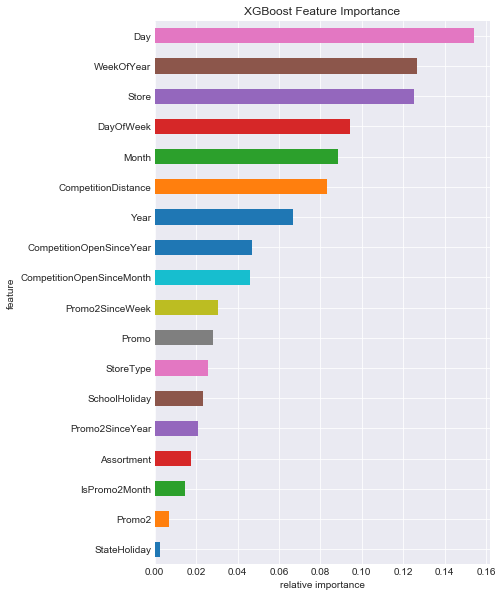

In [97]:
def create_feature_map(features):
    outfile=open('xgb.fmap','w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()
create_feature_map(features)
importance=gbm2.get_fscore(fmap='xgb.fmap')
importance=sorted(importance.items(),key=operator.itemgetter(1))

df=pd.DataFrame(importance,columns=['feature','fscore'])
df['fscore']=df['fscore']/df['fscore'].sum()

featp=df.plot(kind='barh',x='feature',y='fscore',legend=False,figsize=(6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')